## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92, 93,94,95, 96,97]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936, 3149,3357,3530, 3728,3881]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

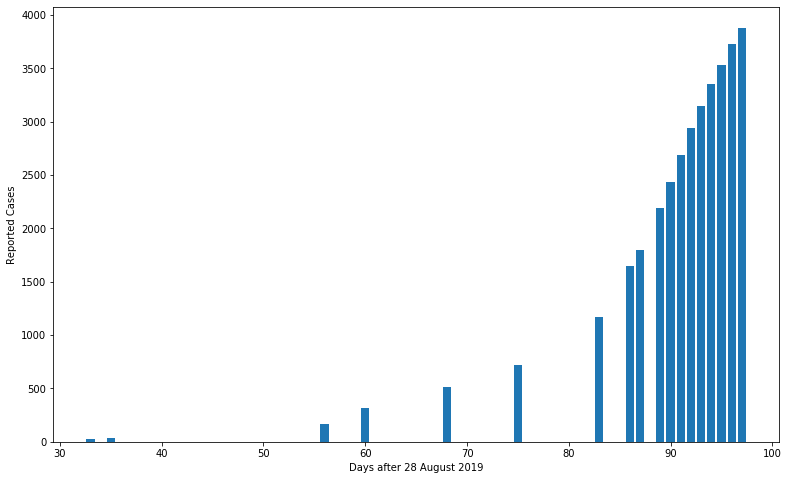

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

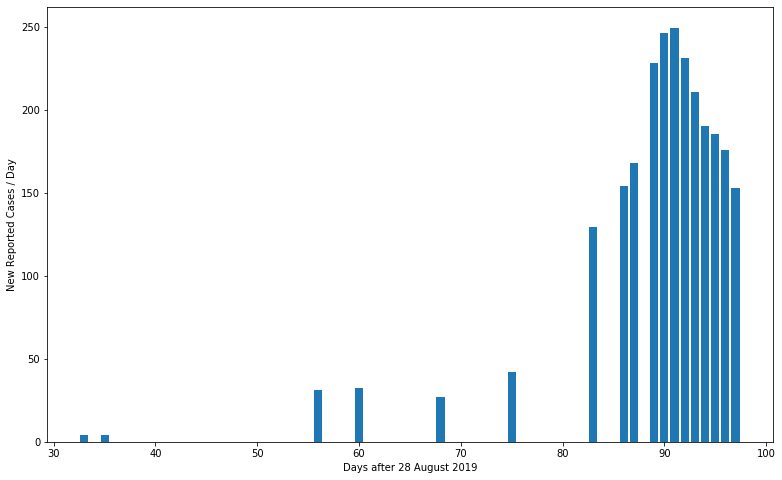

In [7]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [8]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [11]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [12]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

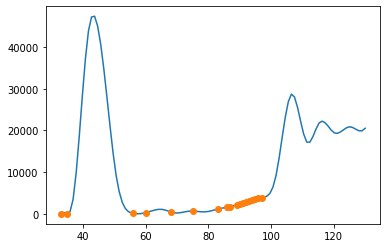

In [13]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [14]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [15]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  90  2.9289300e+01 0.00e+00 1.78e-04  -8.6 8.97e+04    -  7.24e-02 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9289298e+01 0.00e+00 1.41e-05  -8.6 3.17e+04    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Objective...............:   2.9289297909812706e+01    2.9289297909812706e+01
Dual infeasibility......:   4.2524347915267393e-09    4.2524347915267393e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   4.2524347915267393e-09    4.2524347915267393e-09


Number of objective function evaluations             = 152
Number of objective gradient evaluations             = 104
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 152
Number of equality constraint Jac

  40  2.9293303e+01 0.00e+00 1.05e-02  -8.6 7.00e+04 -14.6 9.05e-01 2.40e-01f  3
  50  2.9292575e+01 0.00e+00 1.45e-02  -8.6 3.27e+04 -14.0 1.00e+00 4.32e-01f  2
  60  2.9291478e+01 0.00e+00 5.94e-03  -8.6 2.27e+03 -14.2 1.00e+00 1.00e+00h  1
  70  2.9291466e+01 0.00e+00 2.38e-05  -8.6 1.26e+02 -15.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   2.9291465783922654e+01    2.9291465783922654e+01
Dual infeasibility......:   3.0634923254909260e-09    3.0634923254909260e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.0634923254909260e-09    3.0634923254909260e-09


Number of objective function evaluations             = 121
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of ine

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9296473e+01 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

  10  2.9525941e+01 0.00e+00 6.95e-01  -2.5 8.55e+03    -  7.43e-01 1.00e+00f  1
  20  2.9318894e+01 0.00e+00 1.05e-06  -5.7 2.85e-01  -5.4 1.00e+00 1.00e+00h  1
  30  2.9318132e+01 0.00e+00 8.21e-05  -8.6 5.97e+01 -10.2 1.00e+00 1.00e+00h  1
  40  2.9316249e+01 0.00e+00 1.30e-01  -8.6 2.40e+03 -11.4 1.00e+00 5.00e-01f  2
  50  2.9310027e+01 0.00e+00 1.03e-01  -8.6 1.13e+03 -11.6 1.00e+00 4.03e-01f  2
  60  2.9308048e+01 0.00e+00 2.66e-03  -8.6 2.69e+04    -  8.75e-01 2.50e-01h  3
  70  2.9308041e+01 0.00e+00 1.79e-06  -8.6 5.88e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   2.9308040564358446e+01    2.9308040564358446e+01
Dual infeasibility......:   1.4995712628376810e-09    1.4995712628376810e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059574707599428e-09    2.5059574707599428e-09
Overall NLP error......

  40  2.9356630e+01 0.00e+00 1.92e-01  -8.6 2.41e+03 -12.3 1.00e+00 5.00e-01f  2
  50  2.9346692e+01 0.00e+00 2.45e-01  -8.6 3.27e+03 -12.5 1.00e+00 1.00e+00f  1
  60  2.9334776e+01 0.00e+00 1.34e-05  -8.6 2.87e+01 -11.0 1.00e+00 1.00e+00f  1
  70  2.9334754e+01 0.00e+00 2.42e-10  -8.6 1.26e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   2.9334754188597476e+01    2.9334754188597476e+01
Dual infeasibility......:   2.4232647118467662e-10    2.4232647118467662e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060096599398485e-09    2.5060096599398485e-09
Overall NLP error.......:   2.5060096599398485e-09    2.5060096599398485e-09


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of ine


Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   2.9396425155223863e+01    2.9396425155223863e+01
Dual infeasibility......:   2.5567950865250891e-12    2.5567950865250891e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5265175027474739e-09    2.5265175027474739e-09
Overall NLP error.......:   2.5265175027474739e-09    2.5265175027474739e-09


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 66
Number of Lagrangian Hessian evaluations             = 65
Total CPU secs in IPOPT (w/o function evaluations)   =      0.118
Total CPU secs in NLP function evaluation

  30  2.9636412e+01 0.00e+00 3.23e-01  -5.7 7.11e+02 -11.2 1.00e+00 1.00e+00f  1
  40  2.9545250e+01 0.00e+00 1.08e+00  -5.7 2.25e+03 -11.4 1.00e+00 1.00e+00f  1
  50  2.9538747e+01 0.00e+00 4.65e-02  -5.7 3.52e+03 -13.8 1.00e+00 1.00e+00f  1
  60  2.9538675e+01 0.00e+00 6.15e-03  -8.6 6.65e+03    -  1.00e+00 8.54e-01h  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   2.9538674828718964e+01    2.9538674828718964e+01
Dual infeasibility......:   2.7143109368530157e-09    2.7143109368530157e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.3886937988179180e-09    4.3886937988179180e-09
Overall NLP error.......:   4.3886937988179180e-09    4.3886937988179180e-09


Number of objective function evaluations             = 97
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of ineq

  40  2.9866130e+01 0.00e+00 2.68e-05  -8.6 2.75e+03    -  1.00e+00 3.12e-02f  6

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   2.9866130030036427e+01    2.9866130030036427e+01
Dual infeasibility......:   6.5455122489212195e-10    6.5455122489212195e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.1842909338546145e-09    4.1842909338546145e-09
Overall NLP error.......:   4.1842909338546145e-09    4.1842909338546145e-09


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0617247e+01 0.00e+00 1.09e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.2571757e+01 0.00e+00 3.75e+01  -1.7 2.88e+03    -  6.58e-01 1.00e+00f  1
  20  3.1274283e+01 0.00e+00 4.26e+00  -2.5 1.00e+04    -  8.53e-01 1.25e-01f  4
  30  3.1242298e+01 0.00e+00 4.48e-02  -3.8 1.71e+02  -9.2 1.00e+00 1.00e+00f  1
  40  3.1038821e+01 0.00e+00 5.19e+00  -3.8 1.53e+04 -11.3 6.68e-01 6.12e-02f  3
  50  3.0639662e+01 0.00e+00 1.68e+00  -3.8 3.91e+03    -  1.00e+00 2.38e-01f  3
  60  3.0617038e+01 0.00e+00 4.70e-01  -5.7 6.20e+02    -  9.63e-01 1.00e+00f  1
  70  3.0616467e+01 0.00e+00 5.92e-04  -8.6 1.05e+02    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:   3.0616466664331419e+01    3.0616466664331419e+01
Dual infeasibility......:   2.7665128654597958e-10    2.7665128654597958e-10
Constraint viol

  30  3.4998249e+01 0.00e+00 8.12e+01  -1.7 1.34e+04    -  1.00e+00 2.50e-01f  3
  40  3.4790689e+01 0.00e+00 4.90e+01  -1.7 3.59e+03 -10.3 1.00e+00 1.00e+00f  1
  50  3.4784549e+01 0.00e+00 8.10e+00  -1.7 9.44e+02    -  1.00e+00 1.00e+00f  1
  60  3.4099247e+01 0.00e+00 9.23e+00  -3.8 1.44e+04    -  8.71e-01 2.50e-01f  3
  70  3.4033602e+01 0.00e+00 6.82e-01  -3.8 9.23e+02 -11.1 1.00e+00 1.00e+00f  1
  80  3.3924579e+01 0.00e+00 7.90e-01  -3.8 1.35e+03 -10.5 1.00e+00 1.00e+00f  1
  90  3.3621402e+01 0.00e+00 1.33e+01  -3.8 4.43e+03 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2639711e+01 0.00e+00 1.44e+01  -3.8 4.31e+03 -10.1 1.00e+00 1.98e-01f  2
 110  3.2326070e+01 0.00e+00 3.58e+00  -3.8 1.94e+04    -  1.00e+00 1.00e+00f  1
 120  3.2317992e+01 0.00e+00 3.20e-02  -5.7 4.71e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 129

                                   (scaled)                 (unscaled)
Object

  80  3.4776475e+01 0.00e+00 3.80e+00  -2.5 2.34e+03 -10.7 1.00e+00 1.00e+00f  1
  90  3.4629881e+01 0.00e+00 5.89e-01  -2.5 2.16e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4497316e+01 0.00e+00 1.91e-07  -3.8 8.12e+00    -  1.00e+00 1.00e+00h  1
 110  3.4495127e+01 0.00e+00 1.67e-04  -8.6 3.36e+01    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 112

                                   (scaled)                 (unscaled)
Objective...............:   3.4495126623640147e+01    3.4495126623640147e+01
Dual infeasibility......:   6.0050591099670405e-11    6.0050591099670405e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5382233823127971e-09    2.5382233823127971e-09
Overall NLP error.......:   2.5382233823127971e-09    2.5382233823127971e-09


Number of objective function evaluations             = 225
Number of objective gradient evaluations      

   0  4.4116079e+01 0.00e+00 2.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  5.2710664e+01 0.00e+00 7.18e+00  -1.0 4.57e+01  -5.0 1.00e+00 1.00e+00f  1
  20  5.7456251e+01 0.00e+00 1.28e+01  -1.0 8.70e+01  -6.4 1.00e+00 1.00e+00f  1
  30  5.2384844e+01 0.00e+00 8.84e+01  -1.7 2.03e+04    -  7.40e-01 1.25e-01f  4
  40  5.2672642e+01 0.00e+00 4.31e+01  -1.7 2.79e+04    -  3.69e-01 4.60e-02f  5
  50  5.3171105e+01 0.00e+00 1.04e+02  -1.7 4.27e+02  -8.5 1.00e+00 1.00e+00f  1
  60  5.3584248e+01 0.00e+00 3.53e+01  -1.7 8.63e+03    -  1.00e+00 2.50e-01f  3
  70  5.3696425e+01 0.00e+00 1.21e+00  -1.7 5.50e+02    -  1.00e+00 1.00e+00f  1
  80  5.3119887e+01 0.00e+00 3.52e+01  -2.5 1.55e+05    -  3.94e-01 1.08e-01f  3
  90  5.2666847e+01 0.00e+00 5.50e+01  -2.5 4.99e+03 -10.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0246699e+01 0.00e+00 7.17e+00  -2.5 9.09e+02  -9.3 1.00e+00 1.00e+00f  1
 110  4.5678613e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.6799158e+01 0.00e+00 3.42e+00  -1.0 0.00e+00    -  0.00e+00 0.

  10  9.4743606e+01 0.00e+00 1.60e+01  -1.7 1.23e+04    -  9.30e-01 1.00e+00f  1
  20  9.4165755e+01 0.00e+00 1.83e+00  -3.8 7.36e+02    -  1.00e+00 9.76e-01f  1
  30  9.4159348e+01 0.00e+00 3.12e+00  -5.7 4.18e+04    -  1.00e+00 7.74e-01f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   9.4159215914730837e+01    9.4159215914730837e+01
Dual infeasibility......:   1.2603527872315964e-09    1.2603527872315964e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.0448602828729187e-09    4.0448602828729187e-09
Overall NLP error.......:   4.0448602828729187e-09    4.0448602828729187e-09


Number of objective function evaluations             = 56
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 56
Number of equality constraint Jacobia


Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.3006217868225696e+02    1.3006217868225696e+02
Dual infeasibility......:   1.9680161443758956e-09    1.9680161443758956e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.5980067547565074e-09    4.5980067547565074e-09
Overall NLP error.......:   4.5980067547565074e-09    4.5980067547565074e-09


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 51
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 40
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w/o function evaluations)   =      0.057
Total CPU secs in NLP function evaluation

Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 39
Number of Lagrangian Hessian evaluations             = 38
Total CPU secs in IPOPT (w/o function evaluations)   =      0.054
Total CPU secs in NLP function evaluations           =      0.020

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.45ms ( 26.38us)   1.42ms ( 25.89us)        55
       nlp_g  | 693.00us ( 12.60us) 691.59us ( 12.57us)        55
    nlp_grad  |  65.00us ( 65.00us)  64.23us ( 64.23us)         1
  nlp_grad_f  |   2.11ms ( 52.87us)   2.12ms ( 52.92us)        40
  nlp_hess_l  |  14.22ms (374.13us)  14.21ms (373.83us)        38
   nlp_jac_g  | 635.00us ( 15.88us) 638.02us ( 15.95us)        40
       total  |  75.42ms ( 75.42ms)  74.87ms ( 74.87ms)         1
Solving for p=0.8697490026177834
This is Ipopt version 3.12.3, running with li

  10  2.7542757e+02 0.00e+00 6.41e+00  -1.7 1.80e+02    -  1.00e+00 1.00e+00f  1
  20  2.7531888e+02 0.00e+00 4.15e-04  -5.7 6.11e-02  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   2.7531888038882090e+02    2.7531888038882090e+02
Dual infeasibility......:   4.6023031874225826e-09    4.6023031874225826e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036250091963e-09    2.5059036250091963e-09
Overall NLP error.......:   4.6023031874225826e-09    4.6023031874225826e-09


Number of objective function evaluations             = 25
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 25
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 24
Num

  10  4.1731134e+02 0.00e+00 7.00e+00  -1.0 3.47e+00  -4.0 1.00e+00 1.00e+00f  1
  20  4.1868479e+02 0.00e+00 1.66e+01  -1.0 5.58e+00  -5.1 1.00e+00 1.00e+00f  1
  30  4.1941975e+02 0.00e+00 5.74e+02  -1.0 2.92e+04    -  1.00e+00 2.50e-01f  3
  40  4.1816112e+02 0.00e+00 6.33e-04  -1.7 8.53e+00    -  1.00e+00 1.00e+00h  1
  50  4.1808987e+02 0.00e+00 9.02e-04  -8.6 1.77e+02 -10.0 1.00e+00 1.00e+00f  1
  60  4.1785903e+02 0.00e+00 3.42e+01  -8.6 6.39e+04 -10.3 1.00e+00 2.22e-02f  5
  70  4.1760185e+02 0.00e+00 2.48e+01  -8.6 3.44e+02  -8.7 1.00e+00 1.00e+00f  1
  80  4.1722034e+02 0.00e+00 5.25e+00  -8.6 8.46e+02  -9.0 1.00e+00 1.00e+00f  1
  90  4.1578510e+02 0.00e+00 1.03e-08  -8.6 1.06e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 91

                                   (scaled)                 (unscaled)
Objective...............:   4.1578509834282380e+02    4.1578509834282380e+02
Dual infeas

  50  6.6503259e+02 0.00e+00 1.86e+02  -8.6 4.96e+03 -10.1 1.00e+00 5.00e-01f  2
  60  6.6424553e+02 0.00e+00 1.24e+02  -8.6 3.05e+03  -9.5 1.00e+00 5.00e-01f  2
  70  6.6262746e+02 0.00e+00 2.39e+01  -8.6 2.16e+02  -7.9 1.00e+00 1.00e+00f  1
  80  6.6065895e+02 0.00e+00 7.09e+01  -8.6 1.19e+02  -7.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:   5.1112864044236716e+02    6.5907158068717183e+02
Dual infeasibility......:   6.6137441240841758e-11    8.5280503756317059e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    3.2312214371289452e-09
Overall NLP error.......:   2.5059035596800626e-09    3.2312214371289452e-09


Number of objective function evaluations             = 127
Number of objective gradient evaluations             = 89
Number of equality constraint evaluations            = 0
Number of ine

  50  1.0610162e+03 0.00e+00 4.65e-03  -5.7 8.33e+01  -7.9 1.00e+00 1.00e+00f  1
  60  1.0579944e+03 0.00e+00 4.44e+00  -5.7 4.52e+02  -8.2 1.00e+00 1.00e+00f  1
  70  1.0511698e+03 0.00e+00 8.63e-01  -5.7 1.35e+00  -4.8 1.00e+00 1.00e+00f  1
  80  1.0508198e+03 0.00e+00 3.34e-11  -9.0 2.77e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   5.5240589663918809e+02    1.0508198390985312e+03
Dual infeasibility......:   3.3376494103507382e-11    6.3490781646070901e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909623262249037e-10    1.7293377255771980e-09
Overall NLP error.......:   9.0909623262249037e-10    1.7293377255771980e-09


Number of objective function evaluations             = 110
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 0
Number of ine

  20  1.6361641e+03 0.00e+00 2.27e-04  -2.5 1.42e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   6.2806803946719072e+02    1.6360421545026156e+03
Dual infeasibility......:   1.6083596855785948e-10    4.1895846944248324e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059055693311707e-09    6.5275844160238265e-09
Overall NLP error.......:   2.5059055693311707e-09    6.5275844160238265e-09


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 34
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 29
Number of Lagrangian Hessian evaluations             = 28
Total CPU secs in IPOPT (w


Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   7.8579710511793701e+02    2.7665448957356625e+03
Dual infeasibility......:   1.1950619329093219e-10    4.2074378602884610e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059051465486213e-09    8.8225052589641655e-09
Overall NLP error.......:   2.5059051465486213e-09    8.8225052589641655e-09


Number of objective function evaluations             = 33
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 33
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 27
Number of Lagrangian Hessian evaluations             = 26
Total CPU secs in IPOPT (w/o function evaluations)   =      0.040
Total CPU secs in NLP function evaluation

  30  3.8490349e+03 0.00e+00 2.85e-10  -5.7 1.71e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   9.5482485628926111e+02    3.8490348679296012e+03
Dual infeasibility......:   5.4311254374056568e-10    2.1893639491032270e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059060380939933e-09    1.0101663831693427e-08
Overall NLP error.......:   2.5059060380939933e-09    1.0101663831693427e-08


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 33
Number of Lagrangian Hessian evaluations             = 32
Total CPU secs in IPOPT (w


                                   (scaled)                 (unscaled)
Objective...............:   1.1947532715330287e+03    5.0035614044073463e+03
Dual infeasibility......:   7.8821511782448993e-10    3.3010018351793051e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059116298460523e-09    1.0494620950369660e-08
Overall NLP error.......:   2.5059116298460523e-09    1.0494620950369660e-08


Number of objective function evaluations             = 29
Number of objective gradient evaluations             = 25
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 29
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 25
Number of Lagrangian Hessian evaluations             = 24
Total CPU secs in IPOPT (w/o function evaluations)   =      0.037
Total CPU secs in NLP function evaluations           =      0.012

EXIT

Total CPU secs in IPOPT (w/o function evaluations)   =      0.470
Total CPU secs in NLP function evaluations           =      0.117

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.23ms ( 26.36us)   9.19ms ( 26.27us)       350
       nlp_g  |   4.40ms ( 12.58us)   4.36ms ( 12.46us)       350
    nlp_grad  |  65.00us ( 65.00us)  64.76us ( 64.76us)         1
  nlp_grad_f  |  12.36ms ( 53.05us)  12.39ms ( 53.18us)       233
  nlp_hess_l  |  86.76ms (375.58us)  86.72ms (375.43us)       231
   nlp_jac_g  |   3.74ms ( 16.04us)   3.77ms ( 16.17us)       233
       total  | 608.13ms (608.13ms) 606.19ms (606.19ms)         1
Solving for p=2154.4346900318865
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Numbe

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4612987e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 270  6.5557351e+03 0.00e+00 1.88e+01  -3.8 1.73e+00  -6.7 1.00e+00 1.00e+00f  1
 280  6.5557169e+03 0.00e+00 2.16e+01  -3.8 2.51e+01  -7.9 1.00e+00 1.00e+00f  1
 290  6.5556896e+03 0.00e+00 9.34e+01  -3.8 3.24e-01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.5556768e+03 0.00e+00 4.13e+01  -3.8 1.58e+00  -6.6 1.00e+00 1.00e+00f  1
 310  6.5556438e+03 0.00e+00 3.56e+02  -3.8 2.72e+01  -7.8 1.00e+00 1.00e+00f  1
 320  6.5556170e+03 0.00e+00 3.16e+00  -3.8 6.61e-01  -6.2 1.00e+00 1.00e+00f  1
 330  6.5555617e+03 0.00e+00 6.38e-06  -3.8 3.14e-04    -  1.00e+00 1.00e+00h  1
 340  6.5555498e+03 0.00e+00 7.28e-09  -9.0 2.97e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 340

                                   (scaled)                 (unscaled)
Objective...............:   2.8843748184287551e+03    6.5555498375749885e+03
Dual infeasibility......:   7.2823719862053833e-09    1.6551230508015386e-08
Constraint vio

       nlp_f  |  36.17ms ( 25.85us)  36.37ms ( 26.00us)      1399
       nlp_g  |  17.22ms ( 12.31us)  17.19ms ( 12.29us)      1399
    nlp_grad  | 122.00us (122.00us)  64.55us ( 64.55us)         1
  nlp_grad_f  |  25.29ms ( 55.58us)  25.31ms ( 55.62us)       455
  nlp_hess_l  | 176.27ms (389.13us) 176.71ms (390.09us)       453
   nlp_jac_g  |   7.74ms ( 17.02us)   7.78ms ( 17.10us)       455
       total  |   1.14 s (  1.14 s)   1.13 s (  1.13 s)         1
Solving for p=8697.490026177835
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and u

  30  6.9717263e+03 0.00e+00 8.64e+04  -1.0 6.75e+03    -  6.86e-01 2.50e-01f  3
  40  6.9664613e+03 0.00e+00 1.01e+02  -1.0 3.80e-01  -2.9 1.00e+00 1.00e+00f  1
  50  6.9661423e+03 0.00e+00 7.24e+00  -1.0 9.71e-02  -2.7 1.00e+00 1.00e+00f  1
  60  6.9661089e+03 0.00e+00 4.20e+01  -1.0 2.50e-01  -3.3 1.00e+00 1.00e+00f  1
  70  6.9661191e+03 0.00e+00 5.94e+00  -1.0 1.03e-01  -2.9 1.00e+00 1.00e+00f  1
  80  6.9661571e+03 0.00e+00 1.40e+00  -1.0 4.46e-02  -2.6 1.00e+00 1.00e+00f  1
  90  6.9659471e+03 0.00e+00 2.28e+03  -1.7 9.12e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9659251e+03 0.00e+00 4.97e+02  -1.7 6.99e-01  -5.2 1.00e+00 1.00e+00f  1
 110  6.9659470e+03 0.00e+00 3.19e+03  -1.7 1.82e+04    -  1.00e+00 1.25e-01f  4
 120  6.9658933e+03 0.00e+00 1.76e+03  -2.5 3.98e+00  -4.6 1.00e+00 5.00e-01f  2
 130  6.9658855e+03 0.00e+00 1.49e+03  -2.5 1.18e+00  -5.7 1.00e+00 1.00e+00f  1
 140  6.9658808e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.9658086e+03 0.00e+00 2.13e-06  -9.0 2.20e-09    -  1.00e+00 1.53e-05f 17
1010  6.9658086e+03 0.00e+00 2.02e-06  -9.0 2.14e-09    -  1.00e+00 1.00e+00F  1
1020  6.9658086e+03 0.00e+00 2.37e-06  -9.0 3.58e-09    -  1.00e+00 1.00e+00H  1
1030  6.9658086e+03 0.00e+00 1.29e-06  -9.0 5.97e-09    -  1.00e+00 1.00e+00F  1
1040  6.9658086e+03 0.00e+00 9.55e-07  -9.0 5.00e-09    -  1.00e+00 1.00e+00H  1
1050  6.9658086e+03 0.00e+00 4.36e-06  -9.0 1.51e-09    -  1.00e+00 1.00e+00F  1
1060  6.9658086e+03 0.00e+00 1.90e-06  -9.0 3.18e-10    -  1.00e+00 1.00e+00H  1
1070  6.9658086e+03 0.00e+00 1.10e-06  -9.0 9.79e-09    -  1.00e+00 5.00e-01h  2
1080  6.9658086e+03 0.00e+00 1.70e-06  -9.0 3.84e-09    -  1.00e+00 1.56e-02f  7
1090  6.9658086e+03 0.00e+00 2.07e-06  -9.0 1.03e-08    -  1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  6.9658086e+03 0.00e+00

1930  6.9658086e+03 0.00e+00 2.29e-06  -9.0 2.68e-09    -  1.00e+00 1.00e+00F  1
1940  6.9658086e+03 0.00e+00 1.65e-07  -9.0 2.22e-09    -  1.00e+00 1.25e-01f  4
1950  6.9658086e+03 0.00e+00 7.27e-07  -9.0 5.99e-09    -  1.00e+00 1.00e+00H  1
1960  6.9658086e+03 0.00e+00 1.15e-06  -9.0 9.89e-09    -  1.00e+00 3.81e-06f 19
1970  6.9658086e+03 0.00e+00 1.80e-06  -9.0 1.03e-09    -  1.00e+00 1.00e+00f  1
1980  6.9658086e+03 0.00e+00 2.52e-06  -9.0 4.66e-09    -  1.00e+00 7.63e-06f 18
1990  6.9658086e+03 0.00e+00 3.26e-07  -9.0 3.81e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.9658086e+03 0.00e+00 1.40e-06  -9.0 5.52e-09    -  1.00e+00 5.00e-01f  2
2010  6.9658086e+03 0.00e+00 2.96e-06  -9.0 3.63e-09    -  1.00e+00 1.00e+00H  1
2020  6.9658086e+03 0.00e+00 2.90e-06  -9.0 1.90e-09    -  1.00e+00 1.00e+00H  1
2030  6.9658086e+03 0.00e+00 1.13e-06  -9.0 7.95e-09    -  1.00e+00 1.00e+00H  1
2040  6.9658086e+03 0.00e+00

 380  7.1260337e+03 0.00e+00 3.11e-07  -8.6 4.02e-09    -  1.00e+00 1.00e+00H  1
 390  7.1260337e+03 0.00e+00 4.32e-06  -8.6 4.63e-09    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  7.1260337e+03 0.00e+00 1.50e-06  -8.6 4.02e-10    -  1.00e+00 1.00e+00H  1
 410  7.1260337e+03 0.00e+00 2.31e-07  -8.6 8.54e-09    -  1.00e+00 5.00e-01f  2
 420  7.1260337e+03 0.00e+00 2.97e-06  -8.6 9.09e-10    -  1.00e+00 2.50e-01f  3
 430  7.1260337e+03 0.00e+00 1.14e-06  -8.6 3.89e-09    -  1.00e+00 1.00e+00f  1
 440  7.1260337e+03 0.00e+00 4.21e-06  -8.6 1.99e-09    -  1.00e+00 1.25e-01h  4
 450  7.1260337e+03 0.00e+00 2.10e-06  -8.6 7.75e-09    -  1.00e+00 3.81e-06f 19
 460  7.1260337e+03 0.00e+00 2.92e-07  -8.6 2.34e-09    -  1.00e+00 6.25e-02f  5
 470  7.1260337e+03 0.00e+00 1.00e-06  -8.6 1.02e-08    -  1.00e+00 3.05e-05f 16
 480  7.1260337e+03 0.00e+00 2.53e-07  -8.6 4.81e-09    -  1.00e+00 2.50e-01f  3
 490  7.1260337e+03 0.00e+00

1390  7.1260337e+03 0.00e+00 3.25e-06  -8.6 2.55e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.1260337e+03 0.00e+00 4.49e-06  -8.6 1.07e-08    -  1.00e+00 1.00e+00F  1
1410  7.1260337e+03 0.00e+00 3.07e-06  -8.6 1.94e-10    -  1.00e+00 1.00e+00f  1
1420  7.1260337e+03 0.00e+00 2.94e-06  -8.6 4.56e-09    -  1.00e+00 6.25e-02f  5
1430  7.1260337e+03 0.00e+00 2.46e-06  -8.6 1.75e-09    -  1.00e+00 5.00e-01h  2
1440  7.1260337e+03 0.00e+00 1.27e-06  -8.6 2.67e-09    -  1.00e+00 7.81e-03h  8
1450  7.1260337e+03 0.00e+00 3.21e-06  -8.6 8.73e-09    -  1.00e+00 5.00e-01h  2
1460  7.1260337e+03 0.00e+00 2.50e-06  -8.6 6.39e-09    -  1.00e+00 1.95e-03f 10
1470  7.1260337e+03 0.00e+00 4.00e-06  -8.6 5.36e-09    -  1.00e+00 1.00e+00h  1
1480  7.1260337e+03 0.00e+00 9.43e-07  -8.6 8.56e-10    -  1.00e+00 3.12e-02f  6
1490  7.1260337e+03 0.00e+00 1.59e-06  -8.6 4.62e-09    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

2310  7.1260337e+03 0.00e+00 1.68e-06  -9.0 5.23e-09    -  1.00e+00 7.63e-06f 18
2320  7.1260337e+03 0.00e+00 1.55e-07  -9.0 2.28e-09    -  1.00e+00 5.00e-01f  2
2330  7.1260337e+03 0.00e+00 3.03e-06  -9.0 5.85e-09    -  1.00e+00 3.12e-02f  6
2340  7.1260337e+03 0.00e+00 1.81e-07  -9.0 2.69e-09    -  1.00e+00 1.00e+00f  1
2350  7.1260337e+03 0.00e+00 1.09e-06  -9.0 1.03e-09    -  1.00e+00 1.00e+00f  1
2360  7.1260337e+03 0.00e+00 2.60e-06  -9.0 1.74e-09    -  1.00e+00 1.00e+00H  1
2370  7.1260337e+03 0.00e+00 4.54e-06  -9.0 4.71e-09    -  1.00e+00 5.00e-01h  2
2380  7.1260337e+03 0.00e+00 5.23e-07  -9.0 7.47e-09    -  1.00e+00 3.12e-02f  6
2390  7.1260337e+03 0.00e+00 5.19e-07  -9.0 1.66e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  7.1260337e+03 0.00e+00 2.87e-06  -9.0 1.36e-09    -  1.00e+00 1.00e+00H  1
2410  7.1260337e+03 0.00e+00 4.01e-07  -9.0 9.27e-10    -  1.00e+00 1.00e+00H  1
2420  7.1260337e+03 0.00e+00

  70  7.3088245e+03 0.00e+00 3.51e+01  -1.0 1.68e-01  -2.8 1.00e+00 1.00e+00f  1
  80  7.3082517e+03 0.00e+00 1.32e+03  -1.7 6.22e-01  -3.9 1.00e+00 1.00e+00f  1
  90  7.3081759e+03 0.00e+00 3.64e+03  -1.7 7.99e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3081178e+03 0.00e+00 4.15e+02  -1.7 7.14e-01  -4.7 1.00e+00 1.00e+00f  1
 110  7.3080939e+03 0.00e+00 8.29e+03  -1.7 2.02e+04    -  1.00e+00 6.25e-02f  5
 120  7.3080759e+03 0.00e+00 9.10e+03  -1.7 1.94e+04    -  1.00e+00 6.25e-02f  5
 130  7.3080343e+03 0.00e+00 4.04e+00  -1.7 9.58e-02  -4.2 1.00e+00 1.00e+00f  1
 140  7.3080302e+03 0.00e+00 5.91e+01  -1.7 2.50e-01  -4.8 1.00e+00 1.00e+00f  1
 150  7.3080314e+03 0.00e+00 6.20e-01  -1.7 9.43e-02  -4.5 1.00e+00 1.00e+00f  1
 160  7.3080091e+03 0.00e+00 1.15e+03  -2.5 1.68e+00  -5.6 1.00e+00 5.00e-01f  2
 170  7.3080028e+03 0.00e+00 2.62e+03  -2.5 1.93e+00  -6.7 1.00e+00 1.00e+00f  1
 180  7.3079987e+03 0.00e+00

1080  7.3079057e+03 0.00e+00 2.26e-06  -9.0 3.55e-09    -  1.00e+00 1.00e+00F  1
1090  7.3079057e+03 0.00e+00 2.77e-06  -9.0 1.52e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.3079057e+03 0.00e+00 3.31e-06  -9.0 9.87e-09    -  1.00e+00 1.00e+00F  1
1110  7.3079057e+03 0.00e+00 1.35e-06  -9.0 6.59e-10    -  1.00e+00 1.00e+00h  1
1120  7.3079057e+03 0.00e+00 4.77e-06  -9.0 6.80e-09    -  1.00e+00 3.91e-03f  9
1130  7.3079057e+03 0.00e+00 2.33e-06  -9.0 2.73e-09    -  1.00e+00 1.00e+00F  1
1140  7.3079057e+03 0.00e+00 2.35e-06  -9.0 4.75e-09    -  1.00e+00 1.00e+00h  1
1150  7.3079057e+03 0.00e+00 5.94e-06  -9.0 3.17e-09    -  1.00e+00 3.91e-03f  9
1160  7.3079057e+03 0.00e+00 2.07e-06  -9.0 9.48e-09    -  1.00e+00 1.22e-04f 14
1170  7.3079057e+03 0.00e+00 6.45e-06  -9.0 6.19e-09    -  1.00e+00 6.10e-05f 15
1180  7.3079057e+03 0.00e+00 1.94e-06  -9.0 8.06e-09    -  1.00e+00 5.00e-01f  2
1190  7.3079057e+03 0.00e+00

 380  7.5160949e+03 0.00e+00 2.22e-06  -8.6 2.46e-09    -  1.00e+00 1.00e+00h  1
 390  7.5160949e+03 0.00e+00 2.06e-06  -8.6 8.30e-10    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  7.5160949e+03 0.00e+00 5.29e-06  -8.6 2.68e-09    -  1.00e+00 1.00e+00F  1
 410  7.5160949e+03 0.00e+00 4.37e-06  -8.6 1.09e-09    -  1.00e+00 1.00e+00H  1
 420  7.5160949e+03 0.00e+00 8.34e-07  -8.6 2.09e-09    -  1.00e+00 1.00e+00F  1
 430  7.5160949e+03 0.00e+00 2.24e-06  -8.6 2.32e-10    -  1.00e+00 1.22e-04f 14
 440  7.5160949e+03 0.00e+00 4.56e-06  -8.6 3.68e-09    -  1.00e+00 1.56e-02f  7
 450  7.5160949e+03 0.00e+00 2.19e-07  -8.6 1.38e-08    -  1.00e+00 1.00e+00h  1
 460  7.5160949e+03 0.00e+00 4.30e-06  -8.6 2.18e-09    -  1.00e+00 3.05e-05f 16
 470  7.5160949e+03 0.00e+00 3.88e-06  -8.6 3.68e-09    -  1.00e+00 1.00e+00h  1
 480  7.5160949e+03 0.00e+00 2.39e-06  -8.6 2.13e-09    -  1.00e+00 1.00e+00H  1
 490  7.5160949e+03 0.00e+00

1320  7.5160949e+03 0.00e+00 1.34e-06  -8.6 3.14e-10    -  1.00e+00 1.00e+00H  1
1330  7.5160949e+03 0.00e+00 8.57e-07  -8.6 3.30e-10    -  1.00e+00 1.22e-04f 14
1340  7.5160949e+03 0.00e+00 7.36e-06  -8.6 1.43e-08    -  1.00e+00 1.00e+00F  1
1350  7.5160949e+03 0.00e+00 1.54e-06  -8.6 8.91e-09    -  1.00e+00 1.53e-05f 17
1360  7.5160949e+03 0.00e+00 2.42e-06  -8.6 8.25e-09    -  1.00e+00 1.00e+00H  1
1370  7.5160949e+03 0.00e+00 3.88e-06  -8.6 1.29e-09    -  1.00e+00 1.00e+00h  1
1380  7.5160949e+03 0.00e+00 8.27e-07  -8.6 1.41e-08    -  1.00e+00 1.00e+00F  1
1390  7.5160949e+03 0.00e+00 1.51e-06  -8.6 5.13e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.5160949e+03 0.00e+00 2.22e-06  -8.6 4.19e-09    -  1.00e+00 1.00e+00F  1
1410  7.5160949e+03 0.00e+00 1.18e-06  -8.6 8.11e-10    -  1.00e+00 1.00e+00H  1
1420r 3.4419299e+04 0.00e+00 1.14e-13  -8.6 1.28e+01    -  1.00e+00 1.00e+00h  1
1430  7.5160955e+03 0.00e+00

2270  7.5160949e+03 0.00e+00 7.62e-06  -9.0 8.88e-09    -  1.00e+00 1.00e+00F  1
2280  7.5160949e+03 0.00e+00 6.20e-07  -9.0 1.20e-08    -  1.00e+00 1.22e-04f 14
2290  7.5160949e+03 0.00e+00 3.05e-06  -9.0 3.66e-09    -  1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  7.5160949e+03 0.00e+00 2.23e-06  -9.0 4.23e-09    -  1.00e+00 1.00e+00H  1
2310  7.5160949e+03 0.00e+00 3.37e-06  -9.0 4.44e-09    -  1.00e+00 6.10e-05f 15
2320  7.5160949e+03 0.00e+00 1.61e-06  -9.0 1.09e-08    -  1.00e+00 1.53e-05f 17
2330  7.5160949e+03 0.00e+00 5.60e-06  -9.0 2.86e-09    -  1.00e+00 1.53e-05f 17
2340  7.5160949e+03 0.00e+00 1.77e-06  -9.0 1.46e-09    -  1.00e+00 1.00e+00H  1
2350  7.5160949e+03 0.00e+00 4.70e-06  -9.0 9.78e-09    -  1.00e+00 1.00e+00F  1
2360  7.5160949e+03 0.00e+00 1.46e-06  -9.0 5.59e-09    -  1.00e+00 1.00e+00H  1
2370  7.5160949e+03 0.00e+00 3.73e-06  -9.0 1.62e-08    -  1.00e+00 1.00e+00H  1
2380  7.5160949e+03 0.00e+00

  50  8.0826079e+04 0.00e+00 3.21e+03  -1.0 5.15e+01  -5.6 1.00e+00 1.00e+00f  1
  60  8.9401457e+04 0.00e+00 3.36e+03  -1.0 1.18e+02  -5.8 1.00e+00 5.00e-01f  2
  70  8.8193244e+04 0.00e+00 1.32e+03  -1.0 1.57e+03  -6.0 7.05e-01 3.12e-02f  6
  80  7.5391305e+04 0.00e+00 5.77e+02  -1.0 3.73e+01  -5.8 1.00e+00 1.00e+00f  1
  90  7.9106713e+04 0.00e+00 1.34e+02  -1.0 2.65e+01  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.6008589e+04 0.00e+00 5.29e+03  -1.0 2.73e+04    -  9.91e-02 3.86e-03f  6
 110  7.5132690e+04 0.00e+00 2.15e+03  -1.0 6.80e+01  -6.0 1.00e+00 1.00e+00f  1
 120  8.9034821e+04 0.00e+00 9.91e+03  -1.0 1.66e+02  -6.7 1.00e+00 1.00e+00f  1
 130  8.5486718e+04 0.00e+00 1.82e+02  -1.0 2.88e+01  -6.0 1.00e+00 1.00e+00f  1
 140  8.2848849e+04 0.00e+00 1.95e+01  -1.0 1.64e+01  -5.7 1.00e+00 1.00e+00f  1
 150  8.8893213e+04 0.00e+00 7.49e+02  -1.0 6.33e+01  -6.3 1.00e+00 1.00e+00f  1
 160  8.2131927e+04 0.00e+00

1000  2.6170470e+05 0.00e+00 6.39e+03  -1.0 8.02e+02  -9.2 1.00e+00 2.50e-01f  3
1010  2.6195299e+05 0.00e+00 2.06e+04  -1.0 3.54e+03    -  1.00e+00 2.50e-01f  3
1020  2.6166882e+05 0.00e+00 7.80e+03  -1.0 4.39e+02  -9.3 1.00e+00 5.00e-01f  2
1030  2.6122366e+05 0.00e+00 9.31e+03  -1.0 3.59e+02  -9.0 1.00e+00 1.00e+00f  1
1040  2.6096613e+05 0.00e+00 5.62e+02  -1.0 8.96e+01  -8.3 1.00e+00 1.00e+00f  1
1050  2.6082784e+05 0.00e+00 8.94e+03  -1.0 3.20e+02  -9.5 1.00e+00 1.00e+00f  1
1060  2.6046109e+05 0.00e+00 5.89e+03  -1.0 5.12e+02  -9.7 1.00e+00 5.00e-01f  2
1070  2.6023255e+05 0.00e+00 1.18e+04  -1.0 4.17e+02  -9.9 1.00e+00 1.00e+00f  1
1080  2.5991632e+05 0.00e+00 4.28e+03  -1.0 1.01e+03    -  1.00e+00 2.50e-01f  3
1090  2.5953264e+05 0.00e+00 5.54e+02  -1.0 9.80e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.5921860e+05 0.00e+00 3.19e+02  -1.0 6.59e+01  -9.5 1.00e+00 1.00e+00f  1
1110  2.5896385e+05 0.00e+00

2040  1.5005418e+04 0.00e+00 2.58e+02  -2.5 6.07e+01  -8.6 1.00e+00 1.00e+00f  1
2050  1.5021395e+04 0.00e+00 3.50e+02  -2.5 1.86e+02  -9.3 1.00e+00 5.00e-01f  2
2060  1.5054032e+04 0.00e+00 5.65e+02  -2.5 5.80e+01  -8.6 1.00e+00 1.00e+00f  1
2070  1.5065773e+04 0.00e+00 6.23e+01  -2.5 3.77e+01  -8.4 1.00e+00 1.00e+00f  1
2080  1.5094530e+04 0.00e+00 7.66e+02  -2.5 1.18e+02  -9.1 1.00e+00 1.00e+00f  1
2090  1.5118587e+04 0.00e+00 9.02e+02  -2.5 1.96e+04    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.5120035e+04 0.00e+00 5.45e+02  -2.5 2.64e+04    -  1.00e+00 9.38e-03f  7
2110  1.5119205e+04 0.00e+00 2.21e+02  -2.5 3.20e+04    -  1.00e+00 5.57e-03f  8
2120  1.5122728e+04 0.00e+00 1.40e+03  -2.5 3.27e+04    -  1.00e+00 1.09e-02f  7
2130  1.5094227e+04 0.00e+00 2.95e+01  -2.5 5.62e+01  -8.6 1.00e+00 1.00e+00f  1
2140  1.5120301e+04 0.00e+00 4.87e+02  -2.5 2.75e+04    -  1.00e+00 7.81e-03f  8
2150  1.5102055e+04 0.00e+00

3000  1.3022866e+04 0.00e+00 1.98e+02  -3.8 1.01e+02  -8.7 1.00e+00 2.50e-01f  3

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.3385891879422573e+00    1.3022865529769215e+04
Dual infeasibility......:   1.9788766420004987e+02    1.9252093652713271e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5159054414070106e-04    1.4747939769061191e+00
Overall NLP error.......:   1.9788766420004987e+02    1.9252093652713271e+06


Number of objective function evaluations             = 6731
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6731
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs

 670  2.2867620e+05 0.00e+00 8.69e+00  -2.5 1.40e+01  -9.9 1.00e+00 1.00e+00h  1
 680  2.2861692e+05 0.00e+00 3.15e+02  -2.5 1.79e+03    -  1.00e+00 6.25e-02f  5
 690  2.2855550e+05 0.00e+00 7.95e+00  -2.5 3.10e+01 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.2849581e+05 0.00e+00 2.23e+02  -2.5 1.35e+03    -  1.00e+00 6.25e-02f  5
 710  2.2846679e+05 0.00e+00 3.11e+02  -2.5 8.71e+02    -  1.00e+00 1.25e-01f  4
 720  2.2841732e+05 0.00e+00 3.72e+02  -2.5 1.85e+03    -  1.00e+00 6.25e-02f  5
 730  2.2837879e+05 0.00e+00 2.75e+01  -2.5 2.25e+01 -10.3 1.00e+00 1.00e+00h  1
 740  2.2832789e+05 0.00e+00 4.09e+00  -2.5 8.48e+00 -10.0 1.00e+00 1.00e+00h  1
 750  2.2946335e+05 0.00e+00 2.08e+04  -2.5 1.10e+03    -  1.00e+00 1.00e+00S 50
 760  2.2832822e+05 0.00e+00 1.06e-01  -2.5 2.67e+00  -8.9 1.00e+00 1.00e+00h  1
 770  2.2826797e+05 0.00e+00 1.74e+00  -2.5 8.90e+00  -9.9 1.00e+00 1.00e+00h  1
 780  2.2821841e+05 0.00e+00

1600  4.1903677e+04 0.00e+00 2.32e+03  -2.5 2.73e+02  -7.7 1.00e+00 1.00e+00f  1
1610  3.3521056e+04 0.00e+00 1.78e+03  -2.5 1.38e+03  -8.0 1.00e+00 1.25e-01f  4
1620  2.7681099e+04 0.00e+00 1.03e+02  -2.5 6.81e+01  -7.3 1.00e+00 1.00e+00f  1
1630  2.3779655e+04 0.00e+00 6.62e+01  -2.5 8.52e+01  -7.6 1.00e+00 1.00e+00f  1
1640  2.0924085e+04 0.00e+00 4.51e+01  -2.5 4.50e+01  -7.3 1.00e+00 1.00e+00f  1
1650  1.8797420e+04 0.00e+00 1.26e+00  -2.5 1.63e+01  -7.1 1.00e+00 1.00e+00f  1
1660  1.7511392e+04 0.00e+00 1.24e+03  -2.5 3.16e+02  -8.7 1.00e+00 1.00e+00f  1
1670  1.6951317e+04 0.00e+00 6.92e+02  -2.5 1.41e+02  -8.5 1.00e+00 1.00e+00f  1
1680  1.6749947e+04 0.00e+00 5.18e+02  -2.5 1.63e+02  -8.7 1.00e+00 1.00e+00f  1
1690  1.6772226e+04 0.00e+00 6.76e+02  -2.5 2.58e+03  -8.9 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.6783826e+04 0.00e+00 6.97e+02  -2.5 4.80e+02  -9.2 1.00e+00 5.00e-01f  2
1710  1.6785873e+04 0.00e+00

2610  1.3764407e+04 0.00e+00 1.55e+02  -3.8 2.17e+05    -  2.08e-01 7.74e-04f  9
2620  1.3731481e+04 0.00e+00 2.86e+02  -3.8 1.72e+05    -  2.41e-01 9.57e-04f  9
2630  1.3698714e+04 0.00e+00 3.94e+02  -3.8 5.60e+01  -9.0 1.00e+00 1.00e+00f  1
2640  1.3661450e+04 0.00e+00 1.53e+02  -3.8 3.16e+01  -8.3 1.00e+00 1.00e+00f  1
2650  1.3632702e+04 0.00e+00 8.11e+01  -3.8 4.24e+01  -9.0 1.00e+00 1.00e+00f  1
2660  1.3602507e+04 0.00e+00 1.52e+02  -3.8 1.01e+02 -10.1 1.00e+00 1.00e+00f  1
2670  1.3578147e+04 0.00e+00 3.65e+02  -3.8 4.93e+01  -8.6 1.00e+00 1.00e+00f  1
2680  1.3539839e+04 0.00e+00 8.00e+00  -3.8 7.07e+00  -7.9 1.00e+00 1.00e+00f  1
2690  1.3517884e+04 0.00e+00 1.99e+01  -3.8 1.42e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.3497349e+04 0.00e+00 1.82e-01  -3.8 1.83e+00  -7.5 1.00e+00 1.00e+00f  1
2710  1.3472547e+04 0.00e+00 2.00e+01  -3.8 1.41e+01  -8.2 1.00e+00 1.00e+00f  1
2720  1.3453139e+04 0.00e+00

 250  3.0331689e+05 0.00e+00 7.35e+03  -1.0 2.15e+02  -8.0 1.00e+00 1.00e+00f  1
 260  3.0647502e+05 0.00e+00 3.10e+02  -1.0 5.01e+01  -7.3 1.00e+00 1.00e+00f  1
 270  3.1220051e+05 0.00e+00 1.88e+04  -1.0 2.50e+04    -  4.07e-01 3.12e-02f  6
 280  3.1362251e+05 0.00e+00 9.63e+02  -1.0 1.25e+02  -8.2 1.00e+00 1.00e+00f  1
 290  3.1463812e+05 0.00e+00 1.18e+04  -1.0 1.29e+03  -8.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.1776444e+05 0.00e+00 2.39e+04  -1.0 2.29e+04    -  1.00e+00 6.25e-02f  5
 310  3.2002709e+05 0.00e+00 8.31e+03  -1.0 5.80e+02  -8.7 1.00e+00 5.00e-01f  2
 320  3.2312673e+05 0.00e+00 1.29e+04  -1.0 7.99e+02  -8.9 1.00e+00 5.00e-01f  2
 330  3.2500231e+05 0.00e+00 3.63e+04  -1.0 1.52e+03  -9.2 1.00e+00 5.00e-01f  2
 340  3.2505170e+05 0.00e+00 1.40e+04  -1.0 1.03e+04    -  1.00e+00 6.25e-02f  5
 350  3.2721761e+05 0.00e+00 1.92e+04  -1.0 5.05e+02  -9.2 1.00e+00 1.00e+00f  1
 360  3.2670304e+05 0.00e+00

1230  3.6821836e+04 0.00e+00 4.85e+03  -3.8 3.30e+02  -7.8 1.00e+00 1.00e+00f  1
1240  3.3052346e+04 0.00e+00 1.66e+02  -3.8 6.68e+01  -7.1 1.00e+00 1.00e+00f  1
1250  2.8338502e+04 0.00e+00 1.38e+02  -3.8 9.30e+01  -7.4 1.00e+00 1.00e+00f  1
1260  2.5393010e+04 0.00e+00 1.32e+03  -3.8 1.68e+02  -7.6 1.00e+00 1.00e+00f  1
1270  2.2567881e+04 0.00e+00 3.18e+03  -3.8 2.51e+02  -7.9 1.00e+00 1.00e+00f  1
1280  2.0697524e+04 0.00e+00 8.42e+01  -3.8 4.54e+01  -7.3 1.00e+00 1.00e+00f  1
1290  1.9192263e+04 0.00e+00 6.14e+01  -3.8 5.91e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7949286e+04 0.00e+00 6.09e+00  -3.8 1.15e+01  -6.9 1.00e+00 1.00e+00f  1
1310  1.7286446e+04 0.00e+00 9.37e+02  -3.8 1.34e+02  -8.0 1.00e+00 1.00e+00f  1
1320  1.6727990e+04 0.00e+00 4.97e+02  -3.8 1.53e+02  -8.3 1.00e+00 1.00e+00f  1
1330  1.6436069e+04 0.00e+00 4.06e+01  -3.8 2.85e+01  -7.6 1.00e+00 1.00e+00f  1
1340  1.6204592e+04 0.00e+00

2270  1.3814440e+04 0.00e+00 1.11e+01  -3.8 9.58e+00  -8.4 1.00e+00 1.00e+00h  1
2280  1.3806523e+04 0.00e+00 1.43e+01  -3.8 3.30e+02  -8.6 1.00e+00 3.12e-02h  6
2290  1.3794995e+04 0.00e+00 1.18e+01  -3.8 8.24e+00  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.3784378e+04 0.00e+00 2.26e-01  -3.8 1.56e+00  -7.7 1.00e+00 1.00e+00f  1
2310  1.3761755e+04 0.00e+00 1.02e+01  -3.8 8.92e+00  -8.3 1.00e+00 1.00e+00h  1
2320  1.3753602e+04 0.00e+00 4.58e+00  -3.8 5.90e+00  -8.1 1.00e+00 1.00e+00h  1
2330  1.3744853e+04 0.00e+00 1.26e+01  -3.8 2.01e+01  -8.4 1.00e+00 5.00e-01h  2
2340  1.3729347e+04 0.00e+00 4.52e+00  -3.8 5.89e+00  -8.1 1.00e+00 1.00e+00h  1
2350  1.3714615e+04 0.00e+00 1.15e+01  -3.8 6.41e+00  -7.9 1.00e+00 1.00e+00f  1
2360  1.3707235e+04 0.00e+00 1.26e+01  -3.8 8.71e+00  -8.2 1.00e+00 1.00e+00h  1
2370  1.3701200e+04 0.00e+00 1.70e+01  -3.8 1.12e+01  -8.4 1.00e+00 1.00e+00h  1
2380  1.3676277e+04 0.00e+00

  20  3.0919024e+04 0.00e+00 9.38e+03  -1.0 2.25e+02  -7.1 1.00e+00 5.00e-01f  2
  30  2.9745042e+04 0.00e+00 2.04e+03  -1.0 6.08e+01  -6.4 1.00e+00 1.00e+00f  1
  40  3.1408138e+04 0.00e+00 1.89e+03  -1.0 1.17e+03  -7.6 1.00e+00 1.25e-01f  4
  50  3.2126934e+04 0.00e+00 6.52e+02  -1.0 5.60e+01  -6.0 1.00e+00 1.00e+00f  1
  60  3.3209331e+04 0.00e+00 2.68e+02  -1.0 1.73e+01  -5.4 1.00e+00 1.00e+00f  1
  70  3.5681555e+04 0.00e+00 7.10e+03  -1.0 1.29e+02  -6.5 1.00e+00 1.00e+00f  1
  80  3.7889229e+04 0.00e+00 6.26e+03  -1.0 9.88e+01  -5.9 1.00e+00 1.00e+00f  1
  90  3.9746625e+04 0.00e+00 1.12e+03  -1.0 6.29e+01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3207509e+04 0.00e+00 5.53e+01  -1.0 1.48e+01  -5.5 1.00e+00 1.00e+00f  1
 110  4.8984812e+04 0.00e+00 5.74e+03  -1.0 1.63e+02  -7.1 1.00e+00 1.00e+00f  1
 120  5.3172312e+04 0.00e+00 4.80e+03  -1.0 1.01e+02  -6.4 1.00e+00 1.00e+00f  1
 130  5.9037520e+04 0.00e+00

 980  2.2880953e+05 0.00e+00 9.06e+01  -2.5 8.48e+01  -9.1 1.00e+00 1.00e+00f  1
 990  2.2841415e+05 0.00e+00 1.68e+01  -2.5 3.31e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.2810552e+05 0.00e+00 1.80e+03  -2.5 3.08e+02  -9.8 1.00e+00 1.00e+00f  1
1010  2.2768374e+05 0.00e+00 2.49e+02  -2.5 1.06e+02  -9.6 1.00e+00 1.00e+00f  1
1020  2.2742499e+05 0.00e+00 1.73e+01  -2.5 1.50e+01  -8.8 1.00e+00 1.00e+00f  1
1030  2.2722904e+05 0.00e+00 4.18e+02  -2.5 8.78e+01  -9.4 1.00e+00 1.00e+00f  1
1040  2.2703249e+05 0.00e+00 1.73e+02  -2.5 6.83e+01  -9.6 1.00e+00 1.00e+00f  1
1050  2.2685090e+05 0.00e+00 6.98e+02  -2.5 8.23e+01  -9.8 1.00e+00 1.00e+00f  1
1060  2.2670361e+05 0.00e+00 6.11e+02  -2.5 6.88e+01  -9.6 1.00e+00 1.00e+00f  1
1070  2.2653675e+05 0.00e+00 1.45e+03  -2.5 1.69e+02  -9.8 1.00e+00 5.00e-01f  2
1080  2.2642855e+05 0.00e+00 1.61e+03  -2.5 2.07e+02 -10.0 1.00e+00 5.00e-01f  2
1090  2.2628559e+05 0.00e+00

1930  1.7674631e+04 0.00e+00 2.29e+02  -2.5 4.98e+01  -8.7 1.00e+00 1.00e+00f  1
1940  1.7661700e+04 0.00e+00 9.67e+02  -2.5 4.78e+04    -  7.56e-01 3.91e-03f  9
1950  1.7665614e+04 0.00e+00 9.62e+01  -2.5 3.38e+01  -8.6 1.00e+00 1.00e+00f  1
1960  1.7671861e+04 0.00e+00 4.68e+01  -2.5 2.13e+01  -8.4 1.00e+00 1.00e+00f  1
1970  1.7696883e+04 0.00e+00 3.78e+00  -2.5 1.25e+01  -8.1 1.00e+00 1.00e+00f  1
1980  1.7648529e+04 0.00e+00 1.08e-01  -2.5 2.26e+00  -7.4 1.00e+00 1.00e+00f  1
1990  1.7323187e+04 0.00e+00 1.65e+02  -3.8 5.01e+01  -7.5 9.11e-01 9.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7207548e+04 0.00e+00 4.38e+02  -3.8 2.96e+01  -7.8 1.00e+00 1.00e+00f  1
2010  1.7149533e+04 0.00e+00 4.23e+02  -3.8 3.88e+01  -8.1 1.00e+00 1.00e+00f  1
2020  1.7071837e+04 0.00e+00 2.76e+03  -3.8 1.02e+02  -9.2 1.00e+00 1.00e+00f  1
2030  1.7002820e+04 0.00e+00 5.19e+02  -3.8 3.21e+01  -7.7 1.00e+00 1.00e+00f  1
2040  1.6935707e+04 0.00e+00

2960  1.4289827e+04 0.00e+00 1.63e+00  -3.8 2.10e+00  -7.0 1.00e+00 1.00e+00f  1
2970  1.4277426e+04 0.00e+00 1.00e+02  -3.8 1.43e+01  -8.2 1.00e+00 1.00e+00f  1
2980  1.4267569e+04 0.00e+00 1.81e+01  -3.8 6.35e+00  -7.5 1.00e+00 1.00e+00f  1
2990  1.4258018e+04 0.00e+00 7.91e+01  -3.8 1.36e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.4246799e+04 0.00e+00 1.70e+02  -3.8 3.09e+01  -8.0 1.00e+00 5.00e-01f  2

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.2070513514450047e+00    1.4246799366421827e+04
Dual infeasibility......:   1.7024274209415657e+02    2.0093711732325170e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5093409709836134e-04    1.7814716800061154e+00
Overall NLP error.......:   1.7024274209415657e+02    2.0093711732325170e+06


Number of objective fun

 620  2.4237234e+05 0.00e+00 2.01e+03  -2.5 3.99e+02  -9.6 1.00e+00 1.00e+00f  1
 630  2.4069217e+05 0.00e+00 1.20e+02  -2.5 9.54e+01  -9.0 1.00e+00 1.00e+00f  1
 640  2.3948867e+05 0.00e+00 1.06e+03  -2.5 1.81e+02  -9.2 1.00e+00 1.00e+00f  1
 650  2.3818385e+05 0.00e+00 7.91e+01  -2.5 4.35e+01  -8.5 1.00e+00 1.00e+00f  1
 660  2.3718563e+05 0.00e+00 3.48e+02  -2.5 1.31e+02  -9.2 1.00e+00 1.00e+00f  1
 670  2.3606447e+05 0.00e+00 5.24e+03  -2.5 4.95e+02  -9.8 1.00e+00 1.00e+00f  1
 680  2.3496851e+05 0.00e+00 4.01e+03  -2.5 1.21e+04    -  1.00e+00 3.12e-02f  6
 690  2.3414078e+05 0.00e+00 3.04e+03  -2.5 1.29e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.3328260e+05 0.00e+00 4.15e+01  -2.5 5.18e+01  -9.0 1.00e+00 1.00e+00f  1
 710  2.3253058e+05 0.00e+00 1.74e+03  -2.5 2.54e+02  -9.6 1.00e+00 1.00e+00f  1
 720  2.3179478e+05 0.00e+00 1.95e+03  -2.5 3.96e+02 -10.3 1.00e+00 1.00e+00f  1
 730  2.3107489e+05 0.00e+00

1580  5.3426978e+04 0.00e+00 1.33e+02  -3.8 3.69e+01  -6.7 1.00e+00 1.00e+00f  1
1590  4.6536925e+04 0.00e+00 2.39e+02  -3.8 5.65e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  4.0423913e+04 0.00e+00 3.44e+02  -3.8 8.51e+01  -7.2 1.00e+00 1.00e+00f  1
1610  3.6464922e+04 0.00e+00 2.16e+03  -3.8 1.58e+02  -7.4 1.00e+00 1.00e+00f  1
1620  3.2687892e+04 0.00e+00 9.84e+01  -3.8 3.26e+01  -6.8 1.00e+00 1.00e+00f  1
1630  2.9410904e+04 0.00e+00 1.61e+02  -3.8 4.77e+01  -7.1 1.00e+00 1.00e+00f  1
1640  2.6605286e+04 0.00e+00 8.12e+00  -3.8 9.73e+00  -6.4 1.00e+00 1.00e+00f  1
1650  2.4528902e+04 0.00e+00 1.29e+03  -3.8 1.21e+02  -7.6 1.00e+00 1.00e+00f  1
1660  2.2770964e+04 0.00e+00 2.85e+03  -3.8 1.80e+02  -7.8 1.00e+00 1.00e+00f  1
1670  2.1511636e+04 0.00e+00 9.23e+01  -3.8 3.36e+01  -7.2 1.00e+00 1.00e+00f  1
1680  2.0515476e+04 0.00e+00 7.82e+01  -3.8 4.44e+01  -7.4 1.00e+00 1.00e+00f  1
1690  1.9654816e+04 0.00e+00

2550  1.5433054e+04 0.00e+00 1.16e+02  -3.8 1.71e+01  -8.2 1.00e+00 1.00e+00h  1
2560  1.5420608e+04 0.00e+00 5.96e+00  -3.8 3.90e+00  -7.5 1.00e+00 1.00e+00h  1
2570  1.5405552e+04 0.00e+00 2.33e+01  -3.8 9.81e+00  -7.8 1.00e+00 1.00e+00f  1
2580  1.5391614e+04 0.00e+00 2.65e-01  -3.8 1.26e+00  -7.2 1.00e+00 1.00e+00f  1
2590  1.5374579e+04 0.00e+00 1.48e+01  -3.8 8.14e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.5360779e+04 0.00e+00 1.40e+01  -3.8 9.94e+00  -8.1 1.00e+00 1.00e+00h  1
2610  1.5341176e+04 0.00e+00 1.04e+01  -3.8 4.57e+00  -7.4 1.00e+00 1.00e+00f  1
2620  1.5326511e+04 0.00e+00 2.62e+01  -3.8 5.19e+01  -9.5 1.00e+00 1.00e+00f  1
2630  1.5314943e+04 0.00e+00 5.20e+01  -3.8 1.41e+01  -7.9 1.00e+00 1.00e+00f  1
2640  1.5301122e+04 0.00e+00 1.43e+00  -3.8 1.94e+00  -7.3 1.00e+00 1.00e+00h  1
2650  1.5285314e+04 0.00e+00 2.78e+01  -3.8 1.08e+01  -7.9 1.00e+00 1.00e+00h  1
2660  1.5272960e+04 0.00e+00

 210  1.6079432e+04 0.00e+00 1.58e+04  -1.0 2.50e+01  -5.9 1.00e+00 1.00e+00f  1
 220  1.6087989e+04 0.00e+00 5.72e+02  -1.0 6.03e+00  -5.2 1.00e+00 1.00e+00f  1
 230  1.6123254e+04 0.00e+00 3.98e+03  -1.0 1.48e+01  -5.4 1.00e+00 1.00e+00f  1
 240  1.6146992e+04 0.00e+00 1.01e+04  -1.0 2.40e+04    -  1.00e+00 1.56e-02f  7
 250  1.6179467e+04 0.00e+00 2.99e+04  -1.0 2.41e+02  -6.8 1.00e+00 1.25e-01f  4
 260  1.6175362e+04 0.00e+00 7.79e+02  -1.0 5.46e+00  -5.2 1.00e+00 1.00e+00f  1
 270  1.6204622e+04 0.00e+00 1.33e+02  -1.0 2.99e+00  -5.0 1.00e+00 1.00e+00f  1
 280  1.6198405e+04 0.00e+00 4.85e+03  -1.0 1.78e+01  -5.6 1.00e+00 1.00e+00f  1
 290  1.6227323e+04 0.00e+00 3.50e+03  -1.0 1.88e+01  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.6268121e+04 0.00e+00 1.69e+04  -1.0 3.50e+01  -6.1 1.00e+00 1.00e+00f  1
 310  1.6254566e+04 0.00e+00 5.18e+02  -1.0 6.45e+00  -5.4 1.00e+00 1.00e+00f  1
 320  1.6235696e+04 0.00e+00

1190  1.9736456e+04 0.00e+00 3.50e+04  -1.0 1.04e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.9783788e+04 0.00e+00 5.07e+03  -1.0 2.73e+01  -6.8 1.00e+00 1.00e+00f  1
1210  1.9827143e+04 0.00e+00 1.96e+04  -1.0 3.93e+01  -7.5 1.00e+00 1.00e+00f  1
1220  1.9830509e+04 0.00e+00 9.21e+03  -1.0 2.22e+02  -7.3 1.00e+00 1.25e-01f  4
1230  1.9851198e+04 0.00e+00 5.26e+03  -1.0 9.25e+01  -8.4 1.00e+00 1.00e+00f  1
1240  1.9829421e+04 0.00e+00 3.08e+03  -1.0 7.34e+03    -  1.00e+00 1.56e-02f  7
1250  1.9805444e+04 0.00e+00 8.02e+01  -1.0 6.99e+00  -6.9 1.00e+00 1.00e+00f  1
1260  1.9800060e+04 0.00e+00 1.81e+02  -1.0 1.25e+01  -7.5 1.00e+00 1.00e+00f  1
1270  1.9768039e+04 0.00e+00 7.38e+03  -1.0 5.70e+03    -  1.00e+00 3.12e-02f  6
1280  1.9729949e+04 0.00e+00 3.13e+03  -1.0 5.22e+01  -7.4 1.00e+00 5.00e-01f  2
1290  1.9722092e+04 0.00e+00 7.88e+03  -1.0 4.57e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2220  1.5089600e+04 0.00e+00 6.44e+02  -1.7 8.40e+00  -6.4 1.00e+00 1.00e+00f  1
2230  1.5065135e+04 0.00e+00 2.90e+01  -1.7 1.81e+00  -5.7 1.00e+00 1.00e+00f  1
2240  1.5045037e+04 0.00e+00 2.58e+03  -1.7 5.27e+03  -6.9 4.40e-01 1.95e-03f 10
2250  1.5025428e+04 0.00e+00 3.05e+03  -1.7 1.34e+02  -7.1 1.00e+00 1.25e-01f  4
2260  1.5005667e+04 0.00e+00 5.23e+03  -1.7 2.62e+01  -7.4 1.00e+00 5.00e-01f  2
2270  1.4984171e+04 0.00e+00 5.90e+03  -1.7 1.44e+01  -6.7 1.00e+00 1.00e+00f  1
2280  1.4969282e+04 0.00e+00 1.09e+03  -1.7 5.69e+00  -6.1 1.00e+00 1.00e+00f  1
2290  1.4950294e+04 0.00e+00 2.26e+03  -1.7 1.93e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.4928763e+04 0.00e+00 1.80e+02  -1.7 2.87e+00  -6.1 1.00e+00 1.00e+00f  1
2310  1.4910360e+04 0.00e+00 1.59e+03  -1.7 1.69e+01  -7.3 1.00e+00 1.00e+00f  1
2320  1.4888945e+04 0.00e+00 8.84e+03  -1.7 1.56e+01  -6.6 1.00e+00 1.00e+00f  1
2330  1.4873991e+04 0.00e+00

  70  2.4387644e+04 0.00e+00 6.21e+03  -1.0 2.61e+02  -6.5 1.00e+00 2.50e-01f  3
  80  2.5208118e+04 0.00e+00 2.02e+02  -1.0 9.99e+00  -5.4 1.00e+00 1.00e+00f  1
  90  2.6340152e+04 0.00e+00 2.48e+03  -1.0 3.33e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7456933e+04 0.00e+00 5.86e+03  -1.0 8.57e+01  -6.3 1.00e+00 1.00e+00f  1
 110  2.8993401e+04 0.00e+00 1.90e+03  -1.0 4.46e+01  -6.1 1.00e+00 1.00e+00f  1
 120  3.0903436e+04 0.00e+00 6.94e+03  -1.0 3.33e+02  -6.3 1.00e+00 2.50e-01f  3
 130  3.1634631e+04 0.00e+00 9.42e+03  -1.0 5.91e+01  -6.1 1.00e+00 1.00e+00f  1
 140  3.2523607e+04 0.00e+00 4.52e+02  -1.0 2.57e+01  -5.9 1.00e+00 1.00e+00f  1
 150  3.4212638e+04 0.00e+00 5.85e+03  -1.0 1.81e+04    -  1.00e+00 1.56e-02f  7
 160  3.6717862e+04 0.00e+00 8.83e+03  -1.0 1.21e+04    -  8.82e-01 1.39e-02f  7
 170  3.8399264e+04 0.00e+00 1.05e+04  -1.0 2.60e+02  -6.6 1.00e+00 2.50e-01f  3
 180  3.8936000e+04 0.00e+00

1050  2.6027483e+04 0.00e+00 7.41e+03  -2.5 2.79e+02  -8.2 1.00e+00 2.50e-01f  3
1060  2.5726798e+04 0.00e+00 1.79e+02  -2.5 1.35e+01  -7.1 1.00e+00 1.00e+00f  1
1070  2.5491175e+04 0.00e+00 3.97e+02  -2.5 2.21e+01  -7.3 1.00e+00 1.00e+00f  1
1080  2.5292831e+04 0.00e+00 2.72e+02  -2.5 1.56e+01  -7.1 1.00e+00 1.00e+00f  1
1090  2.5092095e+04 0.00e+00 3.45e+02  -2.5 2.29e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.4842674e+04 0.00e+00 2.24e+03  -2.5 9.67e+01  -8.1 1.00e+00 1.00e+00f  1
1110  2.4645704e+04 0.00e+00 3.50e+02  -2.5 2.18e+01  -7.4 1.00e+00 1.00e+00f  1
1120  2.4443233e+04 0.00e+00 3.34e+03  -2.5 1.19e+02  -8.0 1.00e+00 5.00e-01f  2
1130  2.4253308e+04 0.00e+00 4.77e+03  -2.5 6.83e+01  -7.8 1.00e+00 1.00e+00f  1
1140  2.4060205e+04 0.00e+00 7.29e+03  -2.5 3.07e+02  -8.5 1.00e+00 2.50e-01f  3
1150  2.3911184e+04 0.00e+00 2.84e+02  -2.5 2.08e+01  -7.4 1.00e+00 1.00e+00f  1
1160  2.3683574e+04 0.00e+00

2070  1.7157460e+04 0.00e+00 3.16e+01  -2.5 4.06e+00  -7.5 1.00e+00 1.00e+00h  1
2080  1.7140471e+04 0.00e+00 2.92e+01  -2.5 3.67e+00  -7.3 1.00e+00 1.00e+00f  1
2090  1.7121711e+04 0.00e+00 3.09e+01  -2.5 3.99e+00  -7.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7093798e+04 0.00e+00 4.56e+02  -2.5 1.57e+01  -8.2 1.00e+00 1.00e+00f  1
2110  1.7077798e+04 0.00e+00 2.92e+01  -2.5 3.88e+00  -7.6 1.00e+00 1.00e+00h  1
2120  1.7056405e+04 0.00e+00 1.84e+00  -2.5 9.27e-01  -6.9 1.00e+00 1.00e+00f  1
2130  1.7044465e+04 0.00e+00 2.71e+01  -2.5 3.77e+00  -7.6 1.00e+00 1.00e+00h  1
2140  1.7027575e+04 0.00e+00 3.53e+02  -2.5 1.44e+01  -8.3 1.00e+00 1.00e+00f  1
2150  1.7012280e+04 0.00e+00 2.56e+01  -2.5 3.65e+00  -7.6 1.00e+00 1.00e+00h  1
2160  1.6995289e+04 0.00e+00 3.15e+02  -2.5 1.38e+01  -8.3 1.00e+00 1.00e+00f  1
2170  1.6980341e+04 0.00e+00 2.37e+01  -2.5 3.52e+00  -7.7 1.00e+00 1.00e+00h  1
2180  1.6957255e+04 0.00e+00

3000  1.5012527e+04 0.00e+00 7.51e+02  -3.8 2.44e+01  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.0561709371421202e+00    1.5012526585113943e+04
Dual infeasibility......:   7.5133445549343048e+02    5.4856472697180295e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042423562755411e-04    1.0982782586854609e+00
Overall NLP error.......:   7.5133445549343048e+02    5.4856472697180295e+06


Number of objective function evaluations             = 6462
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6462
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs

 650  2.4273218e+05 0.00e+00 1.12e+03  -2.5 2.99e+05    -  7.33e-02 7.39e-04f  9
 660  2.4186993e+05 0.00e+00 5.66e+02  -2.5 2.22e+02 -10.0 1.00e+00 1.00e+00f  1
 670  2.4109166e+05 0.00e+00 1.02e+03  -2.5 2.86e+03    -  1.00e+00 1.25e-01f  4
 680  2.4025732e+05 0.00e+00 2.84e+02  -2.5 9.11e+01  -9.5 1.00e+00 1.00e+00f  1
 690  2.3938008e+05 0.00e+00 1.35e+03  -2.5 5.35e+03 -10.2 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.3861024e+05 0.00e+00 1.38e+03  -2.5 3.87e+03    -  1.00e+00 6.25e-02f  5
 710  2.3797032e+05 0.00e+00 1.51e+03  -2.5 4.81e+02 -10.6 1.00e+00 2.50e-01f  3
 720  2.3742523e+05 0.00e+00 2.08e+01  -2.5 2.77e+01  -9.4 1.00e+00 1.00e+00f  1
 730  2.3693324e+05 0.00e+00 1.91e+02  -2.5 8.15e+01 -10.1 1.00e+00 1.00e+00f  1
 740  2.3647662e+05 0.00e+00 1.43e+02  -2.5 7.46e+01 -10.3 1.00e+00 1.00e+00f  1
 750  2.3614181e+05 0.00e+00 1.12e+01  -2.5 1.65e+01  -9.6 1.00e+00 1.00e+00f  1
 760  2.3587613e+05 0.00e+00

1680  1.9898359e+05 0.00e+00 6.02e+03  -3.8 3.25e+02  -9.2 1.00e+00 1.00e+00f  1
1690  1.9635990e+05 0.00e+00 2.35e+02  -3.8 3.42e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.9383377e+05 0.00e+00 4.77e+03  -3.8 7.66e+02  -7.9 2.67e-01 6.25e-02f  5
1710  1.9061834e+05 0.00e+00 1.08e+03  -3.8 4.40e+02  -9.1 1.00e+00 1.25e-01f  4
1720  1.8695856e+05 0.00e+00 3.87e+03  -3.8 2.38e+02  -9.3 1.00e+00 1.00e+00f  1
1730  1.8286013e+05 0.00e+00 1.62e+03  -3.8 1.24e+02  -8.7 1.00e+00 1.00e+00f  1
1740  1.7822997e+05 0.00e+00 1.98e+03  -3.8 1.32e+03  -8.9 1.00e+00 1.25e-01f  4
1750  1.7191893e+05 0.00e+00 3.02e+03  -3.8 3.04e+03  -9.2 1.00e+00 6.25e-02f  5
1760  1.6349984e+05 0.00e+00 3.16e+03  -3.8 2.54e+02  -8.5 1.00e+00 5.00e-01f  2
1770  1.5484061e+05 0.00e+00 4.52e+03  -3.8 6.61e+02  -8.8 1.00e+00 2.50e-01f  3
1780  1.4553828e+05 0.00e+00 4.95e+03  -3.8 1.22e+03  -8.1 1.00e+00 2.78e-03f  2
1790  1.3358015e+05 0.00e+00

2630  1.9761776e+04 0.00e+00 2.37e+01  -3.8 1.26e+01  -8.0 1.00e+00 1.00e+00f  1
2640  1.9726621e+04 0.00e+00 5.74e+01  -3.8 1.39e+01  -8.3 1.00e+00 1.00e+00h  1
2650  1.9688118e+04 0.00e+00 4.65e+01  -3.8 1.90e+01  -8.5 1.00e+00 1.00e+00h  1
2660  1.9661827e+04 0.00e+00 4.65e+00  -3.8 5.00e+00  -7.9 1.00e+00 1.00e+00h  1
2670  1.9608062e+04 0.00e+00 4.69e+01  -3.8 2.32e+01  -8.6 1.00e+00 1.00e+00h  1
2680  1.9571009e+04 0.00e+00 5.51e-01  -3.8 1.66e+00  -7.4 1.00e+00 1.00e+00f  1
2690  1.9535462e+04 0.00e+00 5.65e+01  -3.8 8.89e+04    -  3.18e-01 4.03e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.9501306e+04 0.00e+00 2.50e+00  -3.8 4.10e+00  -7.9 1.00e+00 1.00e+00h  1
2710  1.9463384e+04 0.00e+00 5.64e+01  -3.8 2.60e+01  -8.6 1.00e+00 1.00e+00h  1
2720  1.9421395e+04 0.00e+00 1.68e+01  -3.8 1.01e+01  -7.9 1.00e+00 1.00e+00f  1
2730  1.9367921e+04 0.00e+00 9.40e+00  -3.8 4.87e+00  -7.7 1.00e+00 1.00e+00h  1
2740  1.9330132e+04 0.00e+00

 260  2.3734947e+04 0.00e+00 2.23e+04  -1.0 5.13e+01  -6.4 1.00e+00 1.00e+00f  1
 270  2.3793793e+04 0.00e+00 8.44e+02  -1.0 6.29e+00  -5.3 1.00e+00 1.00e+00f  1
 280  2.3842803e+04 0.00e+00 2.78e+03  -1.0 1.66e+01  -5.9 1.00e+00 1.00e+00f  1
 290  2.3945492e+04 0.00e+00 1.25e+04  -1.0 3.73e+01  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.3995880e+04 0.00e+00 4.20e+03  -1.0 4.30e+02  -6.4 1.00e+00 6.25e-02f  5
 310  2.4088464e+04 0.00e+00 2.60e+03  -1.0 1.68e+01  -5.8 1.00e+00 1.00e+00f  1
 320  2.4258310e+04 0.00e+00 2.32e+04  -1.0 3.32e+01  -6.0 1.00e+00 1.00e+00f  1
 330  2.4369575e+04 0.00e+00 1.49e+04  -1.0 2.09e+02  -7.2 1.00e+00 1.25e-01f  4
 340  2.4459885e+04 0.00e+00 1.72e+03  -1.0 1.12e+01  -5.7 1.00e+00 1.00e+00f  1
 350  2.4547895e+04 0.00e+00 1.04e+04  -1.0 3.52e+01  -6.3 1.00e+00 1.00e+00f  1
 360  2.4694238e+04 0.00e+00 5.04e+04  -1.0 3.68e+04    -  8.54e-01 3.46e-03f  9
 370  2.4807058e+04 0.00e+00

1280  3.1391749e+04 0.00e+00 8.78e+02  -1.0 1.31e+01  -8.6 1.00e+00 1.00e+00f  1
1290  3.1378608e+04 0.00e+00 5.85e+03  -1.0 1.44e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.1364408e+04 0.00e+00 8.04e+02  -1.0 1.17e+02    -  1.00e+00 5.00e-01f  2
1310  3.1373692e+04 0.00e+00 1.14e+03  -1.0 7.01e+01    -  1.00e+00 5.00e-01f  2
1320  3.1382434e+04 0.00e+00 1.44e+02  -1.0 9.99e+00    -  1.00e+00 1.00e+00h  1
1330  2.9624197e+04 0.00e+00 1.78e+03  -1.7 1.65e+01  -6.0 1.00e+00 1.00e+00f  1
1340  2.9305132e+04 0.00e+00 3.40e+03  -1.7 1.63e+01  -6.3 1.00e+00 1.00e+00f  1
1350  2.9068788e+04 0.00e+00 1.80e+03  -1.7 1.05e+01  -6.1 1.00e+00 1.00e+00f  1
1360  2.8802832e+04 0.00e+00 4.55e+04  -1.7 1.15e+02  -7.2 1.00e+00 5.00e-01f  2
1370  2.8633074e+04 0.00e+00 1.54e+04  -1.7 1.08e+02  -6.6 1.00e+00 5.00e-01f  2
1380  2.8368643e+04 0.00e+00 3.64e+02  -1.7 5.66e+00  -5.9 1.00e+00 1.00e+00f  1
1390  2.8151762e+04 0.00e+00

2270  1.9872561e+04 0.00e+00 9.85e+01  -1.7 2.76e+00  -6.4 1.00e+00 1.00e+00f  1
2280  1.9842589e+04 0.00e+00 1.36e+02  -1.7 4.76e+00  -6.6 1.00e+00 1.00e+00f  1
2290  1.9795922e+04 0.00e+00 3.61e+03  -1.7 1.31e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.9768215e+04 0.00e+00 4.05e+03  -1.7 2.41e+04    -  1.00e+00 3.91e-03f  9
2310  1.9730703e+04 0.00e+00 2.75e+03  -1.7 1.89e+01  -7.8 1.00e+00 1.00e+00f  1
2320  1.9698967e+04 0.00e+00 1.10e+04  -1.7 6.28e+04    -  3.26e-01 5.64e-04f 10
2330  1.9664760e+04 0.00e+00 2.07e+02  -1.7 3.25e+00  -6.4 1.00e+00 1.00e+00f  1
2340  1.9635837e+04 0.00e+00 2.98e+03  -1.7 1.12e+02  -7.1 1.00e+00 1.25e-01f  4
2350  1.9601937e+04 0.00e+00 2.43e+02  -1.7 3.36e+00  -6.4 1.00e+00 1.00e+00f  1
2360  1.9564506e+04 0.00e+00 1.23e+01  -1.7 1.37e+00  -6.2 1.00e+00 1.00e+00f  1
2370  1.9527395e+04 0.00e+00 1.38e+03  -1.7 9.93e+00  -7.3 1.00e+00 1.00e+00f  1
2380  1.9494714e+04 0.00e+00

  50  9.6964221e+04 0.00e+00 1.26e+03  -1.7 2.95e+02  -7.4 1.00e+00 5.00e-01f  2
  60  9.5567520e+04 0.00e+00 1.02e+02  -1.7 5.33e+01  -6.8 1.00e+00 1.00e+00f  1
  70  1.1313464e+05 0.00e+00 6.93e+03  -1.7 1.64e+02  -7.0 1.00e+00 1.00e+00f  1
  80  1.0779342e+05 0.00e+00 4.30e+03  -1.7 1.58e+02  -7.3 1.00e+00 1.00e+00f  1
  90  1.1086267e+05 0.00e+00 1.79e+01  -1.7 3.06e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1752502e+05 0.00e+00 1.44e+03  -1.7 1.02e+02  -6.9 1.00e+00 1.00e+00f  1
 110  1.2418533e+05 0.00e+00 3.56e+03  -1.7 6.28e+02  -8.0 1.00e+00 2.50e-01f  3
 120  1.3434053e+05 0.00e+00 2.89e+02  -1.7 8.07e+01  -7.4 1.00e+00 1.00e+00f  1
 130  1.5133444e+05 0.00e+00 1.76e+02  -1.7 3.09e+01  -6.7 1.00e+00 1.00e+00f  1
 140  1.6384051e+05 0.00e+00 2.40e+02  -1.7 4.32e+01  -7.0 1.00e+00 1.00e+00f  1
 150  1.7736629e+05 0.00e+00 1.42e+03  -1.7 9.18e+01  -7.3 1.00e+00 1.00e+00f  1
 160  1.9470145e+05 0.00e+00

 980  2.3869296e+05 0.00e+00 1.60e+02  -3.8 6.57e+01  -9.4 1.00e+00 1.00e+00f  1
 990  2.3786894e+05 0.00e+00 6.14e+01  -3.8 6.76e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.3713992e+05 0.00e+00 6.89e+02  -3.8 2.81e+02 -10.3 1.00e+00 1.00e+00f  1
1010  2.3634945e+05 0.00e+00 2.41e+03  -3.8 4.15e+02 -10.6 1.00e+00 1.00e+00f  1
1020  2.3565256e+05 0.00e+00 1.20e+03  -3.8 4.43e+03 -10.8 1.00e+00 6.25e-02f  5
1030  2.3512442e+05 0.00e+00 5.39e+02  -3.8 2.16e+02 -10.2 1.00e+00 1.00e+00f  1
1040  2.3441191e+05 0.00e+00 5.55e+02  -3.8 2.28e+02 -10.4 1.00e+00 1.00e+00f  1
1050  2.3389550e+05 0.00e+00 1.91e+01  -3.8 3.25e+01  -9.3 1.00e+00 1.00e+00f  1
1060  2.3329383e+05 0.00e+00 4.46e+02  -3.8 3.69e+02 -10.5 1.00e+00 5.00e-01f  2
1070  2.3265194e+05 0.00e+00 8.25e+02  -3.8 2.36e+02 -10.7 1.00e+00 1.00e+00f  1
1080  2.3208989e+05 0.00e+00 4.07e+01  -3.8 7.11e+01 -10.0 1.00e+00 1.00e+00f  1
1090  2.3158748e+05 0.00e+00

1920  2.1895963e+05 0.00e+00 1.45e+02  -3.8 3.14e+01  -9.7 1.00e+00 1.00e+00f  1
1930  2.1863717e+05 0.00e+00 2.44e+02  -3.8 1.44e+02  -9.9 1.00e+00 2.50e-01f  3
1940  2.1831958e+05 0.00e+00 5.12e+02  -3.8 1.12e+02 -10.2 1.00e+00 5.00e-01f  2
1950  2.1793898e+05 0.00e+00 1.43e+02  -3.8 2.91e+01  -9.5 1.00e+00 1.00e+00f  1
1960  2.1754469e+05 0.00e+00 4.96e+02  -3.8 1.40e+02  -9.8 1.00e+00 1.00e+00f  1
1970  2.1716236e+05 0.00e+00 4.02e+02  -3.8 1.78e+02 -10.0 1.00e+00 2.50e-01f  3
1980  2.1673878e+05 0.00e+00 2.95e+01  -3.8 1.45e+01  -9.4 1.00e+00 1.00e+00f  1
1990  2.1632445e+05 0.00e+00 2.85e+02  -3.8 3.91e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.1590957e+05 0.00e+00 4.03e+02  -3.8 5.36e+01  -9.9 1.00e+00 1.00e+00f  1
2010  2.1542429e+05 0.00e+00 2.44e+02  -3.8 9.52e+01 -10.1 1.00e+00 5.00e-01f  2
2020  2.1489238e+05 0.00e+00 1.18e+03  -3.8 4.21e+02 -10.4 1.00e+00 5.00e-01f  2
2030  2.1438645e+05 0.00e+00

2920  2.6792783e+04 0.00e+00 7.55e+01  -3.8 2.22e+01  -8.7 1.00e+00 1.00e+00h  1
2930  2.6710095e+04 0.00e+00 2.60e+01  -3.8 1.32e+01  -8.5 1.00e+00 1.00e+00h  1
2940  2.6630659e+04 0.00e+00 9.27e+01  -3.8 2.50e+01  -8.7 1.00e+00 1.00e+00h  1
2950  2.6561018e+04 0.00e+00 4.26e+00  -3.8 5.40e+00  -8.1 1.00e+00 1.00e+00h  1
2960  2.6486664e+04 0.00e+00 6.18e+00  -3.8 7.32e+00  -8.3 1.00e+00 1.00e+00h  1
2970  2.6410422e+04 0.00e+00 1.78e+02  -3.8 3.72e+01  -9.0 1.00e+00 1.00e+00h  1
2980  2.6339824e+04 0.00e+00 5.67e+00  -3.8 7.05e+00  -8.4 1.00e+00 1.00e+00h  1
2990  2.6273353e+04 0.00e+00 6.24e+00  -3.8 6.21e+00  -8.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.6208526e+04 0.00e+00 3.91e+00  -3.8 6.99e+00  -8.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.4394259683518487e-01    2.6208526337715732e+04
Dual infe

 580  1.6922968e+05 0.00e+00 8.61e+03  -1.0 7.41e+01  -7.3 1.00e+00 1.00e+00f  1
 590  1.7357055e+05 0.00e+00 3.67e+02  -1.0 3.30e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7784487e+05 0.00e+00 1.55e+04  -1.0 5.14e+04    -  6.28e-01 5.34e-03f  8
 610  1.8107725e+05 0.00e+00 3.03e+03  -1.0 3.76e+01  -7.1 1.00e+00 1.00e+00f  1
 620  1.8496647e+05 0.00e+00 1.12e+05  -1.0 6.17e+02  -8.2 1.00e+00 5.00e-01f  2
 630  1.8757381e+05 0.00e+00 2.07e+04  -1.0 1.13e+02  -7.6 1.00e+00 1.00e+00f  1
 640  1.9079182e+05 0.00e+00 3.79e+04  -1.0 1.70e+02  -7.8 1.00e+00 1.00e+00f  1
 650  1.9312672e+05 0.00e+00 2.97e+03  -1.0 4.67e+01  -7.2 1.00e+00 1.00e+00f  1
 660  1.9685687e+05 0.00e+00 3.18e+04  -1.0 3.77e+01  -6.5 1.00e+00 1.00e+00f  1
 670  1.9900215e+05 0.00e+00 2.15e+04  -1.0 2.05e+01  -6.8 1.00e+00 1.00e+00f  1
 680  2.0168615e+05 0.00e+00 1.28e+02  -1.0 1.24e+01  -6.6 1.00e+00 1.00e+00f  1
 690  2.0428306e+05 0.00e+00

1550  2.6162037e+05 0.00e+00 9.46e+03  -1.0 6.94e+01  -8.3 1.00e+00 1.00e+00f  1
1560  2.6165271e+05 0.00e+00 3.25e+03  -1.0 4.15e+01  -8.1 1.00e+00 1.00e+00f  1
1570  2.6155596e+05 0.00e+00 9.93e+03  -1.0 7.31e+01  -8.3 1.00e+00 1.00e+00f  1
1580  2.6181848e+05 0.00e+00 1.55e+04  -1.0 5.24e+02  -8.6 1.00e+00 5.00e-01f  2
1590  2.6161812e+05 0.00e+00 2.74e+04  -1.0 1.80e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.6163755e+05 0.00e+00 2.88e+04  -1.0 2.52e+02  -8.6 1.00e+00 5.00e-01f  2
1610  2.6144783e+05 0.00e+00 2.34e+04  -1.0 2.61e+02  -8.9 1.00e+00 5.00e-01f  2
1620  2.6146931e+05 0.00e+00 6.86e+04  -1.0 2.38e+02  -8.2 1.00e+00 1.00e+00f  1
1630  2.6131139e+05 0.00e+00 1.78e+04  -1.0 1.81e+02  -8.9 1.00e+00 5.00e-01f  2
1640  2.6125513e+05 0.00e+00 1.64e+04  -1.0 2.01e+02  -8.7 1.00e+00 5.00e-01f  2
1650  2.6108963e+05 0.00e+00 1.26e+04  -1.0 4.01e+02  -8.9 1.00e+00 2.50e-01f  3
1660  2.6110959e+05 0.00e+00

2550  2.2532996e+05 0.00e+00 1.14e+03  -3.8 2.91e+01  -8.8 1.00e+00 1.00e+00f  1
2560  2.2523850e+05 0.00e+00 3.45e+03  -3.8 4.97e+01  -9.1 1.00e+00 1.00e+00f  1
2570  2.2514608e+05 0.00e+00 5.92e+03  -3.8 2.19e+02  -9.3 1.00e+00 2.50e-01f  3
2580  2.2505248e+05 0.00e+00 1.94e+03  -3.8 3.24e+01  -8.7 1.00e+00 1.00e+00f  1
2590  2.2495694e+05 0.00e+00 7.58e+02  -3.8 3.37e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.2486755e+05 0.00e+00 7.79e+03  -3.8 1.25e+02  -9.2 1.00e+00 5.00e-01f  2
2610  2.2477890e+05 0.00e+00 1.53e+04  -3.8 1.16e+02  -9.5 1.00e+00 1.00e+00f  1
2620  2.2465959e+05 0.00e+00 1.12e+04  -3.8 3.15e+02  -9.7 1.00e+00 2.50e-01f  3
2630  2.2455805e+05 0.00e+00 1.52e+04  -3.8 8.89e+01  -9.1 1.00e+00 1.00e+00f  1
2640  2.2444350e+05 0.00e+00 1.35e+04  -3.8 1.66e+02  -9.3 1.00e+00 5.00e-01f  2
2650  2.2431817e+05 0.00e+00 7.35e+03  -3.8 2.53e+02  -9.6 1.00e+00 5.00e-01f  2
2660  2.2419693e+05 0.00e+00

 280  2.2807614e+05 0.00e+00 8.82e+00  -3.8 6.66e+01 -10.7 1.00e+00 1.00e+00h  1
 290  2.2845780e+05 0.00e+00 4.15e+01  -3.8 1.20e+02 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.2872802e+05 0.00e+00 4.27e+01  -3.8 8.28e+01 -10.7 1.00e+00 5.00e-01h  2
 310  2.2916299e+05 0.00e+00 1.71e+02  -3.8 9.58e+01 -11.0 1.00e+00 1.00e+00h  1
 320  2.2941610e+05 0.00e+00 8.63e+00  -3.8 5.11e+01 -10.8 1.00e+00 1.00e+00h  1
 330  2.2974244e+05 0.00e+00 1.24e+01  -3.8 5.43e+01 -10.5 1.00e+00 1.00e+00f  1
 340  2.2994555e+05 0.00e+00 1.61e+01  -3.8 4.71e+01 -10.8 1.00e+00 1.00e+00h  1
 350  2.3024221e+05 0.00e+00 6.09e+00  -3.8 2.58e+01 -10.6 1.00e+00 1.00e+00h  1
 360  2.3056675e+05 0.00e+00 4.48e+02  -3.8 1.34e+03 -10.8 1.00e+00 2.50e-01h  3
 370  2.3079613e+05 0.00e+00 2.58e+01  -3.8 5.75e+01 -11.0 1.00e+00 1.00e+00h  1
 380  2.3103038e+05 0.00e+00 1.60e+01  -3.8 3.28e+01 -10.8 1.00e+00 1.00e+00h  1
 390  2.3126918e+05 0.00e+00

1250  2.2701304e+05 0.00e+00 1.39e+00  -5.7 2.08e+01 -10.7 1.00e+00 1.00e+00h  1
1260  2.2693241e+05 0.00e+00 7.63e+00  -5.7 3.65e+01 -10.9 1.00e+00 1.00e+00h  1
1270  2.2686654e+05 0.00e+00 4.46e+01  -5.7 7.27e+01 -11.2 1.00e+00 1.00e+00h  1
1280  2.2680954e+05 0.00e+00 1.38e+02  -5.7 1.98e+02 -11.4 1.00e+00 5.75e-01h  1
1290  2.2673892e+05 0.00e+00 1.04e+01  -5.7 3.09e+01 -10.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.2668435e+05 0.00e+00 9.27e+00  -5.7 4.10e+01 -11.1 1.00e+00 1.00e+00h  1
1310  2.2661571e+05 0.00e+00 5.21e+01  -5.7 7.62e+01 -11.3 1.00e+00 1.00e+00h  1
1320  2.2656576e+05 0.00e+00 7.99e+00  -5.7 2.53e+01 -10.7 1.00e+00 1.00e+00h  1
1330  2.2651162e+05 0.00e+00 7.56e+00  -5.7 3.64e+01 -10.9 1.00e+00 1.00e+00h  1
1340  2.2645262e+05 0.00e+00 1.83e+01  -5.7 6.70e+01 -10.3 1.00e+00 1.00e+00f  1
1350  2.2639899e+05 0.00e+00 5.81e+01  -5.7 2.86e+02 -12.3 1.00e+00 2.73e-01h  1
1360  2.2634524e+05 0.00e+00

2180  2.0419133e+05 0.00e+00 5.69e+01  -5.7 8.91e+01 -10.1 1.00e+00 2.50e-01f  3
2190  2.0305231e+05 0.00e+00 1.03e+02  -5.7 7.46e+01 -10.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.0203110e+05 0.00e+00 3.24e+02  -5.7 1.32e+01  -8.8 1.00e+00 3.57e-02f  1
2210  2.0035243e+05 0.00e+00 1.59e+02  -5.7 1.02e+03 -10.9 1.00e+00 1.25e-01f  4
2220  1.9919147e+05 0.00e+00 3.07e+01  -5.7 1.70e+01  -9.3 1.00e+00 1.00e+00f  1
2230  1.9763740e+05 0.00e+00 1.07e+01  -5.7 1.80e+01  -9.6 1.00e+00 1.00e+00f  1
2240  1.9595080e+05 0.00e+00 1.65e+02  -5.7 4.28e+01  -9.8 1.00e+00 1.00e+00f  1
2250  1.9391051e+05 0.00e+00 2.40e+02  -5.7 1.54e+02 -11.0 1.00e+00 1.00e+00f  1
2260  1.9110086e+05 0.00e+00 6.90e+00  -5.7 2.72e+01  -9.4 1.00e+00 1.00e+00f  1
2270  1.8879779e+05 0.00e+00 7.06e+01  -5.7 2.28e+02 -11.5 1.00e+00 1.00e+00f  1
2280  1.8605196e+05 0.00e+00 2.75e+02  -5.7 1.30e+02  -9.9 1.00e+00 1.00e+00f  1
2290  1.8305169e+05 0.00e+00

  30  3.5183942e+04 0.00e+00 8.17e+01  -3.8 5.63e+01  -8.7 1.00e+00 5.00e-01f  2
  40  3.5265103e+04 0.00e+00 1.38e+01  -3.8 3.18e+01  -9.0 1.00e+00 1.00e+00h  1
  50  3.5419346e+04 0.00e+00 1.09e+02  -3.8 9.05e+03    -  9.39e-01 7.03e-03f  8
  60  3.5476913e+04 0.00e+00 2.49e+01  -3.8 2.63e+01  -8.9 1.00e+00 1.00e+00h  1
  70  3.5644708e+04 0.00e+00 2.92e+00  -3.8 1.06e+01  -8.7 1.00e+00 1.00e+00h  1
  80  3.5770014e+04 0.00e+00 1.85e+00  -3.8 6.43e+00  -8.5 1.00e+00 1.00e+00h  1
  90  3.5861288e+04 0.00e+00 1.94e+01  -3.8 2.41e+01  -9.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5890213e+04 0.00e+00 1.98e+00  -3.8 5.96e+00  -8.5 1.00e+00 1.00e+00h  1
 110  3.5953214e+04 0.00e+00 1.03e-01  -3.8 1.26e+00  -7.8 1.00e+00 1.00e+00f  1
 120  3.5994944e+04 0.00e+00 2.17e+00  -3.8 6.10e+00  -8.5 1.00e+00 1.00e+00h  1
 130  3.6027638e+04 0.00e+00 4.08e-01  -3.8 2.74e+00  -8.3 1.00e+00 1.00e+00f  1
 140  3.6050207e+04 0.00e+00

1080  3.1541341e+04 0.00e+00 9.49e+00  -5.7 7.88e+00  -8.4 1.00e+00 1.00e+00h  1
1090  3.1479511e+04 0.00e+00 5.88e+00  -5.7 6.67e+00  -8.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.1409973e+04 0.00e+00 5.90e+00  -5.7 7.62e+00  -8.9 1.00e+00 1.00e+00h  1
1110  3.1347984e+04 0.00e+00 5.72e+01  -5.7 2.06e+01  -9.1 1.00e+00 1.00e+00h  1
1120  3.1279301e+04 0.00e+00 5.46e+01  -5.7 7.54e+01  -9.4 1.00e+00 2.50e-01h  3
1130  3.1209161e+04 0.00e+00 2.50e+01  -5.7 2.22e+02  -9.7 1.00e+00 1.25e-01h  4
1140  3.1149647e+04 0.00e+00 1.80e+01  -5.7 1.20e+01  -9.0 1.00e+00 1.00e+00h  1
1150  3.1080842e+04 0.00e+00 3.71e+01  -5.7 1.74e+01  -9.3 1.00e+00 1.00e+00h  1
1160  3.1019417e+04 0.00e+00 5.16e+01  -5.7 3.08e+01  -9.5 1.00e+00 1.00e+00h  1
1170  3.0960209e+04 0.00e+00 1.91e+01  -5.7 2.14e+01  -8.9 1.00e+00 5.00e-01h  2
1180  3.0904532e+04 0.00e+00 4.41e+01  -5.7 3.30e+01  -9.1 1.00e+00 5.00e-01h  2
1190  3.0847891e+04 0.00e+00

2000  2.8065213e+04 0.00e+00 2.01e+00  -8.6 2.91e+00  -8.4 1.00e+00 1.00e+00h  1
2010  2.8036861e+04 0.00e+00 1.47e+01  -8.6 2.04e+01  -9.6 1.00e+00 1.00e+00h  1
2020  2.8012286e+04 0.00e+00 1.46e+01  -8.6 9.83e+00  -8.9 1.00e+00 1.00e+00h  1
2030  2.7989521e+04 0.00e+00 1.54e+01  -8.6 7.01e+00  -8.3 1.00e+00 1.00e+00h  1
2040  2.7967215e+04 0.00e+00 6.18e+00  -8.6 4.63e+00  -8.5 1.00e+00 1.00e+00h  1
2050  2.7941659e+04 0.00e+00 2.86e-02  -8.6 3.14e-01  -7.0 1.00e+00 1.00e+00h  1
2060  2.7919356e+04 0.00e+00 1.80e+01  -8.6 3.99e+01  -9.1 1.00e+00 5.00e-01h  2
2070  2.7893054e+04 0.00e+00 3.45e-01  -8.6 3.47e+00  -8.4 1.00e+00 1.00e+00h  1
2080  2.7867101e+04 0.00e+00 1.29e+01  -8.6 1.27e+01  -8.7 1.00e+00 5.00e-01h  2
2090  2.7846746e+04 0.00e+00 7.11e+00  -8.6 1.86e+01  -8.9 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.7820559e+04 0.00e+00 2.02e+01  -8.6 8.05e+00  -8.3 1.00e+00 1.00e+00H  1
2110  2.7788081e+04 0.00e+00

3000  2.5784968e+04 0.00e+00 2.54e+00  -8.6 3.11e+01  -8.7 1.00e+00 6.25e-02h  5

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.7620885823298207e-02    2.5784967690081543e+04
Dual infeasibility......:   2.5434349954130191e+00    1.7432441513095081e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5421830965478127e-09    1.7423861127204593e-03
Overall NLP error.......:   2.5434349954130191e+00    1.7432441513095081e+06


Number of objective function evaluations             = 5212
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5212
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

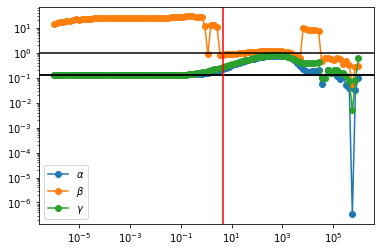

In [90]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

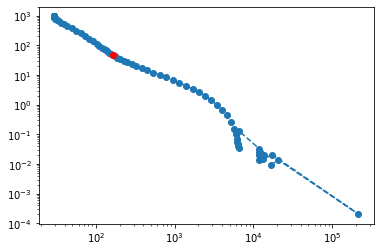

In [91]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

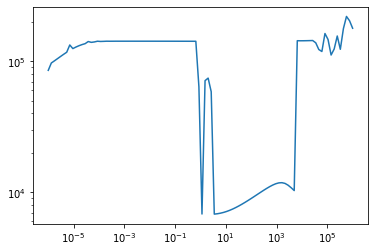

In [92]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

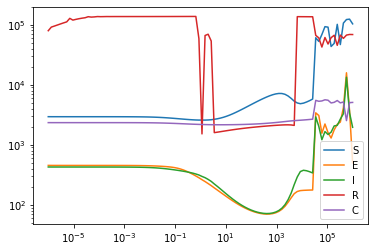

In [93]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [94]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

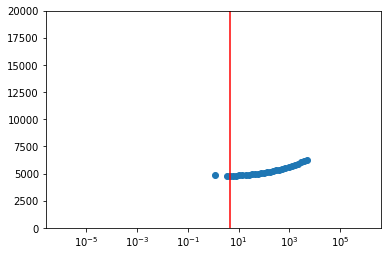

In [95]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [96]:
rinf(sols[idx])

4791.909152108969

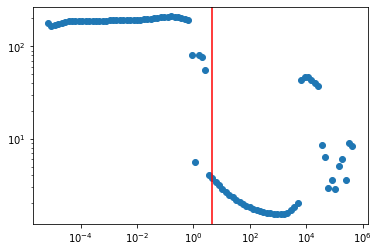

In [97]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [98]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(3617.41), DM(359.744), DM(243.188), DM(379.256), DM(1080.3)]

In [99]:
getx(sols[idx]['x'])[0][0]

DM(4911.81)

In [100]:
getp(sols[idx]['x'])

(DM(0.225271), DM(0.838246), DM(0.27364))

In [101]:
r0(sols[idx])

3.721062378954447

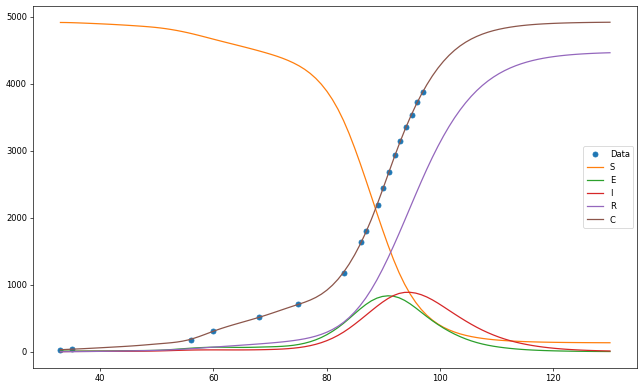

In [102]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

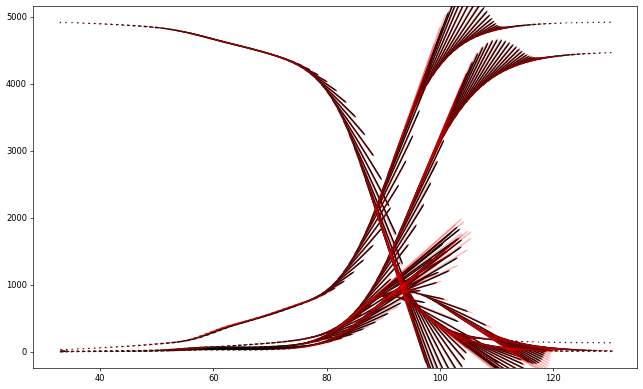

In [103]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

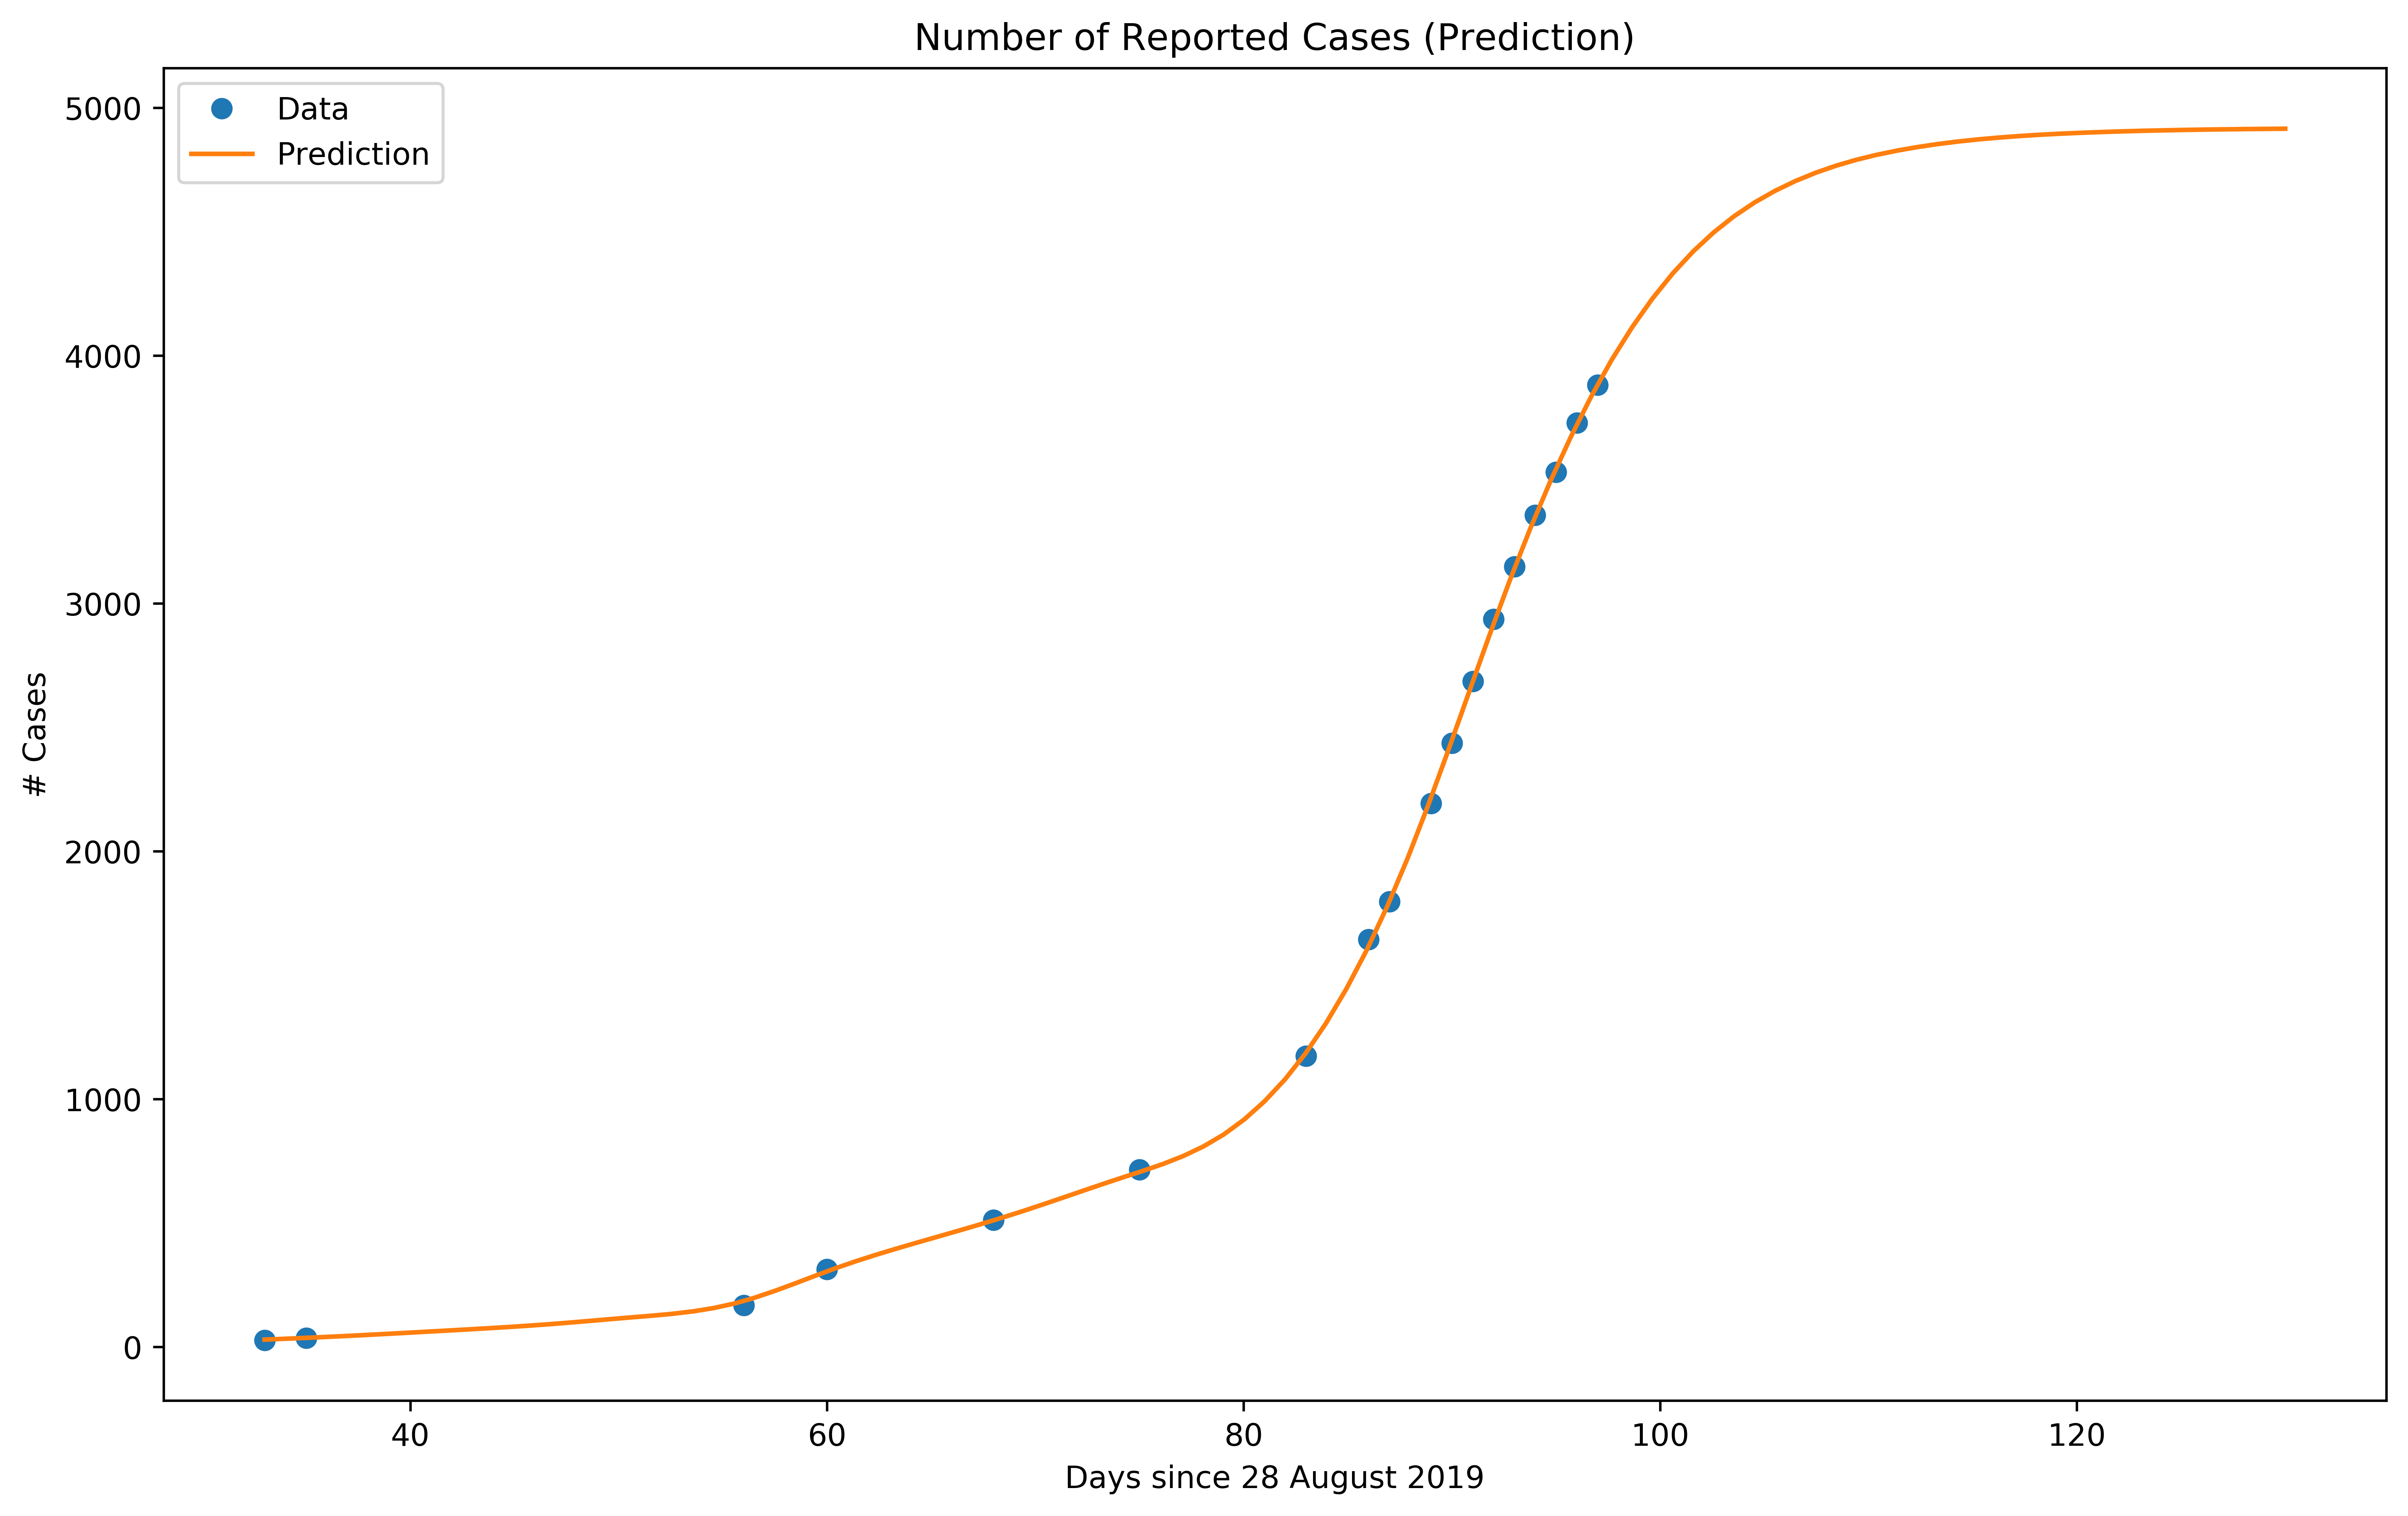

In [104]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=600)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

In [105]:
fsvals[idx]

array([163.0319337 ,  47.52794973])

In [106]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

DM(12.7198)

In [107]:
getp(sols[idx]['x'])

(DM(0.225271), DM(0.838246), DM(0.27364))

In [108]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [109]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-2, 1, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  30  4.7627744e+02 0.00e+00 1.13e-01  -3.8 1.52e+04    -  8.02e-01 2.50e-01f  3
  40  4.7595279e+02 0.00e+00 4.48e-04  -5.7 2.42e+01 -12.4 1.00e+00 1.00e+00f  1
  50  4.7592345e+02 0.00e+00 6.52e-05  -8.6 6.16e+05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   2.5500275374088072e-01    4.7592225848639038e+02
Dual infeasibility......:   2.0908831843340441e-10    3.9023023583919247e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596785001e-09    4.6768721677537047e-06
Overall NLP error.......:   2.5059035596785001e-09    4.6768721677537047e-06


Number of objective function evaluations             = 121
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  10  4.6658760e+02 0.00e+00 1.21e-01  -2.5 1.67e+01  -7.8 1.00e+00 1.00e+00f  1
  20  4.6587973e+02 0.00e+00 3.91e-02  -5.7 3.90e+04    -  1.00e+00 2.50e-01f  3
  30  4.6584413e+02 0.00e+00 4.20e-05  -5.7 3.51e-01 -11.6 1.00e+00 1.00e+00f  1
  40  4.6584104e+02 0.00e+00 1.88e-07  -8.6 2.60e-03 -14.0 1.00e+00 1.25e-01f  4

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   2.7327069969203993e-01    4.6584103901583154e+02
Dual infeasibility......:   2.4962242963818673e-11    4.2552813790631373e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.2717814944315983e-06
Overall NLP error.......:   2.5059035596800618e-09    4.2717814944315983e-06


Number of objective function evaluations             = 94
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of ineq

CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 520  1.8141871e+02 0.00e+00 1.70e+12  -8.6 2.15e-10  14.3 1.00e+00 1.42e-14f 47
 530  1.8207481e+02 0.00e+00 6.33e+11  -8.6 6.32e-13  18.6 1.00e+00 1.00e+00f  1
 540  1.8156850e+02 0.00e+00 6.37e+11  -8.6 8.34e-11  13.8 1.00e+00 3.91e-03f  9
 550  1.8156850e+02 0.00e+00 6.37e+11  -8.6 1.69e-11  14.4 1.00e+00 9.09e-13f 41
 560  1.8202349e+02 0.00e+00 1.92e+12  -8.6 4.24e-09   9.7 1.00e+00 1.00e+00S 21
 570  1.8150953e+02 0.00e+00 3.98e+10  -8.6 5.08e-08   9.4 1.00e+00 4.77e-07f 22
 580  1.8157894e+02 0.00e+00 2.01e+08  -8.6 3.38e-09   9.1 1.00e+00 1.00e+00f  1
 590  1.8156674e+02 0.00e+00 2.18e+08  -8.6 7.77e-08   8.0 1.00e+00 2.27e-13f 43
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8163009e+02 0.00e+00 6.12e+08  -8.6 1.29e-07  10.4 1.00e+00 6.25e-02f  5
 610  1.8153297e+02 0.00e+00 1.95e+09  -8.6 1.18e-10  12.9 1.00e+00 5.00e-01f  2
 620  1.8158165e+02 0.00e+00 2.84e+10  -8.6 1.37e-09  10.8 1.00e+00 1.00e+00w  1
 630  1.8150807e+02 0.00e+00

.../casadi/core/oracle_function.cpp:265]


 670  1.8153904e+02 0.00e+00 9.53e+08  -8.6 1.29e-09  10.5 1.00e+00 4.88e-04f 12
 680  1.8148982e+02 0.00e+00 9.31e+10  -8.6 3.09e-13  18.5 1.00e+00 6.25e-02f  5
 690  1.8144594e+02 0.00e+00 1.34e+10  -8.6 3.38e-11  13.7 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8173730e+02 0.00e+00 2.28e+11  -8.6 6.60e-10  12.6 1.00e+00 1.00e+00w  1
 710  1.8143969e+02 0.00e+00 7.57e+10  -8.6 1.62e-09  12.3 1.00e+00 2.84e-14f 46
 720  1.8143969e+02 0.00e+00 7.57e+10  -8.6 8.31e-09  12.1 1.00e+00 7.11e-15f 48
 730  1.8152980e+02 0.00e+00 6.17e+09  -8.6 1.37e-10  10.9 1.00e+00 5.00e-01f  2
 740  1.8168807e+02 0.00e+00 3.58e+09  -8.6 7.89e-10  12.5 1.00e+00 1.00e+00w  1
 750  1.8148822e+02 0.00e+00 7.53e+10  -8.6 2.19e-09  12.2 1.00e+00 2.84e-14f 46
 760  1.8147844e+02 0.00e+00 5.19e+11  -8.6 5.46e-10  12.9 1.00e+00 1.42e-14f 47
 770  1.8183133e+02 0.00e+00 1.43e+12  -8.6 1.61e-07  12.6 1.00e+00 1.00e+00S 21
 780  1.8151563e+02 0.00e+00

CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 810  1.8154273e+02 0.00e+00 7.56e+08  -8.6 4.24e-08   7.1 1.00e+00 3.05e-05f 16
 820  2.0181454e+02 0.00e+00 1.07e+08  -8.6 1.03e-06   7.7 1.00e+00 1.00e+00w  1
 830  1.8154096e+02 0.00e+00 8.09e+08  -8.6 2.54e-06   5.7 1.00e+00 2.84e-14f 46
 840  1.8187253e+02 0.00e+00 6.56e+07  -8.6 6.70e-09  10.8 1.00e+00 1.00e+00f  1
 850  1.8165448e+02 0.00e+00 6.93e+08  -8.6 1.97e-07   6.9 1.00e+00 4.55e-13f 42
 860  1.8165448e+02 0.00e+00 6.89e+08  -8.6 1.08e-12  15.0 1.00e+00 1.19e-07f 24
 870  1.8167044e+02 0.00e+00 5.65e+08  -8.6 8.39e-11  10.2 1.00e+00 1.00e+00w  1
 880  1.8165323e+02 0.00e+00 6.78e+09  -8.6 7.97e-07   6.4 1.00e+00 1.00e+00f  1
 890  1.8164739e+02 0.00e+00 4.73e+09  -8.6 1.62e-07   7.9 1.00e+00 2.27e-13f 43
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.8162428e+02 0.00e+00 4.68e+10  -8.6 1.70e-06   8.6 1.00e+00 8.88e-16f 51
 910  1.9154488e+02 0.00e+00 1.59e+13  -8.6 9.62e-12  17.7 1.00e+00 1.25e-01f  4
 920  1.8799396e+02 0.00e+00

CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 950  1.8629247e+02 0.00e+00 3.61e+13  -8.6 1.66e-10  14.0 1.00e+00 1.42e-14f 47
 960  1.8629247e+02 0.00e+00 3.61e+13  -8.6 3.63e-10  13.7 1.00e+00 1.42e-14f 47
 970  3.7348535e+02 0.00e+00 4.13e+13  -8.6 6.70e-10  17.1 1.00e+00 1.00e+00w  1
 980  1.8728361e+02 0.00e+00 4.22e+13  -8.6 2.68e-11  13.2 1.00e+00 1.42e-14f 47
 990  1.8535343e+02 0.00e+00 3.56e+13  -8.6 1.16e-11  14.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.8907565e+02 0.00e+00 2.48e+13  -8.6 1.71e-10  10.0 1.00e+00 1.00e+00w  1
1010  1.8290635e+02 0.00e+00 4.80e+12  -8.6 1.87e-07   6.1 1.00e+00 1.00e+00f  1
1020  1.8215196e+02 0.00e+00 2.04e+12  -8.6 2.25e-07   5.9 1.00e+00 5.68e-14f 45
1030  1.8194059e+02 0.00e+00 1.57e+10  -8.6 9.95e-08   6.5 1.00e+00 3.64e-12f 39
1040  1.8699055e+02 0.00e+00 1.71e+13  -8.6 8.97e-09   7.2 1.00e+00 1.00e+00w  1
1050  1.8342428e+02 0.00e+00 1.41e+13  -8.6 1.37e-08   6.9 1.00e+00 1.25e-01f  4
1060  1.8697307e+02 0.00e+00

CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1100  1.8325528e+02 0.00e+00 3.11e+12  -8.6 3.03e-08   6.6 1.00e+00 3.81e-06f 19
1110  1.8658187e+02 0.00e+00 2.08e+13  -8.6 8.48e-09   7.2 1.00e+00 1.00e+00w  1
1120  1.8325512e+02 0.00e+00 3.05e+12  -8.6 1.29e-08   6.9 1.00e+00 7.63e-06f 18
1130  1.8293160e+02 0.00e+00 2.43e+13  -8.6 4.93e-12  17.2 1.00e+00 2.84e-14f 46
1140  1.8293160e+02 0.00e+00 2.43e+13  -8.6 2.97e-11  12.4 1.00e+00 3.55e-15f 49
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1147

                                   (scaled)                 (unscaled)
Objective...............:   1.7454864736197120e-01    2.8910555744652527e+02
Dual infeasibility......:   4.7772860330344900e+14    7.9126361764224346e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.1505371509763772e-06
Overall NLP error.......:   4.7772860330344900e+14    7.9126361764224346e+17


Number of objective function

CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  40  4.5192280e+02 0.00e+00 1.11e-02  -8.6 1.18e+01  -7.6 1.00e+00 1.00e+00f  1
  50  4.2312802e+02 0.00e+00 5.83e+00  -8.6 3.28e+02  -7.9 1.00e+00 2.50e-01f  3
  60  3.1432698e+02 0.00e+00 8.00e-01  -8.6 1.28e+01  -5.9 1.00e+00 1.00e+00f  1
  70  2.2888324e+02 0.00e+00 3.26e+01  -8.6 3.57e+00  -4.7 1.00e+00 1.00e+00f  1
  80  2.0094711e+02 0.00e+00 4.30e+01  -8.6 4.29e+00  -5.4 1.00e+00 1.00e+00f  1
  90  1.9131675e+02 0.00e+00 4.30e+02  -8.6 2.48e+02    -  1.00e+00 3.94e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9059465e+02 0.00e+00 4.48e+01  -8.6 3.73e-01  -4.5 1.00e+00 1.00e+00f  1
 110  1.8783949e+02 0.00e+00 4.67e+03  -8.6 1.54e-01  -2.9 1.00e+00 1.00e+00f  1
 120  1.8606621e+02 0.00e+00 2.97e+01  -8.6 8.10e-02  -4.0 1.00e+00 1.00e+00f  1
 130  1.8596998e+02 0.00e+00 3.62e+02  -8.6 3.01e-03  -2.5 1.00e+00 1.00e+00f  1
 140  1.8595614e+02 0.00e+00 5.30e+04  -8.6 4.31e-01  -3.6 1.25e-05 6.25e-02f  5
 150  1.8595494e+02 0.00e+00

CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 370  1.8759299e+02 0.00e+00 5.52e+10  -8.6 2.55e-11  13.9 1.00e+00 1.56e-02f  7
 380  1.8795758e+02 0.00e+00 7.17e+11  -8.6 9.93e-10  12.7 1.00e+00 1.00e+00w  1
 390  1.8763022e+02 0.00e+00 1.35e+12  -8.6 3.59e-10   9.7 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.8807292e+02 0.00e+00 7.84e+11  -8.6 1.10e-11  15.3 1.00e+00 4.55e-13f 42
 410  1.8769885e+02 0.00e+00 1.11e+12  -8.6 1.09e-10  10.5 1.00e+00 9.77e-04f 11
 420  1.8778369e+02 0.00e+00 6.72e+11  -8.6 1.79e-09   5.7 1.00e+00 1.00e+00w  1
 430  1.8769731e+02 0.00e+00 1.12e+12  -8.6 1.81e-11  14.2 1.00e+00 4.55e-13f 42
 440  1.8769731e+02 0.00e+00 1.12e+12  -8.6 7.74e-11  12.1 1.00e+00 5.68e-14f 45
 450  1.8776388e+02 0.00e+00 1.79e+11  -8.6 2.96e-09  11.9 1.00e+00 1.56e-02f  7
 460  1.8813240e+02 0.00e+00 2.89e+12  -8.6 3.93e-10   7.1 1.00e+00 1.00e+00w  1
 470  1.8746817e+02 0.00e+00 1.88e+12  -8.6 5.58e-09   5.9 1.00e+00 1.95e-03f 10
 480  1.8742820e+02 0.00e+00

CasADi - 2019-12-03 13:51:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9325336e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

CasADi - 2019-12-03 13:51:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 410  2.8588263e+05 0.00e+00 1.51e+13  -8.6 7.61e-07  10.8 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 410

                                   (scaled)                 (unscaled)
Objective...............:   2.0752755690728989e+02    2.8588262972297234e+05
Dual infeasibility......:   1.5060045945308908e+13    2.0746187170299888e+16
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.4520442015010698e-06
Overall NLP error.......:   1.5060045945308908e+13    2.0746187170299888e+16


Number of objective function evaluations             = 4224
Number of objective gradient evaluations             = 411
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number

CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


 720  1.9107069e+02 0.00e+00 8.53e+13  -8.6 2.18e-09   9.3 1.00e+00 8.88e-16f 51
 730  1.8871311e+02 0.00e+00 1.46e+14  -8.6 2.26e-08   7.2 1.00e+00 1.78e-15f 50
 740  2.1096278e+02 0.00e+00 3.15e+14  -8.6 7.68e-10   7.8 1.00e+00 1.00e+00S 21
 750  1.8150546e+02 0.00e+00 4.25e+13  -8.6 3.18e-09   7.6 1.00e+00 1.25e-01f  4
 760  1.8150546e+02 0.00e+00 4.25e+13  -8.6 3.81e-09   7.3 1.00e+00 1.42e-14f 47
 770  1.8150546e+02 0.00e+00 4.25e+13  -8.6 3.81e-09   8.0 1.00e+00 2.84e-14f 46
 780  1.7858400e+02 0.00e+00 2.45e+13  -8.6 3.92e-09   7.7 1.00e+00 2.84e-14f 46


2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:51:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

 790  3.0705642e+02 0.00e+00 8.79e+13  -8.6 7.72e-07   7.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 791

                                   (scaled)                 (unscaled)
Objective...............:   1.2155823153133510e+02    1.5555276290331988e+05
Dual infeasibility......:   3.9377587304041912e+16    5.0389779650845303e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.2066954032398523e-06
Overall NLP error.......:   3.9377587304041912e+16    5.0389779650845303e+19


Number of objective function evaluations             = 13923
Number of objective gradient evaluations             = 792
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

 420  1.7923740e+02 0.00e+00 9.85e+03  -5.7 1.10e-02  -1.9 1.00e+00 5.00e-01f  2
 430  1.7904633e+02 0.00e+00 2.01e+03  -5.7 1.39e-02  -3.1 1.00e+00 1.00e+00f  1
 440  1.7843411e+02 0.00e+00 1.20e+04  -5.7 2.60e-03  -1.5 1.00e+00 1.00e+00f  1
 450  1.7836917e+02 0.00e+00 5.56e+01  -5.7 3.68e-02  -3.6 1.00e+00 1.00e+00f  1
 460  1.7723191e+02 0.00e+00 4.37e+03  -5.7 6.46e-03  -2.9 1.00e+00 1.00e+00f  1
 470  1.7717555e+02 0.00e+00 4.77e+03  -5.7 1.13e-02  -3.1 1.00e+00 1.00e+00f  1
 480  1.7711440e+02 0.00e+00 7.10e+02  -5.7 2.04e-02  -3.4 1.00e+00 5.00e-01f  2
 490  1.7700129e+02 0.00e+00 6.05e+03  -5.7 9.79e-02  -2.7 1.00e+00 2.16e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7692367e+02 0.00e+00 5.09e+03  -5.7 3.13e-01  -3.9 1.00e+00 3.13e-02f  3
 510  1.7685275e+02 0.00e+00 1.32e+03  -5.7 1.24e-01  -4.1 1.00e+00 1.00e+00f  1
 520  1.7681710e+02 0.00e+00 5.75e+02  -5.7 2.25e-01  -4.4 1.00e+00 1.00e+00f  1
 530  1.7674809e+02 0.00e+00

1510  1.6981624e+02 0.00e+00 4.65e+01  -5.7 6.64e-03  -3.3 1.00e+00 1.00e+00f  1
1520  1.6978006e+02 0.00e+00 7.45e+02  -5.7 4.70e-02  -4.9 1.00e+00 1.00e+00f  1
1530  1.6976880e+02 0.00e+00 6.79e+02  -5.7 2.71e-02  -4.6 1.00e+00 1.00e+00f  1
1540  1.6972535e+02 0.00e+00 1.16e+05  -5.7 7.67e+01    -  1.00e+00 3.57e-02f  4
1550  1.6970793e+02 0.00e+00 9.32e+04  -5.7 8.46e+01    -  1.00e+00 2.55e-02f  4
1560  1.6969467e+02 0.00e+00 3.49e+03  -5.7 5.56e-02  -5.2 1.00e+00 1.00e+00f  1
1570  1.6966323e+02 0.00e+00 4.43e+01  -5.7 1.87e-03  -3.6 1.00e+00 1.00e+00f  1
1580  1.6964650e+02 0.00e+00 4.85e+03  -5.7 2.36e-01  -5.6 1.00e+00 2.50e-01f  3
1590  1.6964063e+02 0.00e+00 1.81e+05  -5.7 3.64e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.6962523e+02 0.00e+00 9.19e+02  -5.7 2.10e-02  -5.2 1.00e+00 1.00e+00f  1
1610  1.6961943e+02 0.00e+00 1.34e+02  -5.7 5.61e-01  -5.9 1.00e+00 6.25e-02f  5
1620  1.6961632e+02 0.00e+00

 110  1.8672840e+02 0.00e+00 5.93e+01  -5.7 1.80e-01  -4.0 1.00e+00 1.00e+00f  1
 120  1.8611274e+02 0.00e+00 5.54e+04  -5.7 2.56e+00  -5.2 1.00e+00 1.00e+00f  1
 130  1.8583326e+02 0.00e+00 5.28e+03  -5.7 8.72e-02  -3.6 1.00e+00 5.00e-01f  2
 140  1.8548319e+02 0.00e+00 7.11e+03  -5.7 9.60e-01  -4.8 1.00e+00 1.00e+00f  1
 150  1.8503835e+02 0.00e+00 1.68e+04  -5.7 2.30e-01  -4.1 1.00e+00 1.00e+00f  1
 160  1.8469457e+02 0.00e+00 6.99e+02  -5.7 4.71e-02  -3.5 1.00e+00 1.00e+00f  1
 170  1.8442754e+02 0.00e+00 9.76e+02  -5.7 8.50e-02  -3.7 1.00e+00 1.00e+00f  1
 180  1.8413684e+02 0.00e+00 8.46e+03  -5.7 1.84e-02  -3.1 1.00e+00 1.00e+00f  1
 190  1.8395196e+02 0.00e+00 2.93e+03  -5.7 2.72e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8373462e+02 0.00e+00 5.99e+00  -5.7 1.11e-03  -1.8 1.00e+00 1.00e+00f  1
 210  1.8364951e+02 0.00e+00 5.47e+02  -5.7 2.88e-03  -2.0 1.00e+00 1.00e+00f  1
 220  1.8355302e+02 0.00e+00

1140  1.7412206e+02 0.00e+00 3.82e-02  -5.7 2.51e-05   0.5 1.00e+00 1.00e+00f  1
1150  1.7399570e+02 0.00e+00 1.20e+04  -5.7 7.60e-03  -1.1 1.00e+00 5.00e-01f  2
1160  1.7392616e+02 0.00e+00 5.35e+02  -5.7 3.10e-02  -3.6 1.00e+00 1.00e+00f  1
1170  1.7388354e+02 0.00e+00 1.62e+01  -5.7 7.22e-03  -3.0 1.00e+00 1.00e+00f  1
1180  1.7302715e+02 0.00e+00 4.16e+02  -5.7 2.69e-03  -2.3 1.00e+00 1.00e+00f  1
1190  1.7294397e+02 0.00e+00 6.86e+03  -5.7 1.63e-02  -2.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.7294045e+02 0.00e+00 3.86e-02  -5.7 7.45e-07   4.7 1.00e+00 1.00e+00f  1
1210  1.7262054e+02 0.00e+00 3.51e-01  -5.7 1.73e-04   0.4 1.00e+00 1.00e+00f  1
1220  1.7149766e+02 0.00e+00 5.18e+02  -5.7 6.25e-02  -2.1 1.00e+00 1.00e+00f  1
1230  1.7137984e+02 0.00e+00 9.56e-01  -5.7 3.75e-03  -1.9 1.00e+00 1.00e+00f  1
1240  1.7098001e+02 0.00e+00 3.75e-02  -5.7 3.59e-06   2.2 1.00e+00 1.00e+00f  1
1250  1.7097785e+02 0.00e+00

2120  1.6930619e+02 0.00e+00 2.47e-03  -5.7 6.77e-07    -  1.00e+00 1.86e-09f 30
2130  1.6930619e+02 0.00e+00 4.88e-03  -5.7 1.95e-05    -  1.00e+00 9.31e-10f 31
2140  1.6930619e+02 0.00e+00 4.56e-04  -5.7 7.18e-06    -  1.00e+00 1.00e+00S 21
2150  1.6930619e+02 0.00e+00 6.96e-03  -5.7 1.73e-05    -  1.00e+00 9.31e-10f 31
2160  1.6930619e+02 0.00e+00 6.94e-03  -5.7 1.59e-05    -  1.00e+00 9.31e-10f 31
2170  1.6930619e+02 0.00e+00 6.92e-03  -5.7 1.73e-05    -  1.00e+00 9.31e-10f 31
2180  1.6930619e+02 0.00e+00 7.30e-03  -5.7 9.82e-06    -  1.00e+00 1.00e+00w  1
2190  1.6930619e+02 0.00e+00 6.87e-03  -5.7 1.73e-05    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.6930619e+02 0.00e+00 6.84e-03  -5.7 1.58e-05    -  1.00e+00 9.31e-10f 31
2210  1.6930619e+02 0.00e+00 6.82e-03  -5.7 1.63e-05    -  1.00e+00 9.31e-10f 31
2220  1.6930619e+02 0.00e+00 6.80e-03  -5.7 1.02e-06    -  1.00e+00 9.31e-10f 30
2230  1.6930619e+02 0.00e+00

 170  1.8327375e+02 0.00e+00 2.98e+04  -5.7 7.04e-01  -4.6 1.00e+00 1.00e+00f  1
 180  1.8319872e+02 0.00e+00 1.83e+02  -5.7 1.56e-01  -3.9 1.00e+00 1.00e+00f  1
 190  1.8299808e+02 0.00e+00 3.27e+04  -5.7 3.08e-01  -4.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8294498e+02 0.00e+00 1.57e+03  -5.7 7.66e-03  -2.6 1.00e+00 1.00e+00f  1
 210  1.8284262e+02 0.00e+00 3.86e+02  -5.7 1.11e-01  -3.8 1.00e+00 1.00e+00f  1
 220  1.8270611e+02 0.00e+00 1.19e+02  -5.7 1.97e-01  -4.1 1.00e+00 1.00e+00f  1
 230  1.8254962e+02 0.00e+00 2.10e+03  -5.7 5.74e-03  -2.5 1.00e+00 1.00e+00f  1
 240  1.8244935e+02 0.00e+00 6.68e+02  -5.7 7.88e-02  -3.7 1.00e+00 1.00e+00f  1
 250  1.8230646e+02 0.00e+00 9.52e+03  -5.7 1.53e-01  -3.9 1.00e+00 5.00e-01f  2
 260  1.8219336e+02 0.00e+00 6.44e+02  -5.7 2.48e-01  -4.2 1.00e+00 1.00e+00f  1
 270  1.8209999e+02 0.00e+00 1.63e+02  -5.7 7.12e-03  -2.6 1.00e+00 1.00e+00f  1
 280  1.8201585e+02 0.00e+00

1250  1.7484424e+02 0.00e+00 1.84e+04  -5.7 1.72e-01  -4.2 1.00e+00 1.00e+00f  1
1260  1.7481316e+02 0.00e+00 6.85e+02  -5.7 4.75e-03  -2.7 1.00e+00 1.00e+00f  1
1270  1.7479886e+02 0.00e+00 2.05e-02  -5.7 6.73e-02  -3.8 1.00e+00 1.00e+00f  1
1280  1.7475942e+02 0.00e+00 5.64e+02  -5.7 4.55e-02  -3.6 1.00e+00 1.00e+00f  1
1290  1.7472374e+02 0.00e+00 7.68e+03  -5.7 4.50e-03  -2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7469799e+02 0.00e+00 4.95e+03  -5.7 2.45e-03  -2.4 1.00e+00 1.00e+00f  1
1310  1.7466798e+02 0.00e+00 4.31e+03  -5.7 2.63e-01  -4.4 1.00e+00 1.00e+00f  1
1320  1.7459374e+02 0.00e+00 9.14e+01  -5.7 5.90e-02  -3.8 1.00e+00 1.00e+00f  1
1330  1.7456371e+02 0.00e+00 2.14e+03  -5.7 1.73e-03  -2.2 1.00e+00 1.00e+00f  1
1340  1.7452905e+02 0.00e+00 5.38e+03  -5.7 1.40e-03  -1.6 1.00e+00 5.00e-01f  2
1350  1.7448160e+02 0.00e+00 2.46e+02  -5.7 5.35e-03  -2.7 1.00e+00 1.00e+00f  1
1360  1.7444307e+02 0.00e+00

2260  1.6960168e+02 0.00e+00 1.91e-01  -5.7 3.21e-04    -  1.00e+00 5.82e-11f 35
2270  1.6960168e+02 0.00e+00 1.91e-01  -5.7 3.52e-04    -  1.00e+00 5.82e-11f 35
2280  1.6960168e+02 0.00e+00 2.77e-03  -5.7 5.73e-06    -  1.00e+00 3.91e-03f  9
2290  1.6960168e+02 0.00e+00 1.29e-02  -5.7 1.86e-05    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.6960168e+02 0.00e+00 1.25e-02  -5.7 1.38e-05    -  1.00e+00 2.98e-08f 26
2310  1.6960168e+02 0.00e+00 3.72e-03  -5.7 4.05e-07    -  1.00e+00 1.00e+00F  1
2320  1.6960168e+02 0.00e+00 7.64e-03  -5.7 1.39e-05    -  1.00e+00 9.31e-10f 31
2330  1.6960168e+02 0.00e+00 7.61e-03  -5.7 1.54e-05    -  1.00e+00 9.31e-10f 31
2340  1.6960168e+02 0.00e+00 1.43e-03  -5.7 2.09e-05    -  1.00e+00 9.31e-10f 31
2350  1.6960168e+02 0.00e+00 1.39e-03  -5.7 2.58e-06    -  1.00e+00 9.31e-10f 30
2360  1.6960168e+02 0.00e+00 2.14e-03  -5.7 2.04e-05    -  1.00e+00 1.00e+00w  1
2370  1.6960168e+02 0.00e+00

 180  1.8349264e+02 0.00e+00 1.89e+04  -8.6 1.66e-03   0.1 1.00e+00 5.00e-01f  2
 190  1.8335901e+02 0.00e+00 9.35e+04  -8.6 1.13e+00  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8326605e+02 0.00e+00 1.82e+05  -8.6 3.92e-02  -1.3 1.00e+00 2.90e-02f  3
 210  1.8321008e+02 0.00e+00 3.99e+02  -8.6 8.97e-04  -1.6 1.00e+00 1.00e+00f  1
 220  1.8310034e+02 0.00e+00 1.96e+05  -8.6 1.33e+00  -4.5 1.00e+00 6.78e-02f  2
 230  1.8304756e+02 0.00e+00 3.40e+05  -8.6 3.27e-02  -2.1 1.00e+00 6.26e-02f  3
 240  1.8300794e+02 0.00e+00 4.98e+03  -8.6 1.92e-03  -1.9 1.00e+00 1.00e+00f  1
 250  1.8299940e+02 0.00e+00 9.90e+05  -8.6 1.83e-04  -0.4 1.00e+00 5.00e-01f  2
 260  1.8299825e+02 0.00e+00 1.15e+08  -8.6 3.51e-06   4.8 1.00e+00 3.81e-06f 19
 270  1.8299818e+02 0.00e+00 1.85e+08  -8.6 5.93e-07   5.5 1.00e+00 4.55e-13f 42
 280  1.8300011e+02 0.00e+00 1.52e+08  -8.6 2.20e-07   9.7 1.00e+00 1.00e+00S 21
 290  1.8299924e+02 0.00e+00

CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 460  1.8288276e+02 0.00e+00 2.04e+11  -8.6 1.64e-08  13.8 1.00e+00 1.78e-15f 50
 470  1.8288276e+02 0.00e+00 2.04e+11  -8.6 1.15e-09  14.5 1.00e+00 2.84e-14f 46
 480  1.8392381e+02 0.00e+00 3.36e+09  -8.6 9.02e-10  12.4 1.00e+00 1.00e+00S 21
 490  1.8296085e+02 0.00e+00 4.99e+11  -8.6 1.51e-09  13.1 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.8294804e+02 0.00e+00 8.78e+11  -8.6 2.68e-10  13.7 1.00e+00 2.84e-14f 46
 510  1.8310836e+02 0.00e+00 8.63e+10  -8.6 5.24e-10  13.4 1.00e+00 1.00e+00S 21
 520  1.8294186e+02 0.00e+00 7.22e+08  -8.6 1.32e-09  13.2 1.00e+00 7.28e-12f 38
 530  1.8663915e+02 0.00e+00 1.64e+13  -8.6 1.28e-11  17.6 1.00e+00 5.00e-01f  2
 540  1.8401316e+02 0.00e+00 3.11e+13  -8.6 6.60e-11  12.8 1.00e+00 3.55e-15f 49
 550  1.8428815e+02 0.00e+00 4.78e+13  -8.6 1.96e-11  16.4 1.00e+00 7.11e-15f 48
 560  1.8438768e+02 0.00e+00 2.38e+13  -8.6 4.17e-11  11.6 1.00e+00 1.00e+00w  1
 570  1.8320468e+02 0.00e+00

CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 710  1.8296568e+02 0.00e+00 2.69e+12  -8.6 3.75e-08   5.9 1.00e+00 5.00e-01f  2
 720  2.0549360e+02 0.00e+00 2.61e+12  -8.6 3.03e-08   7.4 1.00e+00 1.00e+00w  1
 730  1.8410291e+02 0.00e+00 7.31e+12  -8.6 5.74e-11  13.0 1.00e+00 1.42e-14f 47
 740  1.8410291e+02 0.00e+00 7.31e+12  -8.6 7.55e-10   8.2 1.00e+00 1.42e-14f 47
 750  1.8375378e+02 0.00e+00 3.99e+13  -8.6 1.74e-10  13.5 1.00e+00 8.88e-16f 51
 760  2.4003070e+02 0.00e+00 4.67e+13  -8.6 1.62e-11  19.0 1.00e+00 5.00e-01f  2
 770  2.3955570e+02 0.00e+00 7.23e+14  -8.6 5.39e-11  14.3 1.00e+00 1.00e+00w  1
 780  1.8861441e+02 0.00e+00 2.76e+12  -8.6 2.88e-10   9.5 1.00e+00 1.14e-13f 44
 790  1.8599809e+02 0.00e+00 3.14e+13  -8.6 1.03e-08   7.4 1.00e+00 1.78e-15f 50
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.8599809e+02 0.00e+00 3.14e+13  -8.6 1.86e-08   7.2 1.00e+00 1.78e-15f 50
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 803

 

CasADi - 2019-12-03 13:52:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  40  2.9530225e+02 0.00e+00 2.02e+01  -5.7 1.85e+01  -5.4 1.00e+00 1.00e+00f  1
  50  2.1434647e+02 0.00e+00 6.42e+01  -5.7 2.30e+00  -3.8 1.00e+00 1.00e+00f  1
  60  1.9114977e+02 0.00e+00 3.03e+02  -5.7 7.57e+00  -5.0 1.00e+00 1.00e+00f  1
  70  1.8854384e+02 0.00e+00 1.21e+02  -5.7 1.02e+00  -4.4 1.00e+00 1.00e+00f  1
  80  1.8722142e+02 0.00e+00 2.33e+02  -5.7 4.94e+00  -4.6 1.00e+00 4.49e-02f  4
  90  1.8624848e+02 0.00e+00 3.75e+01  -5.7 5.20e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8595821e+02 0.00e+00 4.04e+01  -5.7 8.94e-02  -3.3 1.00e+00 1.00e+00f  1
 110  1.8578108e+02 0.00e+00 6.57e+03  -5.7 1.74e+00  -4.5 2.47e-01 2.50e-01f  3
 120  1.8563624e+02 0.00e+00 8.62e+04  -5.7 9.69e-03  -1.1 1.00e+00 1.69e-01f  3
 130  1.8555926e+02 0.00e+00 6.79e+01  -5.7 6.40e-02  -3.2 1.00e+00 1.00e+00f  1
 140  1.8540491e+02 0.00e+00 5.87e+03  -5.7 1.57e-02  -2.5 1.00e+00 1.00e+00f  1
 150  1.8528082e+02 0.00e+00

 980  1.8015922e+02 0.00e+00 1.12e+04  -5.7 1.27e-01  -3.6 1.00e+00 1.00e+00f  1
 990  1.8014467e+02 0.00e+00 1.14e+02  -5.7 3.66e-03  -2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.8010761e+02 0.00e+00 1.26e+05  -5.7 4.16e-01  -4.1 1.00e+00 1.00e+00f  1
1010  1.8008566e+02 0.00e+00 6.07e+04  -5.7 7.49e-04  -0.8 1.00e+00 1.00e+00f  1
1020  1.8005170e+02 0.00e+00 1.04e+04  -5.7 1.83e-01  -3.7 1.00e+00 1.00e+00f  1
1030  1.7977070e+02 0.00e+00 1.69e+02  -5.7 4.06e-03  -2.1 1.00e+00 1.00e+00f  1
1040  1.7973173e+02 0.00e+00 1.45e+03  -5.7 3.71e-03  -1.9 1.00e+00 1.00e+00f  1
1050  1.7953943e+02 0.00e+00 1.86e+02  -5.7 3.78e-03  -2.1 1.00e+00 1.00e+00f  1
1060  1.7949132e+02 0.00e+00 1.59e+04  -5.7 4.36e-01  -4.2 1.00e+00 1.00e+00f  1
1070  1.7947567e+02 0.00e+00 8.17e+02  -5.7 1.23e-02  -2.6 1.00e+00 1.00e+00f  1
1080  1.7944324e+02 0.00e+00 1.30e+04  -5.7 1.78e-01  -3.8 1.00e+00 1.00e+00f  1
1090  1.7927755e+02 0.00e+00

2020  1.7358691e+02 0.00e+00 4.82e+04  -5.7 4.90e-01  -5.7 1.00e+00 1.00e+00f  1
2030  1.7358123e+02 0.00e+00 4.31e+03  -5.7 1.34e-02  -4.1 1.00e+00 1.00e+00f  1
2040  1.7356912e+02 0.00e+00 4.21e+05  -5.7 1.15e+00  -6.2 1.00e+00 1.00e+00f  1
2050  1.7356440e+02 0.00e+00 5.27e+02  -5.7 6.49e-03  -3.8 1.00e+00 1.00e+00f  1
2060  1.7355608e+02 0.00e+00 4.19e+03  -5.7 5.17e-01  -5.8 1.00e+00 1.00e+00f  1
2070  1.7354682e+02 0.00e+00 2.96e+03  -5.7 1.49e-02  -4.3 1.00e+00 1.00e+00f  1
2080  1.7353931e+02 0.00e+00 6.11e+01  -5.7 8.23e-03  -4.0 1.00e+00 1.00e+00f  1
2090  1.7349493e+02 0.00e+00 8.75e+02  -5.7 1.34e-03  -1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7349390e+02 0.00e+00 9.01e+02  -5.7 1.52e-01  -5.0 1.00e+00 1.00e+00f  1
2110  1.7348945e+02 0.00e+00 3.72e+04  -5.7 5.37e-01  -5.7 1.00e+00 1.00e+00f  1
2120  1.7348732e+02 0.00e+00 5.67e+04  -5.7 8.58e-01  -5.9 1.00e+00 1.00e+00f  1
2130  1.7348501e+02 0.00e+00

 140  1.8784624e+02 0.00e+00 3.85e+05  -3.8 2.45e-03   0.8 1.00e+00 5.00e-01f  2
 150  1.8778961e+02 0.00e+00 1.16e+05  -3.8 5.63e-02  -1.3 1.00e+00 2.38e-01f  3
 160  1.8768442e+02 0.00e+00 4.58e+04  -3.8 1.36e-02  -1.5 1.00e+00 1.00e+00f  1
 170  1.8747800e+02 0.00e+00 1.12e+03  -3.8 2.34e-02  -1.8 1.00e+00 1.00e+00f  1
 180  1.8697416e+02 0.00e+00 3.60e+05  -3.8 2.21e+02    -  1.27e-01 3.12e-02f  6
 190  1.8606321e+02 0.00e+00 1.21e+06  -3.8 5.76e-02  -0.4 1.00e+00 3.79e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8598375e+02 0.00e+00 1.07e+05  -3.8 8.38e-01  -3.3 1.00e+00 5.00e-01f  2
 210  1.8590706e+02 0.00e+00 3.31e+03  -3.8 1.64e-01  -2.7 1.00e+00 1.00e+00f  1
 220  1.8520060e+02 0.00e+00 6.29e+04  -3.8 7.28e-03  -0.7 1.00e+00 1.00e+00f  1
 230  1.8461377e+02 0.00e+00 1.03e+04  -3.8 4.00e-01  -3.2 1.00e+00 1.00e+00f  1
 240  1.8442773e+02 0.00e+00 3.66e+04  -3.8 4.48e-03  -1.1 1.00e+00 1.00e+00f  1
 250  1.8407556e+02 0.00e+00

1070  1.7804922e+02 0.00e+00 2.00e+02  -5.7 3.18e-08   3.0 1.00e+00 1.19e-07f 24
1080  1.7804922e+02 0.00e+00 1.71e+02  -5.7 3.66e-06   0.9 1.00e+00 5.96e-08f 25
1090  1.7804922e+02 0.00e+00 2.56e+01  -5.7 6.61e-06   0.6 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7804922e+02 0.00e+00 1.71e+02  -5.7 1.49e-06   1.3 1.00e+00 3.73e-09f 29
1110  1.7804922e+02 0.00e+00 1.71e+02  -5.7 1.00e-06   1.5 1.00e+00 2.91e-11f 36
1120  1.7804922e+02 0.00e+00 1.71e+02  -5.7 1.81e-06   1.2 1.00e+00 1.46e-11f 37
1130  1.7804922e+02 0.00e+00 1.71e+02  -5.7 2.60e-05   0.0 1.00e+00 3.73e-09f 28
1140  1.7804922e+02 0.00e+00 9.14e+01  -5.7 5.88e-06   0.7 1.00e+00 1.00e+00w  1
1150  1.7804922e+02 0.00e+00 1.71e+02  -5.7 1.32e-06   1.3 1.00e+00 4.66e-10f 32
1160  1.7804922e+02 0.00e+00 1.71e+02  -5.7 2.38e-06   1.1 1.00e+00 2.33e-10f 33
1170  1.7804922e+02 0.00e+00 1.71e+02  -5.7 4.30e-06   0.8 1.00e+00 2.33e-10f 33
1180  1.7804922e+02 0.00e+00

2090  1.7802894e+02 0.00e+00 4.17e+04  -5.7 4.95e-03  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7802867e+02 0.00e+00 1.89e+05  -5.7 7.48e-02  -3.9 1.00e+00 1.00e+00f  1
2110  1.7802834e+02 0.00e+00 3.66e+05  -5.7 1.29e-01  -4.2 1.00e+00 1.00e+00f  1
2120  1.7802827e+02 0.00e+00 1.65e+03  -5.7 3.52e-03  -2.6 1.00e+00 1.00e+00f  1
2130  1.7802799e+02 0.00e+00 2.77e+05  -5.7 5.27e-02  -3.8 1.00e+00 1.00e+00f  1
2140  1.7802783e+02 0.00e+00 3.41e+05  -5.7 9.33e-02  -4.0 1.00e+00 5.00e-01f  2
2150  1.7802766e+02 0.00e+00 1.65e+05  -5.7 1.96e-02  -3.4 1.00e+00 1.00e+00f  1
2160  1.7802752e+02 0.00e+00 3.05e+04  -5.7 4.29e-03  -2.7 1.00e+00 1.00e+00f  1
2170  1.7802734e+02 0.00e+00 4.43e+04  -5.7 1.07e-03  -2.1 1.00e+00 1.00e+00f  1
2180  1.7802715e+02 0.00e+00 3.37e+04  -5.7 1.30e-02  -3.2 1.00e+00 1.00e+00f  1
2190  1.7802700e+02 0.00e+00 2.00e+04  -5.7 2.39e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  20  4.0869457e+02 0.00e+00 6.27e+00  -8.6 1.88e+03  -7.6 1.00e+00 8.76e-02f  4
  30  3.5435549e+02 0.00e+00 1.66e+01  -8.6 4.31e+01  -6.0 1.00e+00 1.00e+00f  1
  40  2.4450170e+02 0.00e+00 1.63e+02  -8.6 2.32e+01  -4.9 1.00e+00 1.00e+00f  1
  50  2.0903624e+02 0.00e+00 2.41e+02  -8.6 2.61e+01  -5.2 1.00e+00 1.46e-01f  3
  60  2.0469559e+02 0.00e+00 1.72e+01  -8.6 8.76e-01  -4.1 1.00e+00 1.00e+00f  1
  70  2.0069326e+02 0.00e+00 2.63e+01  -8.6 9.56e-01  -4.3 1.00e+00 1.00e+00f  1
  80  1.9849716e+02 0.00e+00 6.03e+01  -8.6 6.55e-02  -3.1 1.00e+00 1.00e+00f  1
  90  1.9513863e+02 0.00e+00 1.70e+04  -8.6 2.27e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9330485e+02 0.00e+00 4.78e+02  -8.6 2.50e-02  -2.7 9.58e-01 1.00e+00f  1
 110  1.9317531e+02 0.00e+00 2.00e+02  -8.6 2.31e-01  -3.8 1.00e+00 1.00e+00f  1
 120  1.9228191e+02 0.00e+00 3.21e+04  -8.6 7.70e-03  -0.4 1.00e+00 1.00e+00f  1
 130  1.9211987e+02 0.00e+00

 970  1.9011946e+02 0.00e+00 2.09e+02  -8.6 1.60e-06   1.8 1.00e+00 1.00e+00f  1
 980  1.9011860e+02 0.00e+00 1.29e+04  -8.6 1.83e-02  -2.9 1.00e+00 1.00e+00f  1
 990  1.9011111e+02 0.00e+00 5.31e+03  -8.6 1.21e-02  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.9010602e+02 0.00e+00 7.04e+02  -8.6 5.35e-06   0.8 1.00e+00 7.45e-09f 28
1010  1.9010222e+02 0.00e+00 6.05e+06  -8.6 2.58e-02  -3.1 1.00e+00 1.00e+00f  1
1020  1.9010193e+02 0.00e+00 1.42e+02  -8.6 7.15e-04  -1.5 1.00e+00 1.00e+00f  1
1030  1.9009639e+02 0.00e+00 1.49e+03  -8.6 2.79e-05   0.0 1.00e+00 1.00e+00f  1
1040  1.9008904e+02 0.00e+00 1.03e+06  -8.6 5.38e-05   1.6 1.00e+00 1.00e+00f  1
1050  1.9008727e+02 0.00e+00 3.28e+04  -8.6 3.66e-02  -3.2 1.00e+00 1.00e+00f  1
1060  1.9008378e+02 0.00e+00 1.18e+02  -8.6 1.26e-04  -0.8 1.00e+00 1.00e+00f  1
1070  1.9007382e+02 0.00e+00 1.35e+05  -8.6 1.56e-04   0.8 1.00e+00 5.00e-01f  2
1080  1.9006420e+02 0.00e+00

 320  2.0237838e+02 0.00e+00 1.01e+01  -8.6 1.89e-05   0.3 1.00e+00 1.00e+00f  1
 330  2.0236193e+02 0.00e+00 2.86e+05  -8.6 3.15e-01  -4.5 1.00e+00 1.00e+00f  1
 340  2.0235770e+02 0.00e+00 7.50e+03  -8.6 7.27e-02  -3.8 1.00e+00 1.00e+00f  1
 350  2.0234960e+02 0.00e+00 5.99e+00  -8.6 2.04e-03  -2.3 1.00e+00 1.00e+00f  1
 360  2.0233589e+02 0.00e+00 3.10e+01  -8.6 5.39e-06   1.3 1.00e+00 1.00e+00f  1
 370  2.0233071e+02 0.00e+00 1.04e+04  -8.6 1.00e-01  -4.0 1.00e+00 1.00e+00f  1
 380  2.0232002e+02 0.00e+00 1.79e+01  -8.6 2.93e-05  -0.4 1.00e+00 1.00e+00f  1
 390  2.0231031e+02 0.00e+00 2.62e+05  -8.6 6.38e-05   1.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.0230780e+02 0.00e+00 1.33e+04  -8.6 4.74e-02  -3.6 1.00e+00 1.00e+00f  1
 410  2.0229758e+02 0.00e+00 8.62e+04  -8.6 8.35e-02  -3.9 1.00e+00 1.00e+00f  1
 420  2.0228729e+02 0.00e+00 1.68e+01  -8.6 2.40e-03  -2.3 1.00e+00 1.00e+00f  1
 430  2.0227620e+02 0.00e+00

CasADi - 2019-12-03 13:52:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1020  1.9613270e+03 0.00e+00 1.42e+11  -8.6 8.86e-09  16.9 1.00e+00 1.00e+00w  1
1030  2.0255000e+02 0.00e+00 7.66e+11  -8.6 3.00e-10  12.2 1.00e+00 2.84e-14f 46
1040  2.0253929e+02 0.00e+00 2.16e+12  -8.6 1.66e-11  15.7 1.00e+00 5.68e-14f 45
1050  2.0257403e+02 0.00e+00 2.99e+12  -8.6 3.88e-10  10.9 1.00e+00 2.50e-01f  3
1060  2.0708041e+02 0.00e+00 3.28e+12  -8.6 1.53e-10   9.8 1.00e+00 1.00e+00w  1
1070  2.0360338e+02 0.00e+00 2.85e+12  -8.6 5.84e-10  11.3 1.00e+00 5.68e-14f 45
1080  2.0257857e+02 0.00e+00 3.80e+12  -8.6 8.62e-08   7.5 1.00e+00 7.11e-15f 48
1090  2.0245904e+02 0.00e+00 3.79e+12  -8.6 1.19e-06   6.3 1.00e+00 3.55e-15f 49
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.5132076e+03 0.00e+00 1.24e+16  -8.6 2.25e-07   6.9 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1100

                                   (scaled)                 (unscaled)
Objective.

 670  2.1650929e+02 0.00e+00 1.86e+01  -5.7 5.33e-01  -5.2 1.00e+00 1.00e+00f  1
 680  2.1643474e+02 0.00e+00 5.29e+00  -5.7 9.34e-01  -5.5 1.00e+00 1.00e+00f  1
 690  2.1632345e+02 0.00e+00 6.31e+02  -5.7 1.63e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.1624801e+02 0.00e+00 3.93e+02  -5.7 6.47e+00  -6.0 1.00e+00 4.43e-02f  3
 710  2.1619938e+02 0.00e+00 1.99e+02  -5.7 6.16e-01  -5.3 1.00e+00 1.00e+00f  1
 720  2.1616231e+02 0.00e+00 3.97e-02  -5.7 1.63e-02  -3.8 1.00e+00 1.00e+00f  1
 730  2.1608854e+02 0.00e+00 1.19e+02  -5.7 1.93e+00  -5.8 1.00e+00 1.00e+00f  1
 740  2.1605031e+02 0.00e+00 1.88e+02  -5.7 4.25e-01  -5.2 1.00e+00 1.00e+00f  1
 750  2.1598411e+02 0.00e+00 9.78e+02  -5.7 7.56e-01  -5.4 1.00e+00 1.00e+00f  1
 760  2.1595341e+02 0.00e+00 2.99e+01  -5.7 2.19e-02  -3.9 1.00e+00 1.00e+00f  1
 770  2.1591436e+02 0.00e+00 3.55e+00  -5.7 2.94e-01  -5.1 1.00e+00 1.00e+00f  1
 780  2.1587431e+02 0.00e+00

1770  2.1429164e+02 0.00e+00 4.68e+01  -5.7 9.60e-03  -4.4 1.00e+00 1.00e+00f  1
1780  2.1428615e+02 0.00e+00 1.59e+02  -5.7 5.71e-01  -6.5 1.00e+00 1.00e+00f  1
1790  2.1428068e+02 0.00e+00 3.45e+02  -5.7 1.54e-02  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  2.1427818e+02 0.00e+00 6.32e-02  -5.7 2.99e-02  -5.2 1.00e+00 1.00e+00f  1
1810  2.1426762e+02 0.00e+00 4.05e+00  -5.7 6.80e-03  -4.6 1.00e+00 1.00e+00f  1
1820  2.1426434e+02 0.00e+00 2.39e+01  -5.7 9.23e-02  -5.7 1.00e+00 1.00e+00f  1
1830  2.1425659e+02 0.00e+00 4.34e+03  -5.7 1.40e-02  -3.3 1.00e+00 1.00e+00f  1
1840  2.1425179e+02 0.00e+00 7.19e+00  -5.7 3.85e-02  -5.3 1.00e+00 1.00e+00f  1
1850  2.1424719e+02 0.00e+00 4.84e+02  -5.7 4.93e-01  -6.5 1.00e+00 1.00e+00f  1
1860  2.1424265e+02 0.00e+00 1.34e+02  -5.7 1.97e-02  -4.9 1.00e+00 1.00e+00f  1
1870  2.1423896e+02 0.00e+00 5.16e+00  -5.7 2.86e-02  -5.2 1.00e+00 1.00e+00f  1
1880  2.1423537e+02 0.00e+00

2830  2.1379953e+02 0.00e+00 1.53e+02  -5.7 4.44e-01  -6.3 1.00e+00 1.00e+00f  1
2840  2.1379344e+02 0.00e+00 7.56e+02  -5.7 9.07e-01  -6.5 1.00e+00 5.00e-01f  2
2850  2.1379035e+02 0.00e+00 2.96e-01  -5.7 3.73e-03  -4.1 1.00e+00 1.00e+00f  1
2860  2.1378632e+02 0.00e+00 3.94e+01  -5.7 3.36e-01  -6.1 1.00e+00 1.00e+00f  1
2870  2.1378236e+02 0.00e+00 4.28e+00  -5.7 7.28e-02  -5.5 1.00e+00 1.00e+00f  1
2880  2.1377720e+02 0.00e+00 1.07e+01  -5.7 1.36e-01  -5.7 1.00e+00 1.00e+00f  1
2890  2.1377297e+02 0.00e+00 4.41e+01  -5.7 9.87e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  2.1377003e+02 0.00e+00 7.00e+00  -5.7 5.64e-02  -5.3 1.00e+00 1.00e+00f  1
2910  2.1376487e+02 0.00e+00 7.92e-01  -5.7 1.29e-02  -4.7 1.00e+00 1.00e+00f  1
2920  2.1375998e+02 0.00e+00 3.27e+00  -5.7 1.94e-01  -5.9 1.00e+00 1.00e+00f  1
2930  2.1375276e+02 0.00e+00 4.48e+01  -5.7 4.29e-02  -5.2 1.00e+00 1.00e+00f  1
2940  2.1374782e+02 0.00e+00

 470  2.4122249e+02 0.00e+00 5.32e+01  -5.7 1.14e-01  -4.5 1.00e+00 1.00e+00f  1
 480  2.4108884e+02 0.00e+00 1.53e+01  -5.7 3.44e-03  -2.9 1.00e+00 1.00e+00f  1
 490  2.4069513e+02 0.00e+00 9.21e+02  -5.7 3.02e+02    -  1.00e+00 4.87e-03f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4034878e+02 0.00e+00 1.42e+02  -5.7 3.85e-03  -2.3 1.00e+00 1.00e+00f  1
 510  2.4012868e+02 0.00e+00 3.51e+03  -5.7 2.32e-01  -2.5 1.00e+00 1.02e-01f  3
 520  2.3947833e+02 0.00e+00 8.44e+01  -5.7 2.03e-02  -3.2 1.00e+00 1.00e+00f  1
 530  2.3940847e+02 0.00e+00 1.15e-02  -5.7 1.30e-03  -2.5 1.00e+00 1.00e+00f  1
 540  2.3894553e+02 0.00e+00 6.90e+03  -5.7 2.20e-01  -2.7 1.00e+00 3.23e-01f  2
 550  2.3877103e+02 0.00e+00 8.65e+02  -5.7 1.73e+02    -  7.92e-02 1.56e-02f  7
 560  2.3861070e+02 0.00e+00 1.33e+03  -5.7 1.44e+02    -  1.00e+00 1.25e-01f  4
 570  2.3837760e+02 0.00e+00 4.29e+02  -5.7 1.57e-01  -4.2 1.00e+00 2.50e-01f  3
 580  2.3833803e+02 0.00e+00

1490  2.3799813e+02 0.00e+00 2.67e-05  -8.6 8.82e-07    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.3799813e+02 0.00e+00 1.40e-05  -8.6 1.97e-07    -  1.00e+00 4.88e-04f 12
1510  2.3799813e+02 0.00e+00 2.20e-05  -8.6 7.47e-07    -  1.00e+00 1.00e+00S 21
1520  2.3799813e+02 0.00e+00 3.56e-07  -8.6 6.70e-07    -  1.00e+00 2.98e-08f 26

Number of Iterations....: 1521

                                   (scaled)                 (unscaled)
Objective...............:   1.6010784232365713e-01    2.3799813084649932e+02
Dual infeasibility......:   9.2315307505242122e-09    1.3722544952141347e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059099097374672e-09    3.7250010113908971e-06
Overall NLP error.......:   9.2315307505242122e-09    1.3722544952141347e-05


Number of objective function evaluations             = 19097
Number of objective gradient evaluations   

 620  2.7606995e+02 0.00e+00 8.83e-03  -8.6 6.21e-05  -1.5 1.00e+00 1.00e+00f  1
 630  2.7606984e+02 0.00e+00 7.90e-04  -8.6 1.12e-04  -1.8 1.00e+00 1.00e+00f  1
 640  2.7606973e+02 0.00e+00 1.98e-02  -8.6 2.01e-04  -2.0 1.00e+00 1.00e+00f  1
 650  2.7606945e+02 0.00e+00 8.30e-05  -8.6 3.62e-04  -2.3 1.00e+00 1.00e+00f  1
 660  2.7606925e+02 0.00e+00 9.58e-04  -8.6 2.52e-06   0.2 1.00e+00 1.00e+00f  1
 670  2.7606921e+02 0.00e+00 6.78e-03  -8.6 2.29e-06  -0.1 1.00e+00 1.00e+00f  1
 680  2.7606909e+02 0.00e+00 2.35e-03  -8.6 2.11e-03  -3.0 1.00e+00 1.00e+00f  1
 690  2.7606865e+02 0.00e+00 4.48e-02  -8.6 3.80e-03  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.7606834e+02 0.00e+00 8.13e-04  -8.6 1.07e-04  -1.7 1.00e+00 1.00e+00f  1
 710  2.7606802e+02 0.00e+00 4.15e-03  -8.6 1.54e-03  -2.9 1.00e+00 1.00e+00f  1
 720  2.7606694e+02 0.00e+00 2.64e-01  -8.6 2.23e-02  -4.1 1.00e+00 1.00e+00f  1
 730  2.7606626e+02 0.00e+00

CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1650  2.7806904e+02 0.00e+00 3.73e+11  -8.6 6.35e-13  19.5 1.00e+00 1.00e+00w  1
1660  2.7686576e+02 0.00e+00 1.33e+11  -8.6 2.50e-11  15.7 1.00e+00 4.55e-13f 42
1670  2.7615158e+02 0.00e+00 1.55e+11  -8.6 3.42e-09  12.7 1.00e+00 1.42e-14f 47
1680  2.7655123e+02 0.00e+00 7.39e+11  -8.6 5.53e-13  18.8 1.00e+00 6.25e-02f  5
1690  3.0187844e+04 0.00e+00 3.47e+14  -8.6 2.28e-09  14.0 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1690

                                   (scaled)                 (unscaled)
Objective...............:   1.4959296585180493e+01    3.0187843697668137e+04
Dual infeasibility......:   3.4701131520082588e+14    7.0026844410467904e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.0569105673052052e-06
Overall NLP error.......:   3.4701131520082588e+14    7.0026844410467904e+17


Number of objective function

  10  5.9667459e+02 0.00e+00 2.09e-02  -3.8 2.63e+01  -7.3 1.00e+00 1.00e+00f  1
  20  5.8392696e+02 0.00e+00 2.06e-01  -5.7 7.17e+02 -10.3 1.00e+00 5.00e-01f  2
  30  5.7746567e+02 0.00e+00 7.88e-03  -5.7 4.19e+01  -8.8 1.00e+00 1.00e+00f  1
  40  5.5088034e+02 0.00e+00 9.44e-01  -5.7 1.39e+02  -8.1 1.00e+00 1.00e+00f  1
  50  4.5268370e+02 0.00e+00 3.01e+00  -5.7 7.64e+01  -7.5 1.00e+00 1.00e+00f  1
  60  4.0962013e+02 0.00e+00 1.58e+00  -5.7 4.20e+00  -5.9 1.00e+00 1.00e+00f  1
  70  4.0437525e+02 0.00e+00 2.08e+01  -5.7 5.74e+00  -6.2 1.00e+00 1.00e+00f  1
  80  4.0303773e+02 0.00e+00 2.12e-01  -5.7 1.21e+00  -5.5 1.00e+00 1.00e+00f  1
  90  4.0251212e+02 0.00e+00 2.00e+01  -5.7 2.15e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0228338e+02 0.00e+00 1.57e-04  -5.7 3.49e-03  -2.4 1.00e+00 1.00e+00f  1
 110  4.0166848e+02 0.00e+00 8.82e-04  -5.7 9.24e-04  -1.8 1.00e+00 1.00e+00f  1
 120  4.0165562e+02 0.00e+00

CasADi - 2019-12-03 13:52:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 180  4.9405950e+02 0.00e+00 2.29e-01  -8.6 1.96e-01  -4.9 1.00e+00 1.00e+00f  1
 190  4.9375394e+02 0.00e+00 2.94e-04  -8.6 4.38e-02  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.9370643e+02 0.00e+00 8.49e-03  -8.6 6.71e-03  -1.8 1.00e+00 2.50e-01f  3
 210  4.9356662e+02 0.00e+00 2.86e+00  -8.6 1.15e+00  -5.7 1.00e+00 1.00e+00f  1
 220  4.9340714e+02 0.00e+00 2.82e-02  -8.6 2.51e-01  -5.0 1.00e+00 1.00e+00f  1
 230  4.9229951e+02 0.00e+00 5.80e+00  -8.6 3.27e+00  -6.2 1.00e+00 1.00e+00f  1
 240  4.9156919e+02 0.00e+00 3.33e+00  -8.6 5.55e+00  -6.4 1.00e+00 1.00e+00f  1
 250  4.9114533e+02 0.00e+00 7.93e-04  -8.6 7.54e-04  -1.3 1.00e+00 1.00e+00f  1
 260  4.9097587e+02 0.00e+00 2.53e+00  -8.6 2.16e+00  -6.0 1.00e+00 1.00e+00f  1
 270  4.9031552e+02 0.00e+00 7.96e+01  -8.6 5.11e-02  -3.6 1.00e+00 2.50e-01f  3
 280  4.9004906e+02 0.00e+00 1.74e+00  -8.6 1.03e-01  -4.7 1.00e+00 1.00e+00f  1
 290  4.8982492e+02 0.00e+00

1260  4.8216409e+02 0.00e+00 3.85e-01  -8.6 5.70e-02  -6.3 1.00e+00 1.00e+00f  1
1270  4.8212108e+02 0.00e+00 3.18e+01  -8.6 5.42e+00  -8.4 1.00e+00 1.00e+00f  1
1280  4.8210339e+02 0.00e+00 2.48e+01  -8.6 3.29e+00  -7.7 1.00e+00 2.50e-01f  3
1290  4.8207823e+02 0.00e+00 1.51e-01  -8.6 2.79e-01  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  4.8205454e+02 0.00e+00 3.33e+00  -8.6 5.27e-01  -6.4 1.00e+00 5.00e-01f  2
1310  4.8203650e+02 0.00e+00 3.12e+01  -8.6 1.29e-01  -5.8 1.00e+00 1.00e+00f  1
1320  4.8202049e+02 0.00e+00 1.06e+01  -8.6 1.69e+00  -7.9 1.00e+00 1.00e+00f  1
1330  4.8199864e+02 0.00e+00 2.49e+01  -8.6 3.10e+00  -8.1 1.00e+00 1.00e+00f  1
1340  4.8198218e+02 0.00e+00 3.93e-01  -8.6 6.92e-01  -7.5 1.00e+00 1.00e+00f  1
1350  4.8195837e+02 0.00e+00 5.78e+00  -8.6 1.46e-01  -5.9 1.00e+00 1.00e+00f  1
1360  4.8193799e+02 0.00e+00 3.71e+01  -8.6 2.60e+00  -8.0 1.00e+00 1.00e+00f  1
1370  4.8191483e+02 0.00e+00

 260  6.1498049e+02 0.00e+00 1.83e-01  -8.6 6.10e-02  -4.7 1.00e+00 1.00e+00f  1
 270  6.1475116e+02 0.00e+00 1.08e+01  -8.6 2.09e-01  -5.0 1.00e+00 5.00e-01f  2
 280  6.1457723e+02 0.00e+00 3.20e+00  -8.6 2.05e-01  -5.2 1.00e+00 1.00e+00f  1
 290  6.1436951e+02 0.00e+00 3.33e+01  -8.6 3.70e+00  -6.4 1.00e+00 2.41e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.1418145e+02 0.00e+00 5.48e+00  -8.6 6.14e-01  -5.7 1.00e+00 1.00e+00f  1
 310  6.1390872e+02 0.00e+00 1.08e+00  -8.6 1.27e-01  -5.1 1.00e+00 1.00e+00f  1
 320  6.1359997e+02 0.00e+00 3.15e+01  -8.6 5.14e+01  -7.1 1.00e+00 3.01e-02f  3
 330  6.1323141e+02 0.00e+00 4.70e+00  -8.6 6.57e-01  -5.6 1.00e+00 5.00e-01f  2
 340  6.1288450e+02 0.00e+00 1.36e+01  -8.6 4.89e+00  -6.7 1.00e+00 1.00e+00f  1
 350  6.1270976e+02 0.00e+00 1.12e+00  -8.6 9.86e-01  -6.1 1.00e+00 1.00e+00f  1
 360  6.1240234e+02 0.00e+00 6.12e+00  -8.6 1.78e+00  -6.4 1.00e+00 1.00e+00f  1
 370  6.1218637e+02 0.00e+00

1310  6.0940516e+02 0.00e+00 2.30e-01  -8.6 3.08e-01  -7.2 1.00e+00 1.00e+00f  1
1320  6.0938285e+02 0.00e+00 1.78e+01  -8.6 1.23e+00  -7.4 1.00e+00 1.00e+00f  1
1330  6.0936405e+02 0.00e+00 8.85e+00  -8.6 1.86e+00  -7.7 1.00e+00 5.00e-01f  2
1340  6.0935181e+02 0.00e+00 3.67e-01  -8.6 2.63e-01  -7.0 1.00e+00 1.00e+00f  1
1350  6.0932605e+02 0.00e+00 2.11e+01  -8.6 4.11e+00  -8.2 1.00e+00 5.00e-01f  2
1360  6.0930853e+02 0.00e+00 7.70e-01  -8.6 7.62e-01  -7.6 1.00e+00 1.00e+00f  1
1370  6.0928770e+02 0.00e+00 4.44e-01  -8.6 4.60e-02  -6.0 1.00e+00 1.00e+00f  1
1380  6.0926859e+02 0.00e+00 8.00e-01  -8.6 1.60e-02  -5.4 1.00e+00 1.00e+00f  1
1390  6.0924885e+02 0.00e+00 7.64e-01  -8.6 6.21e-01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  6.0922413e+02 0.00e+00 1.60e+00  -8.6 1.77e-01  -6.8 1.00e+00 1.00e+00f  1
1410  6.0920525e+02 0.00e+00 7.14e-02  -8.6 2.87e-01  -7.0 1.00e+00 1.00e+00f  1
1420  6.0916973e+02 0.00e+00

 400  7.8896536e+02 0.00e+00 1.49e-02  -8.6 7.41e-02  -4.7 1.00e+00 1.00e+00f  1
 410  7.8847103e+02 0.00e+00 5.11e+01  -8.6 5.36e+00  -6.7 1.00e+00 1.00e+00f  1
 420  7.8802900e+02 0.00e+00 4.94e-01  -8.6 1.12e+00  -6.1 1.00e+00 1.00e+00f  1
 430  7.8750074e+02 0.00e+00 3.03e+00  -8.6 1.79e+00  -6.3 1.00e+00 1.00e+00f  1
 440  7.8712771e+02 0.00e+00 1.91e+00  -8.6 2.91e+00  -6.6 1.00e+00 1.00e+00f  1
 450  7.8678078e+02 0.00e+00 6.55e-02  -8.6 5.67e-02  -5.0 1.00e+00 1.00e+00f  1
 460  7.8648581e+02 0.00e+00 2.55e-01  -8.6 1.04e-01  -5.3 1.00e+00 1.00e+00f  1
 470  7.8631994e+02 0.00e+00 4.10e-01  -8.6 2.20e-01  -5.6 1.00e+00 1.00e+00f  1
 480  7.8609180e+02 0.00e+00 1.30e-01  -8.6 2.91e-01  -5.8 1.00e+00 1.00e+00f  1
 490  7.8583588e+02 0.00e+00 6.38e+00  -8.6 4.19e+00  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.8573392e+02 0.00e+00 5.26e+00  -8.6 1.02e+00  -6.3 1.00e+00 5.00e-01f  2
 510  7.8561024e+02 0.00e+00

1490  7.8438190e+02 0.00e+00 1.37e+06  -8.6 5.84e-13  14.4 1.00e+00 9.77e-04f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  7.8446461e+02 0.00e+00 2.06e+08  -8.6 4.77e-09   9.6 1.00e+00 1.56e-02f  7
1510  7.8731504e+02 0.00e+00 1.12e+11  -8.6 2.01e-08  10.3 1.00e+00 1.00e+00w  1
1520  7.8435809e+02 0.00e+00 5.56e+08  -8.6 2.33e-12  13.8 1.00e+00 3.12e-02f  6
1530  7.8435809e+02 0.00e+00 5.56e+08  -8.6 1.06e-07  11.8 1.00e+00 4.55e-13f 41
1540  7.8444266e+02 0.00e+00 1.26e+10  -8.6 9.06e-09  10.6 1.00e+00 1.00e+00w  1
1550  7.8429041e+02 0.00e+00 8.81e+10  -8.6 8.79e-09  11.3 1.00e+00 5.00e-01f  2
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1553

                                   (scaled)                 (unscaled)
Objective...............:   2.3107077094588445e+02    1.4223848190916323e+06
Dual infeasibility......:   1.5598514349634530e+16    9.6018591708854600e+19
Constraint violati

CasADi - 2019-12-03 13:52:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 110  1.0352401e+03 0.00e+00 1.21e-04  -8.6 2.90e-03  -3.1 1.00e+00 5.00e-01f  2
 120  1.0351285e+03 0.00e+00 3.31e-06  -8.6 5.19e-03  -3.4 1.00e+00 1.00e+00f  1
 130  1.0350603e+03 0.00e+00 1.15e-05  -8.6 9.30e-03  -3.7 1.00e+00 1.00e+00f  1
 140  1.0347290e+03 0.00e+00 1.61e-01  -8.6 1.05e+00  -5.7 1.00e+00 1.00e+00f  1
 150  1.0345184e+03 0.00e+00 9.55e-03  -8.6 2.33e-01  -5.1 1.00e+00 1.00e+00f  1
 160  1.0345165e+03 0.00e+00 6.35e-03  -8.6 1.03e-04  -1.7 1.00e+00 5.00e-01f  2
 170  1.0345006e+03 0.00e+00 1.58e-03  -8.6 9.45e-02  -4.7 1.00e+00 1.00e+00f  1
 180  1.0337231e+03 0.00e+00 4.74e-01  -8.6 1.29e+00  -5.8 1.00e+00 1.00e+00f  1
 190  1.0336363e+03 0.00e+00 2.21e-02  -8.6 2.92e-01  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0329923e+03 0.00e+00 6.08e-05  -8.6 4.47e-03  -2.7 1.00e+00 1.00e+00f  1
 210  1.0311008e+03 0.00e+00 2.67e+01  -8.6 5.49e+01  -7.5 3.68e-01 2.50e-01f  3
 220  1.0296485e+03 0.00e+00

1160  1.0196537e+03 0.00e+00 7.05e-04  -8.6 3.83e-08   0.1 1.00e+00 1.53e-05f 17
1170  1.0196537e+03 0.00e+00 1.60e-01  -8.6 1.08e-09   4.3 1.00e+00 1.00e+00f  1
1180  1.0196537e+03 0.00e+00 4.37e-02  -8.6 6.68e-10   4.1 1.00e+00 3.05e-05f 16

Number of Iterations....: 1188

                                   (scaled)                 (unscaled)
Objective...............:   1.3790243610620870e-01    1.0196537292771420e+03
Dual infeasibility......:   4.4794104549694957e-02    3.3120862142384073e+02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909091520e-10    6.7218387280162423e-06
Overall NLP error.......:   4.4794104549694957e-02    3.3120862142384073e+02


Number of objective function evaluations             = 2514
Number of objective gradient evaluations             = 1189
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Ja

 650  1.3379206e+03 0.00e+00 5.87e+00  -8.6 8.53e-01  -8.2 1.00e+00 1.00e+00f  1
 660  1.3379137e+03 0.00e+00 2.91e+00  -8.6 1.46e+00  -8.4 1.00e+00 1.00e+00f  1
 670  1.3379057e+03 0.00e+00 1.04e+00  -8.6 1.22e-01  -6.9 1.00e+00 1.00e+00f  1
 680  1.3378968e+03 0.00e+00 1.77e+00  -8.6 5.78e-01  -8.0 1.00e+00 1.00e+00f  1
 690  1.3378858e+03 0.00e+00 5.68e+01  -8.6 7.56e+00  -9.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.3378731e+03 0.00e+00 3.47e-01  -8.6 8.95e-02  -6.7 1.00e+00 1.00e+00f  1
 710  1.3378539e+03 0.00e+00 3.09e-01  -8.6 4.00e-01  -7.9 1.00e+00 1.00e+00f  1
 720  1.3378341e+03 0.00e+00 6.49e-01  -8.6 6.74e-01  -8.1 1.00e+00 1.00e+00f  1
 730  1.3378154e+03 0.00e+00 2.69e+01  -8.6 1.93e+00  -8.4 1.00e+00 1.00e+00f  1
 740  1.3377995e+03 0.00e+00 1.28e+00  -8.6 5.20e-02  -5.9 1.00e+00 1.00e+00f  1
 750  1.3377885e+03 0.00e+00 2.64e-01  -8.6 1.16e-01  -7.1 1.00e+00 1.00e+00f  1
 760  1.3377721e+03 0.00e+00

 170  1.7785704e+03 0.00e+00 2.13e-05  -8.6 2.58e-02  -4.2 1.00e+00 1.00e+00f  1
 180  1.7778964e+03 0.00e+00 5.98e-04  -8.6 1.81e-02  -3.6 1.00e+00 5.00e-01f  2
 190  1.7768543e+03 0.00e+00 7.79e-03  -8.6 3.61e-03  -2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7763710e+03 0.00e+00 4.35e-01  -8.6 5.64e+00  -6.8 1.00e+00 1.00e+00f  1
 210  1.7750473e+03 0.00e+00 1.29e-03  -8.6 1.28e-01  -5.2 1.00e+00 5.00e-01f  2
 220  1.7750114e+03 0.00e+00 9.35e-03  -8.6 2.27e-01  -5.5 1.00e+00 1.00e+00f  1
 230  1.7748788e+03 0.00e+00 1.29e-06  -8.6 8.01e-04  -3.0 1.00e+00 1.00e+00f  1
 240  1.7747591e+03 0.00e+00 1.22e-05  -8.6 1.15e-02  -4.2 1.00e+00 1.00e+00f  1
 250  1.7746978e+03 0.00e+00 2.23e-06  -8.6 9.75e-08   1.4 1.00e+00 1.00e+00f  1
 260  1.7746976e+03 0.00e+00 6.08e-06  -8.6 1.90e-03  -3.4 1.00e+00 1.00e+00f  1
 270  1.7739556e+03 0.00e+00 1.67e+00  -8.6 5.72e-01  -5.5 1.00e+00 1.25e-01f  4
 280  1.7738436e+03 0.00e+00

1230  1.7665111e+03 0.00e+00 5.94e-01  -8.6 3.96e-03  -4.3 1.00e+00 1.00e+00f  1
1240  1.7665077e+03 0.00e+00 7.70e+02  -8.6 6.57e-02  -5.4 1.00e+00 2.01e-01f  2
1250  1.7665072e+03 0.00e+00 2.86e+00  -8.6 1.30e-02  -4.8 1.00e+00 1.00e+00f  1
1260  1.7665052e+03 0.00e+00 1.03e+00  -8.6 2.95e-03  -4.1 1.00e+00 1.00e+00f  1
1270  1.7665037e+03 0.00e+00 5.30e+00  -8.6 5.33e-03  -4.4 1.00e+00 1.00e+00f  1
1280  1.7664993e+03 0.00e+00 4.27e+02  -8.6 7.65e-03  -2.8 1.00e+00 1.76e-01f  3
1290  1.7664986e+03 0.00e+00 1.26e+01  -8.6 1.73e-02  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7664968e+03 0.00e+00 5.62e-01  -8.6 6.61e-05  -1.5 1.00e+00 1.00e+00f  1
1310  1.7664967e+03 0.00e+00 9.66e+00  -8.6 7.02e-03  -4.5 1.00e+00 1.00e+00f  1
1320  1.7664931e+03 0.00e+00 3.20e+01  -8.6 3.78e-02  -5.2 1.00e+00 1.00e+00f  1
1330  1.7664928e+03 0.00e+00 4.12e+00  -8.6 8.50e-03  -4.6 1.00e+00 1.00e+00f  1
1340  1.7664905e+03 0.00e+00

2170  1.7664284e+03 0.00e+00 7.00e+02  -8.6 6.70e-05  -2.5 1.00e+00 4.66e-10f 32
2180  1.7664284e+03 0.00e+00 9.35e+01  -8.6 2.34e-03  -4.5 1.00e+00 1.00e+00f  1
2190  1.7664281e+03 0.00e+00 6.22e-01  -8.6 3.29e-05  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.7664280e+03 0.00e+00 6.11e+00  -8.6 4.52e-05  -2.8 1.00e+00 1.00e+00f  1
2210  1.7664280e+03 0.00e+00 7.51e+00  -8.6 6.32e-04  -4.0 1.00e+00 1.00e+00f  1
2220  1.7664277e+03 0.00e+00 1.30e+00  -8.6 5.46e-05  -2.9 1.00e+00 1.00e+00f  1
2230  1.7664275e+03 0.00e+00 6.94e-01  -8.6 3.60e-05  -2.7 1.00e+00 2.50e-01f  3
2240  1.7664275e+03 0.00e+00 3.26e+01  -8.6 2.47e-02  -4.8 1.40e-01 3.91e-03f  9
2250  1.7664274e+03 0.00e+00 8.61e-01  -8.6 2.69e-05  -2.3 1.00e+00 1.00e+00f  1
2260  1.7664274e+03 0.00e+00 3.73e+00  -8.6 2.10e-04  -3.5 1.00e+00 1.46e-11f 37
2270  1.7664281e+03 0.00e+00 8.07e+02  -8.6 2.22e-04  -0.1 1.00e+00 1.00e+00w  1
2280  1.7664274e+03 0.00e+00

CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2650  1.7664204e+03 0.00e+00 1.15e+08  -8.6 4.89e-09   7.6 1.00e+00 5.00e-01f  2
2660  1.7663649e+03 0.00e+00 1.72e+08  -8.6 1.20e-08   9.1 1.00e+00 1.22e-04f 14
2670  1.7663299e+03 0.00e+00 3.41e+09  -8.6 1.44e-08   9.8 1.00e+00 2.44e-04f 13
2680  1.7664731e+03 0.00e+00 3.97e+09  -8.6 1.03e-07   9.5 1.00e+00 1.00e+00w  1
2690  1.7663840e+03 0.00e+00 4.14e+08  -8.6 8.87e-09   9.3 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7664601e+03 0.00e+00 2.13e+09  -8.6 2.51e-09   9.9 1.00e+00 1.00e+00w  1
2710  1.7662656e+03 0.00e+00 1.13e+10  -8.6 4.88e-09  10.6 1.00e+00 1.00e+00f  1
2720  1.7662223e+03 0.00e+00 8.73e+09  -8.6 2.11e-08  10.3 1.00e+00 5.68e-14f 45
2730  1.7661402e+03 0.00e+00 3.36e+09  -8.6 6.93e-09  11.0 1.00e+00 4.55e-13f 42
2740  1.7661247e+03 0.00e+00 5.94e+09  -8.6 4.09e-13  16.1 1.00e+00 2.33e-10f 33
2750  1.7664353e+03 0.00e+00 7.52e+09  -8.6 3.95e-10  11.3 1.00e+00 1.00e+00w  1
2760  1.7661247e+03 0.00e+00

CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 

2780  1.7665594e+03 0.00e+00 3.07e+09  -8.6 1.90e-07   9.7 1.00e+00 1.00e+00w  1
2790  1.7662252e+03 0.00e+00 3.89e+09  -8.6 3.86e-08  10.3 1.00e+00 5.68e-14f 45
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.7662252e+03 0.00e+00 3.89e+09  -8.6 3.15e-09  11.0 1.00e+00 2.27e-13f 43
2810  1.7662251e+03 0.00e+00 3.84e+09  -8.6 3.28e-13  16.1 1.00e+00 1.56e-02f  7
2820  1.7663931e+03 0.00e+00 2.16e+09  -8.6 3.86e-10  11.4 1.00e+00 1.00e+00w  1
2830  1.7662428e+03 0.00e+00 1.63e+10  -8.6 3.32e-09  11.1 1.00e+00 4.88e-04f 12
2840  1.7671867e+03 0.00e+00 4.84e+08  -8.6 2.85e-13  19.0 1.00e+00 2.50e-01f  3
2850  1.7669883e+03 0.00e+00 1.09e+11  -8.6 6.45e-11  14.2 1.00e+00 1.00e+00w  1
2860  1.7661417e+03 0.00e+00 3.87e+10  -8.6 1.24e-09  12.1 1.00e+00 1.22e-04f 14
2870  1.7723570e+03 0.00e+00 8.50e+11  -8.6 1.64e-12  17.5 1.00e+00 1.00e+00f  1
2880  1.7686514e+03 0.00e+00 1.24e+11  -8.6 5.47e-10  12.7 1.00e+00 4.88e-04f 12
2890  1.7686031e+03 0.00e+00

2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.7676746e+03 0.00e+00 2.21e+11  -8.6 2.16e-09   6.8 1.00e+00 2.27e-13f 43
2910  1.7685973e+03 0.00e+00 2.48e+11  -8.6 2.46e-09   5.6 1.00e+00 1.00e+00S 21
2920  1.7678722e+03 0.00e+00 1.73e+11  -8.6 4.94e-09   5.4 1.00e+00 9.77e-04f 11
2930  1.7667380e+03 0.00e+00 8.76e+10  -8.6 3.75e-09  12.6 1.00e+00 1.42e-14f 47
2940  1.7667380e+03 0.00e+00 8.76e+10  -8.6 1.28e-12  16.8 1.00e+00 7.28e-12f 38
2950  1.8930173e+03 0.00e+00 5.98e+12  -8.6 7.00e-12  17.5 1.00e+00 1.00e+00f  1
2960  1.7888696e+03 0.00e+00 9.96e+11  -8.6 1.76e-10  12.7 1.00e+00 1.25e-01f  4
2970  1.7921798e+03 0.00e+00 7.55e+10  -8.6 1.58e-09   7.9 1.00e+00 1.00e+00w  1
2980  1.7853396e+03 0.00e+00 1.18e+11  -8.6 7.24e-07   4.9 1.00e+00 2.44e-04f 13
2990  1.8098245e+03 0.00e+00 6.85e+12  -8.6 3.79e-12  17.3 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.8146206e+03 0.00e+00

CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:52:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  40  2.4628625e+03 0.00e+00 5.85e-01  -5.7 1.21e+02  -8.6 1.00e+00 1.00e+00f  1
  50  2.3786657e+03 0.00e+00 2.25e+00  -5.7 7.73e+01  -7.9 1.00e+00 5.00e-01f  2
  60  2.3583038e+03 0.00e+00 3.78e-01  -5.7 4.38e+01  -7.3 9.22e-01 2.50e-01f  3
  70  2.3556649e+03 0.00e+00 5.67e-04  -5.7 6.90e-02  -4.8 1.00e+00 1.00e+00f  1
  80  2.3545368e+03 0.00e+00 6.13e-01  -5.7 1.03e-01  -4.2 1.00e+00 2.50e-01f  3
  90  2.3542345e+03 0.00e+00 2.13e-02  -5.7 2.57e-04   0.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3542342e+03 0.00e+00 8.53e-05  -5.7 5.49e-06  -0.2 1.00e+00 1.00e+00f  1
 110  2.3542262e+03 0.00e+00 1.55e-03  -8.6 7.70e-02  -5.0 1.00e+00 1.00e+00f  1
 120  2.3542260e+03 0.00e+00 5.11e-04  -8.6 2.17e-03  -3.4 1.00e+00 1.00e+00f  1
 130  2.3542230e+03 0.00e+00 6.60e-05  -8.6 3.12e-02  -4.6 1.00e+00 1.00e+00f  1
 140  2.3541540e+03 0.00e+00 2.85e-04  -8.6 6.77e-03  -3.0 1.00e+00 5.00e-01f  2
 150  2.3541366e+03 0.00e+00

1050  2.3422033e+03 0.00e+00 9.62e-02  -8.6 1.36e-01  -7.3 1.00e+00 1.00e+00f  1
1060  2.3421765e+03 0.00e+00 1.82e+01  -8.6 1.13e+01  -9.4 1.00e+00 5.00e-01f  2
1070  2.3421635e+03 0.00e+00 1.44e-02  -8.6 2.35e+00  -8.7 1.00e+00 1.00e+00f  1
1080  2.3421451e+03 0.00e+00 5.82e-02  -8.6 5.64e-01  -8.1 1.00e+00 1.00e+00f  1
1090  2.3421180e+03 0.00e+00 1.44e+00  -8.6 9.92e-01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.3421023e+03 0.00e+00 1.20e+00  -8.6 5.04e-01  -6.8 1.00e+00 2.50e-01f  3
1110  2.3420898e+03 0.00e+00 5.10e+00  -8.6 1.04e+00  -8.0 9.59e-01 1.00e+00f  1
1120  2.3420722e+03 0.00e+00 7.38e-02  -8.6 1.26e-01  -7.3 1.00e+00 1.00e+00f  1
1130  2.3420496e+03 0.00e+00 3.11e-04  -8.6 1.29e+00  -8.5 1.00e+00 1.00e+00f  1
1140  2.3420299e+03 0.00e+00 3.01e-02  -8.6 8.04e-02  -6.9 1.00e+00 1.00e+00f  1
1150  2.3420080e+03 0.00e+00 9.04e+00  -8.6 5.33e+00  -9.0 1.00e+00 5.00e-01f  2
1160  2.3419947e+03 0.00e+00

 260  3.1206321e+03 0.00e+00 8.26e-01  -8.6 4.12e+00  -7.0 1.00e+00 1.00e+00f  1
 270  3.1203279e+03 0.00e+00 1.04e-05  -8.6 1.32e-02  -4.5 1.00e+00 1.00e+00f  1
 280  3.1198593e+03 0.00e+00 4.25e-04  -8.6 5.97e-03  -3.0 1.00e+00 1.00e+00f  1
 290  3.1196812e+03 0.00e+00 1.09e+00  -8.6 2.66e+00  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.1196115e+03 0.00e+00 3.41e-02  -8.6 6.02e-01  -6.2 1.00e+00 1.00e+00f  1
 310  3.1194038e+03 0.00e+00 2.42e-05  -8.6 1.62e-02  -4.7 1.00e+00 1.00e+00f  1
 320  3.1192545e+03 0.00e+00 3.69e-06  -8.6 4.69e-05  -1.1 1.00e+00 1.00e+00f  1
 330  3.1192444e+03 0.00e+00 1.39e-02  -8.6 2.61e-01  -5.9 1.00e+00 1.00e+00f  1
 340  3.1192152e+03 0.00e+00 5.14e-04  -8.6 5.87e-02  -5.2 1.00e+00 1.00e+00f  1
 350  3.1191885e+03 0.00e+00 1.12e-04  -8.6 2.06e-04  -2.8 1.00e+00 1.00e+00f  1
 360  3.1191866e+03 0.00e+00 3.74e-05  -8.6 2.97e-03  -3.9 1.00e+00 1.00e+00f  1
 370  3.1191863e+03 0.00e+00

1260  3.1161182e+03 0.00e+00 1.97e-01  -9.2 9.92e-10   2.8 1.00e+00 3.81e-06f 19
1270  3.1161182e+03 0.00e+00 1.09e+01  -9.2 7.49e-10   6.1 1.00e+00 1.25e-01f  4
1280  3.1161182e+03 0.00e+00 4.94e+00  -9.2 1.36e-10   5.9 1.00e+00 2.44e-04f 13
1290  3.1161182e+03 0.00e+00 6.85e-02  -9.2 2.84e-14   7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.1161182e+03 0.00e+00 8.20e-03  -9.2 9.75e-11   2.6 1.00e+00 4.88e-04f 12
1310  3.1161182e+03 0.00e+00 2.84e-01  -9.2 1.44e-14  11.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 1318

                                   (scaled)                 (unscaled)
Objective...............:   2.1448343299715469e-01    3.1161182311530570e+03
Dual infeasibility......:   3.3726958009061760e-02    4.9000142931675833e+02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.2573023429914019e-10    9.0909090909090910e-06
Overall NLP error....

 610  4.1514943e+03 0.00e+00 6.59e-02  -8.6 4.59e-01  -8.3 1.00e+00 1.00e+00f  1
 620  4.1514779e+03 0.00e+00 6.55e-01  -8.6 5.28e+00  -9.4 1.00e+00 1.00e+00f  1
 630  4.1514683e+03 0.00e+00 1.40e-02  -8.6 2.71e-02  -7.0 1.00e+00 1.00e+00f  1
 640  4.1514480e+03 0.00e+00 1.22e-02  -8.6 4.51e-02  -7.2 1.00e+00 1.00e+00f  1
 650  4.1514344e+03 0.00e+00 1.09e-02  -8.6 5.22e-01  -8.4 1.00e+00 1.00e+00f  1
 660  4.1514190e+03 0.00e+00 9.14e-02  -8.6 1.83e-01  -7.7 1.00e+00 1.00e+00f  1
 670  4.1514084e+03 0.00e+00 2.34e-01  -8.6 1.63e+00  -8.9 1.00e+00 1.00e+00f  1
 680  4.1513947e+03 0.00e+00 3.67e-02  -8.6 2.31e-01  -7.4 1.00e+00 1.00e+00f  1
 690  4.1513887e+03 0.00e+00 2.54e-02  -8.6 1.45e-01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.1513785e+03 0.00e+00 8.27e-01  -8.6 1.19e+00  -8.8 1.00e+00 1.00e+00f  1
 710  4.1513620e+03 0.00e+00 6.04e-01  -8.6 2.44e-02  -6.3 1.00e+00 1.00e+00f  1
 720  4.1513495e+03 0.00e+00

 110  5.5437371e+03 0.00e+00 6.57e-04  -5.7 1.70e-02  -3.6 1.00e+00 5.00e-01f  2
 120  5.5437304e+03 0.00e+00 9.27e-06  -8.6 1.77e-03  -3.0 1.00e+00 1.00e+00f  1
 130  5.5437104e+03 0.00e+00 3.14e-04  -8.6 3.25e-01  -5.0 1.00e+00 1.25e-01f  4
 140  5.5436766e+03 0.00e+00 3.50e-06  -8.6 1.56e-02  -4.4 1.00e+00 1.00e+00f  1
 150  5.5433306e+03 0.00e+00 4.16e-03  -8.6 3.16e-01  -5.6 1.00e+00 1.00e+00f  1
 160  5.5428445e+03 0.00e+00 1.75e-05  -8.6 2.49e-03  -3.1 1.00e+00 1.00e+00f  1
 170  5.5424084e+03 0.00e+00 6.00e-01  -8.6 3.29e+02  -7.0 1.01e-02 3.91e-03f  9
 180  5.5423697e+03 0.00e+00 5.72e-04  -8.6 7.50e-02  -5.4 1.00e+00 1.00e+00f  1
 190  5.5418130e+03 0.00e+00 2.80e-04  -8.6 1.25e-01  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.5408777e+03 0.00e+00 2.87e+00  -8.6 2.30e+00  -6.8 1.00e+00 1.00e+00f  1
 210  5.5404545e+03 0.00e+00 1.92e-01  -8.6 3.35e+00  -7.1 1.00e+00 1.00e+00f  1
 220  5.5398520e+03 0.00e+00

1160  5.5353816e+03 0.00e+00 1.67e-01  -8.6 7.03e-02  -7.0 1.00e+00 1.00e+00f  1
1170  5.5353445e+03 0.00e+00 3.12e-02  -8.6 3.40e+00  -9.1 1.00e+00 1.00e+00f  1
1180  5.5353119e+03 0.00e+00 6.85e-01  -8.6 3.44e-01  -7.5 1.00e+00 1.00e+00f  1
1190  5.5352914e+03 0.00e+00 5.97e-02  -8.6 8.46e-01  -7.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.5352712e+03 0.00e+00 2.23e-01  -8.6 2.40e+00  -8.9 1.00e+00 1.00e+00f  1
1210  5.5352494e+03 0.00e+00 2.51e-03  -8.6 9.53e-02  -7.4 1.00e+00 1.00e+00f  1
1220  5.5352156e+03 0.00e+00 2.67e-01  -8.6 5.79e+00  -8.5 1.00e+00 1.25e-01f  4
1230  5.5351895e+03 0.00e+00 3.32e-02  -8.6 2.98e-01  -7.9 1.00e+00 1.00e+00f  1
1240  5.5351642e+03 0.00e+00 1.24e+00  -8.6 6.16e+00  -9.0 1.00e+00 2.50e-01f  3
1250  5.5351373e+03 0.00e+00 5.86e-02  -8.6 1.43e-01  -7.5 1.00e+00 1.00e+00f  1
1260  5.5351154e+03 0.00e+00 3.72e-02  -8.6 6.32e-01  -6.9 1.00e+00 5.00e-01f  2
1270  5.5350951e+03 0.00e+00

 230  7.3895538e+03 0.00e+00 5.12e-05  -8.6 2.33e-04  -2.2 1.00e+00 1.00e+00f  1
 240  7.3894899e+03 0.00e+00 2.81e-01  -8.6 1.65e+00  -7.0 1.00e+00 1.00e+00f  1
 250  7.3892513e+03 0.00e+00 1.07e-01  -8.6 2.86e+00  -7.2 1.00e+00 1.00e+00f  1
 260  7.3890725e+03 0.00e+00 7.56e-04  -8.6 4.33e-03  -3.9 1.00e+00 1.00e+00f  1
 270  7.3888665e+03 0.00e+00 9.98e-01  -8.6 1.97e-01  -5.9 1.00e+00 1.00e+00f  1
 280  7.3888476e+03 0.00e+00 2.55e-04  -8.6 4.36e-03  -4.4 1.00e+00 1.00e+00f  1
 290  7.3885795e+03 0.00e+00 9.12e-01  -8.6 2.98e+00  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  7.3885053e+03 0.00e+00 4.64e-05  -8.6 1.01e-02  -4.9 1.00e+00 1.00e+00f  1
 310  7.3883076e+03 0.00e+00 2.01e-02  -8.6 1.06e+00  -6.9 1.00e+00 5.00e-01f  2
 320  7.3883011e+03 0.00e+00 5.80e-04  -8.6 2.33e-01  -6.3 1.00e+00 1.00e+00f  1
 330  7.3880239e+03 0.00e+00 1.30e+00  -8.6 1.08e+00  -6.5 1.00e+00 5.00e-01f  2
 340  7.3878633e+03 0.00e+00

1380  7.3853527e+03 0.00e+00 2.02e-01  -8.6 2.48e+00  -9.0 1.00e+00 1.00e+00f  1
1390  7.3853342e+03 0.00e+00 7.99e-02  -8.6 2.30e-01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.3853193e+03 0.00e+00 6.90e-06  -8.6 1.90e-01  -7.7 1.00e+00 1.00e+00f  1
1410  7.3852905e+03 0.00e+00 8.68e-01  -8.6 3.05e-01  -6.2 1.00e+00 5.00e-01f  2
1420  7.3852763e+03 0.00e+00 4.33e-02  -8.6 8.54e-02  -7.3 1.00e+00 1.00e+00f  1
1430  7.3852469e+03 0.00e+00 4.64e+00  -8.6 6.60e+00  -9.4 1.00e+00 1.00e+00f  1
1440  7.3852240e+03 0.00e+00 3.91e-03  -8.6 1.78e-01  -7.8 1.00e+00 1.00e+00f  1
1450  7.3851950e+03 0.00e+00 5.14e-02  -8.6 9.78e-02  -7.2 1.00e+00 1.00e+00f  1
1460  7.3851632e+03 0.00e+00 5.94e-02  -8.6 4.65e+00  -9.3 1.00e+00 1.00e+00f  1
1470  7.3851395e+03 0.00e+00 1.89e-01  -8.6 1.12e+00  -8.6 1.00e+00 1.00e+00f  1
1480  7.3851232e+03 0.00e+00 2.25e-02  -8.6 2.74e-01  -8.0 1.00e+00 1.00e+00f  1
1490  7.3850936e+03 0.00e+00

 380  9.8568305e+03 0.00e+00 1.85e+00  -8.6 3.33e+00  -7.4 1.00e+00 1.00e+00f  1
 390  9.8568193e+03 0.00e+00 4.43e-05  -8.6 4.76e-04  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  9.8567250e+03 0.00e+00 4.12e-01  -8.6 1.56e+00  -7.0 1.00e+00 1.00e+00f  1
 410  9.8566924e+03 0.00e+00 3.82e-05  -8.6 1.57e-03  -3.5 1.00e+00 1.00e+00f  1
 420  9.8565183e+03 0.00e+00 1.92e+00  -8.6 2.14e+01  -8.3 9.22e-01 2.50e-01f  3
 430  9.8564959e+03 0.00e+00 8.83e-06  -8.6 3.27e-04  -3.1 1.00e+00 1.00e+00f  1
 440  9.8563647e+03 0.00e+00 2.35e-01  -8.6 6.95e+00  -7.9 1.00e+00 1.00e+00f  1
 450  9.8563322e+03 0.00e+00 6.27e-06  -8.6 1.03e-04  -1.6 1.00e+00 1.00e+00f  1
 460  9.8563319e+03 0.00e+00 5.18e-05  -8.6 8.02e-06  -1.0 1.00e+00 1.00e+00f  1
 470  9.8563302e+03 0.00e+00 3.75e-03  -8.6 5.25e-02  -5.7 1.00e+00 1.00e+00f  1
 480  9.8561621e+03 0.00e+00 3.67e-01  -8.6 1.43e-03  -3.3 1.00e+00 5.00e-01f  2
 490  9.8561584e+03 0.00e+00

1530  9.8552554e+03 0.00e+00 4.45e-03  -8.6 5.29e-02  -7.3 1.00e+00 1.00e+00f  1
1540  9.8552434e+03 0.00e+00 5.85e-02  -8.6 2.08e+00  -9.3 1.00e+00 1.00e+00f  1
1550  9.8552358e+03 0.00e+00 5.44e-05  -8.6 1.42e-02  -6.9 1.00e+00 1.00e+00f  1
1560  9.8552258e+03 0.00e+00 5.75e-03  -8.6 5.07e-02  -3.5 1.00e+00 7.81e-03f  8
1570  9.8552253e+03 0.00e+00 1.06e-03  -8.6 2.22e-01  -8.3 1.00e+00 1.00e+00f  1
1580  9.8552134e+03 0.00e+00 9.24e-07  -8.6 9.87e-06  -1.1 1.00e+00 1.00e+00f  1
1590  9.8552132e+03 0.00e+00 1.48e-03  -8.6 1.86e-02  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  9.8552088e+03 0.00e+00 9.94e-01  -8.6 2.69e-02  -3.5 1.00e+00 3.12e-02f  6
1610  9.8552073e+03 0.00e+00 1.44e-02  -8.6 3.14e-01  -8.2 1.00e+00 5.00e-01f  2
1620  9.8551944e+03 0.00e+00 2.82e+00  -8.6 4.16e+00  -9.4 1.00e+00 5.00e-01f  2
1630  9.8551938e+03 0.00e+00 1.33e-04  -8.6 4.61e-04  -4.2 1.00e+00 1.00e+00f  1
1640  9.8551920e+03 0.00e+00

2590  9.8540656e+03 0.00e+00 8.20e-04  -8.6 1.11e-01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  9.8540301e+03 0.00e+00 1.22e+00  -8.6 1.72e+00  -8.8 1.00e+00 1.00e+00f  1
2610  9.8540285e+03 0.00e+00 6.12e-07  -8.6 2.23e-04  -3.4 1.00e+00 1.00e+00f  1
2620  9.8540273e+03 0.00e+00 8.25e-03  -8.6 3.31e-01  -8.2 1.00e+00 1.00e+00f  1
2630  9.8540055e+03 0.00e+00 9.50e-03  -8.6 9.87e-02  -7.6 1.00e+00 1.00e+00f  1
2640  9.8539789e+03 0.00e+00 1.71e-02  -8.6 1.02e+00  -8.7 1.00e+00 1.00e+00f  1
2650  9.8539598e+03 0.00e+00 9.62e-05  -8.6 1.53e-03  -3.5 1.00e+00 5.00e-01f  2
2660  9.8539579e+03 0.00e+00 4.62e-04  -8.6 4.33e-01  -8.3 1.00e+00 1.00e+00f  1
2670  9.8539252e+03 0.00e+00 2.14e-02  -8.6 1.30e-01  -7.7 1.00e+00 1.00e+00f  1
2680  9.8539122e+03 0.00e+00 4.01e-05  -8.6 2.04e-04  -3.4 1.00e+00 1.00e+00f  1
2690  9.8539110e+03 0.00e+00 5.02e-03  -8.6 3.32e-01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 160  1.7534123e+04 0.00e+00 2.86e-05  -8.6 4.81e-03  -4.0 1.00e+00 1.00e+00f  1
 170  1.7534120e+04 0.00e+00 7.93e-06  -8.6 4.64e-03  -4.3 1.00e+00 1.00e+00f  1
 180  1.7534113e+04 0.00e+00 5.32e-07  -8.6 4.33e-09   2.0 1.00e+00 1.00e+00f  1
 190  1.7534113e+04 0.00e+00 2.12e-06  -8.6 8.84e-05  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7534099e+04 0.00e+00 7.88e-05  -8.6 3.58e-02  -3.9 1.00e+00 1.25e-01f  4
 210  1.7534061e+04 0.00e+00 4.53e-06  -8.6 6.37e-03  -4.2 1.00e+00 1.00e+00f  1
 220  1.7534030e+04 0.00e+00 1.80e-04  -8.6 2.45e-04  -1.7 1.00e+00 1.00e+00f  1
 230  1.7533950e+04 0.00e+00 1.80e-02  -8.6 1.38e+00  -6.5 1.00e+00 1.00e+00f  1
 240  1.7533474e+04 0.00e+00 2.50e+00  -8.6 5.17e+00  -7.7 1.00e+00 1.00e+00f  1
 250  1.7533173e+04 0.00e+00 5.72e-02  -8.6 1.16e-01  -6.1 1.00e+00 1.00e+00f  1
 260  1.7532948e+04 0.00e+00 8.93e-02  -8.6 1.70e+00  -7.3 1.00e+00 1.00e+00f  1
 270  1.7532622e+04 0.00e+00

1260  1.7529657e+04 0.00e+00 3.56e-01  -8.6 3.90e+00  -9.4 1.00e+00 1.00e+00f  1
1270  1.7529632e+04 0.00e+00 6.29e-03  -8.6 9.32e-01  -8.7 1.00e+00 1.00e+00f  1
1280  1.7529609e+04 0.00e+00 7.65e-03  -8.6 2.28e-01  -8.1 1.00e+00 1.00e+00f  1
1290  1.7529576e+04 0.00e+00 1.72e-02  -8.6 1.89e-01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7529558e+04 0.00e+00 4.84e-03  -8.6 6.79e-01  -8.6 1.00e+00 1.00e+00f  1
1310  1.7529531e+04 0.00e+00 1.21e-02  -8.6 3.19e-02  -7.0 1.00e+00 1.00e+00f  1
1320  1.7529504e+04 0.00e+00 4.13e-01  -8.6 2.47e+00  -9.1 1.00e+00 1.00e+00f  1
1330  1.7529487e+04 0.00e+00 3.05e-03  -8.6 5.23e-01  -8.4 1.00e+00 1.00e+00f  1
1340  1.7529456e+04 0.00e+00 9.98e-02  -8.6 1.66e+00  -8.7 1.00e+00 5.00e-01f  2
1350  1.7529434e+04 0.00e+00 2.89e-03  -8.6 2.17e-01  -8.1 1.00e+00 1.00e+00f  1
1360  1.7529396e+04 0.00e+00 1.27e-01  -8.6 7.68e-01  -8.3 1.00e+00 1.00e+00f  1
1370  1.7529382e+04 0.00e+00

 540  2.3368558e+04 0.00e+00 1.04e-02  -8.6 4.92e-01  -7.6 1.00e+00 1.00e+00f  1
 550  2.3368549e+04 0.00e+00 1.34e-01  -8.6 1.41e+00  -8.8 1.00e+00 1.00e+00f  1
 560  2.3368542e+04 0.00e+00 4.61e-01  -8.6 3.94e+01  -8.1 8.26e-02 1.56e-02f  7
 570  2.3368538e+04 0.00e+00 2.08e-02  -8.6 5.73e-01  -8.4 1.00e+00 1.00e+00f  1
 580  2.3368532e+04 0.00e+00 6.41e-01  -8.6 2.66e+00  -9.6 1.00e+00 1.00e+00f  1
 590  2.3368525e+04 0.00e+00 3.27e-03  -8.6 5.27e-01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.3368512e+04 0.00e+00 7.93e-01  -8.6 1.25e+00  -9.2 1.00e+00 1.00e+00f  1
 610  2.3368494e+04 0.00e+00 2.38e-03  -8.6 2.66e-01  -8.5 1.00e+00 1.00e+00f  1
 620  2.3368479e+04 0.00e+00 1.69e-01  -8.6 3.01e+00  -9.7 1.00e+00 1.00e+00f  1
 630  2.3368468e+04 0.00e+00 1.86e+00  -8.6 5.35e+00  -9.9 1.00e+00 1.00e+00f  1
 640  2.3368459e+04 0.00e+00 5.05e-01  -8.6 1.75e+00  -8.4 1.00e+00 2.50e-01f  3
 650  2.3368449e+04 0.00e+00

1630  2.3366232e+04 0.00e+00 3.14e-02  -8.6 1.30e+00  -7.5 1.00e+00 5.00e-01f  2
1640  2.3366199e+04 0.00e+00 1.19e-01  -8.6 1.86e-01  -5.9 1.00e+00 2.50e-01f  3
1650  2.3366188e+04 0.00e+00 5.96e-02  -8.6 1.11e-01  -6.6 1.00e+00 2.50e-01f  3

Number of Iterations....: 1657

                                   (scaled)                 (unscaled)
Objective...............:   5.5132696341793264e-01    2.3366186942705852e+04
Dual infeasibility......:   2.4242414658359699e-10    1.0274353159477648e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.1450069468879064e-10    9.0909091410411697e-06
Overall NLP error.......:   2.4242414658359699e-10    1.0274353159477648e-05


Number of objective function evaluations             = 3155
Number of objective gradient evaluations             = 1658
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Ja

 620  3.1135351e+04 0.00e+00 8.86e-03  -8.6 2.00e-02  -7.3 1.00e+00 1.00e+00f  1
 630  3.1135341e+04 0.00e+00 1.68e-03  -8.6 1.68e-01  -8.4 1.00e+00 1.00e+00f  1
 640  3.1135329e+04 0.00e+00 8.74e-01  -8.6 2.41e+00  -9.6 1.00e+00 1.00e+00f  1
 650  3.1135318e+04 0.00e+00 6.27e-04  -8.6 7.08e-02  -8.0 1.00e+00 1.00e+00f  1
 660  3.1135305e+04 0.00e+00 7.04e-03  -8.6 9.25e-01  -9.2 1.00e+00 1.00e+00f  1
 670  3.1135289e+04 0.00e+00 1.12e-01  -8.6 2.37e-02  -6.7 1.00e+00 1.00e+00f  1
 680  3.1135285e+04 0.00e+00 1.52e-01  -8.6 5.19e-01  -8.8 1.00e+00 1.00e+00f  1
 690  3.1135280e+04 0.00e+00 2.48e-02  -8.6 9.83e-01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.1135272e+04 0.00e+00 1.92e-01  -8.6 4.74e-01  -7.5 1.00e+00 1.00e+00f  1
 710  3.1135259e+04 0.00e+00 1.12e-01  -8.6 1.33e-01  -7.7 1.00e+00 1.00e+00f  1
 720  3.1135247e+04 0.00e+00 9.29e-04  -8.6 4.90e-01  -8.9 1.00e+00 1.00e+00f  1
 730  3.1135232e+04 0.00e+00

 120  4.1469284e+04 0.00e+00 3.96e-02  -5.7 1.94e+00  -7.3 1.00e+00 1.00e+00f  1
 130  4.1468496e+04 0.00e+00 2.37e-04  -5.7 1.18e-01  -5.8 1.00e+00 1.00e+00f  1
 140  4.1467996e+04 0.00e+00 2.61e-02  -5.7 6.91e-01  -6.9 1.00e+00 1.00e+00f  1
 150  4.1467529e+04 0.00e+00 9.50e-03  -5.7 7.73e-01  -7.2 1.00e+00 1.00e+00f  1
 160  4.1466832e+04 0.00e+00 1.45e-02  -5.7 3.27e+00  -7.4 1.00e+00 2.50e-01f  3
 170  4.1466800e+04 0.00e+00 1.31e-04  -8.6 6.64e-02  -5.9 1.00e+00 1.00e+00f  1
 180  4.1466777e+04 0.00e+00 2.95e-04  -8.6 5.53e-02  -6.1 1.00e+00 1.00e+00f  1
 190  4.1466774e+04 0.00e+00 4.44e-07  -8.6 1.56e-03  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.1466773e+04 0.00e+00 3.99e-07  -8.6 3.51e-04  -3.9 1.00e+00 1.00e+00f  1
 210  4.1466773e+04 0.00e+00 6.42e-04  -8.6 9.33e-05  -3.3 1.00e+00 5.00e-01f  2
 220  4.1466773e+04 0.00e+00 1.71e-06  -8.6 1.78e-05  -2.6 1.00e+00 1.00e+00f  1
 230  4.1466773e+04 0.00e+00

1260  4.1464034e+04 0.00e+00 1.28e-02  -8.6 1.73e+00  -9.4 1.00e+00 1.00e+00f  1
1270  4.1464008e+04 0.00e+00 1.50e-02  -8.6 1.16e-01  -7.8 1.00e+00 1.00e+00f  1
1280  4.1463985e+04 0.00e+00 5.54e-03  -8.6 7.43e-01  -9.0 1.00e+00 1.00e+00f  1
1290  4.1463957e+04 0.00e+00 5.49e-01  -8.6 2.20e+00  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  4.1463936e+04 0.00e+00 3.58e-03  -8.6 3.16e-01  -8.6 1.00e+00 1.00e+00f  1
1310  4.1463901e+04 0.00e+00 8.91e-04  -8.6 5.48e-01  -8.8 1.00e+00 1.00e+00f  1
1320  4.1463865e+04 0.00e+00 4.24e-02  -8.6 2.67e-02  -6.4 1.00e+00 1.00e+00f  1
1330  4.1463848e+04 0.00e+00 1.66e-01  -8.6 4.64e+00  -9.3 1.00e+00 2.50e-01f  3
1340  4.1463831e+04 0.00e+00 8.67e-05  -8.6 4.20e-01  -8.7 1.00e+00 1.00e+00f  1
1350  4.1463810e+04 0.00e+00 2.39e-01  -8.6 1.43e+01  -9.9 1.00e+00 1.25e-01f  4
1360  4.1463792e+04 0.00e+00 2.69e-02  -8.6 1.38e+00  -9.2 1.00e+00 1.00e+00f  1
1370  4.1463764e+04 0.00e+00

  90  5.5204368e+04 0.00e+00 4.54e-03  -5.7 1.35e-01  -4.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.5203029e+04 0.00e+00 7.02e-03  -5.7 3.92e-01  -6.8 1.00e+00 1.00e+00f  1
 110  5.5201663e+04 0.00e+00 4.41e-03  -5.7 7.42e-01  -7.0 1.00e+00 1.00e+00f  1
 120  5.5201031e+04 0.00e+00 1.69e-04  -8.6 2.44e-01  -6.4 1.00e+00 1.00e+00f  1
 130  5.5200709e+04 0.00e+00 1.63e-03  -8.6 3.42e-01  -6.7 1.00e+00 1.00e+00f  1
 140  5.5200267e+04 0.00e+00 2.40e-03  -8.6 5.93e-01  -6.9 1.00e+00 1.00e+00f  1
 150  5.5199689e+04 0.00e+00 1.69e-01  -8.6 1.08e+00  -5.4 1.00e+00 6.25e-02f  5
 160  5.5199553e+04 0.00e+00 2.97e-02  -8.6 1.63e+00  -7.4 1.00e+00 1.00e+00f  1
 170  5.5199164e+04 0.00e+00 1.08e-01  -8.6 4.65e-01  -6.8 1.00e+00 1.00e+00f  1
 180  5.5199058e+04 0.00e+00 3.08e-03  -8.6 5.76e-01  -7.0 1.00e+00 1.00e+00f  1
 190  5.5198864e+04 0.00e+00 1.48e-04  -8.6 1.24e-01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1170  5.5195586e+04 0.00e+00 2.24e-01  -9.9 1.26e+01  -9.8 1.00e+00 1.25e-01f  4
1180  5.5195570e+04 0.00e+00 5.25e-04  -9.9 7.91e-01  -9.1 1.00e+00 1.00e+00f  1
1190  5.5195548e+04 0.00e+00 2.04e-01  -9.9 2.70e+01 -10.3 1.00e+00 6.22e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.5195524e+04 0.00e+00 2.23e-03  -9.9 3.38e-01  -8.7 1.00e+00 1.00e+00f  1
1210  5.5195500e+04 0.00e+00 4.07e-03  -9.9 6.03e-01  -9.0 1.00e+00 1.00e+00f  1
1220  5.5195475e+04 0.00e+00 1.76e-04  -9.9 1.53e-01  -8.3 1.00e+00 1.00e+00f  1
1230  5.5195459e+04 0.00e+00 6.70e-03  -9.9 1.93e+00  -9.5 1.00e+00 1.00e+00f  1
1240  5.5195424e+04 0.00e+00 1.03e-03  -9.9 8.72e-02  -8.0 1.00e+00 1.00e+00f  1
1250  5.5195406e+04 0.00e+00 1.99e-03  -9.9 8.72e-01  -9.1 1.00e+00 1.00e+00f  1
1260  5.5195382e+04 0.00e+00 1.54e-02  -9.9 2.46e-01  -8.5 1.00e+00 1.00e+00f  1
1270  5.5195365e+04 0.00e+00 3.61e-04  -9.9 7.93e-02  -7.8 1.00e+00 1.00e+00f  1
1280  5.5195341e+04 0.00e+00

  20  7.3604478e+04 0.00e+00 3.51e-02  -5.7 3.05e+02 -11.1 1.00e+00 1.00e+00f  1
  30  7.3586323e+04 0.00e+00 2.74e-04  -5.7 1.34e+02 -11.3 1.00e+00 1.00e+00f  1
  40  7.3581180e+04 0.00e+00 1.29e-02  -5.7 1.88e+02 -10.7 1.00e+00 1.00e+00f  1
  50  7.3537358e+04 0.00e+00 1.66e-02  -5.7 8.65e+02 -10.0 1.00e+00 3.70e-01f  2
  60  7.3469831e+04 0.00e+00 4.80e-03  -5.7 2.49e+01  -8.0 1.00e+00 5.00e-01f  2
  70  7.3455246e+04 0.00e+00 1.39e-01  -5.7 7.93e+00  -7.4 1.00e+00 5.00e-01f  2
  80  7.3452619e+04 0.00e+00 1.20e-03  -5.7 4.46e+00  -7.6 1.00e+00 1.00e+00f  1
  90  7.3450474e+04 0.00e+00 5.63e-03  -5.7 6.70e-01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3448921e+04 0.00e+00 1.99e-02  -5.7 7.45e+00  -8.1 1.00e+00 1.00e+00f  1
 110  7.3447105e+04 0.00e+00 8.41e-02  -5.7 1.33e+01  -8.4 1.00e+00 1.00e+00f  1
 120  7.3446252e+04 0.00e+00 2.34e-01  -5.7 1.84e+01  -8.6 1.00e+00 5.00e-01f  2
 130  7.3446053e+04 0.00e+00

1110  7.3442704e+04 0.00e+00 5.84e-02  -8.6 3.62e+00  -9.9 1.00e+00 1.00e+00f  1
1120  7.3442687e+04 0.00e+00 1.97e-03  -8.6 8.11e-01  -9.2 1.00e+00 1.00e+00f  1
1130  7.3442658e+04 0.00e+00 1.32e-01  -8.6 5.56e-01  -8.6 1.00e+00 1.00e+00f  1
1140  7.3442638e+04 0.00e+00 5.30e-01  -8.6 2.21e-01  -7.0 1.00e+00 1.00e+00f  1
1150  7.3442614e+04 0.00e+00 1.17e-03  -8.6 9.07e-02  -8.2 1.00e+00 1.00e+00f  1
1160  7.3442589e+04 0.00e+00 3.58e-02  -8.6 1.19e+00  -9.4 1.00e+00 1.00e+00f  1
1170  7.3442570e+04 0.00e+00 1.92e-04  -8.6 2.94e-01  -8.7 1.00e+00 1.00e+00f  1
1180  7.3442548e+04 0.00e+00 6.97e-02  -8.6 3.87e+00  -9.9 1.00e+00 1.00e+00f  1
1190  7.3442528e+04 0.00e+00 1.90e-01  -8.6 1.20e+00  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  7.3442512e+04 0.00e+00 6.09e-04  -8.6 2.16e-01  -8.6 1.00e+00 1.00e+00f  1
1210  7.3442476e+04 0.00e+00 2.45e-02  -8.6 4.89e-01  -8.8 1.00e+00 1.00e+00f  1
1220  7.3442460e+04 0.00e+00

 160  9.7688156e+04 0.00e+00 2.68e-03  -8.6 1.50e-01  -5.6 1.00e+00 5.00e-01f  2
 170  9.7687707e+04 0.00e+00 1.52e-02  -8.6 2.99e-01  -6.8 1.00e+00 1.00e+00f  1
 180  9.7687226e+04 0.00e+00 1.31e-01  -8.6 4.99e+00  -7.9 1.00e+00 5.00e-01f  2
 190  9.7686967e+04 0.00e+00 1.45e-01  -8.6 5.56e-01  -5.5 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.7686834e+04 0.00e+00 1.26e-01  -8.6 1.64e-01  -6.6 1.00e+00 1.00e+00f  1
 210  9.7686703e+04 0.00e+00 6.42e-02  -8.6 2.93e+00  -7.8 1.00e+00 1.00e+00f  1
 220  9.7686433e+04 0.00e+00 2.48e-01  -8.6 3.66e-01  -6.2 1.00e+00 1.00e+00f  1
 230  9.7686187e+04 0.00e+00 3.80e-04  -8.6 1.17e-01  -6.5 1.00e+00 1.00e+00f  1
 240  9.7686006e+04 0.00e+00 1.22e-05  -8.6 2.69e-02  -5.9 1.00e+00 1.00e+00f  1
 250  9.7685827e+04 0.00e+00 2.83e-03  -8.6 3.53e-01  -7.0 1.00e+00 1.00e+00f  1
 260  9.7685681e+04 0.00e+00 9.70e-06  -8.6 6.75e-02  -6.4 1.00e+00 1.00e+00f  1
 270  9.7685531e+04 0.00e+00

1280  9.7682825e+04 0.00e+00 5.43e-02  -8.6 3.93e+00  -8.6 1.00e+00 1.25e-01f  4
1290  9.7682810e+04 0.00e+00 2.76e-03  -8.6 2.17e+00  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  9.7682795e+04 0.00e+00 1.26e-03  -8.6 5.59e-01  -9.1 1.00e+00 1.00e+00f  1
1310  9.7682778e+04 0.00e+00 2.07e-03  -8.6 9.18e-01  -9.4 1.00e+00 1.00e+00f  1
1320  9.7682748e+04 0.00e+00 1.42e-01  -8.6 6.12e+00  -9.6 1.00e+00 2.50e-01f  3
1330  9.7682728e+04 0.00e+00 1.53e-01  -8.6 1.13e+01  -9.9 1.00e+00 1.25e-01f  4
1340  9.7682714e+04 0.00e+00 3.54e-03  -8.6 7.46e-01  -9.2 1.00e+00 1.00e+00f  1
1350  9.7682694e+04 0.00e+00 3.20e-01  -8.6 2.37e+01 -10.4 1.00e+00 1.25e-01f  4
1360  9.7682677e+04 0.00e+00 1.64e-03  -8.6 2.97e-01  -8.8 1.00e+00 1.00e+00f  1
1370  9.7682645e+04 0.00e+00 1.16e-01  -8.6 4.17e+00 -10.0 1.00e+00 1.00e+00f  1
1380  9.7682625e+04 0.00e+00 9.28e-03  -8.6 1.18e+00  -8.4 1.00e+00 5.00e-01f  2
1390  9.7682611e+04 0.00e+00

  90  2.2450173e+02 0.00e+00 3.01e-07  -8.6 4.14e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 96

                                   (scaled)                 (unscaled)
Objective...............:   9.8716022416019789e-02    2.2450172680967313e+02
Dual infeasibility......:   3.5522696806731625e-13    8.0786346318118376e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.6989702643791325e-06
Overall NLP error.......:   2.5059035596800618e-09    5.6989702643791325e-06


Number of objective function evaluations             = 316
Number of objective gradient evaluations             = 97
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  40  3.1153014e+02 0.00e+00 1.47e+00  -2.5 1.27e+03    -  8.97e-01 6.25e-02f  5
  50  2.6171757e+02 0.00e+00 2.95e-01  -2.5 3.14e+01  -7.3 1.00e+00 1.00e+00f  1
  60  2.5721287e+02 0.00e+00 5.57e-03  -5.7 5.03e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   1.1473510079837826e-01    2.5721284700163739e+02
Dual infeasibility......:   1.5297711800956730e-13    3.4294370053756410e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596973139e-09    5.6177280049105443e-06
Overall NLP error.......:   2.5059035596973139e-09    5.6177280049105443e-06


Number of objective function evaluations             = 189
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  60  2.8694780e+02 0.00e+00 1.89e-01  -2.5 2.32e+01  -7.2 1.00e+00 1.00e+00f  1
  70  2.8323216e+02 0.00e+00 2.34e-08  -5.7 8.76e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:   1.2827210326517469e-01    2.8323216443382785e+02
Dual infeasibility......:   1.3291760566022369e-13    2.9348970028721768e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596866242e-09    5.5331788518756680e-06
Overall NLP error.......:   2.5059035596866242e-09    5.5331788518756680e-06


Number of objective function evaluations             = 215
Number of objective gradient evaluations             = 73
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  60  3.2379336e+02 0.00e+00 3.91e-01  -2.5 3.45e+01  -7.3 1.00e+00 1.00e+00f  1
  70  3.1563476e+02 0.00e+00 2.30e-04  -3.8 1.34e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   1.4636024711957579e-01    3.1563407776325545e+02
Dual infeasibility......:   2.8523071720804143e-14    6.1511603148742355e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596816247e-09    5.4041215055995808e-06
Overall NLP error.......:   2.5059035596816247e-09    5.4041215055995808e-06


Number of objective function evaluations             = 191
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  50  3.5912917e+02 0.00e+00 1.50e+00  -2.5 2.88e+02    -  1.00e+00 2.50e-01f  3
  60  3.5202819e+02 0.00e+00 7.63e-04  -5.7 1.54e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   1.6941181795156979e-01    3.5202818863967286e+02
Dual infeasibility......:   5.3614250772360349e-14    1.1140738475554687e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596831852e-09    5.2071260534679010e-06
Overall NLP error.......:   2.5059035596831852e-09    5.2071260534679010e-06


Number of objective function evaluations             = 188
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  20  5.0040656e+02 0.00e+00 1.65e+00  -1.7 2.95e+02    -  1.00e+00 1.00e+00f  1
  30  4.2016441e+02 0.00e+00 1.50e+00  -1.7 5.67e+01  -7.2 1.00e+00 1.00e+00f  1
  40  3.9179477e+02 0.00e+00 4.89e-01  -2.5 1.09e+02    -  1.00e+00 2.50e-01f  3
  50  3.8972204e+02 0.00e+00 4.91e-09  -5.7 5.74e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   2.0454940372311101e-01    3.8972203687444124e+02
Dual infeasibility......:   4.2959103909746245e-14    8.1848732742678102e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596930994e-09    4.7744252572669111e-06
Overall NLP error.......:   2.5059035596930994e-09    4.7744252572669111e-06


Number of objective function evaluations             = 148
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of ine


Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   2.5360722289256382e-01    4.0622730968788869e+02
Dual infeasibility......:   4.4289473662716436e-14    7.0942749691004343e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596964693e-09    4.0139490105297348e-06
Overall NLP error.......:   2.5059035596964693e-09    4.0139490105297348e-06


Number of objective function evaluations             = 150
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 47
Total CPU secs in IPOPT (w/o function evaluations)   =      0.026
Total CPU secs in NLP function evaluations

Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1737

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7210129e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.1484870e+02 0.00e+00 1.44e-05  -3.8 2.49e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                    

  30  4.1711283e+02 0.00e+00 2.22e-02  -3.8 1.04e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   1.1820873132950040e-01    4.1710324799628711e+02
Dual infeasibility......:   3.6579199650228793e-14    1.2907086313857965e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601313256e-09    8.8421599854814440e-06
Overall NLP error.......:   2.5059035601313256e-09    8.8421599854814440e-06


Number of objective function evaluations             = 96
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPOPT (w/o

  30  4.3707492e+02 0.00e+00 8.19e-01  -3.8 1.87e+03    -  1.00e+00 5.00e-01f  2
  40  4.1756148e+02 0.00e+00 5.28e-03  -3.8 3.36e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   4.3950185634744746e-02    4.1755252457034936e+02
Dual infeasibility......:   4.1595559401675874e-14    3.9518219521137099e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035718300670e-09    2.3807552747179138e-05
Overall NLP error.......:   2.5059035718300670e-09    2.3807552747179138e-05


Number of objective function evaluations             = 142
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  30  5.2156386e+02 0.00e+00 2.08e-01  -3.8 6.84e+04    -  1.60e-01 7.81e-03f  8
  40  4.6849526e+02 0.00e+00 3.61e-03  -3.8 5.82e+00  -7.8 1.00e+00 1.00e+00f  1
  50  4.2156192e+02 0.00e+00 1.62e-02  -5.7 1.60e+03    -  1.00e+00 1.00e+00f  1
  60  4.1773074e+02 0.00e+00 1.80e-06  -8.6 2.31e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   2.2648452904001630e-02    4.1773073659002790e+02
Dual infeasibility......:   3.3314251207603739e-14    6.1445197845892272e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035971358186e-09    4.6219181499597875e-05
Overall NLP error.......:   2.5059035971358186e-09    4.6219181499597875e-05


Number of objective function evaluations             = 215
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of ine

  30  6.4984149e+03 0.00e+00 1.15e-01  -3.8 2.50e+02  -7.0 1.00e+00 1.00e+00f  1
  40  4.0895390e+03 0.00e+00 1.12e-03  -5.7 8.87e-01  -4.5 1.00e+00 1.00e+00f  1
  50  3.2565385e+03 0.00e+00 2.13e-04  -5.7 6.02e+01  -6.5 1.00e+00 1.00e+00f  1
  60  2.6104136e+03 0.00e+00 4.86e-03  -5.7 7.86e+00  -5.9 1.00e+00 1.00e+00f  1
  70  1.9392170e+03 0.00e+00 5.83e-02  -5.7 1.24e+02  -7.0 1.00e+00 1.00e+00f  1
  80  1.0244408e+03 0.00e+00 2.90e-01  -5.7 3.93e+02  -8.2 1.00e+00 1.00e+00f  1
  90  9.3866050e+02 0.00e+00 1.38e+00  -5.7 4.14e+02  -9.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.2905137e+02 0.00e+00 7.08e-01  -5.7 1.57e+02  -9.6 1.00e+00 2.50e-01f  3
 110  9.2453056e+02 0.00e+00 2.69e-01  -5.7 6.99e+01  -8.9 1.00e+00 1.00e+00f  1
 120  9.2334769e+02 0.00e+00 2.61e-02  -5.7 2.10e+01 -10.1 1.00e+00 1.00e+00f  1
 130  9.2296097e+02 0.00e+00 2.63e-02  -5.7 1.37e+04    -  1.00e+00 2.50e-01f  3
 140  9.2262988e+02 0.00e+00

 140  8.5350895e+02 0.00e+00 6.00e-08  -8.6 3.10e+00 -13.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 146

                                   (scaled)                 (unscaled)
Objective...............:   3.6477778606737432e-01    8.5350173936737281e+02
Dual infeasibility......:   5.1163094406811300e-09    1.1971066149177494e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909196435741506e-10    2.1270801086572876e-06
Overall NLP error.......:   5.1163094406811300e-09    1.1971066149177494e-05


Number of objective function evaluations             = 337
Number of objective gradient evaluations             = 147
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 146
Total CPU secs in IPOPT 

 640  7.8912391e+02 0.00e+00 3.15e+03  -8.6 9.03e-01  -4.9 1.00e+00 1.00e+00f  1
 650  7.8692142e+02 0.00e+00 3.56e+02  -8.6 2.00e-01  -4.2 1.00e+00 1.00e+00f  1
 660  7.8558522e+02 0.00e+00 1.14e+03  -8.6 3.62e-01  -4.5 1.00e+00 1.00e+00f  1
 670  7.8320439e+02 0.00e+00 1.43e+01  -8.6 6.64e-01  -4.7 1.00e+00 1.00e+00f  1
 680  7.8128590e+02 0.00e+00 1.27e+02  -8.6 1.20e+00  -5.0 1.00e+00 1.00e+00f  1
 690  7.7894214e+02 0.00e+00 5.71e+02  -8.6 2.19e+00  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  7.7680386e+02 0.00e+00 1.81e-02  -8.6 6.28e-02  -3.7 1.00e+00 1.00e+00f  1
 710  7.7482714e+02 0.00e+00 6.75e+02  -8.6 8.86e-01  -4.8 1.00e+00 1.00e+00f  1
 720  7.7295985e+02 0.00e+00 2.78e+02  -8.6 1.64e+00  -5.1 1.00e+00 1.00e+00f  1
 730  7.7128956e+02 0.00e+00 2.15e+02  -8.6 2.96e+00  -5.4 1.00e+00 1.00e+00f  1
 740  7.7012361e+02 0.00e+00 1.11e+01  -8.6 8.11e-02  -3.8 1.00e+00 1.00e+00f  1
 750  7.6812480e+02 0.00e+00

1780  6.2964272e+02 0.00e+00 9.33e+01  -8.6 3.30e-01  -4.2 1.00e+00 1.00e+00f  1
1790  6.2842965e+02 0.00e+00 5.15e+04  -8.6 4.73e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  6.2786752e+02 0.00e+00 8.94e+02  -8.6 1.07e+00  -4.7 1.00e+00 1.00e+00f  1
1810  6.2684241e+02 0.00e+00 3.05e+04  -8.6 2.84e-02  -2.3 1.00e+00 1.00e+00f  1
1820  6.2627760e+02 0.00e+00 5.66e+03  -8.6 4.24e-01  -4.3 1.00e+00 1.00e+00f  1
1830  6.2557393e+02 0.00e+00 3.06e+02  -8.6 7.79e-01  -4.6 1.00e+00 1.00e+00f  1
1840  6.2487477e+02 0.00e+00 1.54e+03  -8.6 1.41e+00  -4.8 1.00e+00 1.00e+00f  1
1850  6.2385362e+02 0.00e+00 7.61e+03  -8.6 2.52e+00  -5.1 1.00e+00 1.00e+00f  1
1860  6.2321533e+02 0.00e+00 4.39e+00  -8.6 7.13e-02  -3.6 1.00e+00 1.00e+00f  1
1870  6.2279036e+02 0.00e+00 6.35e+00  -8.6 1.28e-01  -3.8 1.00e+00 1.00e+00f  1
1880  6.2221594e+02 0.00e+00 2.75e-02  -8.6 4.49e-06   1.7 1.00e+00 1.00e+00f  1
1890  6.2221165e+02 0.00e+00

2800  5.6061011e+02 0.00e+00 1.83e+01  -8.6 1.31e-08   3.0 1.00e+00 4.88e-04f 12
2810  5.6061011e+02 0.00e+00 3.08e+01  -8.6 4.02e-07   1.9 1.00e+00 3.05e-05f 16
2820  5.6061011e+02 0.00e+00 6.42e+00  -8.6 4.33e-04   1.6 1.00e+00 1.00e+00w  1
2830  5.6060732e+02 0.00e+00 4.03e-02  -8.6 2.00e-02  -3.1 1.00e+00 1.00e+00f  1
2840  5.6057639e+02 0.00e+00 2.56e+01  -8.6 1.91e-06   2.0 1.00e+00 1.00e+00f  1
2850  5.6057638e+02 0.00e+00 6.39e+00  -8.6 1.98e-06   0.9 1.00e+00 7.45e-09f 28
2860  5.6057638e+02 0.00e+00 2.81e+01  -8.6 1.28e-07   2.4 1.00e+00 2.98e-08f 26
2870  5.6057640e+02 0.00e+00 1.73e+03  -8.6 9.07e-07   4.9 1.00e+00 1.00e+00S 21
2880  5.6057638e+02 0.00e+00 2.29e+02  -8.6 1.01e-07   3.7 1.00e+00 2.38e-07f 23
2890  5.6057638e+02 0.00e+00 2.15e+01  -8.6 6.63e-10   4.4 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  5.6057639e+02 0.00e+00 2.11e+03  -8.6 5.86e-09   6.8 1.00e+00 1.00e+00f  1
2910  5.6057638e+02 0.00e+00

  30  6.9690208e+02 0.00e+00 1.97e+00  -3.8 1.67e+02  -9.7 1.00e+00 5.00e-01f  2
  40  6.9449456e+02 0.00e+00 8.68e-02  -3.8 7.79e+01 -11.3 1.00e+00 1.00e+00f  1
  50  6.9431198e+02 0.00e+00 1.27e-02  -5.7 6.34e+03    -  6.46e-01 5.00e-01f  2
  60  6.9413787e+02 0.00e+00 3.79e-03  -5.7 1.75e+04    -  1.00e+00 1.25e-01f  4
  70  6.9408928e+02 0.00e+00 2.15e-02  -5.7 1.94e+04    -  1.00e+00 2.50e-01f  3
  80  6.9404188e+02 0.00e+00 8.28e-03  -5.7 1.48e+05    -  3.11e-01 1.56e-02f  7
  90  6.9396451e+02 0.00e+00 8.07e-04  -5.7 4.52e+04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9391236e+02 0.00e+00 2.09e-05  -8.6 3.34e+05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 105

                                   (scaled)                 (unscaled)
Objective...............:   3.1287462495523721e-01    6.9390818828173497e+02
Dual infeasibility......:   5.4074237519996019e-09    1.1992840964838546e-05
Constraint vio

 250  2.9979658e+02 0.00e+00 6.57e+01  -5.7 8.36e-01  -4.9 1.00e+00 1.00e+00f  1
 260  2.9919365e+02 0.00e+00 1.22e+00  -5.7 1.84e-01  -4.3 1.00e+00 1.00e+00f  1
 270  2.9847216e+02 0.00e+00 1.43e+01  -5.7 3.28e-01  -4.5 1.00e+00 1.00e+00f  1
 280  2.9794343e+02 0.00e+00 7.98e-01  -5.7 7.15e-02  -3.9 1.00e+00 1.00e+00f  1
 290  2.9689324e+02 0.00e+00 4.02e+01  -5.7 9.79e-01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.9569642e+02 0.00e+00 1.86e+01  -5.7 1.71e+00  -5.3 1.00e+00 1.00e+00f  1
 310  2.9459345e+02 0.00e+00 4.66e-01  -5.7 4.50e-02  -3.7 1.00e+00 1.00e+00f  1
 320  2.9374577e+02 0.00e+00 1.03e+00  -5.7 7.42e-02  -4.0 1.00e+00 1.00e+00f  1
 330  2.9305442e+02 0.00e+00 2.56e+01  -5.7 1.06e+00  -5.2 1.00e+00 1.00e+00f  1
 340  2.9253281e+02 0.00e+00 1.63e+01  -5.7 2.29e-01  -4.5 1.00e+00 1.00e+00f  1
 350  2.9154048e+02 0.00e+00 2.24e+02  -5.7 3.04e+00  -5.7 1.00e+00 1.00e+00f  1
 360  2.9119107e+02 0.00e+00

CasADi - 2019-12-03 13:53:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).

1100  2.8324407e+02 0.00e+00 6.39e+05  -5.7 2.11e-08   9.7 1.00e+00 4.66e-10f 32
1110  2.8326821e+02 0.00e+00 1.32e+07  -5.7 2.07e-13  18.6 1.00e+00 1.00e+00f  1
1120  2.8325658e+02 0.00e+00 9.36e+06  -5.7 4.81e-11  13.8 1.00e+00 1.00e+00f  1
1130  2.8324396e+02 0.00e+00 1.13e+05  -5.7 3.77e-10   9.0 1.00e+00 2.98e-08f 26
1140  2.8324396e+02 0.00e+00 1.13e+05  -5.7 1.41e-13  12.4 1.00e+00 6.10e-05f 15
1150  2.8354237e+02 0.00e+00 2.81e+07  -5.7 2.92e-09  14.8 1.00e+00 1.00e+00S 21
1160  2.8324396e+02 0.00e+00 1.70e+05  -5.7 4.94e-11  10.1 1.00e+00 2.38e-07f 23
1170  2.8324398e+02 0.00e+00 2.18e+05  -5.7 2.49e-11  11.6 1.00e+00 1.00e+00f  1
1180  2.8324396e+02 0.00e+00 2.18e+02  -5.7 4.07e-12   6.8 1.00e+00 1.95e-03f 10
1190  2.8324545e+02 0.00e+00 2.20e+05  -5.7 2.01e-08   8.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.8324396e+02 0.00e+00 7.42e+02  -5.7 1.13e-08   4.5 1.00e+00 3.73e-09f 29
1210  2.8324396e+02 0.00e+00

") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1250  2.8324399e+02 0.00e+00 3.03e+03  -5.7 6.25e-13  19.2 1.00e+00 1.00e+00S 21
1260  2.8324397e+02 0.00e+00 1.52e+03  -8.6 4.82e-13  14.4 1.00e+00 1.00e+00f  1
1270  2.8324396e+02 0.00e+00 1.34e+01  -8.6 1.27e-14   9.6 1.00e+00 1.00e+00f  1
1280  2.8324396e+02 0.00e+00 1.31e+01  -8.6 2.42e-10   4.9 1.00e+00 4.88e-04f 12
1290  2.8324396e+02 0.00e+00 9.14e+00  -8.6 8.19e-08   5.5 1.00e+00 9.54e-07f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.8324397e+02 0.00e+00 1.16e+03  -8.6 6.49e-07   0.7 1.00e+00 1.00e+00w  1
1310  2.8324396e+02 0.00e+00 5.39e+01  -8.6 6.18e-09   3.2 1.00e+00 2.98e-08f 26
1320  2.8324400e+02 0.00e+00 1.08e+04  -8.6 5.37e-08   5.7 1.00e+00 1.00e+00w  1
1330  2.8324396e+02 0.00e+00 3.24e+01  -8.6 7.95e-09   2.7 1.00e+00 1.53e-05f 17
1340  2.8324396e+02 0.00e+00 1.37e+02  -8.6 8.50e-08   4.2 1.00e+00 1.25e-01f  4
1350  2.8324405e+02 0.00e+00 1.65e+04  -8.6 8.34e-08   6.7 1.00e+00 1.00e+00w  1
1360  2.8324396e+02 0.00e+00

CasADi - 2019-12-03 13:53:17 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.8820188e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.6549560e+03 0.00e+00 4.94e-01  -2.5 1.10e+02  -5.6 1.00e+00 1.00e+00f  1
  20  6.9167464e+02 0.00e+00 7.09e-01  -3.8 4.12e+02  -7.6 1.00e+00 1.00e+00f  1
  30  6.1172305e+02 0.00e+00 8.70e

 890  2.7185132e+02 0.00e+00 4.56e+09  -8.6 3.80e-07   7.2 1.00e+00 1.00e+00S 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  2.7120681e+02 0.00e+00 1.12e+10  -8.6 2.39e-08  10.6 1.00e+00 1.42e-14f 47
 910  2.7129511e+02 0.00e+00 2.93e+10  -8.6 7.20e-12  15.0 1.00e+00 1.00e+00f  1
 920  2.7122243e+02 0.00e+00 5.94e+10  -8.6 1.70e-07  10.3 1.00e+00 3.12e-02f  6
 930  2.7113144e+02 0.00e+00 7.81e+10  -8.6 2.02e-08  10.9 1.00e+00 3.55e-15f 49
 940  2.7263723e+02 0.00e+00 8.86e+10  -8.6 4.18e-11  15.2 1.00e+00 1.00e+00f  1
 950  2.7119435e+02 0.00e+00 2.13e+11  -8.6 2.03e-07  11.3 1.00e+00 1.11e-16f 54
 960  2.7043998e+02 0.00e+00 5.11e+11  -8.6 6.88e-12  15.6 1.00e+00 9.09e-13f 41
 970  2.9622558e+02 0.00e+00 1.13e+13  -8.6 5.66e-09  12.6 1.00e+00 1.00e+00w  1
 980  2.7089125e+02 0.00e+00 2.53e+11  -8.6 9.98e-10  13.3 1.00e+00 2.84e-14f 46
 990  2.6811305e+02 0.00e+00 3.52e+11  -8.6 3.83e-10  13.9 1.00e+00 1.42e-14f 47
iter    objective    inf_pr 

CasADi - 2019-12-03 13:53:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  30  5.8903763e+02 0.00e+00 2.74e-02  -3.8 3.84e+01 -11.0 1.00e+00 1.00e+00f  1
  40  5.8889006e+02 0.00e+00 9.75e-03  -3.8 4.03e+01 -10.4 1.00e+00 1.00e+00f  1
  50  5.8863459e+02 0.00e+00 8.07e-03  -5.7 2.15e+01  -9.7 1.00e+00 1.00e+00f  1
  60  5.8829761e+02 0.00e+00 2.98e-02  -5.7 1.05e+02 -10.0 1.00e+00 1.00e+00f  1
  70  5.8785624e+02 0.00e+00 7.03e-03  -5.7 3.69e+01  -9.4 1.00e+00 1.00e+00f  1
  80  5.8645730e+02 0.00e+00 2.91e-01  -5.7 1.02e+03  -9.6 1.00e+00 1.25e-01f  4
  90  5.8459809e+02 0.00e+00 2.01e-01  -5.7 1.52e+02  -9.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.8085006e+02 0.00e+00 9.35e-02  -5.7 1.35e+01  -7.4 1.00e+00 1.00e+00f  1
 110  5.6726071e+02 0.00e+00 3.01e-01  -5.7 1.40e+01  -6.8 1.00e+00 1.00e+00f  1
 120  5.2824889e+02 0.00e+00 1.77e+00  -5.7 1.87e+01  -6.1 1.00e+00 1.00e+00f  1
 130  4.3172252e+02 0.00e+00 1.37e+01  -5.7 4.27e+01  -6.4 1.00e+00 1.00e+00f  1
 140  3.6085234e+02 0.00e+00

1060  2.4963001e+02 0.00e+00 1.71e+01  -5.7 1.96e-06   0.3 1.00e+00 3.73e-09f 29
1070  2.4963001e+02 0.00e+00 5.92e+00  -5.7 3.60e-06   0.0 1.00e+00 1.19e-07f 24
1080  2.4963001e+02 0.00e+00 5.05e+00  -5.7 6.36e-06  -0.2 1.00e+00 1.95e-03f 10
1090  2.4963001e+02 0.00e+00 5.05e+00  -5.7 1.04e-04  -1.4 1.00e+00 4.55e-13f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.4963001e+02 0.00e+00 4.84e+00  -5.7 2.57e-06   0.1 1.00e+00 1.49e-08f 27
1110  2.4963005e+02 0.00e+00 8.75e+02  -5.7 6.90e-08   6.4 1.00e+00 1.00e+00w  1
1120  2.4963004e+02 0.00e+00 1.64e+02  -5.7 6.99e-08   2.5 1.00e+00 2.98e-08f 26
1130  2.4963004e+02 0.00e+00 1.52e+03  -5.7 1.09e-09   5.9 1.00e+00 1.56e-02f  7
1140  2.4963004e+02 0.00e+00 9.21e+02  -5.7 6.73e-07   2.9 1.00e+00 4.66e-10f 32
1150  2.4963004e+02 0.00e+00 1.07e+03  -5.7 1.74e-11   7.4 1.00e+00 1.53e-05f 17
1160  2.4963004e+02 0.00e+00 1.09e+03  -5.7 1.57e-07   3.5 1.00e+00 1.86e-09f 30
1170  2.4963036e+02 0.00e+00

CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1340  2.4963004e+02 0.00e+00 7.30e+03  -5.7 1.88e-09   5.2 1.00e+00 2.98e-08f 26
1350  2.4963004e+02 0.00e+00 7.30e+03  -5.7 4.06e-09   5.0 1.00e+00 1.49e-08f 27

Number of Iterations....: 1358

                                   (scaled)                 (unscaled)
Objective...............:   1.2265400326125696e-01    2.4963003866073973e+02
Dual infeasibility......:   7.3038931938987862e+03    1.4865158020837216e+07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090926648832e-10    1.8502159961541467e-06
Overall NLP error.......:   7.3038931938987862e+03    1.4865158020837216e+07


Number of objective function evaluations             = 9111
Number of objective gradient evaluations             = 1359
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0

 680  2.3617125e+02 0.00e+00 2.12e+02  -5.7 2.85e-10   5.3 1.00e+00 1.91e-06f 20
 690  2.3617125e+02 0.00e+00 1.06e+02  -5.7 2.78e-07   3.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.3617125e+02 0.00e+00 6.24e+02  -5.7 6.06e-07   2.9 1.00e+00 1.16e-10f 34
 710  2.3617125e+02 0.00e+00 1.13e+02  -5.7 4.13e-10   4.5 1.00e+00 3.05e-05f 16
 720  2.3617125e+02 0.00e+00 2.73e+02  -5.7 3.35e-09   3.3 1.00e+00 2.50e-01f  3
 730  2.3617125e+02 0.00e+00 9.22e+02  -5.7 9.56e-07   2.2 1.00e+00 1.00e+00w  1
 740  2.3617125e+02 0.00e+00 1.15e+02  -5.7 7.60e-07   1.0 1.00e+00 2.44e-04f 13
 750  2.3617125e+02 0.00e+00 9.56e+00  -5.7 1.42e-06   0.8 1.00e+00 2.98e-08f 26
 760  2.3617124e+02 0.00e+00 1.16e+02  -5.7 1.83e-06   1.4 1.00e+00 4.77e-07f 22
 770  2.3617124e+02 0.00e+00 1.16e+02  -5.7 6.53e-13   7.5 1.00e+00 3.05e-05f 16
 780  2.3617305e+02 0.00e+00 2.13e+04  -5.7 6.11e-06   2.7 1.00e+00 1.00e+00w  1
 790  2.3617124e+02 0.00e+00

 350  2.3261646e+02 0.00e+00 3.48e+03  -8.6 5.22e-06   0.3 1.00e+00 5.00e-01f  2
 360  2.3256586e+02 0.00e+00 3.37e+03  -8.6 3.11e-01  -4.4 1.00e+00 1.00e+00f  1
 370  2.3253801e+02 0.00e+00 1.61e+03  -8.6 1.82e-04  -1.1 1.00e+00 1.00e+00f  1
 380  2.3251926e+02 0.00e+00 6.76e+00  -8.6 2.69e-04  -1.3 1.00e+00 1.00e+00f  1
 390  2.3248937e+02 0.00e+00 1.90e+01  -8.6 4.03e-03  -2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.3245651e+02 0.00e+00 6.30e+03  -8.6 5.06e-02  -3.7 1.00e+00 5.00e-01f  2
 410  2.3245634e+02 0.00e+00 3.21e+03  -8.6 1.79e-04  -1.2 1.00e+00 1.00e+00f  1
 420  2.3243138e+02 0.00e+00 6.87e+08  -8.6 1.89e-08   9.4 1.00e+00 5.00e-01f  2
 430  2.3166975e+02 0.00e+00 5.52e+11  -8.6 1.12e-10  10.9 1.00e+00 7.81e-03f  8
 440  2.3131289e+02 0.00e+00 1.20e+12  -8.6 7.25e-10  14.5 1.00e+00 3.55e-15f 49
 450  2.3346128e+02 0.00e+00 2.64e+12  -8.6 2.87e-10  12.4 1.00e+00 1.00e+00w  1
 460  2.3111860e+02 0.00e+00

CasADi - 2019-12-03 13:53:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 480  2.3147529e+02 0.00e+00 2.51e+11  -8.6 1.84e-09  11.8 1.00e+00 3.55e-15f 49
 490  2.3083688e+02 0.00e+00 4.22e+11  -8.6 1.74e-09  14.3 1.00e+00 3.55e-15f 49
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 496

                                   (scaled)                 (unscaled)
Objective...............:   4.7429683970264811e+01    8.9985571540466510e+04
Dual infeasibility......:   9.7045520261553060e+15    1.8411880230221613e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.7543045866481012e-06
Overall NLP error.......:   9.7045520261553060e+15    1.8411880230221613e+19


Number of objective function evaluations             = 3132
Number of objective gradient evaluations             = 497
Number of equality constraint evaluations            = 0
Number of inequ

 600  2.1300756e+02 0.00e+00 8.12e+01  -5.7 9.18e-08   1.9 1.00e+00 4.77e-07f 22
 610  2.1300757e+02 0.00e+00 3.79e+02  -5.7 8.91e-07   0.8 1.00e+00 1.00e+00w  1
 620  2.1300756e+02 0.00e+00 9.71e+01  -5.7 3.85e-07   1.4 1.00e+00 1.19e-07f 24
 630  2.1300757e+02 0.00e+00 7.10e+03  -5.7 1.13e-07   4.8 1.00e+00 2.33e-10f 33
 640  2.1302207e+02 0.00e+00 1.12e+07  -5.7 3.12e-10  13.0 1.00e+00 1.00e+00w  1
 650  2.1305923e+02 0.00e+00 1.24e+08  -5.7 3.73e-09  12.8 1.00e+00 7.63e-06f 18


CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 660  2.1301897e+02 0.00e+00 5.37e+07  -5.7 1.11e-09  12.5 1.00e+00 2.38e-07f 23
 670  2.1300764e+02 0.00e+00 3.73e+05  -5.7 5.64e-09   8.7 1.00e+00 2.33e-10f 33
 680  2.1300757e+02 0.00e+00 7.47e+04  -5.7 5.53e-13  11.1 1.00e+00 1.91e-06f 20
 690  2.1300817e+02 0.00e+00 2.38e+05  -5.7 3.67e-08   9.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.1300757e+02 0.00e+00 7.37e+03  -5.7 2.94e-08   5.2 1.00e+00 9.31e-10f 31
 710  2.1300757e+02 0.00e+00 2.05e+03  -5.7 6.39e-12   7.6 1.00e+00 1.56e-02f  7
 720  2.1300757e+02 0.00e+00 7.80e+02  -5.7 1.71e-08  12.8 1.00e+00 6.10e-05f 14
 730  2.1300757e+02 0.00e+00 7.80e+02  -8.6 4.67e-12   8.0 1.00e+00 3.91e-03f  9
 740  2.1300757e+02 0.00e+00 7.26e+02  -8.6 1.75e-15  14.3 1.00e+00 1.00e+00T  0

Number of Iterations....: 741

                                   (scaled)                 (unscaled)
Objective...............:   1.1754040616313348e-01    2.1300756524883843e+02
Dual infea

 550  2.0160478e+02 0.00e+00 3.51e+01  -5.7 2.27e-08   2.7 1.00e+00 5.96e-08f 25
 560  2.0160478e+02 0.00e+00 4.15e+02  -5.7 5.54e-08   4.2 1.00e+00 2.44e-04f 13
 570  2.0160593e+02 0.00e+00 3.06e+05  -5.7 1.23e-08   8.5 1.00e+00 1.00e+00w  1
 580  2.0160478e+02 0.00e+00 7.30e+00  -5.7 2.29e-10   4.6 1.00e+00 1.22e-04f 14
 590  2.0160478e+02 0.00e+00 7.43e+00  -8.6 1.58e-11   7.1 1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.0160479e+02 0.00e+00 2.16e+04  -8.6 4.21e-08   5.0 1.00e+00 1.00e+00w  1
 610  2.0160478e+02 0.00e+00 5.96e+02  -8.6 5.34e-08   3.9 1.00e+00 9.31e-10f 31
 620  2.0160484e+02 0.00e+00 7.91e+04  -8.6 7.53e-09   7.2 1.00e+00 1.00e+00w  1
 630  2.0160478e+02 0.00e+00 1.15e+03  -8.6 4.46e-10   6.1 1.00e+00 1.19e-07f 24
 640  2.0160478e+02 0.00e+00 4.91e+03  -8.6 1.88e-08   5.8 1.00e+00 9.31e-10f 31
 650  2.0160516e+02 0.00e+00 3.67e+05  -8.6 2.50e-11  11.9 1.00e+00 9.54e-07f 21


CasADi - 2019-12-03 13:53:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 660  2.0160478e+02 0.00e+00 4.34e+04  -8.6 2.27e-09   8.9 1.00e+00 2.50e-01f  3
 670  2.0160478e+02 0.00e+00 2.60e+03  -8.6 1.63e-12   8.6 1.00e+00 3.12e-02f  6
 680  2.0160563e+02 0.00e+00 1.63e+06  -8.6 1.13e-10  13.1 1.00e+00 1.00e+00w  1
 690  2.0160479e+02 0.00e+00 7.17e+04  -8.6 3.01e-09   8.3 1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0160786e+02 0.00e+00 2.98e+06  -8.6 2.20e-13  16.2 1.00e+00 1.00e+00f  1
 710  2.0160491e+02 0.00e+00 7.36e+05  -8.6 3.15e-10  11.4 1.00e+00 5.00e-01f  2
 720  2.0160478e+02 0.00e+00 1.32e+04  -8.6 1.64e-09   6.7 1.00e+00 1.49e-08f 27
 730  2.0160478e+02 0.00e+00 1.32e+04  -8.6 5.67e-16  12.7 1.00e+00 1.00e+00T  0

Number of Iterations....: 731

                                   (scaled)                 (unscaled)
Objective...............:   1.1760188838179833e-01    2.0160478088397392e+02
Dual infeasibility......:   1.3297002777239710e+04    2.2795036442067131e+07
Constraint vio

CasADi - 2019-12-03 13:53:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  60  4.9197247e+02 0.00e+00 3.27e-02  -5.7 2.06e+01  -7.7 1.00e+00 1.00e+00f  1
  70  4.6636787e+02 0.00e+00 2.55e+00  -5.7 5.98e+01  -7.1 1.00e+00 5.00e-01f  2
  80  3.8899706e+02 0.00e+00 1.66e+01  -5.7 6.91e+01  -6.4 1.00e+00 5.00e-01f  2
  90  2.8546896e+02 0.00e+00 7.60e-01  -5.7 1.40e+01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2642825e+02 0.00e+00 6.35e+01  -5.7 1.98e+01  -5.1 1.00e+00 2.50e-01f  3
 110  2.0948778e+02 0.00e+00 8.67e-01  -5.7 6.85e-01  -4.0 1.00e+00 1.00e+00f  1
 120  2.0349103e+02 0.00e+00 7.10e-02  -5.7 9.36e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.9882605e+02 0.00e+00 1.92e+01  -5.7 3.99e-02  -3.5 1.00e+00 5.00e-01f  2
 140  1.9721162e+02 0.00e+00 1.10e+03  -5.7 1.93e+02    -  1.00e+00 7.14e-02f  4
 150  1.9571352e+02 0.00e+00 4.31e-01  -5.7 9.19e-02  -3.9 1.00e+00 1.00e+00f  1
 160  1.9524515e+02 0.00e+00 1.71e+00  -5.7 3.87e-01  -4.6 1.00e+00 1.00e+00f  1
 170  1.9516905e+02 0.00e+00

  50  4.7991264e+02 0.00e+00 5.58e-01  -5.7 3.56e+02  -9.3 1.00e+00 5.00e-01f  2
  60  4.5010684e+02 0.00e+00 2.78e-01  -5.7 2.31e+01  -6.8 1.00e+00 1.00e+00f  1
  70  3.5715783e+02 0.00e+00 1.86e+01  -5.7 3.80e+01  -6.2 1.00e+00 1.00e+00f  1
  80  2.5845188e+02 0.00e+00 4.10e+00  -5.7 2.78e+00  -5.0 1.00e+00 1.00e+00f  1
  90  2.1448151e+02 0.00e+00 1.68e+01  -5.7 3.63e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9436652e+02 0.00e+00 2.52e+01  -5.7 3.19e+00  -5.0 1.00e+00 1.00e+00f  1
 110  1.8787247e+02 0.00e+00 1.72e+01  -5.7 2.39e+00  -5.2 1.00e+00 1.00e+00f  1
 120  1.8675333e+02 0.00e+00 5.46e-03  -5.7 7.86e-03  -2.8 1.00e+00 1.00e+00f  1
 130  1.8663607e+02 0.00e+00 3.44e-04  -5.7 2.69e-04  -1.2 1.00e+00 1.00e+00f  1
 140  1.8662384e+02 0.00e+00 3.34e-05  -8.6 1.83e-08   3.2 1.00e+00 1.00e+00f  1
 150  1.8662375e+02 0.00e+00 1.20e-05  -8.6 4.01e-04  -1.5 1.00e+00 1.00e+00f  1
 160  1.8656242e+02 0.00e+00

CasADi - 2019-12-03 13:53:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 580  1.8427320e+02 0.00e+00 3.90e+11  -8.6 3.96e-10  13.9 1.00e+00 7.11e-15f 48
 590  1.8427320e+02 0.00e+00 3.90e+11  -8.6 9.60e-10  13.6 1.00e+00 3.55e-15f 49
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  9.7518357e+02 0.00e+00 8.34e+12  -8.6 6.57e-09  17.9 1.00e+00 1.00e+00w  1
 610  1.8422115e+02 0.00e+00 1.37e+10  -8.6 2.02e-10  14.0 1.00e+00 4.55e-13f 42
 620  1.8390517e+02 0.00e+00 7.61e+11  -8.6 1.61e-10  14.7 1.00e+00 1.42e-14f 47
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 624

                                   (scaled)                 (unscaled)
Objective...............:   7.8137227528963411e+00    1.1499998734207047e+04
Dual infeasibility......:   1.7583559946037798e+15    2.5878947016303355e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.6881123986237688e-06
Overall NLP error.......:  

CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 530  1.7461907e+02 0.00e+00 3.70e+12  -8.6 4.06e-10  15.1 1.00e+00 1.78e-15f 50
 540  1.7957249e+02 0.00e+00 6.58e+13  -8.6 2.12e-10  15.8 1.00e+00 5.00e-01f  2
 550  1.7905023e+02 0.00e+00 6.34e+13  -8.6 1.69e-09  11.9 1.00e+00 3.12e-02f  6
 560  1.8512094e+02 0.00e+00 5.18e+13  -8.6 1.16e-09   8.1 1.00e+00 1.00e+00w  1
 570  1.7369952e+02 0.00e+00 1.23e+11  -8.6 1.93e-08   8.7 1.00e+00 4.55e-13f 42
 580  1.7369952e+02 0.00e+00 1.23e+11  -8.6 5.40e-08   8.4 1.00e+00 4.55e-13f 42
 590  1.7369952e+02 0.00e+00 1.23e+11  -8.6 1.92e-08   9.1 1.00e+00 4.55e-13f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8149030e+02 0.00e+00 4.29e+13  -8.6 2.86e-09   7.9 1.00e+00 1.00e+00w  1
 610  1.7369952e+02 0.00e+00 1.23e+11  -8.6 2.89e-08   8.6 1.00e+00 4.55e-13f 42
 620  1.7618741e+02 0.00e+00 1.75e+13  -8.6 5.25e-09   7.4 1.00e+00 3.55e-15f 49
 630  1.7429668e+02 0.00e+00 2.87e+13  -8.6 3.84e-09   7.2 1.00e+00 1.25e-01f  4
 640  2.1018743e+02 0.00e+00

CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 690  1.7730083e+02 0.00e+00 5.26e+13  -8.6 7.57e-09  14.5 1.00e+00 2.78e-17f 56
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8404694e+02 0.00e+00 4.14e+12  -8.6 6.57e-10  15.2 1.00e+00 1.00e+00f  1
 710  1.7361198e+02 0.00e+00 4.20e+11  -8.6 3.39e-09  12.2 1.00e+00 7.11e-15f 48
 720  1.7322985e+02 0.00e+00 3.16e+11  -8.6 1.28e-11  15.6 1.00e+00 4.55e-13f 42
 730  4.0565247e+02 0.00e+00 1.30e+14  -8.6 1.35e-09  15.3 1.00e+00 1.00e+00w  1
 740  1.7247472e+02 0.00e+00 2.14e+12  -8.6 2.62e-10  15.1 1.00e+00 7.11e-15f 48
 750  1.7247172e+02 0.00e+00 3.55e+12  -8.6 5.27e-11  15.7 1.00e+00 1.42e-14f 47
 760  1.7237607e+02 0.00e+00 6.75e+11  -8.6 6.09e-10  20.0 1.00e+00 4.88e-04f 11
 770  1.7215700e+02 0.00e+00 8.75e+11  -8.6 2.59e-10  15.2 1.00e+00 1.42e-14f 47


CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 780  1.7211652e+02 0.00e+00 5.64e+11  -8.6 3.69e-10  14.9 1.00e+00 1.95e-03f 10
 790  1.7631132e+02 0.00e+00 6.49e+12  -8.6 1.78e-09  15.6 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.7579226e+02 0.00e+00 1.20e+13  -8.6 7.18e-10  10.8 1.00e+00 1.00e+00w  1
 810  1.7524581e+02 0.00e+00 1.28e+13  -8.6 1.39e-09  10.6 1.00e+00 7.11e-15f 48
 820  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.28e-09  11.2 1.00e+00 4.44e-16f 52
 830  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.76e-09  11.0 1.00e+00 4.44e-16f 52
 840  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 850  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.25e-10  11.4 1.00e+00 4.44e-16f 52
 860  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.99e-09  11.1 1.00e+00 4.44e-16f 52
 870  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.12e-09  10.8 1.00e+00 4.44e-16f 52
 880  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.57e-10  11.5 1.00e+00 4.44e-16f 52
 890  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.21e-09  11.2 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 900  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.45e-09  11.0 1.00e+00 4.44e-16f 52
 910  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
 920  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.87e-10  11.4 1.00e+00 4.44e-16f 52
 930  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.87e-09  11.1 1.00e+00 4.44e-16f 52
 940  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.82e-09  10.9 1.00e+00 4.44e-16f 52
 950  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.33e-10  11.5 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 960  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.15e-09  11.2 1.00e+00 2.22e-16f 53
 970  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.18e-09  11.0 1.00e+00 4.44e-16f 52
 980  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.94e-07  10.7 1.00e+00 4.44e-16f 52
 990  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.51e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.76e-09  11.1 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1010  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.81e-09  10.9 1.00e+00 4.44e-16f 52
1020  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.10e-10  11.5 1.00e+00 4.44e-16f 52
1030  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.09e-09  11.3 1.00e+00 4.44e-16f 52
1040  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.94e-09  11.0 1.00e+00 4.44e-16f 52
1050  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.13e-08  10.8 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1060  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.16e-10  11.4 1.00e+00 4.44e-16f 52
1070  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.65e-09  11.1 1.00e+00 4.44e-16f 52
1080  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.01e-09  10.9 1.00e+00 4.44e-16f 52
1090  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.88e-10  11.5 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.03e-09  11.3 1.00e+00 4.44e-16f 52
1110  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.72e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1120  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.91e-08  10.8 1.00e+00 2.22e-16f 53
1130  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.84e-10  11.4 1.00e+00 4.44e-16f 52
1140  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.56e-09  11.2 1.00e+00 4.44e-16f 52
1150  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.36e-09  10.9 1.00e+00 4.44e-16f 52
1160  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.68e-10  11.5 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1170  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.83e-10  11.3 1.00e+00 4.44e-16f 52
1180  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.53e-09  11.0 1.00e+00 4.44e-16f 52
1190  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.01e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.53e-10  11.4 1.00e+00 4.44e-16f 52
1210  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.47e-09  11.2 1.00e+00 4.44e-16f 52
1220  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.81e-09  10.9 1.00e+00 4.44e-16f 52

2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas


1230  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.48e-10  11.6 1.00e+00 4.44e-16f 52
1240  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.35e-10  11.3 1.00e+00 4.44e-16f 52
1250  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.36e-09  11.1 1.00e+00 4.44e-16f 52
1260  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.52e-08  10.8 1.00e+00 4.44e-16f 52
1270  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.25e-10  11.4 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1280  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.39e-09  11.2 1.00e+00 4.44e-16f 52
1290  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.36e-09  10.9 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 2.22e-16f 53
1310  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.91e-10  11.3 1.00e+00 4.44e-16f 52
1320  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.20e-09  11.1 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1330  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.21e-08  10.8 1.00e+00 4.44e-16f 52
1340  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.97e-10  11.5 1.00e+00 4.44e-16f 52
1350  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.32e-09  11.2 1.00e+00 2.22e-16f 53
1360  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.96e-09  10.9 1.00e+00 4.44e-16f 52
1370  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1380  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.48e-10  11.3 1.00e+00 4.44e-16f 52


2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1390  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.06e-09  11.1 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.00e-08  10.8 1.00e+00 4.44e-16f 52
1410  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.71e-10  11.5 1.00e+00 4.44e-16f 52
1420  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.25e-09  11.2 1.00e+00 4.44e-16f 52
1430  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.63e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1440  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1450  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.09e-10  11.4 1.00e+00 4.44e-16f 52
1460  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.94e-09  11.1 1.00e+00 4.44e-16f 52
1470  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.52e-09  10.8 1.00e+00 4.44e-16f 52
1480  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.46e-10  11.5 1.00e+00 2.22e-16f 53


.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf de

1490  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.18e-09  11.2 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.33e-09  11.0 1.00e+00 4.44e-16f 52
1510  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1520  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.71e-10  11.4 1.00e+00 4.44e-16f 52
1530  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.82e-09  11.1 1.00e+00 4.44e-16f 52
1540  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.36e-09  10.9 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1550  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.23e-10  11.5 1.00e+00 4.44e-16f 52
1560  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.12e-09  11.3 1.00e+00 4.44e-16f 52
1570  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.07e-09  11.0 1.00e+00 4.44e-16f 52
1580  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.91e-08  10.7 1.00e+00 4.44e-16f 52
1590  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.36e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1600  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.71e-09  11.1 1.00e+00 4.44e-16f 52
1610  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.45e-09  10.9 1.00e+00 4.44e-16f 52
1620  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.01e-10  11.5 1.00e+00 4.44e-16f 52
1630  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.06e-09  11.3 1.00e+00 4.44e-16f 52
1640  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.84e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1650  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.88e-08  10.8 1.00e+00 4.44e-16f 52
1660  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.02e-10  11.4 1.00e+00 4.44e-16f 52
1670  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.61e-09  11.1 1.00e+00 4.44e-16f 52
1680  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.72e-09  10.9 1.00e+00 4.44e-16f 52
1690  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.79e-10  11.5 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.01e-09  11.3 1.00e+00 4.44e-16f 52

CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


1710  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.64e-09  11.0 1.00e+00 4.44e-16f 52
1720  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.45e-08  10.8 1.00e+00 4.44e-16f 52
1730  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.71e-10  11.4 1.00e+00 4.44e-16f 52
1740  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.52e-09  11.2 1.00e+00 4.44e-16f 52
1750  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.11e-09  10.9 1.00e+00 4.44e-16f 52


2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1760  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.59e-10  11.6 1.00e+00 4.44e-16f 52
1770  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.62e-10  11.3 1.00e+00 4.44e-16f 52
1780  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.46e-09  11.0 1.00e+00 4.44e-16f 52
1790  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.77e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.41e-10  11.4 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1810  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.44e-09  11.2 1.00e+00 2.22e-16f 53
1820  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.61e-09  10.9 1.00e+00 2.22e-16f 53
1830  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1840  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.16e-10  11.3 1.00e+00 4.44e-16f 52


2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1850  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.29e-09  11.1 1.00e+00 4.44e-16f 52
1860  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.37e-08  10.8 1.00e+00 4.44e-16f 52
1870  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.13e-10  11.5 1.00e+00 4.44e-16f 52
1880  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.36e-09  11.2 1.00e+00 4.44e-16f 52
1890  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.18e-09  10.9 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1910  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.72e-10  11.3 1.00e+00 4.44e-16f 52
1920  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.14e-09  11.1 1.00e+00 4.44e-16f 52
1930  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.12e-08  10.8 1.00e+00 4.44e-16f 52
1940  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.86e-10  11.5 1.00e+00 4.44e-16f 52


2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1950  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.29e-09  11.2 1.00e+00 4.44e-16f 52
1960  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.81e-09  11.0 1.00e+00 4.44e-16f 52
1970  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
1980  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.31e-10  11.3 1.00e+00 4.44e-16f 52
1990  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.01e-09  11.1 1.00e+00 2.22e-16f 53
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.34e-09  10.8 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2010  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.60e-10  11.5 1.00e+00 4.44e-16f 52
2020  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.22e-09  11.2 1.00e+00 4.44e-16f 52
2030  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.50e-09  11.0 1.00e+00 4.44e-16f 52
2040  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2050  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.92e-10  11.4 1.00e+00 4.44e-16f 52


 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_fun

2060  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.88e-09  11.1 1.00e+00 4.44e-16f 52
2070  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.99e-09  10.9 1.00e+00 4.44e-16f 52
2080  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.36e-10  11.5 1.00e+00 4.44e-16f 52
2090  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.16e-09  11.2 1.00e+00 2.22e-16f 53
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.22e-09  11.0 1.00e+00 4.44e-16f 52
2110  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.19e-07  10.7 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2120  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.56e-10  11.4 1.00e+00 4.44e-16f 52
2130  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.77e-09  11.1 1.00e+00 4.44e-16f 52
2140  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.94e-09  10.9 1.00e+00 4.44e-16f 52
2150  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.13e-10  11.5 1.00e+00 2.22e-16f 53
2160  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.10e-09  11.3 1.00e+00 4.44e-16f 52
2170  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.97e-09  11.0 1.00e+00 4.44e-16f 52


2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2180  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.75e-08  10.7 1.00e+00 4.44e-16f 52
2190  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.21e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.67e-09  11.1 1.00e+00 4.44e-16f 52
2210  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.12e-09  10.9 1.00e+00 4.44e-16f 52
2220  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.91e-10  11.5 1.00e+00 4.44e-16f 52
2230  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.04e-09  11.3 1.00e+00 4.44e-16f 52
2240  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.75e-09  11.0 1.00e+00 4.44e-16f 52
2250  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.11e-08  10.8 1.00e+00 4.44e-16f 52
2260  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.89e-10  11.4 1.00e+00 4.44e-16f 52


2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2270  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.57e-09  11.2 1.00e+00 4.44e-16f 52
2280  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.44e-09  10.9 1.00e+00 4.44e-16f 52
2290  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.71e-10  11.5 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.90e-10  11.3 1.00e+00 4.44e-16f 52


2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2310  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.56e-09  11.0 1.00e+00 4.44e-16f 52
2320  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.11e-08  10.8 1.00e+00 2.22e-16f 53
2330  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.58e-10  11.4 1.00e+00 4.44e-16f 52
2340  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.48e-09  11.2 1.00e+00 4.44e-16f 52
2350  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.89e-09  10.9 1.00e+00 4.44e-16f 52
2360  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.51e-10  11.6 1.00e+00 4.44e-16f 52
2370  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.42e-10  11.3 1.00e+00 4.44e-16f 52
2380  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.38e-09  11.1 1.00e+00 4.44e-16f 52
2390  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.58e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2400  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.29e-10  11.4 1.00e+00 4.44e-16f 52
2410  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.40e-09  11.2 1.00e+00 4.44e-16f 52
2420  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.42e-09  10.9 1.00e+00 4.44e-16f 52
2430  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2440  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.97e-10  11.3 1.00e+00 4.44e-16f 52
2450  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.23e-09  11.1 1.00e+00 4.44e-16f 52


2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2460  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.25e-08  10.8 1.00e+00 4.44e-16f 52
2470  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.01e-10  11.5 1.00e+00 2.22e-16f 53
2480  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.33e-09  11.2 1.00e+00 4.44e-16f 52
2490  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.02e-09  10.9 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2510  1.7162758e+02 0.00e+00 2.01e+13  -8.6 8.54e-10  11.3 1.00e+00 4.44e-16f 52
2520  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.08e-09  11.1 1.00e+00 4.44e-16f 52
2530  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.03e-08  10.8 1.00e+00 4.44e-16f 52
2540  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.75e-10  11.5 1.00e+00 4.44e-16f 52
2550  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.26e-09  11.2 1.00e+00 4.44e-16f 52
2560  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.67e-09  11.0 1.00e+00 4.44e-16f 52
2570  1.7162758e+02 0.00e+00

CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2670  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.51e-09  10.9 1.00e+00 4.44e-16f 52
2680  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.26e-10  11.5 1.00e+00 4.44e-16f 52
2690  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.13e-09  11.3 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7162758e+02 0.00e+00 2.01e+13  -8.6 3.11e-09  11.0 1.00e+00 4.44e-16f 52
2710  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.09e-07  10.7 1.00e+00 4.44e-16f 52


2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2720  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.41e-10  11.4 1.00e+00 4.44e-16f 52
2730  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.73e-09  11.1 1.00e+00 4.44e-16f 52
2740  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.57e-09  10.9 1.00e+00 4.44e-16f 52
2750  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.04e-10  11.5 1.00e+00 4.44e-16f 52
2760  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.07e-09  11.3 1.00e+00 2.22e-16f 53
2770  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.87e-09  11.0 1.00e+00 4.44e-16f 52
2780  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.23e-08  10.8 1.00e+00 4.44e-16f 52


CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2790  1.7162758e+02 0.00e+00 2.01e+13  -8.6 7.07e-10  11.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.63e-09  11.1 1.00e+00 4.44e-16f 52
2810  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.81e-09  10.9 1.00e+00 2.22e-16f 53
2820  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.82e-10  11.5 1.00e+00 4.44e-16f 52
2830  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.02e-09  11.3 1.00e+00 4.44e-16f 52
2840  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.67e-09  11.0 1.00e+00 4.44e-16f 52
2850  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.59e-08  10.8 1.00e+00 4.44e-16f 52
2860  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.75e-10  11.4 1.00e+00 4.44e-16f 52
2870  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.53e-09  11.2 1.00e+00 4.44e-16f 52
2880  1.7162758e+02 0.00e+00 2.01e+13  -8.6 5.19e-09  10.9 1.00e+00 4.44e-16f 52
2890  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.62e-10  11.6 1.00e+00 4.44e-16f 52
iter    objective    inf_pr 

2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2910  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.48e-09  11.0 1.00e+00 4.44e-16f 52
2920  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.84e-08  10.8 1.00e+00 4.44e-16f 52
2930  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.45e-10  11.4 1.00e+00 4.44e-16f 52
2940  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.45e-09  11.2 1.00e+00 4.44e-16f 52
2950  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.68e-09  10.9 1.00e+00 4.44e-16f 52
2960  1.7162758e+02 0.00e+00 2.01e+13  -8.6 4.47e-10  11.6 1.00e+00 4.44e-16f 52
2970  1.7162758e+02 0.00e+00 2.01e+13  -8.6 9.23e-10  11.3 1.00e+00 4.44e-16f 52


2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2980  1.7162758e+02 0.00e+00 2.01e+13  -8.6 2.31e-09  11.1 1.00e+00 4.44e-16f 52
2990  1.7162758e+02 0.00e+00 2.01e+13  -8.6 1.42e-08  10.8 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.7162758e+02 0.00e+00 2.01e+13  -8.6 6.17e-10  11.5 1.00e+00 4.44e-16f 52

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.2979272814411796e-01    1.7162758189961900e+02
Dual infeasibility......:   2.0079733390273969e+13    2.6551842589633852e+16
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.3136075847329921e-06
Overall NLP error.......:   2.0079733390273969e+13    2.6551842589633852e+16


Number of objective function evaluations             = 129499
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number

CasADi - 2019-12-03 13:53:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 480  1.6950655e+02 0.00e+00 5.73e+08  -8.6 4.61e-09   9.9 1.00e+00 1.00e+00w  1
 490  1.6944893e+02 0.00e+00 4.28e+10  -8.6 7.49e-09  10.6 1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.6942558e+02 0.00e+00 8.42e+09  -8.6 5.73e-08  11.2 1.00e+00 3.81e-06f 19
 510  1.6932575e+02 0.00e+00 5.13e+10  -8.6 1.28e-09  12.8 1.00e+00 3.05e-05f 16
 520  1.6931108e+02 0.00e+00 4.64e+09  -8.6 4.63e-09  12.5 1.00e+00 3.81e-06f 19
 530  1.6934295e+02 0.00e+00 8.52e+10  -8.6 3.26e-13  18.6 1.00e+00 1.00e+00f  1
 540  1.6918616e+02 0.00e+00 2.56e+11  -8.6 2.06e-10  13.8 1.00e+00 1.95e-03f 10
 550  1.6918616e+02 0.00e+00 2.56e+11  -8.6 4.36e-10  13.5 1.00e+00 2.84e-14f 46
 560  1.8245206e+02 0.00e+00 1.77e+13  -8.6 4.77e-09  12.4 1.00e+00 1.00e+00w  1
 570  1.6951754e+02 0.00e+00 7.19e+10  -8.6 1.76e-08  11.2 1.00e+00 7.11e-15f 48
 580  1.6944697e+02 0.00e+00 2.19e+11  -8.6 3.78e-09  13.7 1.00e+00 2.44e-04f 13


CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 590  1.5070469e+04 0.00e+00 5.23e+14  -8.6 7.48e-10  17.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.6869784e+02 0.00e+00 1.40e+12  -8.6 1.71e-10  15.0 1.00e+00 1.42e-14f 47
 610  1.6929959e+02 0.00e+00 8.49e+11  -8.6 9.64e-10  14.7 1.00e+00 1.56e-02f  7
 620  1.7583570e+02 0.00e+00 6.03e+11  -8.6 3.95e-09  14.5 1.00e+00 1.00e+00w  1
 630  1.7047006e+02 0.00e+00 1.73e+11  -8.6 1.89e-11  16.0 1.00e+00 5.00e-01f  2
 640  1.6952084e+02 0.00e+00 1.57e+12  -8.6 2.86e-09  13.0 1.00e+00 1.25e-01f  4
 650  1.7221042e+02 0.00e+00 5.14e+12  -8.6 6.38e-09  13.7 1.00e+00 1.00e+00S 21
 660  1.6929308e+02 0.00e+00 6.17e+11  -8.6 4.54e-09  12.5 1.00e+00 3.55e-15f 49
 670  1.7578695e+02 0.00e+00 1.10e+13  -8.6 2.09e-10  16.8 1.00e+00 5.00e-01f  2
 680  1.7002587e+02 0.00e+00 9.21e+11  -8.6 3.82e-10  12.9 1.00e+00 5.68e-14f 45
 690  1.7254324e+02 0.00e+00 4.16e+12  -8.6 3.67e-11  14.5 1.00e+00 2.84e-14f 46
iter    objective    inf_pr 

CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  30  4.3525973e+02 0.00e+00 1.80e-01  -3.8 6.48e+01  -8.3 1.00e+00 1.00e+00f  1
  40  4.2158567e+02 0.00e+00 9.24e+00  -3.8 1.39e+02  -7.7 1.00e+00 1.00e+00f  1
  50  3.0933044e+02 0.00e+00 1.24e+01  -3.8 3.78e+01  -6.1 1.00e+00 1.00e+00f  1
  60  2.2707739e+02 0.00e+00 9.07e+00  -3.8 2.38e+00  -4.5 1.00e+00 1.00e+00f  1
  70  1.8798278e+02 0.00e+00 6.33e+01  -3.8 3.14e+00  -4.8 1.00e+00 1.00e+00f  1
  80  1.7959020e+02 0.00e+00 7.64e+00  -3.8 1.29e+01  -5.9 1.00e+00 5.00e-01f  2
  90  1.7643695e+02 0.00e+00 7.00e+02  -3.8 1.79e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7436253e+02 0.00e+00 3.83e+01  -3.8 9.48e-01  -5.0 1.00e+00 1.00e+00f  1
 110  1.7338762e+02 0.00e+00 2.99e-01  -3.8 1.23e-01  -4.3 1.00e+00 1.00e+00f  1
 120  1.7165816e+02 0.00e+00 5.71e+00  -3.8 5.62e+00  -5.9 1.00e+00 6.25e-02f  5
 130  1.7036795e+02 0.00e+00 6.97e+01  -3.8 7.89e-02  -3.8 1.00e+00 1.00e+00f  1
 140  1.6994421e+02 0.00e+00

CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  30  4.1519469e+02 0.00e+00 3.55e+00  -3.8 1.37e+02  -7.9 1.00e+00 1.00e+00f  1
  40  3.6906161e+02 0.00e+00 6.18e+00  -3.8 3.96e+02  -7.3 1.00e+00 2.33e-01f  3
  50  2.4943787e+02 0.00e+00 6.11e+00  -3.8 1.56e+01  -5.7 1.00e+00 1.00e+00f  1
  60  1.9064599e+02 0.00e+00 1.56e+02  -3.8 7.60e+00  -5.1 1.00e+00 1.00e+00f  1
  70  1.7937413e+02 0.00e+00 5.73e+02  -3.8 1.74e+02    -  1.00e+00 1.25e-01f  4
  80  1.7554592e+02 0.00e+00 2.17e+02  -3.8 1.71e+02    -  1.00e+00 1.25e-01f  4
  90  1.7408643e+02 0.00e+00 6.85e+00  -3.8 1.56e+02    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7249224e+02 0.00e+00 2.81e+03  -3.8 1.52e+02    -  1.00e+00 2.50e-01f  3
 110  1.7162232e+02 0.00e+00 3.03e+03  -3.8 1.05e+02    -  1.00e+00 2.50e-01f  3
 120  1.7145776e+02 0.00e+00 3.24e+00  -3.8 1.13e+00  -5.4 1.00e+00 1.25e-01f  4
 130  1.7106136e+02 0.00e+00 4.16e+00  -3.8 6.36e-02  -4.6 1.00e+00 1.00e+00f  1
 140  1.7089293e+02 0.00e+00

CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 380  1.8905325e+02 0.00e+00 7.30e+12  -8.6 1.18e-09  15.3 1.00e+00 1.00e+00w  1
 390  1.7064581e+02 0.00e+00 8.32e+12  -8.6 3.47e-09  15.0 1.00e+00 2.22e-16f 53
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.7064581e+02 0.00e+00 8.32e+12  -8.6 1.09e-10  15.7 1.00e+00 7.11e-15f 48
 410  1.7064581e+02 0.00e+00 8.32e+12  -8.6 2.47e-10  15.4 1.00e+00 1.78e-15f 50
 420  1.7234744e+02 0.00e+00 2.54e+13  -8.6 1.02e-10  16.1 1.00e+00 1.00e+00S 21
 430  1.7096996e+02 0.00e+00 1.95e+12  -8.6 9.02e-10  12.2 1.00e+00 2.27e-13f 43
 440  1.7070515e+02 0.00e+00 3.98e+11  -8.6 2.34e-13  19.0 1.00e+00 5.00e-01f  2
 450  1.7190219e+02 0.00e+00 2.54e+13  -8.6 1.02e-10  17.9 1.00e+00 1.00e+00S 21
 460  1.7104282e+02 0.00e+00 1.18e+13  -8.6 1.88e-10  13.1 1.00e+00 7.11e-15f 48
 470  1.7104282e+02 0.00e+00 1.18e+13  -8.6 3.34e-10  12.9 1.00e+00 7.11e-15f 48
 480  1.7104281e+02 0.00e+00 1.18e+13  -8.6 1.04e-08   8.1 1.00e+00 3.55e-15f 49
 490  1.7083680e+02 0.00e+00

CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 540  1.7312212e+02 0.00e+00 3.18e+13  -8.6 7.82e-10   6.9 1.00e+00 1.00e+00w  1
 550  1.7070914e+02 0.00e+00 2.99e+12  -8.6 1.64e-11  16.2 1.00e+00 1.14e-13f 44
 560  1.7060879e+02 0.00e+00 3.10e+12  -8.6 6.43e-13  16.8 1.00e+00 1.82e-12f 40
 570  1.7110640e+02 0.00e+00 1.04e+13  -8.6 4.50e-10  12.1 1.00e+00 1.00e+00w  1
 580  1.7060879e+02 0.00e+00 3.10e+12  -8.6 6.87e-10   7.3 1.00e+00 2.27e-13f 43
 590  1.7058711e+02 0.00e+00 2.25e+12  -8.6 1.54e-12  16.6 1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7058480e+02 0.00e+00 1.06e+12  -8.6 4.76e-10  11.9 1.00e+00 6.10e-05f 15
 610  1.7058463e+02 0.00e+00 9.26e+11  -8.6 7.25e-13  17.4 1.00e+00 2.91e-11f 36
 620  1.7167188e+02 0.00e+00 2.70e+12  -8.6 2.14e-10  12.7 1.00e+00 1.00e+00w  1
 630  1.7056874e+02 0.00e+00 1.88e+12  -8.6 7.04e-10   7.9 1.00e+00 4.55e-13f 42


CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 640  1.7051488e+02 0.00e+00 2.10e+12  -8.6 7.26e-10   6.7 1.00e+00 3.91e-03f  9
 650  1.7050539e+02 0.00e+00 5.77e+12  -8.6 6.52e-10   6.5 1.00e+00 1.42e-14f 47
 660  2.0134700e+03 0.00e+00 1.51e+13  -8.6 4.16e-09  14.5 1.00e+00 1.00e+00w  1
 670  1.7075458e+02 0.00e+00 6.77e+11  -8.6 9.40e-11  12.5 1.00e+00 4.55e-13f 42
 680  1.7075350e+02 0.00e+00 1.65e+13  -8.6 1.23e-12  18.0 1.00e+00 5.00e-01f  2
 690  2.9697913e+02 0.00e+00 6.77e+13  -8.6 3.15e-09  14.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7085046e+02 0.00e+00 7.42e+10  -8.6 2.62e-10  13.0 1.00e+00 6.25e-02f  5
 710  1.7079995e+02 0.00e+00 1.36e+11  -8.6 2.46e-10  12.7 1.00e+00 1.00e+00f  1


CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 720  1.7079995e+02 0.00e+00 1.36e+11  -8.6 7.77e-08  12.5 1.00e+00 4.44e-16f 52
 730  1.7079995e+02 0.00e+00 1.36e+11  -8.6 5.52e-10  13.1 1.00e+00 5.68e-14f 45
 740  1.7078574e+02 0.00e+00 1.85e+11  -8.6 3.84e-09  12.9 1.00e+00 2.44e-04f 13
 750  1.7090918e+02 0.00e+00 4.07e+11  -8.6 2.60e-10  14.4 1.00e+00 1.00e+00w  1
 760  1.7078203e+02 0.00e+00 6.41e+10  -8.6 7.64e-10  13.3 1.00e+00 1.53e-05f 17
 770  1.7078153e+02 0.00e+00 3.22e+10  -8.6 2.15e-09  13.0 1.00e+00 7.63e-06f 18
 780  1.7076072e+02 0.00e+00 1.95e+11  -8.6 4.57e-10  13.7 1.00e+00 5.68e-14f 45
 790  1.7076072e+02 0.00e+00 1.95e+11  -8.6 1.14e-09  13.4 1.00e+00 2.84e-14f 46
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


CasADi - 2019-12-03 13:53:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 800  1.7091763e+02 0.00e+00 2.24e+11  -8.6 9.35e-11  13.1 1.00e+00 1.00e+00w  1
 810  1.7076072e+02 0.00e+00 1.95e+11  -8.6 3.06e-10  13.8 1.00e+00 5.68e-14f 45
 820  1.7067426e+02 0.00e+00 8.10e+11  -8.6 2.48e-09  13.5 1.00e+00 1.78e-15f 50
 830  1.7067426e+02 0.00e+00 8.10e+11  -8.6 2.22e-10  14.2 1.00e+00 2.84e-14f 46
 840  1.7067426e+02 0.00e+00 8.10e+11  -8.6 4.62e-10  13.9 1.00e+00 1.42e-14f 47
 850  1.7096280e+02 0.00e+00 5.67e+11  -8.6 1.96e-10  13.7 1.00e+00 1.00e+00w  1
 860  1.7067426e+02 0.00e+00 8.10e+11  -8.6 9.18e-09  13.4 1.00e+00 8.88e-16f 51
 870  1.7090176e+02 0.00e+00 3.24e+08  -8.6 6.88e-09   9.5 1.00e+00 9.77e-04f 11
 880  1.7089880e+02 0.00e+00 4.05e+08  -8.6 7.66e-08   8.4 1.00e+00 5.00e-01f  1
 890  1.7073728e+02 0.00e+00 2.73e+11  -8.6 2.37e-08  12.7 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.7044206e+02 0.00e+00 8.95e+11  -8.6 1.47e-09  14.2 1.00e+00 3.55e-15f 49
 910  1.7044206e+02 0.00e+00

CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


 960  1.7340980e+02 0.00e+00 3.30e+13  -8.6 6.58e-11  13.1 1.00e+00 1.00e+00w  1
 970  1.7070415e+02 0.00e+00 1.19e+13  -8.6 8.04e-12  16.4 1.00e+00 5.68e-14f 45
 980  1.7579646e+02 0.00e+00 7.35e+12  -8.6 2.07e-11  11.6 1.00e+00 1.00e+00w  1
 990  1.7049640e+02 0.00e+00 1.06e+11  -8.6 1.13e-08   6.9 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.7042230e+02 0.00e+00 2.64e+12  -8.6 2.25e-12  17.1 1.00e+00 9.09e-13f 41
1010  1.7042230e+02 0.00e+00 2.64e+12  -8.6 4.86e-13  17.8 1.00e+00 3.64e-12f 39
1020  2.0548577e+02 0.00e+00 1.11e+14  -8.6 4.38e-11  13.0 1.00e+00 1.00e+00f  1


CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1030  1.8467967e+02 0.00e+00 1.66e+14  -8.6 1.31e-10   8.2 1.00e+00 7.11e-15f 48
1040  1.9695939e+02 0.00e+00 2.57e+12  -8.6 8.00e-12  14.7 1.00e+00 7.81e-03f  8
1050  1.8380263e+02 0.00e+00 2.15e+14  -8.6 1.81e-10   9.9 1.00e+00 3.55e-15f 49
1060  1.8099432e+02 0.00e+00 1.21e+14  -8.6 5.55e-10   7.9 1.00e+00 6.25e-02f  5
1070  1.7704528e+02 0.00e+00 3.84e+11  -8.6 7.46e-10   7.6 1.00e+00 4.55e-13f 42
1080  1.7704528e+02 0.00e+00 3.84e+11  -8.6 7.14e-08   7.4 1.00e+00 4.55e-13f 42


CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1090  1.9470220e+02 0.00e+00 1.53e+14  -8.6 1.58e-08   8.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7704528e+02 0.00e+00 3.84e+11  -8.6 5.35e-10   7.7 1.00e+00 4.55e-13f 42
1110  1.7704528e+02 0.00e+00 3.84e+11  -8.6 1.01e-09   7.5 1.00e+00 9.09e-13f 41
1120  1.7685253e+02 0.00e+00 2.64e+13  -8.6 3.25e-10   8.1 1.00e+00 9.54e-07f 21


CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1130  1.7685252e+02 0.00e+00 2.64e+13  -8.6 5.10e-10   7.9 1.00e+00 1.19e-07f 24
1140  1.7685251e+02 0.00e+00 2.64e+13  -8.6 9.47e-10   7.6 1.00e+00 5.96e-08f 25
1150  1.7440744e+02 0.00e+00 4.71e+13  -8.6 3.09e-09   8.3 1.00e+00 1.25e-01f  4
1160  1.7182956e+02 0.00e+00 5.26e+12  -8.6 4.43e-09   8.0 1.00e+00 2.84e-14f 46


solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:

1170  1.8488303e+02 0.00e+00 4.28e+13  -8.6 2.59e-10  16.3 1.00e+00 1.00e+00w  1
1180  1.7128096e+02 0.00e+00 1.70e+12  -8.6 5.00e-11  12.4 1.00e+00 5.68e-14f 45
1190  1.7111795e+02 0.00e+00 9.72e+12  -8.6 1.03e-08   7.6 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3675818e+02 0.00e+00 3.56e+13  -8.6 8.66e-09   6.5 1.00e+00 1.00e+00w  1
1210  1.7026705e+02 0.00e+00 2.06e+11  -8.6 1.14e-11  15.8 1.00e+00 3.64e-12f 39
1220  1.7026705e+02 0.00e+00 2.06e+11  -8.6 1.74e-11  15.6 1.00e+00 3.64e-12f 39
1230  1.7026705e+02 0.00e+00 2.06e+11  -8.6 2.13e-10  10.8 1.00e+00 1.82e-12f 39
1240  1.7569891e+02 0.00e+00 3.28e+13  -8.6 1.25e-08   6.9 1.00e+00 1.00e+00w  1


CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1250  1.7019068e+02 0.00e+00 5.80e+12  -8.6 1.46e-08   6.7 1.00e+00 7.81e-03f  8
1260  1.7019068e+02 0.00e+00 5.80e+12  -8.6 5.87e-11  14.0 1.00e+00 2.84e-14f 46
1270  1.7019068e+02 0.00e+00 5.80e+12  -8.6 1.55e-10   9.3 1.00e+00 2.84e-14f 46
1280  1.8687331e+02 0.00e+00 1.45e+14  -8.6 9.93e-11  16.6 1.00e+00 1.00e+00w  1
1290  1.7116612e+02 0.00e+00 9.83e+12  -8.6 1.14e-10  13.7 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7120942e+02 0.00e+00 4.29e+12  -8.6 1.09e-10  14.3 1.00e+00 3.91e-03f  9
1310  1.7069474e+02 0.00e+00 1.68e+12  -8.6 5.31e-10   9.5 1.00e+00 1.14e-13f 44
1320  1.7041361e+02 0.00e+00 2.19e+12  -8.6 2.75e-09   6.6 1.00e+00 1.42e-14f 47
1330  1.7038861e+02 0.00e+00 6.65e+12  -8.6 5.29e-09   6.3 1.00e+00 1.78e-15f 50


CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1340  1.7557652e+02 0.00e+00 2.28e+13  -8.6 3.31e-11  15.5 1.00e+00 1.00e+00S 21
1350  1.7099817e+02 0.00e+00 7.72e+12  -8.6 4.19e-09  13.4 1.00e+00 4.44e-16f 52
1360  1.7103679e+02 0.00e+00 4.46e+10  -8.6 1.44e-09  12.3 1.00e+00 1.00e+00f  1
1370  1.7081442e+02 0.00e+00 6.07e+11  -8.6 1.28e-08  12.9 1.00e+00 8.88e-16f 51
1380  1.7083392e+02 0.00e+00 7.46e+11  -8.6 1.04e-09  13.6 1.00e+00 9.77e-04f 11
1390  1.7073009e+02 0.00e+00 6.52e+10  -8.6 3.59e-11  19.6 1.00e+00 1.25e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7050014e+02 0.00e+00 1.64e+12  -8.6 1.29e-10  14.8 1.00e+00 2.84e-14f 46
1410  1.7094371e+02 0.00e+00 7.23e+11  -8.6 2.77e-10  13.7 1.00e+00 1.00e+00w  1
1420  1.7080141e+02 0.00e+00 7.72e+11  -8.6 3.85e-10  14.3 1.00e+00 1.42e-14f 47


CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1430  1.7082891e+02 0.00e+00 5.02e+12  -8.6 1.36e-10  15.0 1.00e+00 3.91e-03f  9
1440  1.7078560e+02 0.00e+00 6.62e+12  -8.6 3.13e-10  12.9 1.00e+00 7.11e-15f 47
1450  2.3415125e+02 0.00e+00 5.31e+13  -8.6 4.06e-08   8.1 1.00e+00 1.00e+00w  1
1460  1.9293486e+02 0.00e+00 1.80e+13  -8.6 2.19e-10  13.7 1.00e+00 1.42e-14f 47
1470  1.8274710e+02 0.00e+00 1.04e+14  -8.6 2.72e-10   8.9 1.00e+00 1.00e+00f  1
1480  1.7680220e+02 0.00e+00 6.98e+12  -8.6 1.72e-09   6.9 1.00e+00 5.00e-01f  2
1490  1.7882361e+02 0.00e+00 4.08e+12  -8.6 9.02e-09  12.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7672115e+02 0.00e+00 9.12e+11  -8.6 1.11e-09  13.8 1.00e+00 3.55e-15f 49


CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1510  1.7672115e+02 0.00e+00 9.12e+11  -8.6 1.00e-08  13.5 1.00e+00 4.44e-16f 52
1520  1.7672115e+02 0.00e+00 9.12e+11  -8.6 2.81e-10  14.2 1.00e+00 2.84e-14f 46
1530  1.7696129e+02 0.00e+00 1.16e+11  -8.6 9.98e-12  14.8 1.00e+00 2.50e-01f  3
1540  1.7683995e+02 0.00e+00 6.82e+11  -8.6 4.14e-10  13.7 1.00e+00 1.42e-14f 47
1550  1.7681869e+02 0.00e+00 9.14e+11  -8.6 1.39e-09  13.4 1.00e+00 3.55e-15f 49
1560  1.7755366e+02 0.00e+00 7.94e+11  -8.6 6.12e-10  14.9 1.00e+00 5.00e-01f  2
1570  1.7676567e+02 0.00e+00 2.46e+12  -8.6 1.56e-08  12.0 1.00e+00 3.55e-15f 49
1580  1.7676567e+02 0.00e+00 2.46e+12  -8.6 1.16e-10  14.4 1.00e+00 1.42e-14f 47
1590  1.7708712e+02 0.00e+00 8.67e+12  -8.6 5.30e-13  19.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.7645611e+02 0.00e+00 3.99e+12  -8.6 5.40e-11  14.8 1.00e+00 2.84e-14f 46
1610  1.7645611e+02 0.00e+00 3.99e+12  -8.6 2.39e-08  11.8 1.00e+00 1.78e-15f 50
1620  2.0768172e+02 0.00e+00

CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1690  1.7870640e+02 0.00e+00 7.29e+12  -8.6 1.06e-10  15.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7658424e+02 0.00e+00 5.81e+10  -8.6 2.50e-10  14.9 1.00e+00 3.81e-06f 19
1710  1.7658423e+02 0.00e+00 2.47e+09  -8.6 1.59e-09  14.6 1.00e+00 9.54e-07f 21
1720  1.7685210e+02 0.00e+00 3.63e+12  -8.6 4.29e-10  13.5 1.00e+00 1.00e+00f  1
1730  1.7671988e+02 0.00e+00 5.47e+12  -8.6 1.76e-08  13.2 1.00e+00 2.22e-16f 53
1740  1.8652597e+02 0.00e+00 2.72e+12  -8.6 5.54e-12  14.8 1.00e+00 1.00e+00f  1
1750  1.8212429e+02 0.00e+00 4.68e+12  -8.6 4.61e-10  10.0 1.00e+00 1.14e-13f 44
1760  1.8098452e+02 0.00e+00 6.98e+13  -8.6 5.31e-10   7.0 1.00e+00 9.77e-04f 11


CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1770  1.8098452e+02 0.00e+00 6.98e+13  -8.6 3.27e-10   7.7 1.00e+00 1.78e-15f 50
1780  1.8098452e+02 0.00e+00 6.98e+13  -8.6 3.27e-10   7.4 1.00e+00 1.78e-15f 50
1790  1.8098452e+02 0.00e+00 6.98e+13  -8.6 3.27e-10   8.1 1.00e+00 1.78e-15f 50
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.8085404e+02 0.00e+00 1.03e+14  -8.6 1.03e-10   7.8 1.00e+00 1.78e-15f 50
1810  1.8085404e+02 0.00e+00 1.03e+14  -8.6 4.03e-10   7.6 1.00e+00 1.78e-15f 49


CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1820  2.0759826e+02 0.00e+00 2.68e+14  -8.6 1.23e-10   7.3 1.00e+00 1.00e+00w  1
1830  1.8085404e+02 0.00e+00 1.03e+14  -8.6 3.43e-11  15.8 1.00e+00 1.78e-15f 50
1840  1.8085404e+02 0.00e+00 1.03e+14  -8.6 9.94e-11  11.0 1.00e+00 1.78e-15f 50
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1848

                                   (scaled)                 (unscaled)
Objective...............:   1.1173262480904662e+00    8.0894158311706076e+02
Dual infeasibility......:   5.0363784444496400e+15    3.6463261818045665e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.8142683000338298e-06
Overall NLP error.......:   5.0363784444496400e+15    3.6463261818045665e+18


Number of objective function evaluations             = 48087
Number of objective gradient evaluations             = 1849
Number of equality constraint evaluations            = 0
Number of in

 590  1.7457140e+02 0.00e+00 5.17e+04  -5.7 7.44e+01    -  1.00e+00 1.92e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7455699e+02 0.00e+00 8.49e+01  -5.7 1.19e-02  -3.1 1.00e+00 1.00e+00f  1
 610  1.7455650e+02 0.00e+00 5.30e-03  -5.7 4.98e-05   0.4 1.00e+00 1.00e+00f  1
 620  1.7444017e+02 0.00e+00 1.26e+01  -5.7 4.52e-03  -2.5 1.00e+00 1.00e+00f  1
 630  1.7439804e+02 0.00e+00 1.81e-01  -5.7 6.22e-04   0.5 1.00e+00 5.00e-01f  2
 640  1.7437567e+02 0.00e+00 1.12e+00  -5.7 2.22e-05   2.5 1.00e+00 1.00e+00f  1
 650  1.7435345e+02 0.00e+00 1.66e-03  -5.7 1.38e-05  -0.4 1.00e+00 1.00e+00f  1
 660  1.7435274e+02 0.00e+00 2.11e-01  -5.7 9.15e-05  -2.4 1.00e+00 1.00e+00f  1
 670  1.7435274e+02 0.00e+00 1.25e-03  -5.7 6.68e-05  -2.7 1.00e+00 1.86e-09f 30
 680  1.7435274e+02 0.00e+00 1.45e-03  -5.7 5.57e-05    -  1.00e+00 1.00e+00F  1
 690  1.7435274e+02 0.00e+00 2.60e-03  -5.7 1.52e-05    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr 

CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1330  2.9593252e+02 0.00e+00 3.39e+15  -8.6 1.61e-12  17.6 1.00e+00 3.55e-15f 49
1340  2.2827789e+02 0.00e+00 8.46e+13  -8.6 4.44e-12  12.8 1.00e+00 2.84e-14f 46
1350  2.2827789e+02 0.00e+00 8.46e+13  -8.6 4.49e-12   9.0 1.00e+00 1.42e-14f 47
1360  1.9988428e+02 0.00e+00 7.24e+14  -8.6 1.03e-10   7.8 1.00e+00 1.78e-15f 50
1370  1.9988428e+02 0.00e+00 7.24e+14  -8.6 2.25e-11   8.5 1.00e+00 8.88e-16f 51


CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1380  1.9771270e+02 0.00e+00 5.28e+14  -8.6 4.08e-11   8.2 1.00e+00 6.25e-02f  5
1390  1.9224604e+02 0.00e+00 6.45e+12  -8.6 1.66e-11   8.9 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.9198844e+02 0.00e+00 1.12e+14  -8.6 3.79e-09   7.7 1.00e+00 5.00e-01f  1
1410  1.9051909e+02 0.00e+00 3.35e+14  -8.6 2.70e-11   8.3 1.00e+00 1.78e-15f 50
1420  1.8415960e+02 0.00e+00 5.97e+13  -8.6 5.66e-10   7.2 1.00e+00 1.22e-04f 14
1430  1.7940643e+02 0.00e+00 2.40e+13  -8.6 1.64e-10   7.8 1.00e+00 9.54e-07f 21
1440  1.8687668e+02 0.00e+00 9.02e+13  -8.6 1.35e-11  16.1 1.00e+00 7.11e-15f 48
1450  2.0053497e+02 0.00e+00 4.29e+12  -8.6 8.17e-11  11.3 1.00e+00 2.84e-14f 46


CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1460  1.8246148e+02 0.00e+00 2.08e+14  -8.6 2.31e-10   7.5 1.00e+00 2.22e-16f 53
1470  1.8042816e+02 0.00e+00 1.16e+14  -8.6 6.70e-11   8.1 1.00e+00 7.11e-15f 47
1480  1.8644996e+02 0.00e+00 7.05e+13  -8.6 1.21e-10   7.8 1.00e+00 1.00e+00w  1
1490  1.7947601e+02 0.00e+00 4.30e+13  -8.6 2.80e-10   7.6 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7883016e+02 0.00e+00 3.23e+13  -8.6 4.34e-10   7.3 1.00e+00 7.11e-15f 48
1510  1.7840930e+02 0.00e+00 2.94e+12  -8.6 8.72e-10   7.1 1.00e+00 3.05e-05f 16
1520  2.7842763e+02 0.00e+00 1.19e+15  -8.6 3.53e-12  17.3 1.00e+00 1.25e-01f  4


CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1530  2.7633530e+02 0.00e+00 1.13e+13  -8.6 7.24e-12  12.6 1.00e+00 1.14e-13f 44
1540  2.0237510e+02 0.00e+00 3.96e+14  -8.6 1.99e-11   8.7 1.00e+00 5.00e-01f  2
1550  1.9610449e+02 0.00e+00 3.17e+14  -8.6 4.00e-11   8.4 1.00e+00 3.55e-15f 49
1560  1.9180572e+02 0.00e+00 1.91e+14  -8.6 4.60e-11   8.2 1.00e+00 3.55e-15f 49
1570  1.9272120e+02 0.00e+00 2.21e+14  -8.6 1.16e-10   7.9 1.00e+00 1.00e+00w  1
1580  1.8822692e+02 0.00e+00 7.79e+13  -8.6 2.10e-10   7.7 1.00e+00 2.50e-01f  3
1590  2.1647022e+02 0.00e+00 4.27e+14  -8.6 1.51e-11  19.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.8711058e+02 0.00e+00 2.16e+14  -8.6 8.99e-11  17.5 1.00e+00 4.44e-16f 52
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1602

                                   (scaled)                 (unscaled)
Objective...............:   1.3576466259389308e+00    6.2633591551557390e+02
Dual infeasibi

CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:53:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  10  4.1603030e+02 0.00e+00 1.66e-03  -3.8 3.17e+01  -8.3 1.00e+00 1.00e+00f  1
  20  4.1003579e+02 0.00e+00 3.21e+00  -3.8 2.86e+02  -7.6 1.00e+00 5.00e-01f  2
  30  3.9599915e+02 0.00e+00 3.36e+00  -3.8 2.46e+01  -6.1 1.00e+00 1.00e+00f  1
  40  3.1377734e+02 0.00e+00 2.09e+01  -3.8 3.07e+01  -5.4 1.00e+00 1.00e+00f  1
  50  2.2779502e+02 0.00e+00 3.41e+02  -3.8 7.25e+02  -6.1 1.00e+00 4.05e-02f  3
  60  1.9587911e+02 0.00e+00 6.65e+00  -3.8 1.78e+00  -3.7 1.00e+00 1.00e+00f  1
  70  1.9108628e+02 0.00e+00 3.59e+01  -3.8 6.23e-01  -3.9 1.00e+00 1.00e+00f  1
  80  1.9000681e+02 0.00e+00 1.88e+02  -3.8 9.35e-01  -4.2 1.00e+00 1.00e+00f  1
  90  1.8918833e+02 0.00e+00 1.53e+02  -3.8 2.28e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8871872e+02 0.00e+00 6.19e+03  -3.8 3.20e+00  -4.7 6.96e-01 1.00e+00f  1
 110  1.8813467e+02 0.00e+00 9.42e+02  -3.8 5.14e-01  -4.1 1.00e+00 1.00e+00f  1
 120  1.8766747e+02 0.00e+00

1010  1.8101458e+02 0.00e+00 2.90e-01  -5.7 1.37e-05    -  1.00e+00 7.45e-09f 28
1020  1.8101458e+02 0.00e+00 2.15e-01  -5.7 2.79e-05    -  1.00e+00 2.44e-04f 13
1030  1.8101458e+02 0.00e+00 2.60e-01  -5.7 2.51e-06    -  1.00e+00 1.00e+00w  1
1040  1.8101458e+02 0.00e+00 2.30e-02  -5.7 5.66e-05    -  1.00e+00 2.91e-11f 36
1050  1.8101458e+02 0.00e+00 4.01e-02  -5.7 8.88e-06    -  1.00e+00 1.00e+00S 21
1060  1.8101458e+02 0.00e+00 7.82e-02  -5.7 6.30e-07    -  1.00e+00 1.49e-08f 27
1070  1.8101458e+02 0.00e+00 1.19e-01  -5.7 6.53e-06    -  1.00e+00 7.45e-09f 28
1080  1.8101458e+02 0.00e+00 1.12e-01  -5.7 1.66e-06    -  1.00e+00 7.45e-09f 28
1090  1.8101458e+02 0.00e+00 3.85e-02  -5.7 1.85e-05    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.8101458e+02 0.00e+00 2.20e-01  -5.7 1.30e-06    -  1.00e+00 7.45e-09f 28
1110  1.8101458e+02 0.00e+00 2.21e-01  -5.7 1.24e-06    -  1.00e+00 7.45e-09f 28
1120  1.8101458e+02 0.00e+00

1960  1.8101458e+02 0.00e+00 1.63e-01  -5.7 5.23e-06    -  1.00e+00 6.25e-02f  5
1970  1.8101458e+02 0.00e+00 3.18e-01  -5.7 2.26e-05    -  1.00e+00 5.00e-01f  2
1980  1.8101458e+02 0.00e+00 2.72e-01  -5.7 2.68e-05    -  1.00e+00 2.33e-10f 33
1990  1.8101458e+02 0.00e+00 6.52e-02  -5.7 4.71e-06    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.8101458e+02 0.00e+00 2.16e-01  -5.7 5.09e-05    -  1.00e+00 5.82e-11f 35
2010  1.8101458e+02 0.00e+00 4.68e-01  -5.7 1.38e-05    -  1.00e+00 6.10e-05f 15
2020  1.8101458e+02 0.00e+00 1.41e-01  -5.7 4.66e-05    -  1.00e+00 1.00e+00w  1
2030  1.8101458e+02 0.00e+00 4.86e-01  -5.7 2.99e-05    -  1.00e+00 2.33e-10f 33
2040  1.8101458e+02 0.00e+00 4.86e-01  -5.7 2.62e-05    -  1.00e+00 2.33e-10f 33
2050  1.8101458e+02 0.00e+00 4.91e-02  -5.7 4.15e-06    -  1.00e+00 1.00e+00F  1
2060  1.8101458e+02 0.00e+00 2.66e-01  -5.7 1.37e-05    -  1.00e+00 5.96e-08f 25
2070  1.8101458e+02 0.00e+00

2900  1.8101458e+02 0.00e+00 3.19e-01  -5.7 2.52e-05    -  1.00e+00 1.16e-10f 34
2910  1.8101458e+02 0.00e+00 3.19e-01  -5.7 2.78e-05    -  1.00e+00 1.16e-10f 34
2920  1.8101458e+02 0.00e+00 3.20e-01  -5.7 2.97e-05    -  1.00e+00 5.82e-11f 35
2930  1.8101458e+02 0.00e+00 6.94e-02  -5.7 7.81e-06    -  1.00e+00 1.00e+00S 21
2940  1.8101458e+02 0.00e+00 2.38e-01  -5.7 1.45e-05    -  1.00e+00 9.31e-10f 31
2950  1.8101458e+02 0.00e+00 3.43e-01  -5.7 1.01e-05    -  1.00e+00 1.00e+00F  1
2960  1.8101458e+02 0.00e+00 2.28e-01  -5.7 1.34e-05    -  1.00e+00 2.98e-08f 26
2970  1.8101458e+02 0.00e+00 3.82e-02  -5.7 6.70e-06    -  1.00e+00 3.73e-09f 29
2980  1.8101458e+02 0.00e+00 1.23e-02  -5.7 1.90e-05    -  1.00e+00 1.91e-06f 19
2990  1.8101458e+02 0.00e+00 2.96e-02  -5.7 3.63e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.8101458e+02 0.00e+00 1.34e-02  -5.7 3.94e-06    -  1.00e+00 9.31e-10f 31

Number of Iterations....: 3

 610  1.9208964e+02 0.00e+00 3.32e-03  -5.7 2.73e-06    -  1.00e+00 1.00e+00w  1
 620  1.9208964e+02 0.00e+00 3.35e-02  -5.7 1.13e-06    -  1.00e+00 1.49e-08f 27
 630  1.9208964e+02 0.00e+00 4.18e-02  -5.7 5.39e-06    -  1.00e+00 1.00e+00w  1
 640  1.9208964e+02 0.00e+00 4.46e-02  -5.7 2.29e-06    -  1.00e+00 3.73e-09f 29
 650  1.9208964e+02 0.00e+00 8.28e-03  -5.7 3.36e-06    -  1.00e+00 9.77e-04f 11
 660  1.9208964e+02 0.00e+00 6.90e-03  -5.7 3.53e-06    -  1.00e+00 1.00e+00S 21
 670  1.9208964e+02 0.00e+00 9.91e-02  -5.7 3.01e-06    -  1.00e+00 1.25e-01f  4
 680  1.9208964e+02 0.00e+00 1.43e-01  -5.7 3.04e-06    -  1.00e+00 3.73e-09f 29
 690  1.9208964e+02 0.00e+00 6.65e-03  -5.7 1.50e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.9208964e+02 0.00e+00 1.39e-01  -5.7 3.00e-06    -  1.00e+00 3.73e-09f 29
 710  1.9208964e+02 0.00e+00 6.58e-02  -5.7 4.67e-06    -  1.00e+00 5.96e-08f 25
 720  1.9208964e+02 0.00e+00

1620  1.9208964e+02 0.00e+00 6.46e-02  -5.7 3.65e-07    -  1.00e+00 1.00e+00w  1
1630  1.9208964e+02 0.00e+00 2.86e-02  -5.7 4.96e-06    -  1.00e+00 1.86e-09f 30
1640  1.9208964e+02 0.00e+00 2.88e-02  -5.7 5.01e-06    -  1.00e+00 9.31e-10f 31
1650  1.9208964e+02 0.00e+00 4.00e-02  -5.7 3.84e-06    -  1.00e+00 1.00e+00f  1
1660  1.9208964e+02 0.00e+00 6.46e-02  -5.7 7.85e-06    -  1.00e+00 3.73e-09f 29
1670  1.9208964e+02 0.00e+00 6.35e-02  -5.7 6.45e-06    -  1.00e+00 4.66e-10f 32
1680  1.9208964e+02 0.00e+00 5.08e-03  -5.7 2.57e-06    -  1.00e+00 1.00e+00S 21
1690  1.9208964e+02 0.00e+00 1.99e-02  -5.7 1.52e-06    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.9208964e+02 0.00e+00 1.07e-01  -5.7 5.17e-07    -  1.00e+00 1.00e+00F  1
1710  1.9208964e+02 0.00e+00 1.02e-01  -5.7 5.25e-06    -  1.00e+00 1.86e-09f 30
1720  1.9208964e+02 0.00e+00 1.02e-01  -5.7 4.19e-06    -  1.00e+00 2.44e-04f 13
1730  1.9208964e+02 0.00e+00

2570  1.9208964e+02 0.00e+00 3.40e-02  -5.7 4.74e-06    -  1.00e+00 4.66e-10f 32
2580  1.9208964e+02 0.00e+00 2.09e-02  -5.7 4.15e-06    -  1.00e+00 1.86e-09f 30
2590  1.9208964e+02 0.00e+00 6.12e-02  -5.7 4.90e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.9208964e+02 0.00e+00 2.91e-02  -5.7 1.96e-06    -  1.00e+00 3.73e-09f 29
2610  1.9208964e+02 0.00e+00 8.47e-02  -5.7 1.26e-06    -  1.00e+00 7.45e-09f 28
2620  1.9208964e+02 0.00e+00 8.69e-02  -5.7 1.50e-06    -  1.00e+00 7.45e-09f 28
2630  1.9208964e+02 0.00e+00 8.74e-02  -5.7 2.38e-06    -  1.00e+00 3.73e-09f 28
2640  1.9208964e+02 0.00e+00 1.73e-02  -5.7 3.29e-06    -  1.00e+00 1.00e+00w  1
2650  1.9208964e+02 0.00e+00 2.02e-02  -5.7 2.20e-06    -  1.00e+00 5.96e-08f 25
2660  1.9208964e+02 0.00e+00 3.45e-02  -5.7 4.45e-06    -  1.00e+00 1.00e+00f  1
2670  1.9208964e+02 0.00e+00 2.99e-02  -5.7 4.04e-06    -  1.00e+00 1.49e-08f 27
2680  1.9208964e+02 0.00e+00

 340  2.1307590e+02 0.00e+00 2.38e+02  -5.7 8.26e-02  -4.0 1.00e+00 1.00e+00f  1
 350  2.1300293e+02 0.00e+00 7.08e+01  -5.7 1.87e-02  -3.3 1.00e+00 1.00e+00f  1
 360  2.1295207e+02 0.00e+00 2.16e+02  -5.7 3.26e-02  -3.6 1.00e+00 1.00e+00f  1
 370  2.1287611e+02 0.00e+00 5.49e+02  -5.7 4.53e-01  -4.8 1.00e+00 1.00e+00f  1
 380  2.1280552e+02 0.00e+00 7.72e+01  -5.7 9.97e-02  -4.1 1.00e+00 1.00e+00f  1
 390  2.1272154e+02 0.00e+00 2.96e+03  -5.7 1.13e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.1268973e+02 0.00e+00 5.33e+01  -5.7 3.94e-02  -3.7 1.00e+00 1.00e+00f  1
 410  2.1262898e+02 0.00e+00 3.62e+03  -5.7 5.50e-01  -4.9 1.00e+00 1.00e+00f  1
 420  2.1259627e+02 0.00e+00 1.99e+02  -5.7 1.23e-01  -4.2 1.00e+00 1.00e+00f  1
 430  2.1253612e+02 0.00e+00 1.93e+03  -5.7 3.57e+00  -5.4 7.33e-02 6.25e-02f  5
 440  2.1249507e+02 0.00e+00 4.10e+01  -5.7 4.82e-02  -3.8 1.00e+00 1.00e+00f  1
 450  2.1242414e+02 0.00e+00

1310  3.1929457e+05 0.00e+00 7.99e+05  -5.7 7.01e-02   1.9 1.00e+00 2.05e-01f  3
1320  3.1482723e+05 0.00e+00 5.12e+04  -5.7 2.52e+01  -2.9 1.00e+00 1.00e+00f  1
1330  2.6284731e+05 0.00e+00 1.12e+05  -5.7 2.67e-03   3.4 1.00e+00 1.00e+00f  1
1340  2.6202526e+05 0.00e+00 2.15e+04  -5.7 1.15e+00  -1.4 1.00e+00 1.00e+00f  1
1350  2.4409794e+05 0.00e+00 2.62e+03  -5.7 1.93e-01  -0.8 1.00e+00 1.00e+00f  1
1360  2.3431380e+05 0.00e+00 2.94e+05  -5.7 1.08e-01  -0.1 1.00e+00 1.00e+00f  1
1370  2.2835724e+05 0.00e+00 1.19e+05  -5.7 1.13e-01  -0.4 1.00e+00 5.00e-01f  2
1380  2.2491886e+05 0.00e+00 4.75e+04  -5.7 5.66e-01  -1.5 1.00e+00 1.00e+00f  1
1390  2.2176701e+05 0.00e+00 6.74e+05  -5.7 1.03e-01   1.8 1.00e+00 9.10e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.2105902e+05 0.00e+00 5.15e+05  -5.7 2.13e+00  -2.0 1.00e+00 5.00e-01f  2
1410  2.2054777e+05 0.00e+00 7.13e+04  -5.7 4.01e-01  -1.4 1.00e+00 1.00e+00f  1
1420  2.2008260e+05 0.00e+00

2280  2.1348048e+05 0.00e+00 1.04e+09  -5.7 1.68e-12  12.2 1.00e+00 5.00e-01f  2
2290  2.1348048e+05 0.00e+00 1.27e+08  -5.7 6.16e-10   7.4 1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.1348050e+05 0.00e+00 2.38e+10  -5.7 6.62e-11  11.7 1.00e+00 5.96e-08f 25
2310  2.1348048e+05 0.00e+00 8.07e+08  -5.7 1.42e-08   6.9 1.00e+00 7.45e-09f 28
2320  2.1348048e+05 0.00e+00 5.05e+08  -5.7 4.68e-10   9.4 1.00e+00 1.95e-03f 10
2330  2.1348123e+05 0.00e+00 6.67e+11  -5.7 2.23e-08  10.9 1.00e+00 1.00e+00w  1
2340  2.1348048e+05 0.00e+00 1.77e+08  -5.7 2.18e-11   8.8 1.00e+00 1.22e-04f 14
2350  2.1348048e+05 0.00e+00 7.82e+08  -5.7 1.03e-10  10.4 1.00e+00 5.00e-01f  2
2360  2.1348059e+05 0.00e+00 7.78e+10  -5.7 4.69e-08   5.6 1.00e+00 1.00e+00w  1
2370  2.1348048e+05 0.00e+00 1.52e+09  -5.7 1.11e-10   9.0 1.00e+00 1.95e-03f 10
2380  2.1348048e+05 0.00e+00 1.86e+07  -5.7 1.22e-11   9.6 1.00e+00 1.56e-02f  7
2390  2.1358458e+05 0.00e+00

  50  2.7764371e+02 0.00e+00 1.57e+02  -5.7 3.59e+01  -6.1 1.00e+00 1.00e+00f  1
  60  2.4341023e+02 0.00e+00 1.29e+01  -5.7 3.30e+00  -4.6 1.00e+00 5.00e-01f  2
  70  2.4130096e+02 0.00e+00 6.46e+00  -5.7 6.09e-01  -4.8 1.00e+00 1.00e+00f  1
  80  2.4064297e+02 0.00e+00 2.51e+01  -5.7 1.88e-01  -4.2 1.00e+00 1.00e+00f  1
  90  2.4039597e+02 0.00e+00 6.72e+00  -5.7 2.69e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4015520e+02 0.00e+00 3.91e+01  -5.7 4.97e-02  -3.8 1.00e+00 1.00e+00f  1
 110  2.3996205e+02 0.00e+00 3.60e+03  -5.7 5.64e-03  -2.2 1.00e+00 1.00e+00f  1
 120  2.3979353e+02 0.00e+00 8.24e+00  -5.7 1.96e-02  -3.4 1.00e+00 1.00e+00f  1
 130  2.3968277e+02 0.00e+00 6.62e+00  -5.7 2.76e-01  -4.6 1.00e+00 1.00e+00f  1
 140  2.3947482e+02 0.00e+00 4.82e+02  -5.7 4.75e-01  -4.8 1.00e+00 1.00e+00f  1
 150  2.3934367e+02 0.00e+00 9.62e+01  -5.7 1.06e-01  -4.2 1.00e+00 1.00e+00f  1
 160  2.3915726e+02 0.00e+00

CasADi - 2019-12-03 13:54:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1000  2.3672870e+02 0.00e+00 7.68e+01  -8.6 1.09e-06   1.8 1.00e+00 1.16e-10f 34
1010  2.3672870e+02 0.00e+00 4.54e+03  -8.6 1.15e-06   1.6 1.00e+00 3.81e-06f 19
1020  2.3672872e+02 0.00e+00 3.35e+03  -8.6 2.92e-06   0.4 1.00e+00 1.00e+00S 21
1030  2.3672871e+02 0.00e+00 1.28e+03  -8.6 2.84e-07   2.0 1.00e+00 3.81e-06f 19
1040  2.3672870e+02 0.00e+00 1.71e+03  -8.6 8.92e-07   1.7 1.00e+00 1.86e-09f 30
1050  2.3672870e+02 0.00e+00 1.48e+03  -8.6 3.65e-13   9.8 1.00e+00 1.95e-03f 10
1060  2.3672870e+02 0.00e+00 1.53e+03  -8.6 2.33e-10   5.0 1.00e+00 2.44e-04f 12
1070  2.3672872e+02 0.00e+00 9.18e+02  -8.6 3.74e-07   2.0 1.00e+00 1.00e+00w  1
1080  2.3672870e+02 0.00e+00 1.68e+03  -8.6 7.23e-07   1.8 1.00e+00 1.16e-10f 34
1090  2.3672872e+02 0.00e+00 8.05e+02  -8.6 6.31e-13  11.1 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.3672871e+02 0.00e+00 5.15e+03  -8.6 3.71e-11   6.4 1.00e+00 9.77e-04f 11
1110  2.3672872e+02 0.00e+00

CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1260  2.3672871e+02 0.00e+00 9.55e+03  -8.6 4.11e-08   6.5 1.00e+00 9.54e-07f 20
1270  2.3672871e+02 0.00e+00 9.55e+03  -8.6 6.24e-09   8.0 1.00e+00 5.96e-08f 24
1280  2.3672871e+02 0.00e+00 9.55e+03  -8.6 6.82e-10   8.7 1.00e+00 9.54e-07f 20
1290  2.3672871e+02 0.00e+00 5.02e+02  -8.6 8.71e-10   8.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.3672871e+02 0.00e+00 1.77e+03  -8.6 2.73e-09   6.3 1.00e+00 4.77e-07f 22
1310  2.3672871e+02 0.00e+00 8.00e+02  -8.6 1.02e-14  13.7 1.00e+00 1.25e-01f  4
1320  2.3672871e+02 0.00e+00 8.02e+02  -8.6 8.45e-12   8.9 1.00e+00 3.12e-02f  6
1330  2.3672871e+02 0.00e+00 8.13e+02  -8.6 4.57e-13  16.3 1.00e+00 9.54e-07f 20
1340  2.3672871e+02 0.00e+00 8.13e+02  -8.6 4.99e-14  11.5 1.00e+00 1.00e+00w  1


2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1350  2.3672871e+02 0.00e+00 8.13e+02  -8.6 1.09e-14  13.1 1.00e+00 1.56e-02f  7
1360  2.3672871e+02 0.00e+00 8.13e+02  -8.6 3.78e-11   8.3 1.00e+00 4.77e-07f 22
1370  2.3672871e+02 0.00e+00 3.89e+03  -8.6 1.48e-08   7.1 1.00e+00 5.00e-01f  2
1380  2.3672871e+02 0.00e+00 4.84e+03  -8.6 3.81e-14  12.7 1.00e+00 3.12e-02f  6
1390  2.3672870e+02 0.00e+00 4.28e+03  -8.6 1.69e-09   7.9 1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.3672870e+02 0.00e+00 2.85e+02  -9.0 3.22e-15  15.3 1.00e+00 1.00e+00f  1
1410  2.3672870e+02 0.00e+00 2.85e+02  -9.0 1.93e-13  10.5 1.00e+00 1.95e-03f 10
1420  2.3672870e+02 0.00e+00 2.85e+02  -9.0 2.70e-09   5.7 1.00e+00 9.54e-07f 21
1430  2.3672874e+02 0.00e+00 2.96e+02  -9.0 3.00e-13  14.9 1.00e+00 1.00e+00w  1
1440  2.3672871e+02 0.00e+00 8.57e+03  -9.0 2.40e-13  11.9 1.00e+00 6.25e-02f  5
1450  2.3672871e+02 0.00e+00 7.09e+03  -9.0 2.97e-09   8.1 1.00e+00 1.56e-02f  7


CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1460  2.3672871e+02 0.00e+00 7.06e+03  -9.0 8.78e-09   7.8 1.00e+00 9.31e-10f 31
1470  2.3672871e+02 0.00e+00 1.85e+03  -9.0 4.45e-09   6.6 1.00e+00 9.77e-04f 11
1480  2.3672871e+02 0.00e+00 1.74e+03  -9.0 3.47e-08   6.4 1.00e+00 1.53e-05f 17
1490  2.3672874e+02 0.00e+00 1.52e+03  -9.0 9.91e-14  16.1 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.3672874e+02 0.00e+00 1.51e+03  -9.0 4.04e-13  15.8 1.00e+00 9.77e-04f 10


CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1510  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.85e-14  16.5 1.00e+00 1.00e+00w  1
1520  2.3672874e+02 0.00e+00 1.50e+03  -9.0 6.11e-14  16.2 1.00e+00 4.88e-04f 12
1530  2.3672874e+02 0.00e+00 1.50e+03  -9.0 1.68e-13  15.9 1.00e+00 2.44e-04f 13
1540  2.3672874e+02 0.00e+00 1.49e+03  -9.0 5.74e-12  15.7 1.00e+00 3.81e-06f 19
1550  2.3672874e+02 0.00e+00 6.82e+02  -9.0 3.99e-14  16.3 1.00e+00 1.00e+00w  1
1560  2.3672874e+02 0.00e+00 1.48e+03  -9.0 9.32e-14  16.1 1.00e+00 1.22e-04f 14
1570  2.3672874e+02 0.00e+00 1.48e+03  -9.0 3.54e-13  15.8 1.00e+00 3.05e-05f 16
1580  2.3672874e+02 0.00e+00 1.48e+03  -9.0 2.72e-14  16.5 1.00e+00 4.88e-04f 12
1590  2.3672874e+02 0.00e+00 1.47e+03  -9.0 5.80e-14  16.2 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.55e-13  16.0 1.00e+00 1.00e+00w  1
1610  2.3672874e+02 0.00e+00 1.47e+03  -9.0 2.26e-12  15.7 1.00e+00 1.53e-05f 17
1620  2.3672874e+02 0.00e+00

 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_fun

1650  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.61e-14  16.5 1.00e+00 1.00e+00w  1
1660  2.3672874e+02 0.00e+00 7.25e+02  -9.0 5.51e-14  16.2 1.00e+00 2.44e-04f 13
1670  2.3672874e+02 0.00e+00 7.24e+02  -9.0 1.44e-13  16.0 1.00e+00 1.22e-04f 14
1680  2.3672874e+02 0.00e+00 7.22e+02  -9.0 1.38e-12  15.7 1.00e+00 7.63e-06f 18
1690  2.3672874e+02 0.00e+00 7.19e+02  -9.0 3.65e-14  16.4 1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.3672874e+02 0.00e+00 7.17e+02  -9.0 1.26e-15  14.7 1.00e+00 3.81e-06f 19
1710  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.71e-14  16.3 1.00e+00 1.00e+00w  1
1720  2.3672874e+02 0.00e+00 7.13e+02  -9.0 1.15e-13  16.0 1.00e+00 1.22e-04f 14
1730  2.3672874e+02 0.00e+00 7.12e+02  -9.0 5.97e-13  15.8 1.00e+00 3.05e-05f 16
1740  2.3672874e+02 0.00e+00 7.08e+02  -9.0 3.16e-14  16.4 1.00e+00 4.88e-04f 12
1750  2.3672874e+02 0.00e+00 7.07e+02  -9.0 1.46e-13  14.4 1.00e+00 1.22e-04f 13
1760  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1790  2.3672874e+02 0.00e+00 7.00e+02  -9.0 1.08e-13  16.0 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  2.3672874e+02 0.00e+00 6.97e+02  -9.0 5.01e-13  15.8 1.00e+00 6.10e-05f 15
1810  2.3672874e+02 0.00e+00 6.82e+02  -9.0 3.02e-14  16.4 1.00e+00 1.00e+00w  1
1820  2.3672874e+02 0.00e+00 6.94e+02  -9.0 6.57e-14  16.2 1.00e+00 2.44e-04f 13
1830  2.3672874e+02 0.00e+00 6.93e+02  -9.0 1.88e-13  15.9 1.00e+00 1.22e-04f 14
1840  2.3672874e+02 0.00e+00 6.91e+02  -9.0 2.09e-14  16.6 1.00e+00 4.88e-04f 12
1850  2.3672874e+02 0.00e+00 6.81e+02  -9.0 4.26e-14  16.3 1.00e+00 1.00e+00w  1
1860  2.3672874e+02 0.00e+00 6.88e+02  -9.0 1.02e-13  16.1 1.00e+00 1.22e-04f 14
1870  2.3672874e+02 0.00e+00 6.86e+02  -9.0 4.28e-13  15.8 1.00e+00 3.05e-05f 16
1880  2.3672874e+02 0.00e+00 6.84e+02  -9.0 2.89e-14  16.5 1.00e+00 9.77e-04f 11
1890  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.23e-14  16.2 1.00e+00 4.88e-04f 12
iter    objective    inf_pr 

CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1930  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.52e-14  16.5 1.00e+00 4.88e-04f 12
1940  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.30e-14  16.2 1.00e+00 2.44e-04f 13
1950  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.36e-13  16.0 1.00e+00 1.22e-04f 14
1960  2.3672874e+02 0.00e+00 7.25e+02  -9.0 1.27e-13  14.8 1.00e+00 1.00e+00w  1
1970  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.52e-14  16.4 1.00e+00 4.88e-04f 12
1980  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.92e-14  16.1 1.00e+00 2.44e-04f 13
1990  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.58e-13  15.9 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.42e-14  16.5 1.00e+00 4.88e-04f 12
2010  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.04e-14  16.3 1.00e+00 4.88e-04f 12
2020  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.27e-13  16.0 1.00e+00 1.00e+00w  1
2030  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.06e-13  15.8 1.00e+00 1.53e-05f 17
2040  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2050  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.49e-14  16.1 1.00e+00 2.44e-04f 13
2060  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.34e-13  15.9 1.00e+00 1.22e-04f 14
2070  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.03e-13  16.1 1.00e+00 2.44e-04f 13
2080  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.42e-13  15.8 1.00e+00 2.44e-04f 12
2090  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.92e-14  16.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.31e-14  16.2 1.00e+00 4.88e-04f 12
2110  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.76e-13  15.9 1.00e+00 1.22e-04f 14
2120  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.10e-11  15.7 1.00e+00 4.77e-07f 22
2130  2.3672874e+02 0.00e+00 6.82e+02  -9.0 4.11e-14  16.3 1.00e+00 1.00e+00w  1
2140  2.3672874e+02 0.00e+00 6.83e+02  -9.0 9.68e-14  16.1 1.00e+00 1.22e-04f 14
2150  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.84e-13  15.8 1.00e+00 3.05e-05f 16
2160  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2180  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.62e-13  16.0 1.00e+00 4.88e-04f 11
2190  2.3672874e+02 0.00e+00 6.08e+00  -9.0 3.64e-12  15.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.93e-14  16.3 1.00e+00 4.88e-04f 12
2210  2.3672874e+02 0.00e+00 6.83e+02  -9.0 9.11e-14  16.1 1.00e+00 4.88e-04f 12
2220  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.38e-13  15.8 1.00e+00 3.05e-05f 16
2230  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.68e-14  16.5 1.00e+00 1.95e-03f 10
2240  2.3672874e+02 0.00e+00 7.26e+02  -9.0 1.00e-13  15.3 1.00e+00 1.00e+00w  1
2250  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.51e-13  16.0 1.00e+00 1.22e-04f 14
2260  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.83e-12  15.7 1.00e+00 1.53e-05f 17
2270  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.76e-14  16.4 1.00e+00 4.88e-04f 12
2280  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.12e-13  14.3 1.00e+00 1.53e-05f 16
2290  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2320  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.40e-13  16.0 1.00e+00 1.22e-04f 14
2330  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.27e-13  14.8 1.00e+00 4.88e-04f 11
2340  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.59e-14  16.4 1.00e+00 1.00e+00w  1
2350  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.11e-14  16.1 1.00e+00 2.44e-04f 13
2360  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.69e-13  15.9 1.00e+00 1.22e-04f 14
2370  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.46e-14  16.5 1.00e+00 9.77e-04f 11
2380  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.14e-14  16.3 1.00e+00 2.44e-04f 13
2390  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.30e-13  16.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.92e-13  15.7 1.00e+00 1.53e-05f 17
2410  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.99e-13  15.9 1.00e+00 1.22e-04f 14
2420  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.15e-14  16.6 1.00e+00 1.95e-03f 10
2430  2.3672874e+02 0.00e+00

") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: In

2460  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.98e-14  16.4 1.00e+00 9.77e-04f 11
2470  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.44e-14  16.2 1.00e+00 2.44e-04f 13
2480  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.82e-13  15.9 1.00e+00 1.22e-04f 14
2490  2.3672874e+02 0.00e+00 8.10e+01  -9.0 1.04e-13  14.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.20e-14  16.3 1.00e+00 2.44e-04f 13
2510  2.3672874e+02 0.00e+00 6.83e+02  -9.0 9.92e-14  16.1 1.00e+00 1.22e-04f 14
2520  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.06e-13  15.8 1.00e+00 3.05e-05f 16
2530  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.85e-14  16.5 1.00e+00 4.88e-04f 12
2540  2.3672874e+02 0.00e+00 7.25e+02  -9.0 1.02e-13  15.3 1.00e+00 1.00e+00w  1
2550  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.68e-13  15.9 1.00e+00 6.10e-05f 15
2560  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.93e-12  15.7 1.00e+00 1.91e-06f 20
2570  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:07 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2590  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.55e-13  15.8 1.00e+00 3.05e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.73e-14  16.5 1.00e+00 1.00e+00w  1
2610  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.80e-14  16.2 1.00e+00 4.88e-04f 12
2620  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.46e-14  16.4 1.00e+00 9.77e-04f 11
2630  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.76e-14  16.1 1.00e+00 2.44e-04f 13
2640  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.49e-13  15.9 1.00e+00 6.10e-05f 15
2650  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.38e-14  16.5 1.00e+00 1.00e+00w  1
2660  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.95e-14  16.3 1.00e+00 4.88e-04f 12
2670  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.24e-13  16.0 1.00e+00 1.22e-04f 14
2680  2.3672874e+02 0.00e+00 6.83e+02  -9.0 7.39e-13  15.8 1.00e+00 1.53e-05f 17
2690  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.31e-14  16.4 1.00e+00 4.88e-04f 12
iter    objective    inf_pr 

CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2740  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.16e-13  16.0 1.00e+00 2.44e-04f 13
2750  2.3672874e+02 0.00e+00 7.26e+02  -9.0 5.99e-13  15.8 1.00e+00 1.00e+00w  1
2760  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.17e-14  16.4 1.00e+00 9.77e-04f 11
2770  2.3672874e+02 0.00e+00 6.83e+02  -9.0 6.94e-14  16.2 1.00e+00 2.44e-04f 13
2780  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.06e-13  15.9 1.00e+00 1.22e-04f 14
2790  2.3672874e+02 0.00e+00 1.01e+01  -9.0 1.77e-14  14.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  2.3672874e+02 0.00e+00 6.83e+02  -9.0 4.49e-14  16.3 1.00e+00 2.44e-04f 13
2810  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.08e-13  16.0 1.00e+00 1.22e-04f 14
2820  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.03e-13  15.8 1.00e+00 3.05e-05f 16
2830  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.58e-13  16.0 1.00e+00 1.22e-04f 14
2840  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.67e-12  15.7 1.00e+00 1.53e-05f 17
2850  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2880  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.64e-14  16.5 1.00e+00 4.88e-04f 12
2890  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.58e-14  16.2 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.46e-13  16.0 1.00e+00 4.88e-04f 11
2910  2.3672874e+02 0.00e+00 3.01e+01  -9.0 1.54e-12  15.7 1.00e+00 1.00e+00w  1
2920  2.3672874e+02 0.00e+00 6.83e+02  -9.0 3.69e-14  16.4 1.00e+00 4.88e-04f 12
2930  2.3672874e+02 0.00e+00 6.83e+02  -9.0 8.40e-14  16.1 1.00e+00 1.22e-04f 14
2940  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.88e-13  15.9 1.00e+00 1.22e-04f 14
2950  2.3672874e+02 0.00e+00 6.83e+02  -9.0 2.53e-14  16.5 1.00e+00 4.88e-04f 12
2960  2.3672874e+02 0.00e+00 6.83e+02  -9.0 5.31e-14  16.2 1.00e+00 2.44e-04f 13
2970  2.3672874e+02 0.00e+00 6.82e+02  -9.0 1.36e-13  16.0 1.00e+00 1.00e+00w  1
2980  2.3672874e+02 0.00e+00 6.83e+02  -9.0 1.07e-12  15.7 1.00e+00 1.53e-05f 17
2990  2.3672874e+02 0.00e+00

CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")



Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.2506070724357924e-01    2.3672873523740495e+02
Dual infeasibility......:   6.8335834298295754e+02    7.1878631427743123e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    9.5622174017252063e-07
Overall NLP error.......:   6.8335834298295754e+02    7.1878631427743123e+05


Number of objective function evaluations             = 34905
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      2.465
Total CPU secs in NLP function ev

  70  3.2443812e+02 0.00e+00 6.08e-01  -5.7 3.33e-01  -4.8 1.00e+00 1.00e+00f  1
  80  3.2368294e+02 0.00e+00 2.26e+00  -5.7 5.06e-02  -4.2 1.00e+00 1.00e+00f  1
  90  3.2356352e+02 0.00e+00 1.74e-02  -5.7 2.77e-02  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2338132e+02 0.00e+00 2.43e+01  -5.7 1.75e-01  -4.7 1.00e+00 1.00e+00f  1
 110  3.2324588e+02 0.00e+00 1.68e+02  -5.7 3.21e-01  -5.0 1.00e+00 1.00e+00f  1
 120  3.2295327e+02 0.00e+00 7.00e+02  -5.7 2.74e-02  -3.4 1.00e+00 1.00e+00f  1
 130  3.2276381e+02 0.00e+00 1.96e+02  -5.7 9.66e-01  -5.5 1.00e+00 1.00e+00f  1
 140  3.2255149e+02 0.00e+00 3.89e+03  -5.7 6.19e-02  -3.0 1.00e+00 5.00e-01f  2
 150  3.2237115e+02 0.00e+00 5.63e+01  -5.7 3.67e-01  -5.1 1.00e+00 1.00e+00f  1
 160  3.2217693e+02 0.00e+00 3.57e+00  -5.7 6.32e-01  -5.3 1.00e+00 1.00e+00f  1
 170  3.2197410e+02 0.00e+00 2.79e+02  -5.7 1.38e-01  -4.7 1.00e+00 1.00e+00f  1
 180  3.2182761e+02 0.00e+00

1150  3.1602572e+02 0.00e+00 6.72e+01  -5.7 1.42e-01  -6.7 1.00e+00 1.00e+00f  1
1160  3.1602078e+02 0.00e+00 2.96e+02  -5.7 3.28e-01  -7.0 1.00e+00 1.00e+00f  1
1170  3.1601434e+02 0.00e+00 3.40e+01  -5.7 1.23e-01  -6.3 1.00e+00 5.00e-01f  2
1180  3.1600853e+02 0.00e+00 8.44e+02  -5.7 3.05e-02  -4.8 1.00e+00 1.00e+00f  1
1190  3.1600357e+02 0.00e+00 4.67e+02  -5.7 1.45e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.1600075e+02 0.00e+00 3.83e+01  -5.7 3.61e-01  -7.1 1.00e+00 1.00e+00f  1
1210  3.1597966e+02 0.00e+00 1.95e+03  -5.7 6.23e+02    -  1.00e+00 9.89e-03f  6
1220  3.1597577e+02 0.00e+00 1.59e+01  -5.7 2.97e-01  -7.1 1.00e+00 1.00e+00f  1
1230  3.1597134e+02 0.00e+00 8.42e-01  -5.7 1.75e-01  -6.8 1.00e+00 1.00e+00f  1
1240  3.1595449e+02 0.00e+00 5.03e+01  -5.7 4.19e-02  -6.2 1.00e+00 1.00e+00f  1
1250  3.1594629e+02 0.00e+00 6.23e-01  -5.7 2.06e-02  -5.5 1.00e+00 1.00e+00f  1
1260  3.1594151e+02 0.00e+00

2220  7.8249222e+02 0.00e+00 6.74e+04  -5.7 3.27e+01  -5.1 1.00e+00 1.00e+00f  1
2230  7.8232388e+02 0.00e+00 1.90e-01  -5.7 9.42e-05   0.4 1.00e+00 1.00e+00f  1
2240  7.8104002e+02 0.00e+00 2.91e-01  -5.7 4.06e-03  -1.2 1.00e+00 1.00e+00f  1
2250  6.1804434e+02 0.00e+00 1.10e+05  -5.7 3.76e-02   0.8 1.00e+00 1.00e+00f  1
2260  6.1478916e+02 0.00e+00 7.53e+03  -5.7 6.11e-11  14.1 1.00e+00 1.00e+00f  1
2270  6.1472681e+02 0.00e+00 3.54e+02  -5.7 3.33e-13  11.1 1.00e+00 5.00e-01f  2
2280  6.1472681e+02 0.00e+00 5.65e+01  -5.7 1.06e-08   6.3 1.00e+00 1.00e+00f  1
2290  6.1472659e+02 0.00e+00 1.21e+03  -5.7 8.91e-07   4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  6.1472476e+02 0.00e+00 2.41e-01  -5.7 6.95e-06   3.1 1.00e+00 1.00e+00f  1
2310  6.1416180e+02 0.00e+00 1.81e+02  -5.7 8.82e-03  -1.7 1.00e+00 1.00e+00f  1
2320  5.6752098e+02 0.00e+00 1.14e+03  -5.7 2.69e-03   0.8 1.00e+00 1.00e+00f  1
2330  5.6646179e+02 0.00e+00

CasADi - 2019-12-03 13:54:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 150  3.8424129e+02 0.00e+00 6.60e+00  -3.8 2.00e+00  -6.8 1.00e+00 1.00e+00f  1
 160  3.8408317e+02 0.00e+00 5.30e+01  -3.8 6.13e+00  -7.5 1.00e+00 1.00e+00f  1
 170  3.8390585e+02 0.00e+00 1.18e+00  -3.8 1.77e+00  -7.3 1.00e+00 1.00e+00f  1
 180  3.8382042e+02 0.00e+00 1.70e+01  -3.8 8.91e+00  -8.5 1.00e+00 5.00e-01f  2
 190  3.8374976e+02 0.00e+00 4.77e-01  -3.8 2.87e-01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8372168e+02 0.00e+00 9.27e-02  -3.8 1.74e+01  -9.2 1.00e+00 5.00e-01f  2
 210  3.8371037e+02 0.00e+00 6.16e+00  -3.8 1.14e+01  -9.5 1.00e+00 1.00e+00f  1
 220  3.8368378e+02 0.00e+00 4.14e-01  -3.8 6.97e+00  -8.8 1.00e+00 5.00e-01f  2
 230  3.8366669e+02 0.00e+00 5.18e-01  -3.8 4.65e+00  -9.1 1.00e+00 1.00e+00f  1
 240  3.8365958e+02 0.00e+00 3.82e-01  -3.8 1.08e+01  -9.4 1.00e+00 5.00e-01f  2
 250  3.8365280e+02 0.00e+00 9.50e-02  -3.8 2.09e+00  -8.7 1.00e+00 1.00e+00f  1
 260  3.8364820e+02 0.00e+00

CasADi - 2019-12-03 13:54:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  80  4.8430271e+02 0.00e+00 2.05e+00  -5.7 9.23e-02  -4.6 1.00e+00 1.00e+00f  1
  90  4.8415658e+02 0.00e+00 1.50e+01  -5.7 1.63e-01  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8397544e+02 0.00e+00 4.07e+03  -5.7 2.72e+00  -6.0 4.69e-01 5.00e-01f  2
 110  4.8383607e+02 0.00e+00 1.39e+03  -5.7 1.36e-01  -4.5 1.00e+00 1.43e-01f  3
 120  4.8366801e+02 0.00e+00 2.73e+03  -5.7 9.19e-01  -5.6 1.00e+00 1.00e+00f  1
 130  4.8352137e+02 0.00e+00 4.26e+03  -5.7 1.61e+00  -5.9 1.00e+00 1.00e+00f  1
 140  4.8322978e+02 0.00e+00 1.19e+04  -5.7 2.76e+00  -6.1 1.00e+00 1.00e+00f  1
 150  4.8310515e+02 0.00e+00 3.02e+01  -5.7 7.81e-02  -4.6 1.00e+00 1.00e+00f  1
 160  4.8295550e+02 0.00e+00 3.27e+01  -5.7 1.36e-01  -4.9 1.00e+00 1.00e+00f  1
 170  4.8275918e+02 0.00e+00 3.88e+01  -5.7 2.97e-02  -4.2 1.00e+00 1.00e+00f  1
 180  4.8255968e+02 0.00e+00 1.38e+04  -5.7 4.57e+00  -6.3 1.00e+00 1.11e-01f  2
 190  4.8249964e+02 0.00e+00

  90  6.1160645e+02 0.00e+00 8.64e+03  -5.7 3.24e+00  -6.3 1.00e+00 3.35e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.1144016e+02 0.00e+00 8.58e+02  -5.7 1.56e-01  -4.7 1.00e+00 1.38e-01f  3
 110  6.1130997e+02 0.00e+00 2.68e+02  -5.7 1.56e-01  -5.0 1.00e+00 1.00e+00f  1
 120  6.1114486e+02 0.00e+00 9.82e+01  -5.7 2.85e-01  -5.2 1.00e+00 1.00e+00f  1
 130  6.1092625e+02 0.00e+00 1.67e+03  -5.7 1.73e-01  -4.6 1.00e+00 2.56e-01f  2
 140  6.1080347e+02 0.00e+00 2.61e+01  -5.7 1.06e-01  -4.8 1.00e+00 1.00e+00f  1
 150  6.1064237e+02 0.00e+00 1.16e+02  -5.7 1.84e-01  -5.1 1.00e+00 1.00e+00f  1
 160  6.1043858e+02 0.00e+00 1.25e+02  -5.7 4.09e-02  -4.4 1.00e+00 1.00e+00f  1
 170  6.1030844e+02 0.00e+00 2.59e+02  -5.7 5.73e-01  -5.6 1.00e+00 1.00e+00f  1
 180  6.1014494e+02 0.00e+00 2.14e+03  -5.7 9.86e-01  -5.8 1.00e+00 1.00e+00f  1
 190  6.0997160e+02 0.00e+00 1.81e+03  -5.7 1.74e+00  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1150  6.0400803e+02 0.00e+00 7.21e+03  -5.7 5.69e-01  -5.8 1.00e+00 1.00e+00f  1
1160  6.0398946e+02 0.00e+00 4.25e+02  -5.7 2.53e-01  -6.1 1.00e+00 1.00e+00f  1
1170  6.0395227e+02 0.00e+00 6.39e+04  -5.7 7.64e+00  -7.7 1.00e+00 1.00e+00f  1
1180  6.0393561e+02 0.00e+00 1.11e+02  -5.7 1.48e-02  -5.3 1.00e+00 1.00e+00f  1
1190  6.0392085e+02 0.00e+00 2.10e+02  -5.7 1.97e-01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.0390571e+02 0.00e+00 1.81e+02  -5.7 4.04e-02  -5.8 1.00e+00 1.00e+00f  1
1210  6.0388736e+02 0.00e+00 4.13e+04  -5.7 3.57e+00  -7.8 1.00e+00 1.00e+00f  1
1220  6.0387267e+02 0.00e+00 1.77e+02  -5.7 1.66e+00  -7.2 1.00e+00 1.25e-01f  4
1230  6.0385925e+02 0.00e+00 7.62e+01  -5.7 3.06e-02  -5.6 1.00e+00 1.00e+00f  1
1240  6.0385209e+02 0.00e+00 2.00e+02  -5.7 3.17e-01  -6.8 1.00e+00 1.00e+00f  1
1250  6.0383115e+02 0.00e+00 1.57e+05  -5.7 1.02e+05  -8.0 1.00e+00 1.47e-04f  6
1260  6.0381729e+02 0.00e+00

2140  2.5462454e+03 0.00e+00 1.44e+07  -5.7 3.17e-05   1.7 1.00e+00 1.00e+00f  1
2150  2.5460718e+03 0.00e+00 1.17e+08  -5.7 1.66e-02   1.0 1.00e+00 1.00e+00f  1
2160  2.5460529e+03 0.00e+00 1.72e+08  -5.7 1.30e-04   1.1 1.00e+00 1.00e+00f  1
2170  2.5460133e+03 0.00e+00 4.04e+08  -5.7 7.60e-05   1.3 1.00e+00 1.00e+00f  1
2180  2.5459880e+03 0.00e+00 3.81e+07  -5.7 5.33e-05   1.5 1.00e+00 1.00e+00f  1
2190  2.5459657e+03 0.00e+00 3.27e+08  -5.7 3.57e-05   1.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.5459503e+03 0.00e+00 4.59e+08  -5.7 6.51e-05   1.4 1.00e+00 1.46e-11f 37
2210  2.5459363e+03 0.00e+00 1.87e+08  -5.7 4.22e-05   1.6 1.00e+00 3.91e-03f  9
2220  2.5459439e+03 0.00e+00 5.89e+08  -5.7 8.06e-05   1.3 1.00e+00 1.00e+00w  1
2230  2.5459341e+03 0.00e+00 9.38e+07  -5.7 5.37e-05   1.5 1.00e+00 7.28e-12f 38
2240  2.5459296e+03 0.00e+00 1.47e+09  -5.7 1.20e-05   2.1 1.00e+00 2.98e-08f 26
2250  2.5459289e+03 0.00e+00

CasADi - 2019-12-03 13:54:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



 110  7.7934517e+02 0.00e+00 1.58e+00  -3.8 1.72e+00  -6.8 1.00e+00 1.00e+00f  1
 120  7.7870250e+02 0.00e+00 2.01e+00  -3.8 6.02e-01  -6.5 1.00e+00 1.00e+00f  1
 130  7.7820169e+02 0.00e+00 2.60e+01  -3.8 6.19e+00  -7.7 1.00e+00 1.00e+00f  1
 140  7.7798391e+02 0.00e+00 3.57e-01  -3.8 4.54e-01  -7.1 1.00e+00 1.00e+00f  1
 150  7.7788201e+02 0.00e+00 5.43e+00  -3.8 1.09e+01  -9.5 1.00e+00 1.00e+00f  1
 160  7.7787946e+02 0.00e+00 1.40e-01  -3.8 5.71e+00  -9.7 1.00e+00 1.00e+00f  1
 170  7.7786588e+02 0.00e+00 7.30e-01  -3.8 3.14e+01 -10.0 1.00e+00 2.50e-01f  3
 180  7.7784953e+02 0.00e+00 3.23e-04  -3.8 1.26e-01  -7.5 1.00e+00 1.00e+00f  1
 190  7.7723723e+02 0.00e+00 3.66e+00  -5.7 5.86e-02  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.7717810e+02 0.00e+00 4.26e-01  -5.7 6.62e-03  -4.0 1.00e+00 1.00e+00f  1
 210  7.7716459e+02 0.00e+00 5.66e+01  -5.7 2.65e-01  -6.9 1.00e+00 1.00e+00f  1
 220  7.7715754e+02 0.00e+0

1200  1.7770968e+03 0.00e+00 5.75e+04  -5.7 1.68e-02  -2.1 1.00e+00 1.00e+00f  1
1210  1.7760862e+03 0.00e+00 8.16e+04  -5.7 3.03e-02  -2.3 1.00e+00 1.00e+00f  1
1220  1.7754912e+03 0.00e+00 6.90e+04  -5.7 7.67e-03  -1.7 1.00e+00 1.00e+00f  1
1230  1.7749057e+03 0.00e+00 2.33e+05  -5.7 1.38e-02  -2.0 1.00e+00 1.00e+00f  1
1240  1.7743995e+03 0.00e+00 4.31e+04  -5.7 9.32e-03  -1.8 1.00e+00 1.00e+00f  1
1250  1.7737815e+03 0.00e+00 5.89e+04  -5.7 7.08e-03  -1.7 1.00e+00 1.00e+00f  1
1260  1.7732272e+03 0.00e+00 2.43e+04  -5.7 1.27e-02  -2.0 1.00e+00 1.00e+00f  1
1270  1.7727192e+03 0.00e+00 1.56e+05  -5.7 3.23e-03  -1.4 1.00e+00 1.00e+00f  1
1280  1.7722244e+03 0.00e+00 5.69e+03  -5.7 7.35e-03  -1.7 1.00e+00 1.00e+00f  1
1290  1.7717836e+03 0.00e+00 2.04e+05  -5.7 1.32e-02  -2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7713034e+03 0.00e+00 3.23e+04  -5.7 8.94e-03  -1.8 1.00e+00 1.00e+00f  1
1310  1.7707526e+03 0.00e+00

2200  1.7506632e+03 0.00e+00 9.15e+04  -5.7 2.55e-03  -1.3 1.00e+00 1.00e+00f  1
2210  1.7505910e+03 0.00e+00 1.23e+05  -5.7 5.76e-04  -0.6 1.00e+00 1.00e+00f  1
2220  1.7504724e+03 0.00e+00 6.43e+05  -5.7 1.17e-03  -0.9 1.00e+00 1.00e+00f  1
2230  1.7504043e+03 0.00e+00 4.49e+05  -5.7 2.10e-03  -1.2 1.00e+00 1.00e+00f  1
2240  1.7503208e+03 0.00e+00 6.80e+05  -5.7 4.74e-04  -0.6 1.00e+00 1.00e+00f  1
2250  1.7502337e+03 0.00e+00 1.76e+05  -5.7 8.53e-04  -0.8 1.00e+00 1.00e+00f  1
2260  1.7501665e+03 0.00e+00 1.21e+06  -5.7 5.76e-04  -0.6 1.00e+00 1.00e+00f  1
2270  1.7501002e+03 0.00e+00 2.80e+05  -5.7 3.90e-04  -0.5 1.00e+00 1.00e+00f  1
2280  1.7500378e+03 0.00e+00 8.78e+05  -5.7 7.02e-04  -0.7 1.00e+00 1.00e+00f  1
2290  1.7499734e+03 0.00e+00 2.81e+05  -5.7 4.74e-04  -0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.7499206e+03 0.00e+00 9.11e+04  -5.7 3.20e-04  -0.4 1.00e+00 1.00e+00f  1
2310  1.7498698e+03 0.00e+00

  90  1.0196548e+03 0.00e+00 1.23e+02  -5.7 3.60e-02  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0194666e+03 0.00e+00 3.48e+02  -5.7 1.17e+00  -6.0 1.00e+00 5.00e-01f  2
 110  1.0192750e+03 0.00e+00 2.68e+03  -5.7 2.17e+00  -6.3 1.00e+00 3.70e-01f  2
 120  1.0191225e+03 0.00e+00 3.40e+02  -5.7 1.99e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.0189679e+03 0.00e+00 5.19e+02  -5.7 7.88e-01  -5.9 1.00e+00 1.00e+00f  1
 140  1.0187545e+03 0.00e+00 2.03e+01  -5.7 1.71e-01  -5.2 1.00e+00 1.00e+00f  1
 150  1.0186013e+03 0.00e+00 3.50e+01  -5.7 3.98e-02  -4.6 1.00e+00 1.00e+00f  1
 160  1.0184684e+03 0.00e+00 5.48e+01  -5.7 5.23e-01  -5.8 1.00e+00 1.00e+00f  1
 170  1.0182644e+03 0.00e+00 1.34e+03  -5.7 9.16e-01  -6.0 1.00e+00 1.00e+00f  1
 180  1.0181293e+03 0.00e+00 3.54e+00  -5.7 2.55e-02  -4.5 1.00e+00 1.00e+00f  1
 190  1.0179339e+03 0.00e+00 1.65e+01  -5.7 1.19e-01  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1130  1.0125562e+03 0.00e+00 1.74e+01  -5.7 3.54e-02  -7.8 1.00e+00 1.00e+00f  1
1140  1.0125562e+03 0.00e+00 2.14e+02  -5.7 2.52e-02  -7.6 1.00e+00 1.00e+00f  1
1150  1.0125562e+03 0.00e+00 1.71e+01  -5.7 3.29e-01  -9.1 1.00e+00 1.00e+00f  1
1160  1.0125597e+03 0.00e+00 6.09e-02  -5.7 1.84e-05  -0.6 1.00e+00 1.00e+00f  1
1170  1.0125583e+03 0.00e+00 1.86e-01  -5.7 5.64e-03  -4.9 1.00e+00 1.00e+00f  1
1180  1.0125577e+03 0.00e+00 1.05e+03  -5.7 1.31e+01    -  1.00e+00 1.00e+00F  1
1190  1.0125578e+03 0.00e+00 7.40e-01  -5.7 6.18e-02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.0125663e+03 0.00e+00 1.23e+04  -5.7 1.49e-03  -1.2 1.00e+00 1.00e+00f  1
1210  1.0125570e+03 0.00e+00 3.14e+00  -5.7 1.34e-02  -5.9 1.00e+00 1.00e+00f  1
1220  1.0125573e+03 0.00e+00 2.19e-02  -5.7 1.45e-02  -9.8 1.00e+00 1.00e+00F  1
1230  1.0125574e+03 0.00e+00 2.12e-01  -5.7 2.86e-02 -10.1 1.00e+00 1.00e+00F  1
1240  1.0125572e+03 0.00e+00

2060  1.0127380e+03 0.00e+00 3.47e+03  -5.7 1.30e-07   2.4 1.00e+00 1.95e-03f 10
2070  1.0127380e+03 0.00e+00 1.64e+04  -5.7 2.35e-07   2.1 1.00e+00 1.00e+00w  1
2080  1.0127380e+03 0.00e+00 2.76e+03  -5.7 4.23e-07   1.9 1.00e+00 7.45e-09f 28
2090  1.0127380e+03 0.00e+00 1.11e+04  -5.7 9.52e-08   2.5 1.00e+00 5.96e-08f 25
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.0127380e+03 0.00e+00 1.21e+04  -5.7 9.97e-06   7.7 1.00e+00 9.77e-04f 10
2110  1.0127380e+03 0.00e+00 2.02e+04  -5.7 4.36e-08   2.9 1.00e+00 1.00e+00w  1
2120  1.0127380e+03 0.00e+00 1.21e+04  -5.7 1.18e-06   1.8 1.00e+00 7.45e-09f 28
2130  1.0127380e+03 0.00e+00 1.21e+04  -5.7 1.63e-07   2.4 1.00e+00 2.98e-08f 26
2140  1.0127381e+03 0.00e+00 4.99e+04  -5.7 7.68e-11   6.7 1.00e+00 9.77e-04f 11
2150  1.0127381e+03 0.00e+00 3.64e+04  -5.7 3.70e-03   1.9 1.00e+00 9.54e-07f 21
2160  1.0127380e+03 0.00e+00 1.10e+03  -5.7 9.19e-08   2.5 1.00e+00 4.77e-07f 22
2170  1.0127380e+03 0.00e+00

CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2200  1.0127380e+03 0.00e+00 1.01e+04  -5.7 1.21e-07   2.4 1.00e+00 9.77e-04f 11
2210  1.0127988e+03 0.00e+00 2.38e+06  -5.7 1.85e-05   3.1 1.00e+00 1.00e+00w  1
2220  1.0127380e+03 0.00e+00 1.01e+04  -5.7 6.12e-09   3.7 1.00e+00 9.54e-07f 21
2230  1.0127381e+03 0.00e+00 1.13e+04  -5.7 1.12e-06   3.5 1.00e+00 1.25e-01f  4
2240  1.0127380e+03 0.00e+00 6.33e+04  -5.7 1.08e-07   3.2 1.00e+00 4.88e-04f 12
2250  1.0127380e+03 0.00e+00 6.57e+04  -5.7 6.03e-11   6.6 1.00e+00 7.63e-06f 18
2260  1.0127649e+03 0.00e+00 2.01e+06  -5.7 2.81e-07   7.2 1.00e+00 1.00e+00S 21
2270  1.0127382e+03 0.00e+00 2.23e+05  -5.7 3.27e-07   3.3 1.00e+00 7.63e-06f 18
2280  1.0127382e+03 0.00e+00 2.23e+05  -5.7 8.86e-07   6.7 1.00e+00 2.33e-10f 32
2290  1.0127385e+03 0.00e+00 4.35e+05  -5.7 2.06e-07   3.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.0127382e+03 0.00e+00 2.23e+05  -5.7 1.08e-07   4.4 1.00e+00 9.54e-07f 21
2310  1.0127382e+03 0.00e+00

CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2350  1.0127382e+03 0.00e+00 2.23e+05  -5.7 1.88e-07   3.9 1.00e+00 1.49e-08f 27
2360  1.0127401e+03 0.00e+00 8.82e+05  -5.7 2.92e-07   5.4 1.00e+00 1.25e-01f  4
2370  1.0127380e+03 0.00e+00 3.29e+04  -5.7 3.18e-07   3.4 1.00e+00 1.91e-06f 20
2380  1.0127380e+03 0.00e+00 1.55e+04  -5.7 8.72e-08   3.1 1.00e+00 6.10e-05f 15
2390  1.0127380e+03 0.00e+00 1.55e+04  -5.7 3.26e-09   5.6 1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.0127380e+03 0.00e+00 2.97e+04  -5.7 8.78e-12   7.1 1.00e+00 2.50e-01f  3
2410  1.1763331e+03 0.00e+00 9.08e+06  -5.7 1.65e-03   5.1 1.00e+00 9.71e-01w  1
2420  1.0127381e+03 0.00e+00 1.84e+04  -5.7 3.02e-07   3.9 1.00e+00 2.98e-08f 26
2430  1.0127381e+03 0.00e+00 1.16e+05  -5.7 3.47e-09   6.3 1.00e+00 6.25e-02f  5
2440  1.0127380e+03 0.00e+00 1.43e+04  -5.7 5.91e-08   4.3 1.00e+00 5.00e-01f  2
2450  1.0127380e+03 0.00e+00 2.23e+04  -5.7 1.21e-08   4.9 1.00e+00 4.77e-07f 22
2460  1.0128120e+03 0.00e+00

CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2550  1.0127381e+03 0.00e+00 2.39e+05  -5.7 1.14e-09   7.1 1.00e+00 9.54e-07f 21
2560  1.0127381e+03 0.00e+00 3.09e+05  -5.7 3.08e-07   4.1 1.00e+00 9.54e-07f 21
2570  1.0127381e+03 0.00e+00 3.09e+05  -5.7 6.52e-13  19.5 1.00e+00 3.73e-09f 28
2580  1.0127381e+03 0.00e+00 3.09e+05  -5.7 1.06e-14  14.8 1.00e+00 1.56e-02f  7
2590  1.0127381e+03 0.00e+00 3.09e+05  -5.7 4.48e-13  10.0 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.0127382e+03 0.00e+00 4.62e+05  -5.7 2.35e-08   5.2 1.00e+00 1.00e+00w  1
2610  1.0127381e+03 0.00e+00 3.09e+05  -5.7 1.05e-14  16.6 1.00e+00 1.56e-02f  7
2620  1.0127381e+03 0.00e+00 3.09e+05  -5.7 1.34e-14  11.8 1.00e+00 1.00e+00w  1
2630  1.0127381e+03 0.00e+00 3.09e+05  -5.7 3.77e-10   7.0 1.00e+00 9.54e-07f 21
2640  1.0127380e+03 0.00e+00 1.56e+05  -5.7 3.90e-08   4.1 1.00e+00 6.25e-02f  5

Number of Iterations....: 2649

                                   (scaled)                 (unscaled)
Objec

CasADi - 2019-12-03 13:54:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  90  1.3380175e+03 0.00e+00 6.41e+01  -8.6 3.11e+00  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3374444e+03 0.00e+00 8.60e+01  -8.6 9.67e-02  -5.1 1.00e+00 1.00e+00f  1
 110  1.3372210e+03 0.00e+00 1.16e+01  -8.6 1.19e-01  -4.4 1.00e+00 1.00e+00f  1
 120  1.3371152e+03 0.00e+00 1.34e+02  -8.6 1.81e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.3370709e+03 0.00e+00 5.15e+01  -8.6 1.41e-02  -4.0 1.00e+00 1.00e+00f  1
 140  1.3370400e+03 0.00e+00 5.26e+01  -8.6 1.96e-02  -4.3 1.00e+00 1.00e+00f  1
 150  1.3370231e+03 0.00e+00 5.58e+02  -8.6 3.01e-02  -4.5 1.00e+00 1.00e+00f  1
 160  1.3370142e+03 0.00e+00 5.44e+01  -8.6 6.79e-03  -3.9 1.00e+00 1.00e+00f  1
 170  1.3370074e+03 0.00e+00 5.73e+02  -8.6 1.23e-02  -4.2 1.00e+00 1.00e+00f  1
 180  1.3370038e+03 0.00e+00 8.77e+01  -8.6 2.77e-03  -3.5 1.00e+00 1.00e+00f  1
 190  1.3370007e+03 0.00e+00 2.20e+02  -8.6 1.11e-03  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-03 13:54:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  30  1.8890198e+03 0.00e+00 9.82e-01  -3.8 6.86e+02  -9.2 1.00e+00 2.50e-01f  3
  40  1.8486965e+03 0.00e+00 7.02e-02  -5.7 7.39e+00  -6.8 1.00e+00 1.00e+00f  1
  50  1.7994707e+03 0.00e+00 4.07e-01  -5.7 2.87e+00  -6.1 1.00e+00 1.00e+00f  1
  60  1.7713343e+03 0.00e+00 2.24e+00  -5.7 2.05e+00  -5.9 1.00e+00 1.00e+00f  1
  70  1.7675903e+03 0.00e+00 4.03e+00  -5.7 1.01e+00  -6.2 1.00e+00 1.00e+00f  1
  80  1.7665575e+03 0.00e+00 2.02e+02  -5.7 2.00e+00  -6.4 1.00e+00 1.00e+00f  1
  90  1.7661576e+03 0.00e+00 6.88e+01  -5.7 4.19e-01  -5.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7659771e+03 0.00e+00 2.88e+00  -5.7 1.37e-02  -4.2 1.00e+00 1.00e+00f  1
 110  1.7657942e+03 0.00e+00 1.33e+01  -5.7 1.70e-01  -5.4 1.00e+00 1.00e+00f  1
 120  1.7655825e+03 0.00e+00 1.13e+01  -5.7 3.73e-02  -4.7 1.00e+00 1.00e+00f  1
 130  1.7653843e+03 0.00e+00 2.69e+00  -5.7 5.17e-01  -5.9 1.00e+00 1.00e+00f  1
 140  1.7651589e+03 0.00e+00

1050  1.5083319e+04 0.00e+00 9.45e+04  -8.6 1.58e+00  -3.5 1.00e+00 1.00e+00f  1
1060  1.4386286e+04 0.00e+00 1.35e+06  -8.6 1.10e-08  13.1 1.00e+00 1.00e+00f  1
1070  1.4078197e+04 0.00e+00 8.08e+05  -8.6 1.03e-07   9.2 1.00e+00 1.00e+00f  1
1080  1.3244488e+04 0.00e+00 2.27e+08  -8.6 9.72e-02   5.3 4.14e-01 4.88e-04f 12
1090  1.2868645e+04 0.00e+00 2.69e+06  -8.6 8.69e-03   0.6 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.2854921e+04 0.00e+00 1.91e+03  -8.6 2.76e-02  -1.2 1.00e+00 1.00e+00f  1
1110  1.2836181e+04 0.00e+00 9.85e+02  -8.6 2.66e-02  -1.2 1.00e+00 1.00e+00f  1
1120  1.2825084e+04 0.00e+00 1.77e+03  -8.6 2.74e-02  -1.2 1.00e+00 1.00e+00f  1
1130  1.2808175e+04 0.00e+00 1.59e+02  -8.6 2.56e-02  -1.2 1.00e+00 1.00e+00f  1
1140  1.2787261e+04 0.00e+00 6.51e+03  -8.6 6.28e-02  -1.6 1.00e+00 1.00e+00f  1
1150  1.2769594e+04 0.00e+00 1.26e+03  -8.6 1.93e-02  -1.1 1.00e+00 1.00e+00f  1
1160  1.2762352e+04 0.00e+00

2040  1.2458812e+04 0.00e+00 7.61e+02  -8.6 5.66e-03  -1.1 1.00e+00 1.00e+00f  1
2050  1.2457264e+04 0.00e+00 6.54e+01  -8.6 4.31e-03  -1.0 1.00e+00 1.00e+00f  1
2060  1.2455813e+04 0.00e+00 3.87e+02  -8.6 8.73e-03  -1.3 1.00e+00 1.00e+00f  1
2070  1.2454416e+04 0.00e+00 8.38e+02  -8.6 6.64e-03  -1.2 1.00e+00 1.00e+00f  1
2080  1.2453302e+04 0.00e+00 9.95e+02  -8.6 1.20e-02  -1.4 1.00e+00 1.00e+00f  1
2090  1.2452113e+04 0.00e+00 1.38e+03  -8.6 3.03e-03  -0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.2447887e+04 0.00e+00 8.33e+02  -8.6 5.85e-02  -2.1 1.00e+00 1.00e+00f  1
2110  1.2445805e+04 0.00e+00 5.72e+02  -8.6 5.54e-03  -1.1 1.00e+00 1.00e+00f  1
2120  1.2443197e+04 0.00e+00 1.78e+02  -8.6 3.79e-02  -1.9 1.00e+00 1.00e+00f  1
2130  1.2440439e+04 0.00e+00 9.37e+02  -8.6 1.21e-02  -1.4 1.00e+00 1.00e+00f  1
2140  1.2438416e+04 0.00e+00 2.71e+02  -8.6 2.45e-02  -1.7 1.00e+00 1.00e+00f  1
2150  1.2435741e+04 0.00e+00

 140  2.3356883e+03 0.00e+00 7.80e+00  -5.7 1.45e+01  -8.7 1.00e+00 5.00e-01f  2
 150  2.3352280e+03 0.00e+00 1.71e+01  -5.7 7.85e-01  -7.2 1.00e+00 5.00e-01f  2
 160  2.3351917e+03 0.00e+00 4.06e+00  -5.7 8.31e-02  -6.5 1.00e+00 1.00e+00f  1
 170  2.3351556e+03 0.00e+00 3.59e+01  -5.7 3.19e-01  -5.9 1.00e+00 2.50e-01f  3
 180  2.3351335e+03 0.00e+00 2.31e+01  -5.7 2.36e-01  -7.0 1.00e+00 1.00e+00f  1
 190  2.3351193e+03 0.00e+00 9.56e+00  -5.7 8.86e-02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3351063e+03 0.00e+00 2.02e+01  -5.7 2.29e+00  -8.4 1.00e+00 1.00e+00f  1
 210  2.3351026e+03 0.00e+00 9.46e+00  -5.7 1.84e+00  -7.8 1.00e+00 2.50e-01f  3
 220  2.3350966e+03 0.00e+00 6.85e-01  -5.7 4.83e-01  -8.0 1.00e+00 1.00e+00f  1
 230  2.3350940e+03 0.00e+00 5.36e+00  -5.7 1.87e+00  -9.2 1.00e+00 5.00e-01f  2
 240  2.3350927e+03 0.00e+00 4.05e-02  -5.7 4.22e-01  -8.6 1.00e+00 1.00e+00f  1
 250  2.3350920e+03 0.00e+00

1150  2.3350188e+03 0.00e+00 6.77e-01  -5.7 1.16e-02  -7.4 1.00e+00 1.00e+00f  1
1160  2.3350184e+03 0.00e+00 2.13e-01  -5.7 3.68e-02  -8.9 1.00e+00 1.00e+00f  1
1170  2.3350179e+03 0.00e+00 8.56e-03  -5.7 1.68e-02  -8.6 1.00e+00 1.00e+00f  1
1180  2.3350170e+03 0.00e+00 3.34e+01  -5.7 4.02e+03    -  1.00e+00 7.81e-03f  8
1190  2.3350163e+03 0.00e+00 2.06e-01  -5.7 2.22e-02  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3350155e+03 0.00e+00 3.10e+00  -5.7 1.12e-01  -8.2 1.00e+00 1.00e+00f  1
1210  2.3350154e+03 0.00e+00 2.09e-02  -5.7 5.14e-02  -9.2 1.00e+00 1.00e+00f  1
1220  2.3350150e+03 0.00e+00 4.81e+00  -5.7 3.84e+03    -  1.00e+00 7.81e-03f  8
1230  2.3350143e+03 0.00e+00 5.17e-02  -5.7 1.67e-01 -10.0 1.00e+00 1.00e+00f  1
1240  2.3350138e+03 0.00e+00 9.81e-02  -5.7 8.63e-02  -9.3 1.00e+00 1.00e+00f  1
1250  2.3350132e+03 0.00e+00 5.86e-02  -5.7 7.07e-03  -8.5 1.00e+00 1.00e+00f  1
1260  2.3350127e+03 0.00e+00

CasADi - 2019-12-03 13:54:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1670  6.1537762e+03 0.00e+00 3.67e+09  -5.7 2.82e-07   7.1 1.00e+00 1.53e-05f 17
1680  6.1536062e+03 0.00e+00 7.82e+09  -5.7 4.74e-08   8.6 1.00e+00 1.46e-11f 37
1690  6.1536062e+03 0.00e+00 7.82e+09  -5.7 9.73e-08   8.4 1.00e+00 7.28e-12f 38
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  6.1543650e+03 0.00e+00 6.28e+09  -5.7 8.39e-08   9.9 1.00e+00 1.00e+00S 21
1710  6.1534604e+03 0.00e+00 1.69e+10  -5.7 5.38e-07   7.8 1.00e+00 3.12e-02f  6
1720  6.1542465e+03 0.00e+00 1.26e+11  -5.7 4.12e-07   8.5 1.00e+00 9.77e-04f 11
1730  6.1585295e+03 0.00e+00 1.71e+12  -5.7 8.94e-08   9.1 1.00e+00 1.00e+00w  1
1740  6.1533956e+03 0.00e+00 7.36e+10  -5.7 5.26e-13  15.4 1.00e+00 3.12e-02f  6
1750  6.1531988e+03 0.00e+00 4.13e+10  -5.7 1.85e-09  10.6 1.00e+00 1.22e-04f 14
1760  6.1539191e+03 0.00e+00 6.28e+06  -5.7 8.71e-08   6.8 1.00e+00 1.00e+00f  1
1770  6.1539069e+03 0.00e+00 1.38e+07  -5.7 1.12e-05   2.9 1.00e+00 3.73e-09f 29
1780  6.1539016e+03 0.00e+00

 590  3.1077735e+03 0.00e+00 1.38e+00  -5.7 1.77e+01  -8.5 1.00e+00 5.68e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.1077714e+03 0.00e+00 5.51e-02  -5.7 7.89e-01  -8.8 1.00e+00 1.00e+00f  1
 610  3.1077680e+03 0.00e+00 1.01e-01  -5.7 1.28e+00  -9.0 1.00e+00 1.00e+00f  1
 620  3.1077644e+03 0.00e+00 1.57e-01  -5.7 2.46e-01  -8.4 1.00e+00 1.00e+00f  1
 630  3.1077629e+03 0.00e+00 8.74e-01  -5.7 2.55e+00  -9.5 1.00e+00 1.00e+00f  1
 640  3.1077629e+03 0.00e+00 3.98e+00  -5.7 6.21e+00  -9.8 1.00e+00 5.00e-01f  2
 650  3.1077599e+03 0.00e+00 4.38e-02  -5.7 1.05e+00  -9.2 1.00e+00 1.00e+00f  1
 660  3.1077601e+03 0.00e+00 2.60e+00  -5.7 2.22e+01 -10.3 1.00e+00 1.25e-01f  4
 670  3.1077576e+03 0.00e+00 4.03e-03  -5.7 2.78e-01  -8.8 1.00e+00 1.00e+00f  1
 680  3.1077575e+03 0.00e+00 2.85e-01  -5.7 1.40e+00  -9.0 1.00e+00 5.00e-01f  2
 690  3.1077563e+03 0.00e+00 1.53e-01  -5.7 1.89e+00  -9.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

1630  7.5120878e+04 0.00e+00 6.85e+05  -8.6 2.41e-02  -1.2 1.00e+00 1.00e+00f  1
1640  7.5097633e+04 0.00e+00 4.59e+05  -8.6 1.93e-02  -1.2 1.00e+00 1.00e+00f  1
1650  7.5062385e+04 0.00e+00 1.12e+06  -8.6 2.06e-02  -1.1 1.00e+00 1.00e+00f  1
1660  7.5035020e+04 0.00e+00 9.47e+05  -8.6 1.59e-02  -1.1 1.00e+00 1.00e+00f  1
1670  7.4993341e+04 0.00e+00 2.48e+05  -8.6 1.21e-02  -1.0 1.00e+00 1.00e+00f  1
1680  7.4982044e+04 0.00e+00 4.74e+05  -8.6 3.88e-03  -0.5 1.00e+00 1.00e+00f  1
1690  7.4970312e+04 0.00e+00 3.60e+05  -8.6 1.12e-02  -0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  7.4957502e+04 0.00e+00 5.21e+05  -8.6 9.58e-03  -0.9 1.00e+00 1.00e+00f  1
1710  7.4944051e+04 0.00e+00 1.10e+06  -8.6 8.19e-03  -0.8 1.00e+00 1.00e+00f  1
1720  7.4934755e+04 0.00e+00 1.11e+06  -8.6 2.63e-03  -0.3 1.00e+00 1.00e+00f  1
1730  7.4921171e+04 0.00e+00 1.10e+06  -8.6 6.74e-03  -0.7 1.00e+00 1.00e+00f  1
1740  7.4914594e+04 0.00e+00

2670  7.4655861e+04 0.00e+00 6.64e+06  -8.6 1.24e-07   4.1 1.00e+00 1.00e+00w  1
2680  7.4655838e+04 0.00e+00 1.23e+07  -8.6 2.24e-07   3.8 1.00e+00 4.77e-07f 22
2690  7.4655838e+04 0.00e+00 1.23e+07  -8.6 1.05e-09   6.3 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  7.4655838e+04 0.00e+00 1.23e+07  -8.6 9.07e-08   4.2 1.00e+00 5.96e-08f 25
2710  7.4655843e+04 0.00e+00 2.22e+07  -8.6 1.31e-06   3.1 1.00e+00 1.00e+00w  1
2720  7.4655838e+04 0.00e+00 1.23e+07  -8.6 2.95e-07   3.7 1.00e+00 3.73e-09f 29
2730  7.4655849e+04 0.00e+00 1.76e+06  -8.6 4.38e-09   6.2 1.00e+00 2.50e-01f  3
2740  7.4655857e+04 0.00e+00 1.66e+07  -8.6 1.46e-08   5.9 1.00e+00 1.00e+00w  1
2750  7.4655840e+04 0.00e+00 3.90e+06  -8.6 1.85e-08   5.6 1.00e+00 1.91e-06f 20
2760  7.4655840e+04 0.00e+00 3.90e+06  -8.6 3.98e-08   5.4 1.00e+00 9.54e-07f 21
2770  7.4655839e+04 0.00e+00 5.08e+06  -8.6 1.13e-07   5.1 1.00e+00 4.77e-07f 22
2780  7.4655847e+04 0.00e+00

 350  4.1497988e+03 0.00e+00 6.74e+09  -8.6 3.54e-09  11.3 1.00e+00 7.81e-03f  8
 360  4.3523864e+03 0.00e+00 1.29e+13  -8.6 1.53e-11  18.2 1.00e+00 1.00e+00w  1
 370  4.1497624e+03 0.00e+00 1.50e+10  -8.6 1.77e-11  13.4 1.00e+00 1.46e-11f 37
 380  4.1497555e+03 0.00e+00 2.47e+10  -8.6 8.74e-10  12.3 1.00e+00 1.22e-04f 14
 390  4.1498408e+03 0.00e+00 7.72e+09  -8.6 5.67e-10  11.1 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.1498121e+03 0.00e+00 5.44e+10  -8.6 3.69e-09   6.4 1.00e+00 1.82e-12f 40
 410  4.1497808e+03 0.00e+00 6.41e+10  -8.6 1.66e-08   7.0 1.00e+00 5.68e-14f 45
 420  4.1496972e+03 0.00e+00 2.76e+11  -8.6 3.95e-10   4.9 1.00e+00 4.55e-13f 42
 430  4.1502033e+03 0.00e+00 8.53e+10  -8.6 3.55e-10   4.7 1.00e+00 1.00e+00f  1
 440  4.1497481e+03 0.00e+00 9.37e+10  -8.6 4.28e-10  12.8 1.00e+00 5.68e-14f 45
 450  4.1497414e+03 0.00e+00 1.54e+10  -8.6 1.75e-13  17.9 1.00e+00 1.25e-01f  4
 460  4.1499518e+03 0.00e+00

CasADi - 2019-12-03 13:54:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 480  4.1498498e+03 0.00e+00 8.55e+08  -8.6 7.41e-10  10.8 1.00e+00 1.00e+00f  1
 490  4.1498237e+03 0.00e+00 1.39e+09  -8.6 1.56e-07   9.7 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1498317e+03 0.00e+00 2.36e+09  -8.6 8.33e-08   6.7 1.00e+00 1.00e+00f  1
 510  4.1498108e+03 0.00e+00 2.38e+09  -8.6 2.83e-10  11.0 1.00e+00 3.64e-12f 39
 520  4.1498093e+03 0.00e+00 7.78e+09  -8.6 2.06e-08  10.7 1.00e+00 7.63e-06f 18
 530  4.1498134e+03 0.00e+00 1.19e+10  -8.6 2.29e-10  11.4 1.00e+00 1.00e+00S 21
 540  4.1497982e+03 0.00e+00 2.87e+08  -8.6 4.46e-09  11.1 1.00e+00 3.64e-12f 39
 550  4.1498397e+03 0.00e+00 6.43e+09  -8.6 8.98e-13  14.5 1.00e+00 1.00e+00f  1
 560  4.1497871e+03 0.00e+00 3.32e+08  -8.6 1.48e-10  12.4 1.00e+00 5.82e-11f 35
 570  4.1500959e+03 0.00e+00 8.40e+10  -8.6 1.70e-10  13.0 1.00e+00 1.22e-04f 14
 580  6.3631789e+03 0.00e+00 1.21e+12  -8.6 2.85e-09  12.8 1.00e+00 1.00e+00w  1
ERROR: Problem in step compu

CasADi - 2019-12-03 13:54:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  60  5.5639602e+03 0.00e+00 3.76e+00  -5.7 9.21e+01  -8.2 1.00e+00 5.00e-01f  2
  70  5.5398877e+03 0.00e+00 1.59e+00  -5.7 3.06e+00  -6.6 1.00e+00 1.00e+00f  1
  80  5.5371302e+03 0.00e+00 4.02e+01  -5.7 3.22e+00  -6.9 1.00e+00 1.00e+00f  1
  90  5.5365590e+03 0.00e+00 6.06e+01  -5.7 2.33e-01  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.5363244e+03 0.00e+00 3.17e+01  -5.7 1.33e+00  -6.5 1.00e+00 1.00e+00f  1
 110  5.5360967e+03 0.00e+00 1.92e+01  -5.7 2.29e+00  -6.8 1.00e+00 5.00e-01f  2
 120  5.5359704e+03 0.00e+00 4.98e-01  -5.7 5.05e-01  -6.1 1.00e+00 1.00e+00f  1
 130  5.5359487e+03 0.00e+00 4.26e-03  -5.7 1.80e-03  -3.7 1.00e+00 1.00e+00f  1
 140  5.5359462e+03 0.00e+00 5.46e-05  -5.7 3.98e-04  -3.0 1.00e+00 1.00e+00f  1
 150  5.5359172e+03 0.00e+00 2.65e+00  -5.7 3.69e-01  -6.0 1.00e+00 1.00e+00f  1
 160  5.5358323e+03 0.00e+00 2.10e-01  -5.7 6.53e-01  -6.2 1.00e+00 1.00e+00f  1
 170  5.5355538e+03 0.00e+00

CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1090  6.2605423e+03 0.00e+00 1.19e+14  -8.6 2.16e-11  17.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  5.8908472e+03 0.00e+00 7.11e+10  -8.6 7.35e-13  14.6 1.00e+00 4.66e-10f 32
1110  5.8908367e+03 0.00e+00 1.09e+11  -8.6 2.66e-09   9.8 1.00e+00 7.28e-12f 38
1120  5.8908342e+03 0.00e+00 1.98e+11  -8.6 4.56e-08   5.0 1.00e+00 2.44e-04f 13
1130  5.8916375e+03 0.00e+00 5.16e+11  -8.6 1.48e-09   9.3 1.00e+00 1.00e+00S 21
1140  5.8907142e+03 0.00e+00 6.44e+10  -8.6 1.65e-08   5.4 1.00e+00 6.10e-05f 15
1150  5.8907120e+03 0.00e+00 6.74e+10  -8.6 1.80e-08   5.2 1.00e+00 1.82e-12f 40
1160  5.8907043e+03 0.00e+00 7.03e+10  -8.6 1.98e-08   4.9 1.00e+00 1.82e-12f 40
1170  5.8906908e+03 0.00e+00 8.40e+10  -8.6 1.73e-09   5.6 1.00e+00 9.09e-13f 40
1180  5.8928356e+03 0.00e+00 1.25e+12  -8.6 2.67e-08   4.4 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1182



 600  7.3843286e+03 0.00e+00 1.96e+09  -8.6 1.16e-09  10.3 1.00e+00 1.22e-04f 14
 610  7.3843465e+03 0.00e+00 7.70e+07  -8.6 1.97e-09   9.1 1.00e+00 1.00e+00w  1
 620  7.3843201e+03 0.00e+00 6.99e+08  -8.6 3.55e-10  10.7 1.00e+00 6.10e-05f 15
 630  7.3845500e+03 0.00e+00 1.45e+10  -8.6 4.60e-10  14.0 1.00e+00 1.00e+00S 21
 640  7.3843669e+03 0.00e+00 8.00e+09  -8.6 8.08e-09  11.1 1.00e+00 4.77e-07f 22
 650  7.3843889e+03 0.00e+00 2.65e+10  -8.6 8.39e-13  16.2 1.00e+00 5.00e-01f  2
 660  7.3848463e+03 0.00e+00 1.95e+11  -8.6 1.61e-09  11.4 1.00e+00 1.00e+00w  1
 670  7.3843293e+03 0.00e+00 3.13e+10  -8.6 4.15e-12  14.8 1.00e+00 1.56e-02f  7
 680  7.3846953e+03 0.00e+00 1.10e+11  -8.6 5.72e-10  11.8 1.00e+00 1.00e+00S 21
 690  7.3844807e+03 0.00e+00 2.16e+11  -8.6 1.19e-08   9.8 1.00e+00 9.09e-13f 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  7.3843233e+03 0.00e+00 4.98e+10  -8.6 1.46e-09   5.9 1.00e+00 7.28e-12f 38
 710  7.3842991e+03 0.00e+00

CasADi - 2019-12-03 13:54:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 730  7.3842199e+03 0.00e+00 1.08e+10  -8.6 2.82e-09   4.2 1.00e+00 1.46e-11f 37
 740  7.3842199e+03 0.00e+00 1.08e+10  -8.6 2.95e-09   4.0 1.00e+00 1.46e-11f 37
 750  7.3842199e+03 0.00e+00 1.08e+10  -8.6 2.72e-09   4.6 1.00e+00 1.46e-11f 37
 760  7.3845596e+03 0.00e+00 7.56e+10  -8.6 4.13e-09   4.4 1.00e+00 1.00e+00S 21
 770  7.3842444e+03 0.00e+00 4.91e+10  -8.6 4.40e-09   4.1 1.00e+00 1.56e-02f  7
 780  7.3842444e+03 0.00e+00 4.91e+10  -8.6 3.40e-09   4.8 1.00e+00 3.64e-12f 39
 790  7.3844607e+03 0.00e+00 1.20e+11  -8.6 2.26e-09   8.1 1.00e+00 9.09e-13f 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  7.3843142e+03 0.00e+00 5.26e+10  -8.6 2.64e-09   4.3 1.00e+00 3.91e-03f  9
 810  7.3843326e+03 0.00e+00 9.18e+08  -8.6 4.41e-10  10.5 1.00e+00 1.00e+00f  1
 820  7.3843211e+03 0.00e+00 2.87e+08  -8.6 4.62e-10  10.3 1.00e+00 3.05e-05f 16
 830  7.3843135e+03 0.00e+00 1.28e+08  -8.6 3.44e-08  10.0 1.00e+00 3.81e-06f 19
 840  7.3843135e+03 0.00e+00

CasADi - 2019-12-03 13:54:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 850  7.3845071e+03 0.00e+00 4.07e+06  -8.6 1.51e-08   8.6 1.00e+00 1.00e+00S 21
 860  7.3843444e+03 0.00e+00 1.72e+07  -8.6 2.42e-09   9.2 1.00e+00 1.16e-10f 34
 870  7.3843368e+03 0.00e+00 1.91e+08  -8.6 3.34e-13  14.4 1.00e+00 1.56e-02f  7
 880  7.3843614e+03 0.00e+00 8.86e+08  -8.6 4.72e-10   9.6 1.00e+00 1.00e+00S 21
 890  7.3843407e+03 0.00e+00 1.30e+09  -8.6 4.63e-09   9.4 1.00e+00 9.09e-13f 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  7.3843351e+03 0.00e+00 1.00e+08  -8.6 8.16e-10  10.0 1.00e+00 1.22e-04f 14
 910  7.3843284e+03 0.00e+00 1.33e+09  -8.6 4.97e-12  12.5 1.00e+00 4.66e-10f 32
 920  7.3860522e+03 0.00e+00 4.81e+11  -8.6 1.32e-11  17.6 1.00e+00 1.00e+00S 21
 930  7.3844294e+03 0.00e+00 5.25e+10  -8.6 2.67e-11  12.9 1.00e+00 7.81e-03f  8
 940  7.3847469e+03 0.00e+00 1.49e+11  -8.6 1.62e-10  10.8 1.00e+00 1.00e+00w  1
 950  7.3844294e+03 0.00e+00 5.25e+10  -8.6 2.92e-10  11.5 1.00e+00 3.64e-12f 39
 960  7.3844524e+03 0.00e+00

CasADi - 2019-12-03 13:54:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1013

                                   (scaled)                 (unscaled)
Objective...............:   4.6829347019417411e-01    1.0680604550876407e+04
Dual infeasibility......:   1.1832070402847628e+15    2.6985997677598323e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.7153402016215483e-05
Overall NLP error.......:   1.1832070402847628e+15    2.6985997677598323e+19


Number of objective function evaluations             = 12161
Number of objective gradient evaluations             = 1014
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1014
Total CPU secs in IPOPT 

 440  1.3144236e+04 0.00e+00 1.74e-04  -8.6 3.79e-04  -3.3 1.00e+00 1.00e+00f  1
 450  1.3144235e+04 0.00e+00 1.93e-02  -8.6 5.40e-03  -4.4 1.00e+00 1.00e+00f  1
 460  1.3144233e+04 0.00e+00 5.89e-02  -8.6 9.73e-03  -4.7 1.00e+00 1.00e+00f  1
 470  1.3144232e+04 0.00e+00 3.55e-03  -8.6 2.20e-03  -4.0 1.00e+00 1.00e+00f  1
 480  1.3144229e+04 0.00e+00 5.82e-03  -8.6 3.96e-03  -4.3 1.00e+00 1.00e+00f  1
 490  1.3144227e+04 0.00e+00 3.34e-03  -8.6 9.06e-04  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.3144224e+04 0.00e+00 8.61e-02  -8.6 1.29e-02  -4.8 1.00e+00 1.00e+00f  1
 510  1.3144219e+04 0.00e+00 3.79e-01  -8.6 2.32e-02  -5.1 1.00e+00 1.00e+00f  1
 520  1.3144216e+04 0.00e+00 1.15e-02  -8.6 5.24e-03  -4.4 1.00e+00 1.00e+00f  1
 530  1.3144210e+04 0.00e+00 3.52e-02  -8.6 9.45e-03  -4.7 1.00e+00 1.00e+00f  1
 540  1.3144203e+04 0.00e+00 1.33e-01  -8.6 1.71e-02  -4.9 1.00e+00 1.00e+00f  1
 550  1.3144196e+04 0.00e+00

CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1210  1.3147755e+04 0.00e+00 9.98e+11  -8.6 2.38e-10   9.9 1.00e+00 3.64e-12f 39
1220  1.3471527e+04 0.00e+00 4.79e+12  -8.6 1.97e-12  19.8 1.00e+00 1.00e+00w  1
1230  1.3147195e+04 0.00e+00 2.63e+11  -8.6 4.11e-12  15.0 1.00e+00 7.28e-12f 38
1240  1.3147195e+04 0.00e+00 2.63e+11  -8.6 1.52e-09  10.3 1.00e+00 9.09e-13f 41
1250  1.3147195e+04 0.00e+00 2.63e+11  -8.6 4.86e-08   5.5 1.00e+00 9.09e-13f 40
1260  1.3148117e+04 0.00e+00 6.42e+11  -8.6 1.11e-07   5.2 1.00e+00 1.00e+00w  1
1270  1.3147303e+04 0.00e+00 1.24e+10  -8.6 1.22e-07   5.0 1.00e+00 2.91e-11f 36
1280  1.3146771e+04 0.00e+00 1.72e+11  -8.6 1.65e-07   4.7 1.00e+00 3.91e-03f  9
1290  1.3146768e+04 0.00e+00 1.83e+11  -8.6 2.90e-07   4.5 1.00e+00 3.64e-12f 39
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.3147434e+04 0.00e+00 3.14e+11  -8.6 3.97e-07   4.2 1.00e+00 1.00e+00w  1
1310  1.3146638e+04 0.00e+00 1.41e+08  -8.6 1.72e-06   4.0 1.00e+00 2.91e-11f 36
1320  1.3147038e+04 0.00e+00

CasADi - 2019-12-03 13:54:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1660  1.3147618e+04 0.00e+00 4.18e+11  -8.6 1.90e-10  11.0 1.00e+00 1.00e+00w  1
1670  1.3146715e+04 0.00e+00 3.92e+10  -8.6 3.74e-09   6.2 1.00e+00 3.64e-12f 39
1680  1.3147051e+04 0.00e+00 1.53e+11  -8.6 3.60e-08   5.1 1.00e+00 1.56e-02f  7
1690  1.3147374e+04 0.00e+00 1.32e+10  -8.6 5.80e-08   4.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.3146892e+04 0.00e+00 2.10e+09  -8.6 1.47e-08   5.5 1.00e+00 2.98e-08f 26
1710  1.3146892e+04 0.00e+00 1.54e+09  -8.6 1.28e-12  13.9 1.00e+00 7.45e-09f 28
1720  1.3146892e+04 0.00e+00 1.54e+09  -8.6 2.99e-10   9.1 1.00e+00 9.31e-10f 31
1730  1.3146892e+04 0.00e+00 1.54e+09  -8.6 1.49e-07   4.4 1.00e+00 9.31e-10f 30
1740  1.3148346e+04 0.00e+00 7.84e+11  -8.6 4.04e-08   5.0 1.00e+00 1.00e+00w  1
1750  1.3146891e+04 0.00e+00 3.75e+09  -8.6 1.63e-12  13.5 1.00e+00 3.73e-09f 29
1760  1.3146891e+04 0.00e+00 3.75e+09  -8.6 6.88e-13  15.0 1.00e+00 7.45e-09f 28
1770  1.3147067e+04 0.00e+00

CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1950  1.3146686e+04 0.00e+00 1.36e+11  -8.6 4.87e-08   4.4 1.00e+00 1.25e-01f  4
1960  1.3881784e+04 0.00e+00 3.41e+10  -8.6 7.22e-09  13.2 1.00e+00 1.00e+00w  1
1970  1.3146719e+04 0.00e+00 4.29e+09  -8.6 2.28e-10   9.3 1.00e+00 3.91e-03f  9
1980  1.3146850e+04 0.00e+00 1.52e+10  -8.6 3.16e-07   5.5 1.00e+00 1.00e+00w  1
1990  1.3146745e+04 0.00e+00 1.78e+10  -8.6 1.21e-06   6.1 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.3146690e+04 0.00e+00 1.23e+11  -8.6 1.24e-07   7.7 1.00e+00 4.55e-13f 42
2010  1.3148520e+04 0.00e+00 3.31e+11  -8.6 9.61e-10  14.6 1.00e+00 1.00e+00S 21
2020  1.3146786e+04 0.00e+00 9.04e+09  -8.6 2.22e-10   9.8 1.00e+00 1.16e-10f 34
2030  1.3146778e+04 0.00e+00 8.77e+09  -8.6 1.97e-09   8.7 1.00e+00 4.88e-04f 12
2040  1.3146735e+04 0.00e+00 4.06e+10  -8.6 2.82e-09   9.3 1.00e+00 1.00e+00f  1
2050  1.3146728e+04 0.00e+00 2.78e+08  -8.6 2.80e-09  10.0 1.00e+00 1.22e-04f 14
2060  1.3146728e+04 0.00e+00

CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2120  1.3146637e+04 0.00e+00 4.05e+10  -8.6 1.05e-06   3.7 1.00e+00 1.82e-12f 40
2130  1.3146828e+04 0.00e+00 1.34e+11  -8.6 5.59e-07   4.3 1.00e+00 5.00e-01f  2
2140  1.3146760e+04 0.00e+00 2.91e+10  -8.6 3.60e-06   4.1 1.00e+00 2.44e-04f 13
2150  1.3146708e+04 0.00e+00 1.55e+11  -8.6 5.36e-06   3.8 1.00e+00 1.14e-13f 44
2160  1.3146993e+04 0.00e+00 3.41e+10  -8.6 2.83e-10   9.9 1.00e+00 1.00e+00f  1
2170  1.3146794e+04 0.00e+00 8.39e+10  -8.6 6.76e-07   6.9 1.00e+00 1.14e-13f 44
2180  1.3146794e+04 0.00e+00 8.39e+10  -8.6 1.26e-11  16.1 1.00e+00 4.55e-13f 41
2190  1.3147020e+04 0.00e+00 2.38e+11  -8.6 1.87e-11  11.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.3146794e+04 0.00e+00 8.39e+10  -8.6 1.59e-05   6.5 1.00e+00 7.11e-15f 48
2210  1.3146761e+04 0.00e+00 4.61e+10  -8.6 3.00e-13  17.1 1.00e+00 9.31e-10f 31
2220  1.3146727e+04 0.00e+00 1.08e+10  -8.6 2.72e-11  12.3 1.00e+00 1.56e-02f  7


CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2230  1.3146961e+04 0.00e+00 1.44e+10  -8.6 2.48e-08   7.6 1.00e+00 1.00e+00f  1
2240  1.3146736e+04 0.00e+00 5.29e+08  -8.6 6.17e-06   3.7 1.00e+00 3.81e-06f 19
2250  1.3155979e+04 0.00e+00 8.63e+10  -8.6 1.59e-10  14.0 1.00e+00 1.00e+00f  1
2260  1.3146763e+04 0.00e+00 2.12e+09  -8.6 8.04e-10   9.2 1.00e+00 5.00e-01f  2
2270  1.3148978e+04 0.00e+00 9.90e+11  -8.6 2.22e-06   6.2 1.00e+00 1.00e+00w  1
2280  1.3146734e+04 0.00e+00 9.22e+08  -9.5 2.02e-13  16.1 1.00e+00 1.25e-01f  4
2290  1.3146727e+04 0.00e+00 8.47e+08  -9.5 1.30e-10  11.3 1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.3146800e+04 0.00e+00 1.29e+09  -9.5 8.81e-08   6.6 1.00e+00 1.00e+00w  1
2310  1.3146727e+04 0.00e+00 5.00e+08  -9.5 4.33e-07   6.3 1.00e+00 7.45e-09f 28
2320  1.3146727e+04 0.00e+00 5.00e+08  -9.5 2.60e-09   7.9 1.00e+00 7.45e-09f 28
2330  1.3146727e+04 0.00e+00 5.00e+08  -9.5 5.35e-08   6.7 1.00e+00 1.86e-09f 30
2340  1.3146791e+04 0.00e+00

CasADi - 2019-12-03 13:54:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2400  1.3146634e+04 0.00e+00 1.23e+10  -9.5 9.95e-06   3.5 1.00e+00 3.12e-02f  6
2410  1.3146631e+04 0.00e+00 5.44e+09  -9.5 4.50e-12  18.6 1.00e+00 1.22e-04f 13
2420  1.3146890e+04 0.00e+00 1.16e+10  -9.5 4.91e-12  13.9 1.00e+00 1.00e+00w  1
2430  1.3146622e+04 0.00e+00 5.72e+09  -9.5 1.70e-09   9.1 1.00e+00 3.05e-05f 16
2440  1.3146615e+04 0.00e+00 1.09e+10  -9.5 1.19e-06   5.2 1.00e+00 5.00e-01f  2
2450  1.3146788e+04 0.00e+00 8.08e+09  -9.5 1.59e-12  16.0 1.00e+00 5.00e-01f  2
2460  1.3146758e+04 0.00e+00 3.97e+09  -9.5 3.41e-11  11.2 1.00e+00 1.00e+00f  1
2470  1.3146711e+04 0.00e+00 8.52e+09  -9.5 2.18e-06   6.5 1.00e+00 4.55e-13f 42
2480  1.3146782e+04 0.00e+00 7.36e+09  -9.5 6.81e-10   9.8 1.00e+00 1.00e+00S 21
2490  1.3146698e+04 0.00e+00 6.36e+09  -9.5 7.27e-07   6.0 1.00e+00 1.82e-12f 40
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.3146698e+04 0.00e+00 6.36e+09  -9.5 2.09e-06   5.7 1.00e+00 9.09e-13f 41
2510  1.3146698e+04 0.00e+00

 180  2.3366013e+04 0.00e+00 1.53e-03  -8.6 9.41e-03  -4.7 1.00e+00 1.00e+00f  1
 190  2.3366001e+04 0.00e+00 2.01e-02  -8.6 5.40e-03  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3365988e+04 0.00e+00 2.62e-01  -8.6 1.63e-02  -4.4 1.00e+00 5.00e-01f  2
 210  2.3365978e+04 0.00e+00 1.57e-01  -8.6 4.03e-02  -5.5 1.00e+00 1.00e+00f  1
 220  2.3365973e+04 0.00e+00 1.73e-02  -8.6 9.20e-03  -4.9 1.00e+00 1.00e+00f  1
 230  2.3365970e+04 0.00e+00 1.24e-03  -8.6 2.10e-03  -4.2 1.00e+00 1.00e+00f  1
 240  2.3365968e+04 0.00e+00 2.97e-04  -8.6 4.71e-04  -3.6 1.00e+00 1.00e+00f  1
 250  2.3365968e+04 0.00e+00 1.35e-03  -8.6 1.06e-04  -2.9 1.00e+00 1.00e+00f  1
 260  2.3365968e+04 0.00e+00 3.09e-03  -8.6 1.54e-03  -4.1 1.00e+00 1.00e+00f  1
 270  2.3365967e+04 0.00e+00 5.11e-03  -8.6 2.78e-03  -4.3 1.00e+00 1.00e+00f  1
 280  2.3365965e+04 0.00e+00 1.37e-02  -8.6 5.02e-03  -4.6 1.00e+00 1.00e+00f  1
 290  2.3365964e+04 0.00e+00

CasADi - 2019-12-03 13:54:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1100  2.3363630e+04 0.00e+00 6.12e+09  -8.6 5.46e-13  14.9 1.00e+00 3.73e-09f 29
1110  2.3363630e+04 0.00e+00 6.12e+09  -8.6 9.67e-11  11.1 1.00e+00 2.91e-11f 36
1120  2.3363630e+04 0.00e+00 6.12e+09  -8.6 1.38e-10   6.3 1.00e+00 2.91e-11f 36
1130  2.3364299e+04 0.00e+00 1.36e+11  -8.6 2.71e-10   4.2 1.00e+00 1.00e+00w  1
1140  2.3363630e+04 0.00e+00 6.12e+09  -8.6 3.05e-10   4.0 1.00e+00 2.91e-11f 36
1150  2.3363630e+04 0.00e+00 6.12e+09  -8.6 4.97e-10   3.7 1.00e+00 2.91e-11f 36
1160  2.3363630e+04 0.00e+00 6.12e+09  -8.6 1.70e-10   4.4 1.00e+00 2.91e-11f 36
1170  2.4365970e+04 0.00e+00 3.42e+13  -8.6 2.16e-10  14.4 1.00e+00 1.00e+00w  1
1180  2.3363906e+04 0.00e+00 3.45e+09  -8.6 9.66e-13  14.2 1.00e+00 5.00e-01f  2
1190  2.3364882e+04 0.00e+00 1.90e+11  -8.6 1.37e-10   9.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3363774e+04 0.00e+00 3.10e+10  -8.6 1.26e-12  15.0 1.00e+00 9.77e-04f 11
1210  2.3363774e+04 0.00e+00

CasADi - 2019-12-03 13:54:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1410  2.3366612e+04 0.00e+00 1.63e+12  -8.6 5.59e-11   5.1 1.00e+00 4.88e-04f 12
1420  2.3365438e+04 0.00e+00 5.89e+11  -8.6 9.93e-11   4.9 1.00e+00 1.00e+00f  1
1430  2.3364114e+04 0.00e+00 1.43e+11  -8.6 9.93e-12   4.6 1.00e+00 1.22e-04f 14
1440  2.3364114e+04 0.00e+00 1.42e+11  -8.6 1.83e-11   4.4 1.00e+00 6.10e-05f 15
1450  2.3363949e+04 0.00e+00 1.88e+11  -8.6 1.68e-10   4.1 1.00e+00 4.88e-04f 11
1460  2.3365576e+04 0.00e+00 3.96e+11  -8.6 1.14e-11   4.7 1.00e+00 1.00e+00w  1
1470  2.3363894e+04 0.00e+00 1.95e+11  -8.6 3.36e-11   5.4 1.00e+00 3.64e-12f 39
1480  2.3364527e+04 0.00e+00 5.17e+11  -8.6 1.39e-13  16.8 1.00e+00 2.50e-01f  3
1490  2.3364072e+04 0.00e+00 2.49e+11  -8.6 7.68e-11  12.0 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.3364332e+04 0.00e+00 4.89e+10  -8.6 3.88e-11   7.2 1.00e+00 1.00e+00w  1
1510  2.3363806e+04 0.00e+00 1.25e+11  -8.6 1.76e-12  14.8 1.00e+00 5.82e-11f 35
1520  2.3364121e+04 0.00e+00

CasADi - 2019-12-03 13:54:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-03 13:54:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.3363785e+04 0.00e+00 4.83e+10  -8.6 1.06e-09  11.9 1.00e+00 4.88e-04f 12
1610  2.3363865e+04 0.00e+00 5.41e+08  -8.6 5.63e-10  10.8 1.00e+00 5.00e-01f  2
1620  2.3363800e+04 0.00e+00 4.60e+08  -8.6 4.05e-09  10.5 1.00e+00 3.12e-02f  6
1630  2.3363731e+04 0.00e+00 2.98e+10  -8.6 2.11e-10  12.1 1.00e+00 5.00e-01f  2
1640  2.3363731e+04 0.00e+00 2.98e+10  -8.6 1.71e-10  16.3 1.00e+00 4.55e-13f 41
1650  2.3363995e+04 0.00e+00 3.63e+10  -8.6 1.48e-10  12.5 1.00e+00 1.00e+00w  1
1660  2.3364004e+04 0.00e+00 9.23e+09  -8.6 3.35e-13  16.7 1.00e+00 1.49e-08f 27
1670  2.3363811e+04 0.00e+00 1.87e+10  -8.6 1.38e-10  11.9 1.00e+00 2.91e-11f 36
1680  2.3364970e+04 0.00e+00 6.40e+10  -8.6 1.56e-09   8.0 1.00e+00 1.00e+00w  1
1690  2.3364240e+04 0.00e+00 1.84e+11  -8.6 1.13e-09   4.2 1.00e+00 1.82e-12f 40
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.3364719e+04 0.00e+00

CasADi - 2019-12-03 13:54:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1770  2.3363941e+04 0.00e+00 6.44e+08  -8.6 1.56e-08   9.5 1.00e+00 2.91e-11f 36
1780  2.3363921e+04 0.00e+00 9.33e+09  -8.6 8.59e-13  14.0 1.00e+00 3.73e-09f 29
1790  2.3363974e+04 0.00e+00 2.66e+10  -8.6 1.95e-08   9.2 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  2.3768515e+04 0.00e+00 8.88e+12  -8.6 7.76e-11  16.2 1.00e+00 1.00e+00w  1
1810  2.3364424e+04 0.00e+00 2.14e+11  -8.6 3.60e-11  13.2 1.00e+00 1.82e-12f 40
1820  2.3363997e+04 0.00e+00 2.62e+09  -8.6 4.74e-09   8.4 1.00e+00 3.05e-05f 16
1830  2.3363997e+04 0.00e+00 1.44e+09  -8.6 4.88e-09   8.2 1.00e+00 3.73e-09f 29
1840  2.3364291e+04 0.00e+00 3.54e+10  -8.6 1.24e-09   4.3 1.00e+00 1.00e+00w  1
1850  2.3363983e+04 0.00e+00 6.07e+08  -8.6 2.66e-09   5.0 1.00e+00 2.44e-04f 13
1860  2.3363971e+04 0.00e+00 8.17e+10  -8.6 3.76e-09   3.8 1.00e+00 1.00e+00F  1
1870  2.3363939e+04 0.00e+00 9.38e+10  -8.6 1.31e-08   8.3 1.00e+00 2.27e-13f 43
ERROR: Problem in step compu

 740  3.1131998e+04 0.00e+00 2.08e-03  -8.6 1.22e-04  -1.9 1.00e+00 1.00e+00f  1
 750  3.1131997e+04 0.00e+00 1.77e-03  -8.6 7.21e-03  -4.9 1.00e+00 2.50e-01f  3
 760  3.1131996e+04 0.00e+00 1.01e-02  -8.6 5.14e-04  -2.4 1.00e+00 1.00e+00f  1
 770  3.1131996e+04 0.00e+00 3.10e-04  -8.6 4.34e-05  -2.7 1.00e+00 1.00e+00f  1
 780  3.1131996e+04 0.00e+00 5.13e-03  -8.6 1.22e-06  -1.1 1.00e+00 1.00e+00f  1
 790  3.1131996e+04 0.00e+00 8.17e-04  -8.6 1.10e-03  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  3.1131995e+04 0.00e+00 8.85e-05  -8.6 2.46e-04  -3.4 1.00e+00 1.00e+00f  1
 810  3.1131994e+04 0.00e+00 1.15e-04  -8.6 4.27e-04  -3.7 1.00e+00 1.00e+00f  1
 820  3.1131992e+04 0.00e+00 1.11e-02  -8.6 2.82e-03  -3.1 1.00e+00 5.00e-01f  2
 830  3.1131991e+04 0.00e+00 4.52e-04  -8.6 2.44e-02  -5.1 1.00e+00 6.25e-02f  5
 840  3.1131988e+04 0.00e+00 1.66e-03  -8.6 2.51e-03  -4.5 1.00e+00 1.00e+00f  1
 850  3.1131985e+04 0.00e+00

CasADi - 2019-12-03 13:54:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1720  3.1131531e+04 0.00e+00 6.98e-01  -9.7 8.92e-09   1.0 1.00e+00 3.05e-05f 16
1730  3.1131531e+04 0.00e+00 1.57e+01  -9.7 6.83e-11   5.3 1.00e+00 2.50e-01f  3
1740  3.1131531e+04 0.00e+00 9.05e+00  -9.7 2.01e-13  17.9 1.00e+00 2.38e-07f 22

Number of Iterations....: 1742

                                   (scaled)                 (unscaled)
Objective...............:   6.3964591963283168e-01    3.1131531265046018e+04
Dual infeasibility......:   9.0538187794539553e+00    4.4064885548308340e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8678692211590514e-10    9.0909090909090927e-06
Overall NLP error.......:   9.0538187794539553e+00    4.4064885548308340e+05


Number of objective function evaluations             = 9103
Number of objective gradient evaluations             = 1743
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Ja

 810  4.1461818e+04 0.00e+00 4.45e-02  -8.6 6.23e-05  -2.8 1.00e+00 1.00e+00f  1
 820  4.1461818e+04 0.00e+00 3.10e-02  -8.6 1.08e-04  -3.1 1.00e+00 1.00e+00f  1
 830  4.1461818e+04 0.00e+00 2.14e-01  -8.6 6.46e-07  -0.6 1.00e+00 6.25e-02f  5
 840  4.1461818e+04 0.00e+00 2.06e-01  -8.6 6.88e-07  -0.9 1.00e+00 1.19e-07f 24
 850  4.1461818e+04 0.00e+00 8.14e-01  -8.6 1.66e-04  -1.1 1.00e+00 1.00e+00h  1
 860  4.1461818e+04 0.00e+00 6.67e-03  -8.6 1.43e-04  -3.2 1.00e+00 1.00e+00f  1
 870  4.1461818e+04 0.00e+00 1.39e-01  -8.6 9.50e-05  -2.5 1.00e+00 6.25e-02f  5
 880  4.1461818e+04 0.00e+00 2.03e+00  -8.6 1.04e-06  -1.0 1.00e+00 1.00e+00f  1
 890  4.1461818e+04 0.00e+00 2.76e-01  -8.6 1.64e-06  -1.2 1.00e+00 2.98e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  4.1461818e+04 0.00e+00 2.87e+00  -8.6 1.41e-07   0.3 1.00e+00 1.19e-07f 24
 910  4.1461818e+04 0.00e+00 1.12e+00  -8.6 5.08e-06  -1.7 1.00e+00 1.00e+00f  1
 920  4.1461818e+04 0.00e+00

 600  5.5192259e+04 0.00e+00 1.03e-03  -8.6 3.16e-03  -4.7 1.00e+00 1.00e+00f  1
 610  5.5192257e+04 0.00e+00 1.69e-01  -8.6 5.67e-03  -4.9 1.00e+00 1.00e+00f  1
 620  5.5192255e+04 0.00e+00 7.72e-04  -8.6 1.28e-03  -4.3 1.00e+00 1.00e+00f  1
 630  5.5192254e+04 0.00e+00 2.52e-01  -8.6 1.86e-02  -5.4 1.00e+00 5.00e-01f  2
 640  5.5192254e+04 0.00e+00 6.87e-03  -8.6 4.16e-03  -4.8 1.00e+00 1.00e+00f  1
 650  5.5192254e+04 0.00e+00 3.02e-04  -8.6 9.36e-04  -4.1 1.00e+00 1.00e+00f  1
 660  5.5192253e+04 0.00e+00 5.51e-02  -8.6 1.67e-03  -4.4 1.00e+00 5.00e-01f  2
 670  5.5192253e+04 0.00e+00 2.90e-04  -8.6 3.81e-04  -3.7 1.00e+00 1.00e+00f  1
 680  5.5192253e+04 0.00e+00 4.07e-01  -8.6 1.08e-05  -2.2 1.00e+00 1.00e+00f  1
 690  5.5192253e+04 0.00e+00 6.92e-01  -8.6 3.42e-07  -0.6 1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.5192253e+04 0.00e+00 2.73e+00  -8.6 5.44e-07   2.7 1.00e+00 1.00e+00S 21
 710  5.5192253e+04 0.00e+00

CasADi - 2019-12-03 13:54:53 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  7.3440571e+04 0.00e+00 1.23e+00  -5.7 3.12e+00  -7.6 1.00e+00 1.00e+00f  1
 110  7.3440412e+04 0.00e+00 1.23e-02  -5.7 8.37e-02  -6.1 1.00e+00 1.00e+00f  1
 120  7.3440381e+04 0.00e+00 3.49e-04  -5.7 1.54e-01  -5.4 1.00e+00 6.25e-02f  5
 130  7.3440377e+04 0.00e+00 1.20e-04  -8.6 1.68e-04  -3.0 1.00e+00 1.00e+00f  1
 140  7.3440373e+04 0.00e+00 4.95e-07  -8.6 2.44e-04  -3.2 1.00e+00 1.00e+00f  1
 150  7.3440370e+04 0.00e+00 5.40e-03  -8.6 2.85e-03  -3.5 1.00e+00 2.50e-01f  3
 160  7.3440369e+04 0.00e+00 2.39e-02  -8.6 1.98e-02  -4.7 1.00e+00 1.00e+00f  1
 170  7.3440359e+04 0.00e+00 8.15e-04  -8.6 1.11e-03  -4.0 1.00e+00 1.00e+00f  1
 180  7.3440354e+04 0.00e+00 1.33e-02  -8.6 1.99e-03  -4.3 1.00e+00 1.00e+00f  1
 190  7.3440353e+04 0.00e+00 3.74e-04  -8.6 3.64e-03  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.3440346e+04 0.00e+00 5.33e-04  -8.6 6.98e-03  -4.8 1.00e+00 1.00e+00f  1
 210  7.3440337e+04 0.00e+00

1140  7.3438646e+04 0.00e+00 1.90e+03  -8.6 8.16e-08   3.7 1.00e+00 1.00e+00w  1
1150  7.3438646e+04 0.00e+00 1.49e+00  -8.6 1.27e-09   1.6 1.00e+00 2.44e-04f 13
1160  7.3438646e+04 0.00e+00 3.56e+03  -8.6 1.79e-08   4.1 1.00e+00 1.00e+00w  1
1170  7.3438646e+04 0.00e+00 6.42e+00  -8.6 3.64e-09   2.0 1.00e+00 4.88e-04f 12
1180  7.3438646e+04 0.00e+00 1.00e+00  -8.6 9.32e-10   1.8 1.00e+00 3.05e-05f 16
1190  7.3438646e+04 0.00e+00 9.10e-01  -8.6 4.27e-13   5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  7.3438646e+04 0.00e+00 8.63e-01  -8.6 2.39e-08   0.3 1.00e+00 1.19e-07f 24
1210  7.3438646e+04 0.00e+00 5.35e+00  -8.6 1.97e-12   4.6 1.00e+00 6.25e-02f  5
1220  7.3438646e+04 0.00e+00 1.55e+03  -8.6 1.71e-08   6.2 1.00e+00 1.00e+00S 21
1230  7.3438646e+04 0.00e+00 9.53e+00  -8.6 8.73e-09   1.4 1.00e+00 1.53e-05f 17
1240  7.3438646e+04 0.00e+00 1.01e+01  -9.9 2.05e-15   8.4 1.00e+00 1.00e+00T  0

Number of Iterations....: 1

 670  9.7674434e+04 0.00e+00 5.51e-02  -8.6 2.67e-01  -9.8 1.00e+00 1.00e+00f  1
 680  9.7674434e+04 0.00e+00 6.13e-02  -8.6 2.28e-03  -7.4 1.00e+00 1.00e+00f  1
 690  9.7674434e+04 0.00e+00 1.54e-01  -8.6 3.41e-01  -8.6 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  9.7674434e+04 0.00e+00 1.26e-02  -8.6 1.93e-01  -9.7 1.00e+00 1.00e+00f  1
 710  9.7674434e+04 0.00e+00 3.19e-02  -8.6 1.85e-01  -9.1 1.00e+00 2.50e-01f  3
 720  9.7674434e+04 0.00e+00 7.83e-02  -8.6 8.98e-02  -9.3 1.00e+00 1.00e+00f  1
 730  9.7674434e+04 0.00e+00 9.30e-02  -8.6 3.57e-02  -8.7 1.00e+00 5.00e-01f  2
 740  9.7674434e+04 0.00e+00 1.99e-01  -8.6 4.24e-01  -8.9 1.00e+00 1.25e-01f  4
 750  9.7674434e+04 0.00e+00 1.68e-01  -8.6 6.87e-02  -9.2 1.00e+00 1.00e+00f  1
 760  9.7674434e+04 0.00e+00 2.79e-03  -8.6 1.43e-02  -8.5 1.00e+00 1.00e+00f  1
 770  9.7674434e+04 0.00e+00 2.84e-01  -8.6 3.79e-02  -8.8 1.00e+00 1.00e+00f  1
 780  9.7674434e+04 0.00e+00

1740  9.7678158e+04 0.00e+00 1.62e+03  -8.6 9.84e-03  -4.4 1.00e+00 5.00e-01f  2
1750  9.7678147e+04 0.00e+00 1.87e+02  -8.6 3.52e-04  -3.7 1.00e+00 1.00e+00f  1
1760  9.7678134e+04 0.00e+00 6.50e+01  -8.6 4.14e-03  -4.9 1.00e+00 1.00e+00f  1
1770  9.7678121e+04 0.00e+00 2.62e+01  -8.6 5.84e-02  -6.0 1.00e+00 1.00e+00f  1
1780  9.7678112e+04 0.00e+00 9.10e+01  -8.6 1.05e-01  -6.3 1.00e+00 1.00e+00f  1
1790  9.7678087e+04 0.00e+00 3.61e+03  -8.6 3.61e-02  -5.6 1.00e+00 1.95e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  9.7678081e+04 0.00e+00 5.43e+01  -8.6 4.24e-02  -5.9 1.00e+00 1.00e+00f  1
1810  9.7678053e+04 0.00e+00 2.10e+03  -8.6 1.06e-03  -3.4 1.00e+00 1.00e+00f  1
1820  9.7678048e+04 0.00e+00 8.64e+01  -8.6 1.34e-01  -6.4 1.00e+00 1.00e+00f  1
1830  9.7678033e+04 0.00e+00 8.74e+00  -8.6 3.78e-03  -4.9 1.00e+00 1.00e+00f  1
1840  9.7678019e+04 0.00e+00 3.21e+03  -8.6 2.56e-04  -3.3 1.00e+00 1.00e+00f  1
1850  9.7678009e+04 0.00e+00

2790  9.7676629e+04 0.00e+00 2.76e+01  -8.6 3.86e-03  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  9.7676612e+04 0.00e+00 2.16e+03  -8.6 3.91e-03  -3.5 1.00e+00 7.75e-02f  4
2810  9.7676587e+04 0.00e+00 6.62e+03  -8.6 6.76e-03  -2.9 1.00e+00 2.06e-01f  3
2820  9.7676574e+04 0.00e+00 1.21e+02  -8.6 2.37e-02  -5.8 1.00e+00 2.42e-01f  3
2830  9.7676570e+04 0.00e+00 6.65e+01  -8.6 5.04e-03  -5.2 1.00e+00 1.00e+00f  1
2840  9.7676555e+04 0.00e+00 3.71e+01  -8.6 9.02e-03  -5.4 1.00e+00 1.00e+00f  1
2850  9.7676548e+04 0.00e+00 2.58e+02  -8.6 3.47e-04  -3.9 1.00e+00 1.00e+00f  1
2860  9.7676541e+04 0.00e+00 3.41e+02  -8.6 2.92e-02  -6.0 1.00e+00 1.00e+00f  1
2870  9.7676530e+04 0.00e+00 9.13e+01  -8.6 6.53e-03  -5.3 1.00e+00 1.00e+00f  1
2880  9.7676518e+04 0.00e+00 8.13e+00  -8.6 9.57e-02  -6.5 1.00e+00 1.00e+00f  1
2890  9.7676506e+04 0.00e+00 6.46e+01  -8.6 7.31e-05  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

In [110]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

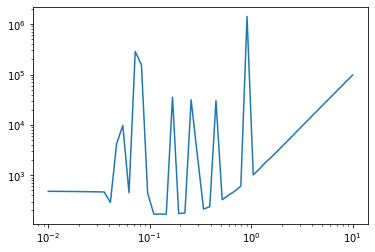

In [111]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [112]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(7.36742e-136)),
 (1, 0.011513953993264475, DM(1.84949e-135)),
 (2, 0.013257113655901088, DM(5.29193e-135)),
 (3, 0.015264179671752334, DM(1.75634e-134)),
 (4, 0.017575106248547922, DM(6.88195e-134)),
 (5, 0.020235896477251575, DM(3.25323e-133)),
 (6, 0.023299518105153717, DM(1.89358e-132)),
 (7, 0.02682695795279726, DM(1.38918e-131)),
 (8, 0.030888435964774818, DM(1.31539e-130)),
 (9, 0.03556480306223128, DM(1.6441e-129)),
 (10, 0.040949150623804255, DM(9.3578e-53)),
 (11, 0.04714866363457394, DM(0)),
 (12, 0.054286754393238594, DM(0)),
 (13, 0.06250551925273973, DM(9.41405e-124)),
 (14, 0.07196856730011521, DM(0)),
 (15, 0.08286427728546843, DM(0)),
 (16, 0.09540954763499938, DM(4.97507e-118)),
 (17, 0.10985411419875583, DM(0.741776)),
 (18, 0.12648552168552957, DM(1)),
 (19, 0.14563484775012436, DM(0.743104)),
 (20, 0.16768329368110083, DM(0)),
 (21, 0.19306977288832497, DM(0.0159692)),
 (22, 0.22229964825261944, DM(0.00016361)),
 (23, 0.2559547922699536, DM(0)),
 (24, 

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

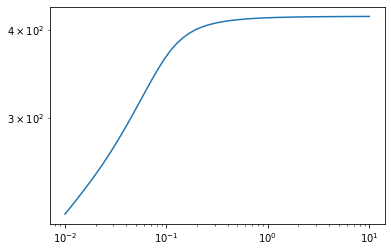

In [113]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [114]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.00385454)),
 (2, 0.013257113655901088, DM(1.14627e-05)),
 (3, 0.015264179671752334, DM(2.53333e-08)),
 (4, 0.017575106248547922, DM(3.92449e-11)),
 (5, 0.020235896477251575, DM(3.9583e-14)),
 (6, 0.023299518105153717, DM(2.39725e-17)),
 (7, 0.02682695795279726, DM(8.05408e-21)),
 (8, 0.030888435964774818, DM(1.40157e-24)),
 (9, 0.03556480306223128, DM(1.20134e-28)),
 (10, 0.040949150623804255, DM(4.94611e-33)),
 (11, 0.04714866363457394, DM(9.87642e-38)),
 (12, 0.054286754393238594, DM(1.01788e-42)),
 (13, 0.06250551925273973, DM(6.24309e-48)),
 (14, 0.07196856730011521, DM(2.94562e-53)),
 (15, 0.08286427728546843, DM(1.59196e-58)),
 (16, 0.09540954763499938, DM(1.65866e-63)),
 (17, 0.10985411419875583, DM(5.63056e-68)),
 (18, 0.12648552168552957, DM(8.79635e-72)),
 (19, 0.14563484775012436, DM(6.7874e-75)),
 (20, 0.16768329368110083, DM(2.24112e-77)),
 (21, 0.19306977288832497, DM(2.49659e-79)),
 (22, 0.22229964825261944, DM(7.34368e-

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [115]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[4823.098844540845, 4489.913162469774, 4817.306596938592, 4905.893717934328]

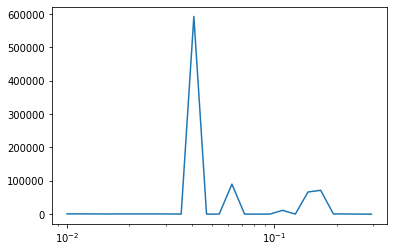

In [116]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [117]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [118]:
from scipy.integrate import solve_ivp
idx = 50
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

77.0909090909091


In [119]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(4088.31), DM(212.208), DM(104.426), DM(141.128), DM(754.148)]

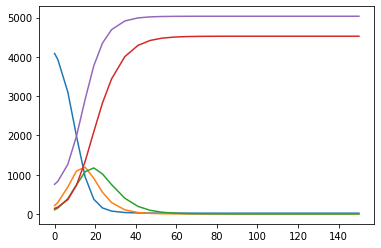

In [120]:
plt.plot(sol.t, sol.y[:,:].T)

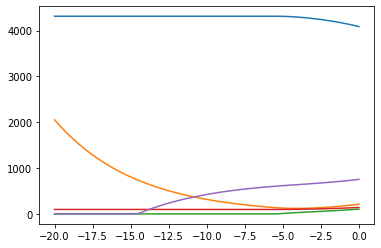

In [121]:
plt.plot(solb.t, solb.y.T)

In [122]:
model.observation_times[-1]

130.0

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

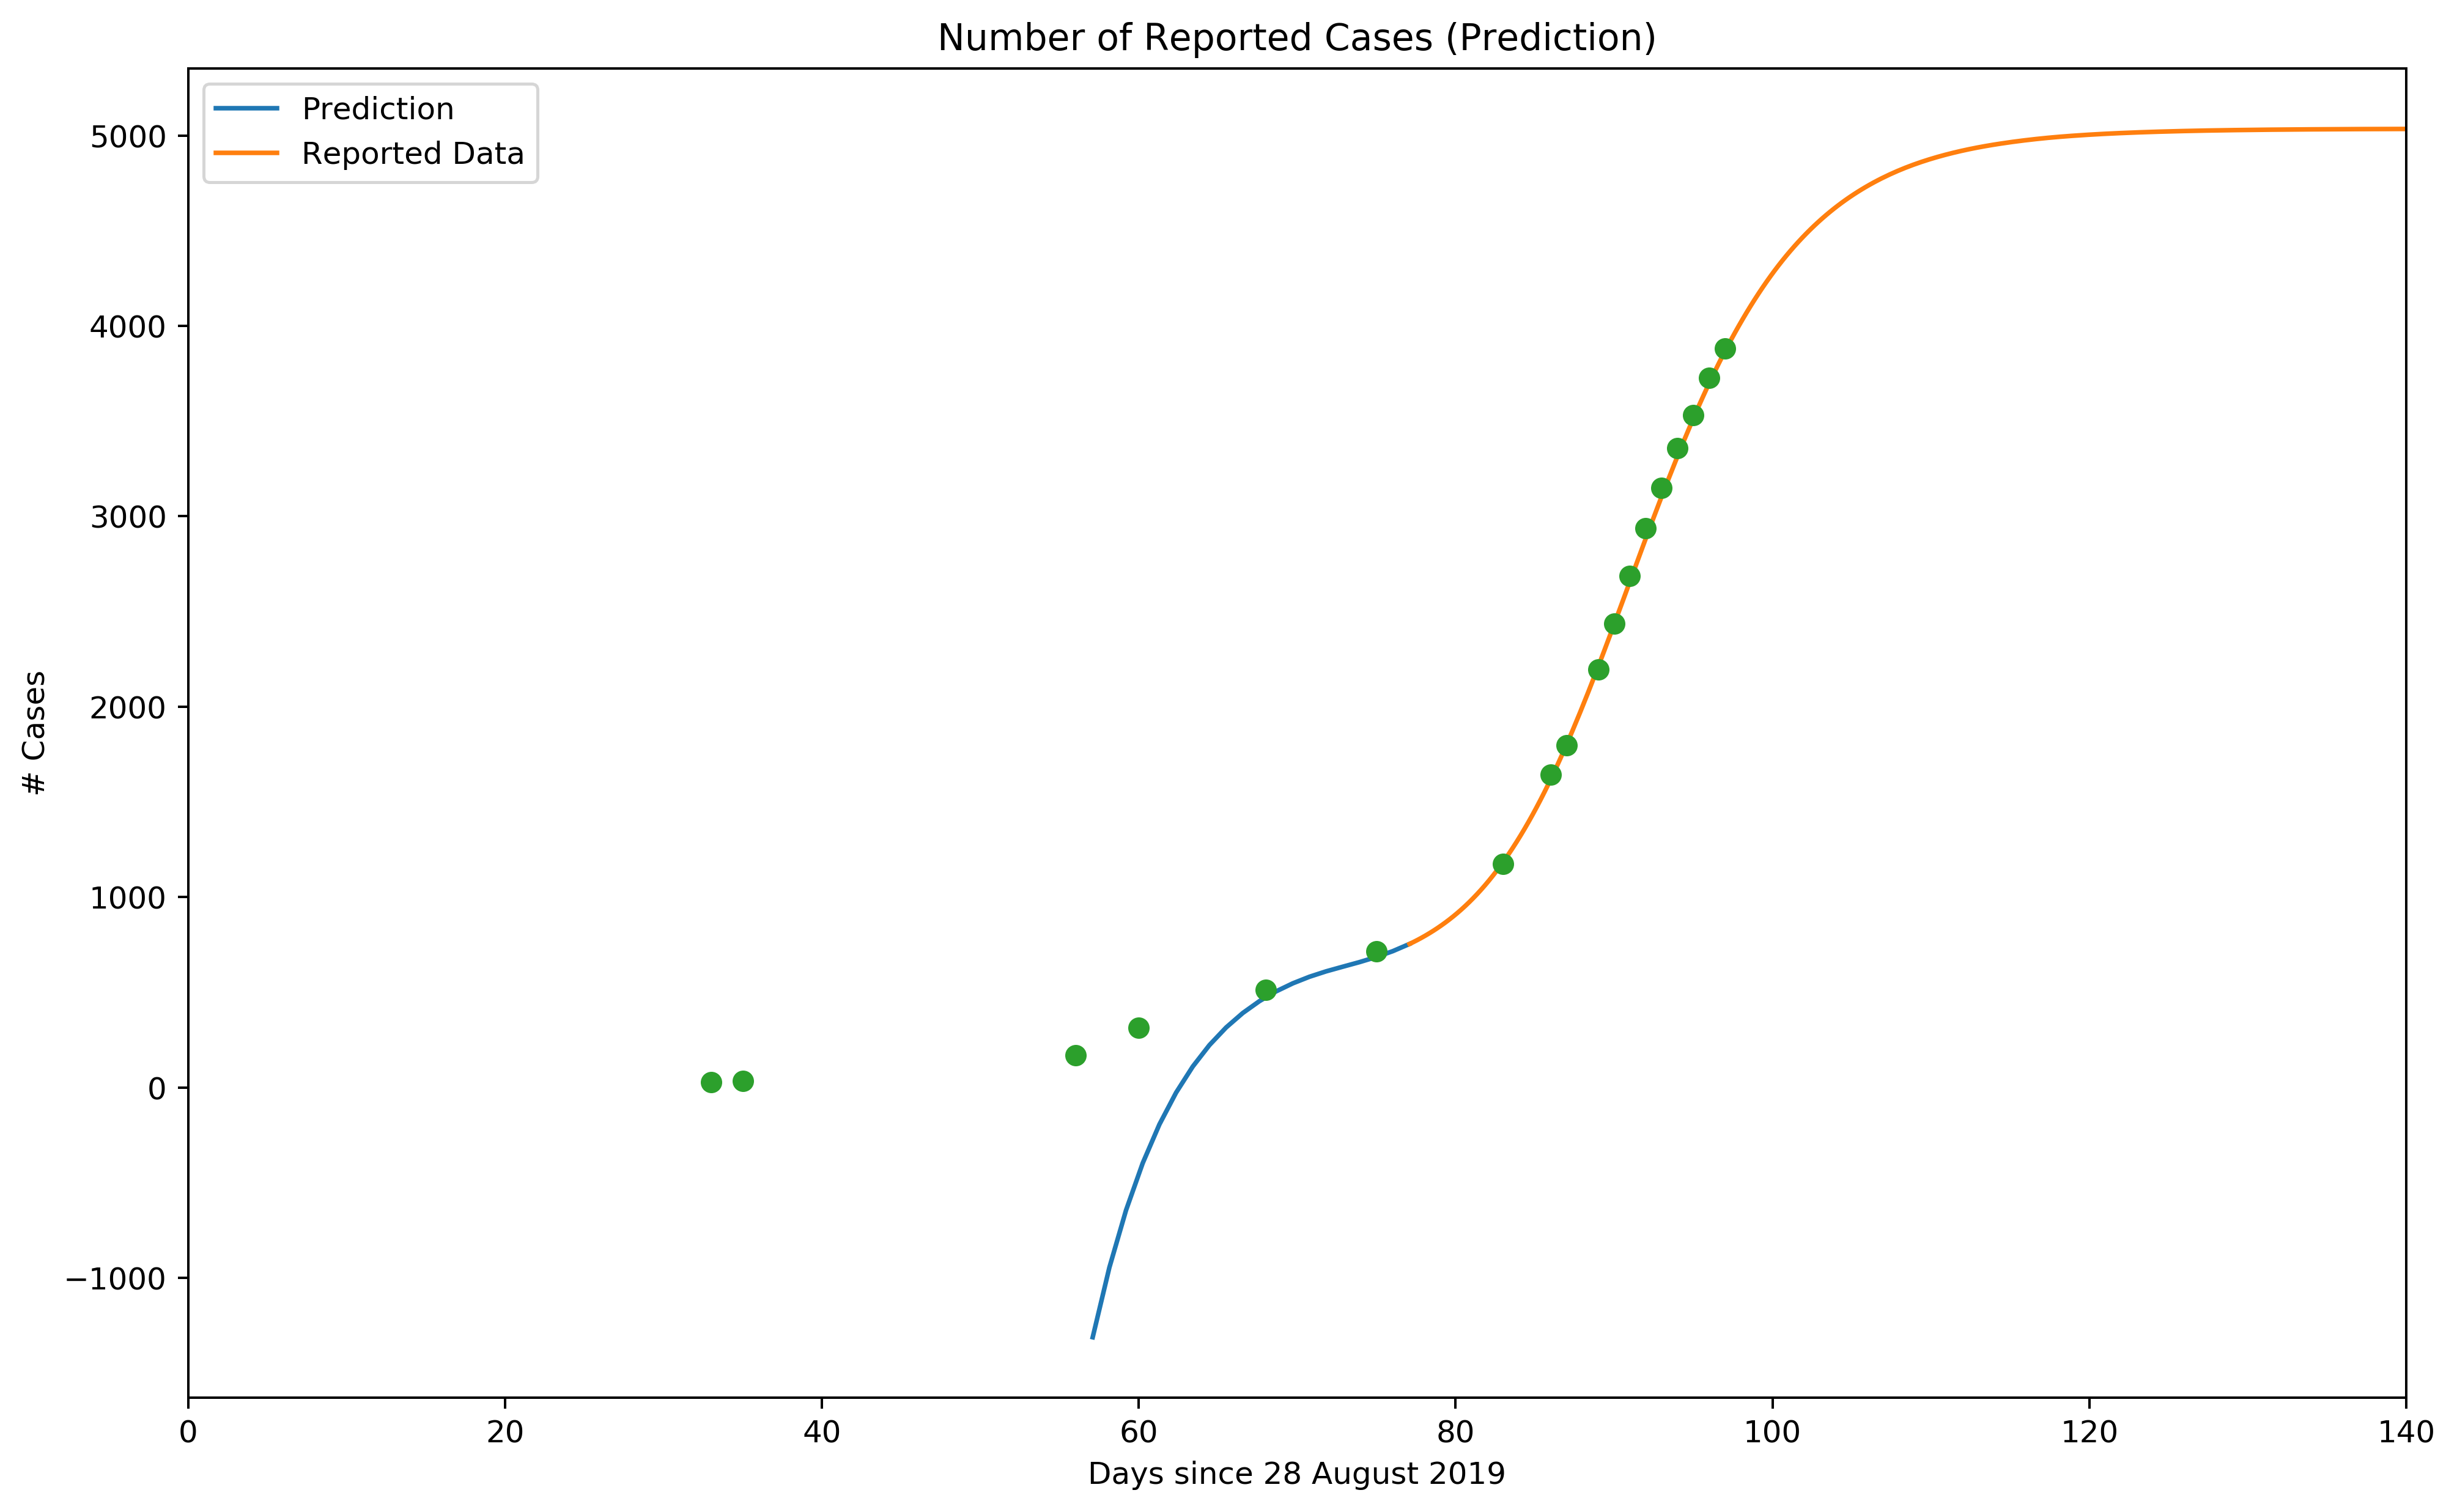

In [123]:
tfine = np.linspace(0, 150, 600)
tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=360)
plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(additional_times, additional_cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

In [134]:
rfin = sol.sol(tfine)[-1,-1]
rfin

5035.987365319451

In [125]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [126]:
tfine[ridx]

30.05008347245409

In [127]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-22.859007436636816

In [128]:
model.observation_times[-1]-model.observation_times[tidx]

52.90909090909091

In [132]:
historical_mortality = 0.02
current_mortality = 55/3881
print(historical_mortality, current_mortality)

0.02 0.014171605256377222


In [133]:
rfin*historical_mortality

100.71974730638902

In [131]:
rfin*current_mortality

66.89492753660033